# Extracting features with Pre-trained models

#### Import packages

In [1]:
#importing other required libraries
import numpy as np
import pandas as pd
import os
from glob import glob
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import itertools
import tensorflow as tf
print('TensorFlow Version ' + tf.__version__)

# Enable mixed precision 
# tf.keras.mixed_precision.set_global_policy('mixed_float16') 

import keras
print('keras Version ' + keras.__version__)

from keras import Sequential, layers
from keras.applications import VGG16
from keras.optimizers import SGD, Adam
from keras.callbacks import ReduceLROnPlateau
from keras.layers import Flatten, Dense, BatchNormalization, Activation, Dropout, InputLayer, Conv2D
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

TensorFlow Version 2.14.0
keras Version 2.14.0


In [3]:
tf.test.is_built_with_cuda()

False

In [2]:
def load_data(folder, image_size):
    class_names = [f for f in os.listdir(folder) if not f.startswith('.')]  # Create a list of subfolders

    images_data = []
    labels = []

    print(class_names)
    for t, f in enumerate(class_names):
        images = glob(os.path.join(folder, f, "*"))
        print("Downloading: ", f)
        fig = plt.figure(figsize=(50, 50))
        for im_n, im in enumerate(images):
            plt.gray()
            rgba_image = cv2.imread(im, cv2.IMREAD_UNCHANGED)
            
            # Convert RGBA to RGB if it has an alpha channel
            if rgba_image.shape[2] == 4:
                rgb_image = cv2.cvtColor(rgba_image, cv2.COLOR_RGBA2RGB)
                #Converting image to LAB Color so CLAHE can be applied to the luminance channel
                lab_img = cv2.cvtColor(rgb_image, cv2.COLOR_BGR2LAB)

                #Splitting the LAB image to L, A and B channels, respectively
                l, a, b = cv2.split(lab_img)

                ###########Histogram Equlization#############
                #Apply histogram equalization to the L channel
                equ = cv2.equalizeHist(l)
                #Combine the Hist. equalized L-channel back with A and B channels
                updated_lab_img1 = cv2.merge((equ,a,b))

                #Convert LAB image back to color (RGB)
                hist_eq_img = cv2.cvtColor(updated_lab_img1, cv2.COLOR_LAB2BGR)
            # Resize the image
            image = cv2.resize(hist_eq_img, (image_size, image_size), interpolation=cv2.INTER_LINEAR)
            

            # Flatten the image
            image = image.flatten()

            images_data.append(image)
            labels.append(f)

    return np.array(images_data), np.array(labels)

# Example usage
dir_data = 'c:/2016/plots'
image_size_224 = 224  # Adjust the desired size as needed
loaded_images, loaded_labels = load_data(dir_data, image_size=image_size_224)


images = []
labels = []


for feature in loaded_images:
    images.append(feature)
    
for label in loaded_labels:
    labels.append(label)


# Normalize the data
images = np.array(images).astype(np.float16)
# images = np.array(images).astype(np.float32) / 255.0


# Reshaping input images
images = images.reshape(-1, image_size_224, image_size_224, 3)


# Creating a dictionary of clases
lab = {}
for i, l in enumerate(set(labels)):
    lab[l] = i


labels = np.array([lab[l] for l in labels])

['Abnormal', 'Normal']
Downloading:  Abnormal
Downloading:  Normal


<Figure size 5000x5000 with 0 Axes>

<Figure size 5000x5000 with 0 Axes>

In [17]:
print(images.shape)
print(labels.shape)

(2000, 224, 224, 3)
(2000,)


# Label One-hot encoding

In [6]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical

encoder = LabelEncoder()
encoder.fit(labels)
encoded_Y = encoder.transform(labels)

dummy_Y = to_categorical(encoded_Y)
dummy_Y.astype(int)

array([[1, 0],
       [1, 0],
       [1, 0],
       ...,
       [0, 1],
       [0, 1],
       [0, 1]])

# Train Test Validation split

In [7]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(images, encoded_Y, test_size = 0.1, stratify=labels, random_state = 42)

In [ ]:
np.save('X_train.npy', X_train)
np.save('X_test.npy', X_test)
np.save('y_train.npy', y_train)
np.save('y_test.npy', y_test)

In [2]:
X_train = np.load('X_train.npy')
X_test = np.load('X_test.npy')

y_train = np.load('y_train.npy')
y_test = np.load('y_test.npy')

In [3]:
print(f'X train shape: {X_train.shape}')
print(f'X test shape: {X_test.shape}')

print(f'y train shape: {y_train.shape}')
print(f'y test shape: {y_test.shape}')

X train shape: (7200, 224, 224, 3)
X test shape: (800, 224, 224, 3)
y train shape: (7200,)
y test shape: (800,)


In [4]:
# Function to create subsets with specified ratio
def create_subset(X, y, ratio):
    X_subset, _, y_subset, _ = train_test_split(X, y, train_size=ratio, stratify=y, random_state=42)
    return X_subset, y_subset

# Create subsets
X_train_1_percent, y_train_1_percent = create_subset(X_train, y_train, 0.01)
X_train_10_percent, y_train_10_percent = create_subset(X_train, y_train, 0.10)
X_train_20_percent, y_train_20_percent = create_subset(X_train, y_train, 0.20)

In [5]:
print(f'X train 1%: {X_train_1_percent.shape}')
print(f'X train 10%: {X_train_10_percent.shape}')
print(f'X train 20%: {X_train_20_percent.shape}')
print(f'X train 100%: {X_train.shape}')

X train 1%: (72, 224, 224, 3)
X train 10%: (720, 224, 224, 3)
X train 20%: (1440, 224, 224, 3)
X train 100%: (7200, 224, 224, 3)


In [13]:
# Function to get class distribution
def get_class_distribution(labels):
    unique, counts = np.unique(labels, return_counts=True)
    distribution = dict(zip(unique, counts))
    return distribution

# Get class distribution in training set
train_distribution = get_class_distribution(y_train)
print("Class distribution in 100% training set:", train_distribution)


train_distribution = get_class_distribution(y_train_1_percent)
print("Class distribution in 1% training set:", train_distribution)

# Get class distribution in training set
train_distribution = get_class_distribution(y_train_10_percent)
print("Class distribution in 10% training set:", train_distribution)

# Get class distribution in training set
train_distribution = get_class_distribution(y_train_20_percent)
print("Class distribution in 20% training set:", train_distribution)

# Get class distribution in test set
test_distribution = get_class_distribution(y_test)
print("Class distribution in test set:", test_distribution)

Class distribution in 100% training set: {0: 7876, 1: 7877}
Class distribution in 1% training set: {0: 78, 1: 79}
Class distribution in 10% training set: {0: 787, 1: 788}
Class distribution in 20% training set: {0: 1575, 1: 1575}
Class distribution in test set: {0: 876, 1: 875}


# EfficientNetB0 for linear evaluation

In [8]:
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

# Step 1: Load pre-trained ResNet50 model
EfficientNetB0_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Step 2: Freeze the base model
for layer in EfficientNetB0_model.layers:
    layer.trainable = False

# Step 3: Add custom layers for binary classification
x = EfficientNetB0_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)  # Add a fully connected layer with 1024 units
predictions = Dense(1, activation='sigmoid')(x)  # Binary classification layer

# Step 4: Create the new model
EfficientNetB0_model = Model(inputs=EfficientNetB0_model.input, outputs=predictions)

# Step 5: Compile the model
EfficientNetB0_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

early_stopping = tf.keras.callbacks.EarlyStopping(monitor="loss", patience=5, restore_best_weights=True)
# Assuming train_data and validation_data are your datasets
# Step 6: Train the model
EfficientNetB0_history = EfficientNetB0_model.fit(X_train,
                            y_train,
                            validation_split=0.2, 
                            epochs=50,
                            batch_size = 64,
                            callbacks=[early_stopping] 
          )

Epoch 1/50
23/23 [==============================] - 181s 7s/step - loss: 0.8575 - accuracy: 0.5625 - val_loss: 0.6050 - val_accuracy: 0.6806
Epoch 2/50
23/23 [==============================] - 140s 6s/step - loss: 0.6309 - accuracy: 0.6368 - val_loss: 0.5890 - val_accuracy: 0.6944
Epoch 3/50
23/23 [==============================] - 157s 7s/step - loss: 0.6160 - accuracy: 0.6611 - val_loss: 0.5743 - val_accuracy: 0.7194
Epoch 4/50
23/23 [==============================] - 146s 6s/step - loss: 0.5867 - accuracy: 0.7097 - val_loss: 0.5691 - val_accuracy: 0.7167
Epoch 5/50
23/23 [==============================] - 147s 6s/step - loss: 0.5605 - accuracy: 0.7146 - val_loss: 0.5730 - val_accuracy: 0.6972
Epoch 6/50
23/23 [==============================] - 132s 6s/step - loss: 0.5459 - accuracy: 0.7375 - val_loss: 0.5234 - val_accuracy: 0.7389
Epoch 7/50
23/23 [==============================] - 132s 6s/step - loss: 0.5381 - accuracy: 0.7403 - val_loss: 0.5094 - val_accuracy: 0.7611
Epoch 8/50
23

In [9]:
EfficientNetB0_result = EfficientNetB0_model.evaluate(
    X_test, 
    y_test, 
    batch_size = 64, 
    verbose = 0
    )
print('The EfficientNetB0 error is: %.2f%%'%(100 - EfficientNetB0_result[1]*100))

The EfficientNetB0 error is: 14.50%


In [10]:
test_loss_EfficientNetB0, test_accuracy_EfficientNetB0 = EfficientNetB0_model.evaluate(
    X_test, 
    y_test, 
    batch_size = 64, 
    verbose = 0
    )
print(f'Test Loss : {test_loss_EfficientNetB0:.4f}')
print(f'Test Accuracy: {test_accuracy_EfficientNetB0:.4f}')

Test Loss : 0.3232
Test Accuracy: 0.8550


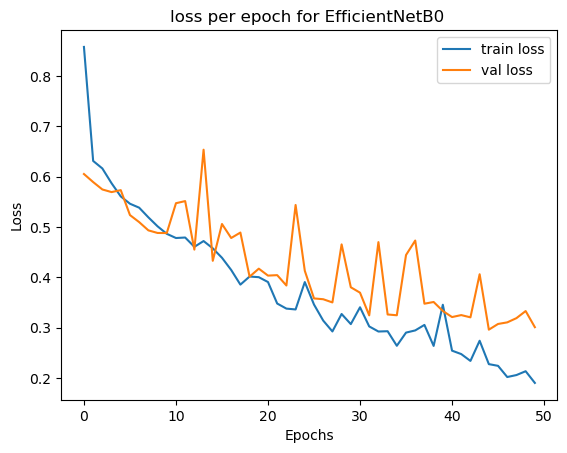

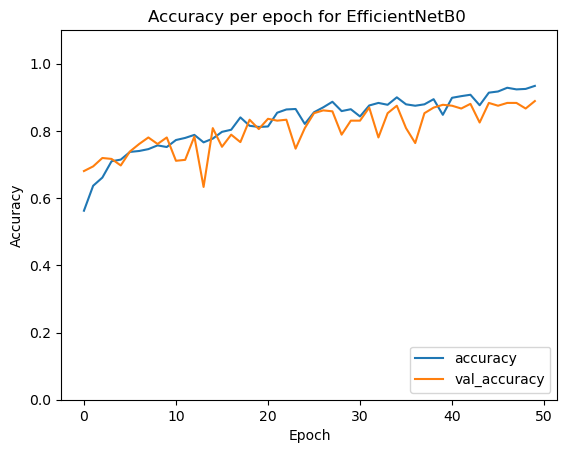

In [11]:
plt.plot(EfficientNetB0_history.history['loss'], label='train loss')
plt.plot(EfficientNetB0_history.history['val_loss'], label='val loss')
plt.title('loss per epoch for EfficientNetB0 ')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
plt.savefig('loss per epoch for EfficientNetB0' , dpi=100)


plt.plot(EfficientNetB0_history.history['accuracy'], label='accuracy')
plt.plot(EfficientNetB0_history.history['val_accuracy'], label = 'val_accuracy')
plt.title('Accuracy per epoch for EfficientNetB0 ')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.0, 1.1])
plt.legend(loc='lower right')
plt.savefig('accuracy per epoch for EfficientNetB0' , dpi=100)

7/7 [==============================] - 20s 2s/step
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.84      0.85       101
           1       0.84      0.87      0.86        99

    accuracy                           0.85       200
   macro avg       0.86      0.86      0.85       200
weighted avg       0.86      0.85      0.85       200

ROC AUC Score: 0.933993399339934


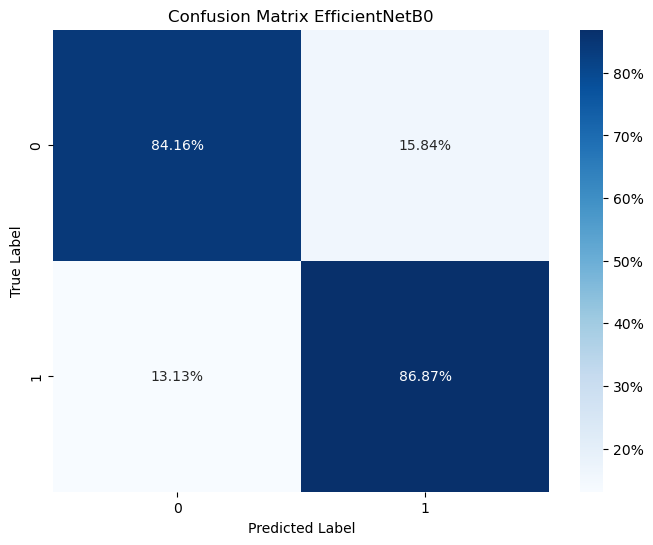

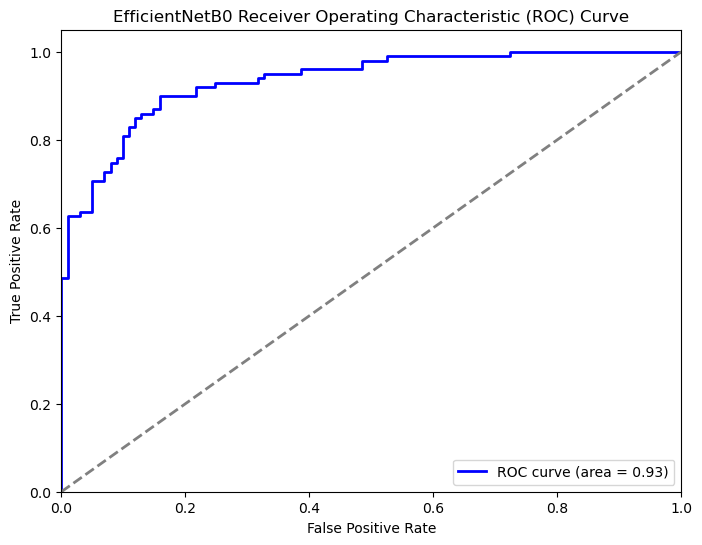

In [12]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, roc_curve

# Assuming you have your test data prepared and stored in X_test and y_test_1d

# Step 7: Evaluate the model
y_pred = EfficientNetB0_model.predict(X_test)

# Convert probabilities to binary predictions (0 or 1)
y_pred_binary = np.where(y_pred > 0.5, 1, 0)

# Print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred_binary))

# Calculate ROC AUC score
roc_auc = roc_auc_score(y_test, y_pred)
print(f"ROC AUC Score: {roc_auc}")

# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred_binary)

# Normalize confusion matrix to percentages
cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

# Plot confusion matrix with percentages
plt.figure(figsize=(8, 6))
ax = sns.heatmap(cm_percentage, annot=True, fmt=".2f", cmap='Blues', cbar_kws={'format': '%.0f%%'})

# Annotate the heatmap with percentage signs
for t in ax.texts: 
    t.set_text(t.get_text() + "%")

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix EfficientNetB0')
plt.show()

# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('EfficientNetB0 Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

### Eff Net with 1% training data

In [23]:
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

# Step 1: Load pre-trained ResNet50 model
EfficientNetB0_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Step 2: Freeze the base model
for layer in EfficientNetB0_model.layers:
    layer.trainable = False

# Step 3: Add custom layers for binary classification
x = EfficientNetB0_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)  # Add a fully connected layer with 1024 units
predictions = Dense(1, activation='sigmoid')(x)  # Binary classification layer

# Step 4: Create the new model
EfficientNetB0_model = Model(inputs=EfficientNetB0_model.input, outputs=predictions)

# Step 5: Compile the model
EfficientNetB0_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

early_stopping = tf.keras.callbacks.EarlyStopping(monitor="loss", patience=5, restore_best_weights=True)
# Assuming train_data and validation_data are your datasets
# Step 6: Train the model
EfficientNetB0_history_1_percent = EfficientNetB0_model.fit(X_train_1_percent,
                            y_train_1_percent,
                            validation_split=0.2, 
                            epochs=50,
                            batch_size = 64,
                            callbacks=[early_stopping] 
          )

Epoch 1/50
1/1 [==============================] - 20s 20s/step - loss: 0.7051 - accuracy: 0.5714 - val_loss: 0.7326 - val_accuracy: 0.7500
Epoch 2/50
1/1 [==============================] - 1s 1s/step - loss: 1.5033 - accuracy: 0.4286 - val_loss: 0.8439 - val_accuracy: 0.2500
Epoch 3/50
1/1 [==============================] - 1s 1s/step - loss: 0.6522 - accuracy: 0.5000 - val_loss: 2.1106 - val_accuracy: 0.2500
Epoch 4/50
1/1 [==============================] - 2s 2s/step - loss: 1.0101 - accuracy: 0.5714 - val_loss: 1.8623 - val_accuracy: 0.2500
Epoch 5/50
1/1 [==============================] - 1s 1s/step - loss: 0.9793 - accuracy: 0.5714 - val_loss: 0.9855 - val_accuracy: 0.2500
Epoch 6/50
1/1 [==============================] - 1s 1s/step - loss: 0.5558 - accuracy: 0.6429 - val_loss: 0.4746 - val_accuracy: 0.7500
Epoch 7/50
1/1 [==============================] - 1s 1s/step - loss: 0.5511 - accuracy: 0.7143 - val_loss: 0.4192 - val_accuracy: 0.7500
Epoch 8/50
1/1 [=======================

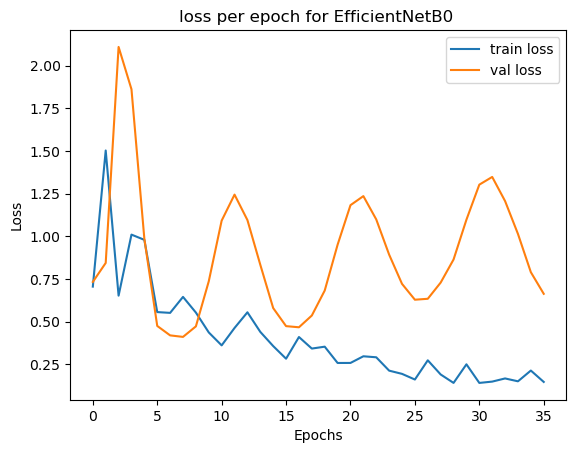

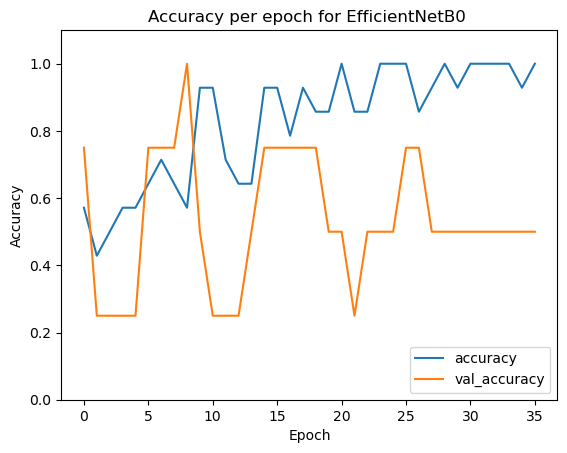

In [24]:
plt.plot(EfficientNetB0_history_1_percent.history['loss'], label='train loss')
plt.plot(EfficientNetB0_history_1_percent.history['val_loss'], label='val loss')
plt.title('loss per epoch for EfficientNetB0 ')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
plt.savefig('loss per epoch for EfficientNetB0' , dpi=100)


plt.plot(EfficientNetB0_history_1_percent.history['accuracy'], label='accuracy')
plt.plot(EfficientNetB0_history_1_percent.history['val_accuracy'], label = 'val_accuracy')
plt.title('Accuracy per epoch for EfficientNetB0 ')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.0, 1.1])
plt.legend(loc='lower right')
plt.savefig('accuracy per epoch for EfficientNetB0' , dpi=100)

7/7 [==============================] - 18s 2s/step
Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.25      0.38       101
           1       0.55      0.94      0.69        99

    accuracy                           0.59       200
   macro avg       0.68      0.59      0.54       200
weighted avg       0.68      0.59      0.53       200

ROC AUC Score: 0.6077607760776078


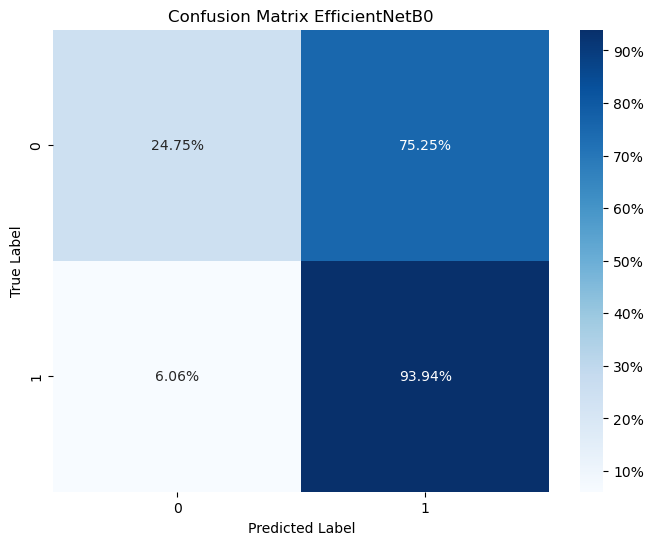

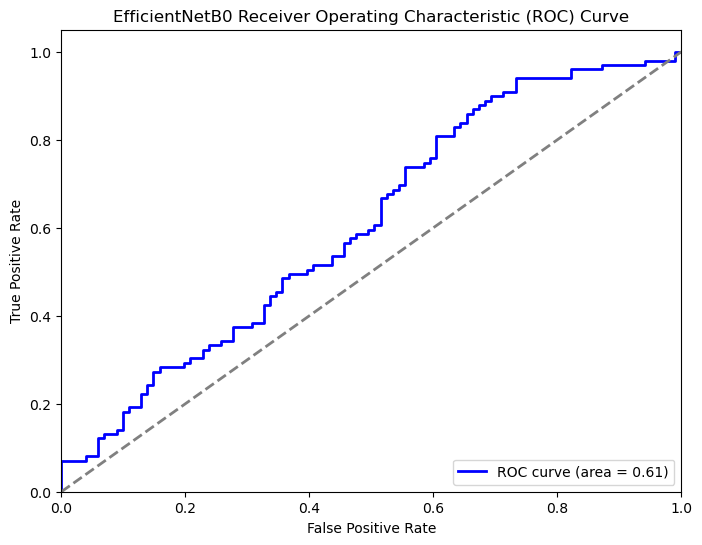

In [25]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, roc_curve

# Assuming you have your test data prepared and stored in X_test and y_test_1d

# Step 7: Evaluate the model
y_pred = EfficientNetB0_model.predict(X_test)

# Convert probabilities to binary predictions (0 or 1)
y_pred_binary = np.where(y_pred > 0.5, 1, 0)

# Print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred_binary))

# Calculate ROC AUC score
roc_auc = roc_auc_score(y_test, y_pred)
print(f"ROC AUC Score: {roc_auc}")

# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred_binary)

# Normalize confusion matrix to percentages
cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

# Plot confusion matrix with percentages
plt.figure(figsize=(8, 6))
ax = sns.heatmap(cm_percentage, annot=True, fmt=".2f", cmap='Blues', cbar_kws={'format': '%.0f%%'})

# Annotate the heatmap with percentage signs
for t in ax.texts: 
    t.set_text(t.get_text() + "%")

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix EfficientNetB0')
plt.show()

# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('EfficientNetB0 Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

### Eff Net with 10% training data

In [26]:
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

# Step 1: Load pre-trained ResNet50 model
EfficientNetB0_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Step 2: Freeze the base model
for layer in EfficientNetB0_model.layers:
    layer.trainable = False

# Step 3: Add custom layers for binary classification
x = EfficientNetB0_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)  # Add a fully connected layer with 1024 units
predictions = Dense(1, activation='sigmoid')(x)  # Binary classification layer

# Step 4: Create the new model
EfficientNetB0_model = Model(inputs=EfficientNetB0_model.input, outputs=predictions)

# Step 5: Compile the model
EfficientNetB0_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

early_stopping = tf.keras.callbacks.EarlyStopping(monitor="loss", patience=5, restore_best_weights=True)
# Assuming train_data and validation_data are your datasets
# Step 6: Train the model
EfficientNetB0_history_10_percent = EfficientNetB0_model.fit(X_train_10_percent,
                            y_train_10_percent,
                            validation_split=0.2, 
                            epochs=50,
                            batch_size = 64,
                            callbacks=[early_stopping] 
          )

Epoch 1/50
3/3 [==============================] - 33s 6s/step - loss: 1.1136 - accuracy: 0.5556 - val_loss: 1.0457 - val_accuracy: 0.5000
Epoch 2/50
3/3 [==============================] - 14s 5s/step - loss: 0.8481 - accuracy: 0.5139 - val_loss: 0.7290 - val_accuracy: 0.4722
Epoch 3/50
3/3 [==============================] - 12s 4s/step - loss: 0.6144 - accuracy: 0.6250 - val_loss: 0.7348 - val_accuracy: 0.5278
Epoch 4/50
3/3 [==============================] - 12s 4s/step - loss: 0.5956 - accuracy: 0.7153 - val_loss: 0.7855 - val_accuracy: 0.5833
Epoch 5/50
3/3 [==============================] - 13s 5s/step - loss: 0.5613 - accuracy: 0.7500 - val_loss: 0.7757 - val_accuracy: 0.5833
Epoch 6/50
3/3 [==============================] - 14s 5s/step - loss: 0.5487 - accuracy: 0.6944 - val_loss: 0.7663 - val_accuracy: 0.6111
Epoch 7/50
3/3 [==============================] - 14s 5s/step - loss: 0.5183 - accuracy: 0.7431 - val_loss: 0.8299 - val_accuracy: 0.6111
Epoch 8/50
3/3 [==================

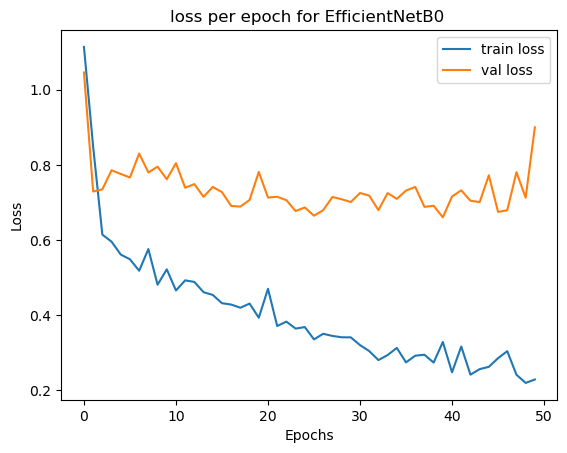

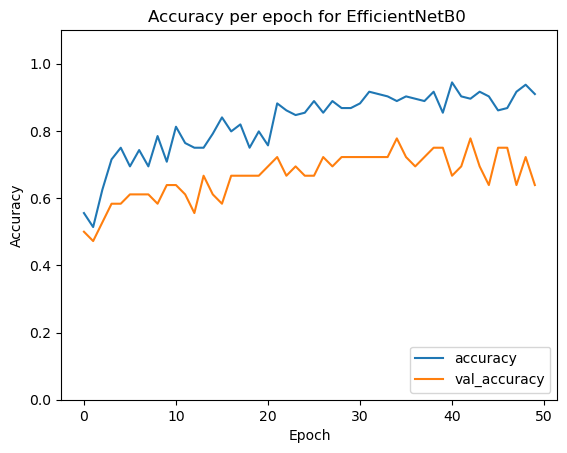

In [27]:
plt.plot(EfficientNetB0_history_10_percent.history['loss'], label='train loss')
plt.plot(EfficientNetB0_history_10_percent.history['val_loss'], label='val loss')
plt.title('loss per epoch for EfficientNetB0 ')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
plt.savefig('loss per epoch for EfficientNetB0' , dpi=100)


plt.plot(EfficientNetB0_history_10_percent.history['accuracy'], label='accuracy')
plt.plot(EfficientNetB0_history_10_percent.history['val_accuracy'], label = 'val_accuracy')
plt.title('Accuracy per epoch for EfficientNetB0 ')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.0, 1.1])
plt.legend(loc='lower right')
plt.savefig('accuracy per epoch for EfficientNetB0' , dpi=100)

7/7 [==============================] - 19s 2s/step
Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.52      0.61       101
           1       0.62      0.80      0.70        99

    accuracy                           0.66       200
   macro avg       0.67      0.66      0.65       200
weighted avg       0.67      0.66      0.65       200

ROC AUC Score: 0.7294729472947294


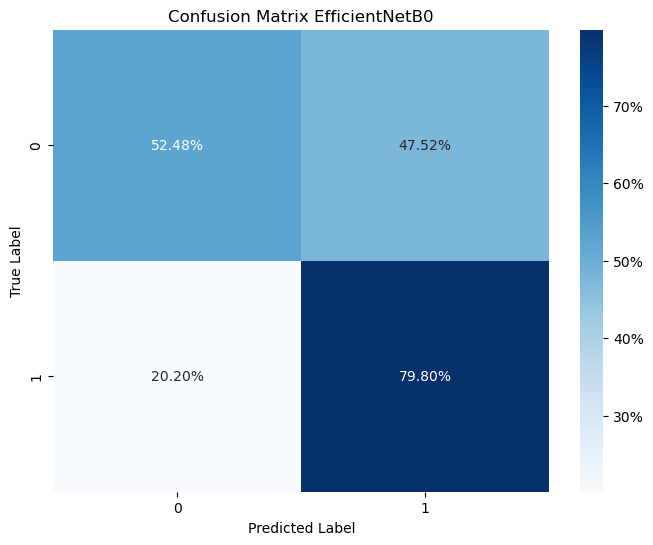

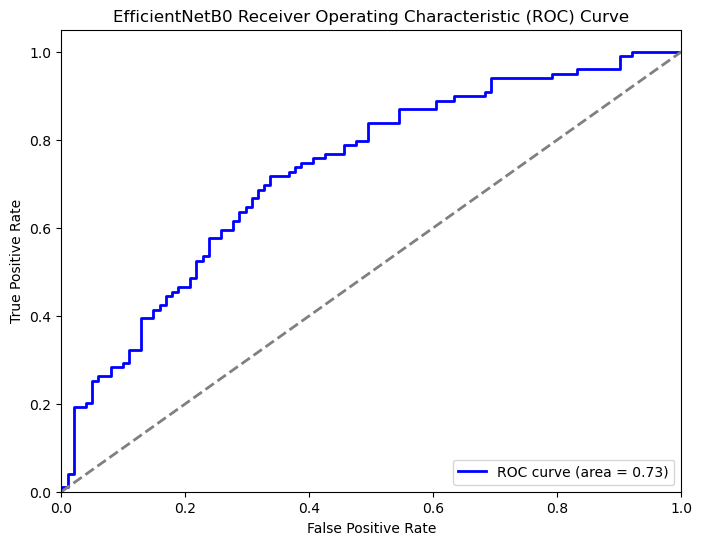

In [28]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, roc_curve

# Assuming you have your test data prepared and stored in X_test and y_test_1d

# Step 7: Evaluate the model
y_pred = EfficientNetB0_model.predict(X_test)

# Convert probabilities to binary predictions (0 or 1)
y_pred_binary = np.where(y_pred > 0.5, 1, 0)

# Print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred_binary))

# Calculate ROC AUC score
roc_auc = roc_auc_score(y_test, y_pred)
print(f"ROC AUC Score: {roc_auc}")

# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred_binary)

# Normalize confusion matrix to percentages
cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

# Plot confusion matrix with percentages
plt.figure(figsize=(8, 6))
ax = sns.heatmap(cm_percentage, annot=True, fmt=".2f", cmap='Blues', cbar_kws={'format': '%.0f%%'})

# Annotate the heatmap with percentage signs
for t in ax.texts: 
    t.set_text(t.get_text() + "%")

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix EfficientNetB0')
plt.show()

# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('EfficientNetB0 Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

### Eff Net with 20% training data

In [7]:
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

# Step 1: Load pre-trained ResNet50 model
EfficientNetB0_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Step 2: Freeze the base model
for layer in EfficientNetB0_model.layers:
    layer.trainable = False

# Step 3: Add custom layers for binary classification
x = EfficientNetB0_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)  # Add a fully connected layer with 1024 units
predictions = Dense(1, activation='sigmoid')(x)  # Binary classification layer

# Step 4: Create the new model
EfficientNetB0_model = Model(inputs=EfficientNetB0_model.input, outputs=predictions)

# Step 5: Compile the model
EfficientNetB0_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

early_stopping = tf.keras.callbacks.EarlyStopping(monitor="loss", patience=5, restore_best_weights=True)
# Assuming train_data and validation_data are your datasets
# Step 6: Train the model
EfficientNetB0_history_20_percent = EfficientNetB0_model.fit(X_train_20_percent,
                            y_train_20_percent,
                            validation_split=0.2, 
                            epochs=50,
                            batch_size = 64,
                            callbacks=[early_stopping] 
          )

Epoch 1/50
5/5 [==============================] - 49s 7s/step - loss: 1.1089 - accuracy: 0.4931 - val_loss: 0.6731 - val_accuracy: 0.5833
Epoch 2/50
5/5 [==============================] - 28s 6s/step - loss: 0.7249 - accuracy: 0.5625 - val_loss: 0.6530 - val_accuracy: 0.6250
Epoch 3/50
5/5 [==============================] - 28s 6s/step - loss: 0.6467 - accuracy: 0.6458 - val_loss: 0.6518 - val_accuracy: 0.6389
Epoch 4/50
5/5 [==============================] - 27s 6s/step - loss: 0.5942 - accuracy: 0.6736 - val_loss: 0.6598 - val_accuracy: 0.6389
Epoch 5/50
5/5 [==============================] - 28s 6s/step - loss: 0.5741 - accuracy: 0.6910 - val_loss: 0.6742 - val_accuracy: 0.5972
Epoch 6/50
5/5 [==============================] - 28s 6s/step - loss: 0.5633 - accuracy: 0.6979 - val_loss: 0.6809 - val_accuracy: 0.6111
Epoch 7/50
5/5 [==============================] - 30s 6s/step - loss: 0.5512 - accuracy: 0.7188 - val_loss: 0.6892 - val_accuracy: 0.5972
Epoch 8/50
5/5 [==================

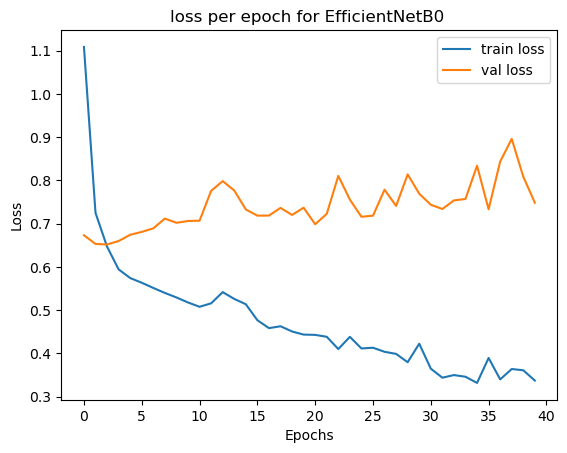

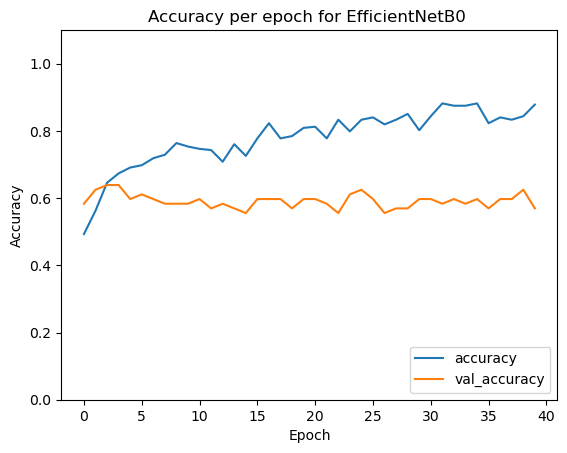

In [8]:
plt.plot(EfficientNetB0_history_20_percent.history['loss'], label='train loss')
plt.plot(EfficientNetB0_history_20_percent.history['val_loss'], label='val loss')
plt.title('loss per epoch for EfficientNetB0 ')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
plt.savefig('loss per epoch for EfficientNetB0' , dpi=100)


plt.plot(EfficientNetB0_history_20_percent.history['accuracy'], label='accuracy')
plt.plot(EfficientNetB0_history_20_percent.history['val_accuracy'], label = 'val_accuracy')
plt.title('Accuracy per epoch for EfficientNetB0 ')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.0, 1.1])
plt.legend(loc='lower right')
plt.savefig('accuracy per epoch for EfficientNetB0' , dpi=100)

7/7 [==============================] - 22s 3s/step
Classification Report:
              precision    recall  f1-score   support

           0       0.60      0.88      0.71        99
           1       0.78      0.43      0.55       101

    accuracy                           0.65       200
   macro avg       0.69      0.65      0.63       200
weighted avg       0.69      0.65      0.63       200

ROC AUC Score: 0.7382738273827383


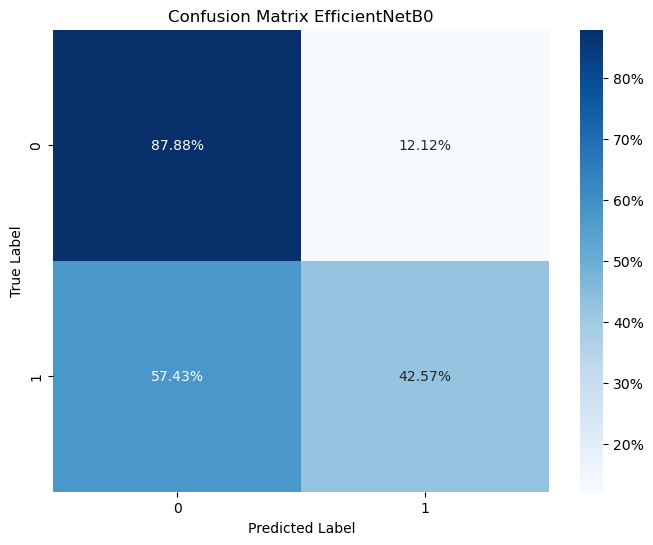

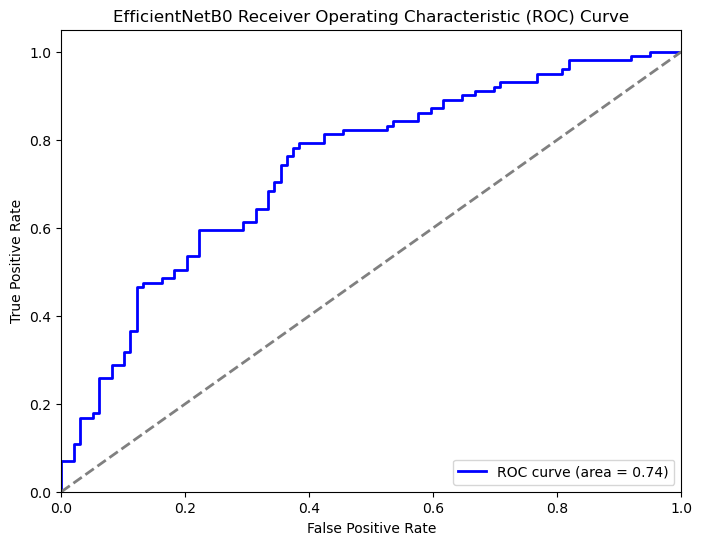

In [9]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, roc_curve

# Assuming you have your test data prepared and stored in X_test and y_test_1d

# Step 7: Evaluate the model
y_pred = EfficientNetB0_model.predict(X_test)

# Convert probabilities to binary predictions (0 or 1)
y_pred_binary = np.where(y_pred > 0.5, 1, 0)

# Print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred_binary))

# Calculate ROC AUC score
roc_auc = roc_auc_score(y_test, y_pred)
print(f"ROC AUC Score: {roc_auc}")

# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred_binary)

# Normalize confusion matrix to percentages
cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

# Plot confusion matrix with percentages
plt.figure(figsize=(8, 6))
ax = sns.heatmap(cm_percentage, annot=True, fmt=".2f", cmap='Blues', cbar_kws={'format': '%.0f%%'})

# Annotate the heatmap with percentage signs
for t in ax.texts: 
    t.set_text(t.get_text() + "%")

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix EfficientNetB0')
plt.show()

# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('EfficientNetB0 Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Xception Linear evaluation

In [4]:
import tensorflow as tf
from tensorflow.keras.applications import Xception
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

# Step 1: Load pre-trained ResNet50 model
Xception_model = Xception(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Step 2: Freeze the base model
for layer in Xception_model.layers:
    layer.trainable = False

# Step 3: Add custom layers for binary classification
x = Xception_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)  # Add a fully connected layer with 1024 units
predictions = Dense(1, activation='sigmoid')(x)  # Binary classification layer

# Step 4: Create the new model
Xception_model = Model(inputs=Xception_model.input, outputs=predictions)

# Step 5: Compile the model
Xception_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

early_stopping = tf.keras.callbacks.EarlyStopping(monitor="loss", patience=5, restore_best_weights=True)
# Assuming train_data and validation_data are your datasets
# Step 6: Train the model
Xception_history = Xception_model.fit(X_train,
                            y_train,
                            validation_split=0.2, 
                            epochs=50,
                            batch_size = 32,
                            callbacks=[early_stopping] 
          )

Epoch 1/50
 12/197 [>.............................] - ETA: 27:59 - loss: 42.8213 - accuracy: 0.5299

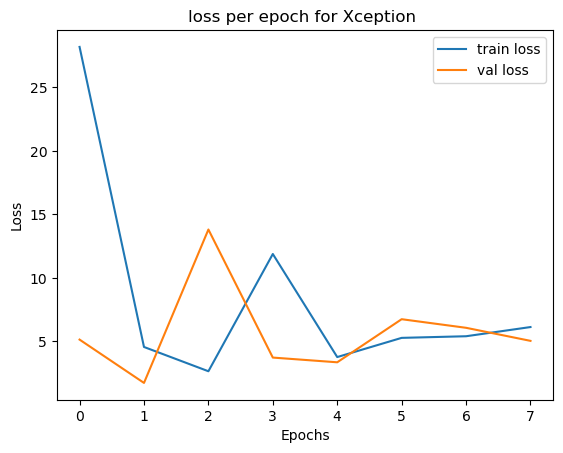

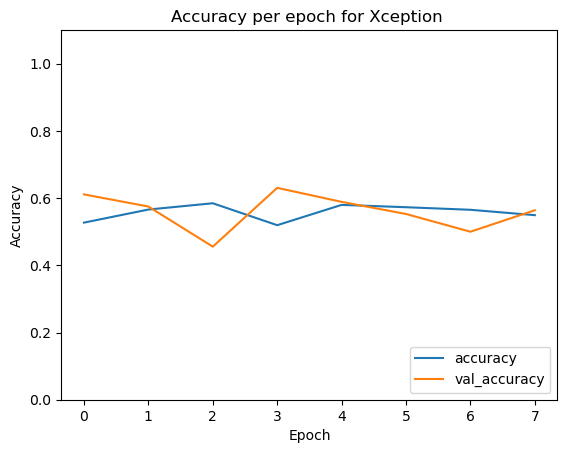

In [14]:
plt.plot(Xception_history.history['loss'], label='train loss')
plt.plot(Xception_history.history['val_loss'], label='val loss')
plt.title('loss per epoch for Xception ')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
plt.savefig('loss per epoch for Xception' , dpi=100)


plt.plot(Xception_history.history['accuracy'], label='accuracy')
plt.plot(Xception_history.history['val_accuracy'], label = 'val_accuracy')
plt.title('Accuracy per epoch for Xception ')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.0, 1.1])
plt.legend(loc='lower right')
plt.savefig('accuracy per epoch for Xception' , dpi=100)

In [11]:
Xception_result = Xception_model.evaluate(
    X_test, 
    y_test, 
    batch_size = 64, 
    verbose = 0
    )
print('The Xception error is: %.2f%%'%(100 - Xception_result[1]*100))

The Xception error is: 50.50%


In [12]:
test_loss_Xception, test_accuracy_Xception = Xception_model.evaluate(
    X_test, 
    y_test, 
    batch_size = 64, 
    verbose = 0
    )
print(f'Test Loss : {test_loss_Xception:.4f}')
print(f'Test Accuracy: {test_accuracy_Xception:.4f}')

Test Loss : 12.6057
Test Accuracy: 0.4950


7/7 [==============================] - 39s 5s/step
Classification Report:
              precision    recall  f1-score   support

           0       0.49      1.00      0.66        99
           1       0.00      0.00      0.00       101

    accuracy                           0.49       200
   macro avg       0.25      0.50      0.33       200
weighted avg       0.25      0.49      0.33       200

ROC AUC Score: 0.6235623562356236


c:\Users\Ahmad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Ahmad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Ahmad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


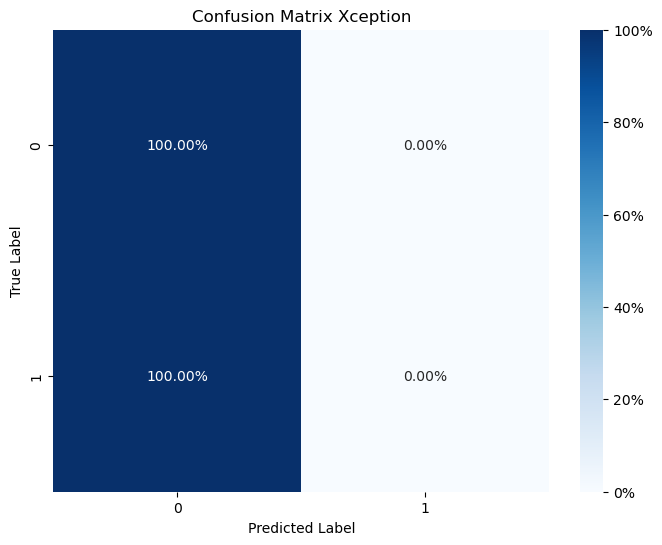

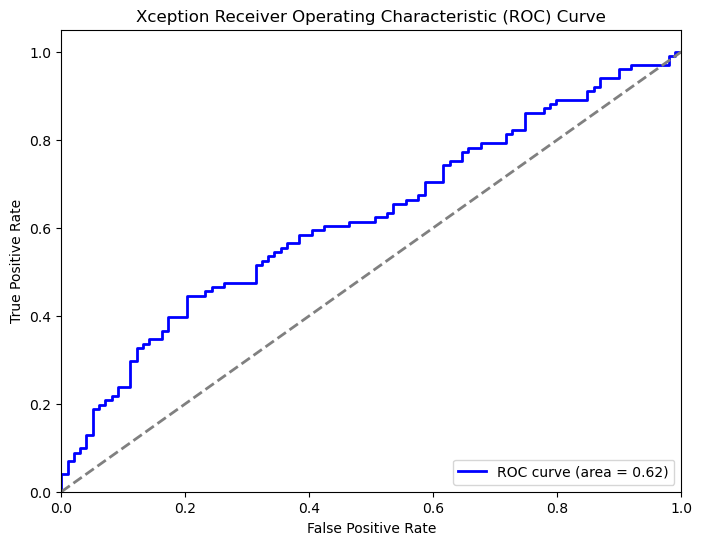

In [15]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, roc_curve

# Assuming you have your test data prepared and stored in X_test and y_test_1d

# Step 7: Evaluate the model
y_pred = Xception_model.predict(X_test)

# Convert probabilities to binary predictions (0 or 1)
y_pred_binary = np.where(y_pred > 0.5, 1, 0)

# Print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred_binary))

# Calculate ROC AUC score
roc_auc = roc_auc_score(y_test, y_pred)
print(f"ROC AUC Score: {roc_auc}")

# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred_binary)

# Normalize confusion matrix to percentages
cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

# Plot confusion matrix with percentages
plt.figure(figsize=(8, 6))
ax = sns.heatmap(cm_percentage, annot=True, fmt=".2f", cmap='Blues', cbar_kws={'format': '%.0f%%'})

# Annotate the heatmap with percentage signs
for t in ax.texts: 
    t.set_text(t.get_text() + "%")

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix Xception')
plt.show()

# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Xception Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

### Xception 1 %

In [16]:
import tensorflow as tf
from tensorflow.keras.applications import Xception
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

# Step 1: Load pre-trained ResNet50 model
Xception_model = Xception(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Step 2: Freeze the base model
for layer in Xception_model.layers:
    layer.trainable = False

# Step 3: Add custom layers for binary classification
x = Xception_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)  # Add a fully connected layer with 1024 units
predictions = Dense(1, activation='sigmoid')(x)  # Binary classification layer

# Step 4: Create the new model
Xception_model = Model(inputs=Xception_model.input, outputs=predictions)

# Step 5: Compile the model
Xception_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

early_stopping = tf.keras.callbacks.EarlyStopping(monitor="loss", patience=5, restore_best_weights=True)
# Assuming train_data and validation_data are your datasets
# Step 6: Train the model
Xception_history_1_percent = Xception_model.fit(X_train_1_percent,
                            y_train_1_percent,
                            validation_split=0.2, 
                            epochs=50,
                            batch_size = 64,
                            callbacks=[early_stopping] 
          )

Epoch 1/50
1/1 [==============================] - 25s 25s/step - loss: 7.4488 - accuracy: 0.5714 - val_loss: 73.5537 - val_accuracy: 0.7500
Epoch 2/50
1/1 [==============================] - 5s 5s/step - loss: 190.8760 - accuracy: 0.4286 - val_loss: 54.6903 - val_accuracy: 0.7500
Epoch 3/50
1/1 [==============================] - 5s 5s/step - loss: 141.4082 - accuracy: 0.4286 - val_loss: 17.1722 - val_accuracy: 0.7500
Epoch 4/50
1/1 [==============================] - 8s 8s/step - loss: 45.0426 - accuracy: 0.4286 - val_loss: 74.7915 - val_accuracy: 0.2500
Epoch 5/50
1/1 [==============================] - 6s 6s/step - loss: 36.9813 - accuracy: 0.5714 - val_loss: 138.2069 - val_accuracy: 0.2500
Epoch 6/50
1/1 [==============================] - 6s 6s/step - loss: 71.9903 - accuracy: 0.5714 - val_loss: 151.4787 - val_accuracy: 0.2500


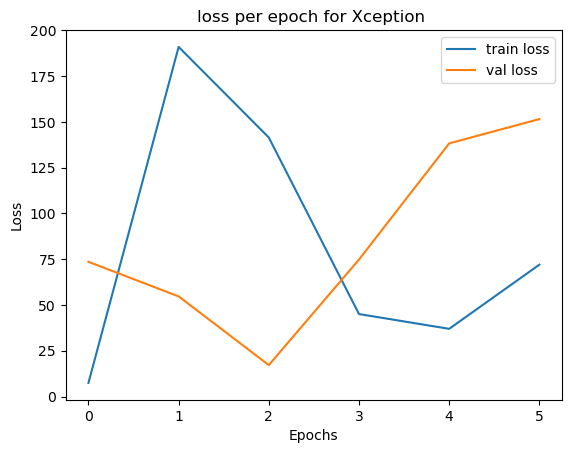

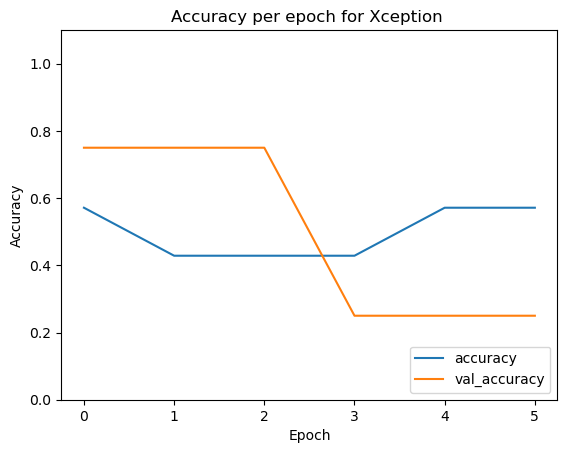

In [17]:
plt.plot(Xception_history_1_percent.history['loss'], label='train loss')
plt.plot(Xception_history_1_percent.history['val_loss'], label='val loss')
plt.title('loss per epoch for Xception ')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
plt.savefig('loss per epoch for Xception' , dpi=100)


plt.plot(Xception_history_1_percent.history['accuracy'], label='accuracy')
plt.plot(Xception_history_1_percent.history['val_accuracy'], label = 'val_accuracy')
plt.title('Accuracy per epoch for Xception ')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.0, 1.1])
plt.legend(loc='lower right')
plt.savefig('accuracy per epoch for Xception' , dpi=100)

7/7 [==============================] - 59s 8s/step
Classification Report:
              precision    recall  f1-score   support

           0       0.49      1.00      0.66        99
           1       0.00      0.00      0.00       101

    accuracy                           0.49       200
   macro avg       0.25      0.50      0.33       200
weighted avg       0.25      0.49      0.33       200

ROC AUC Score: 0.5


c:\Users\Ahmad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Ahmad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Ahmad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


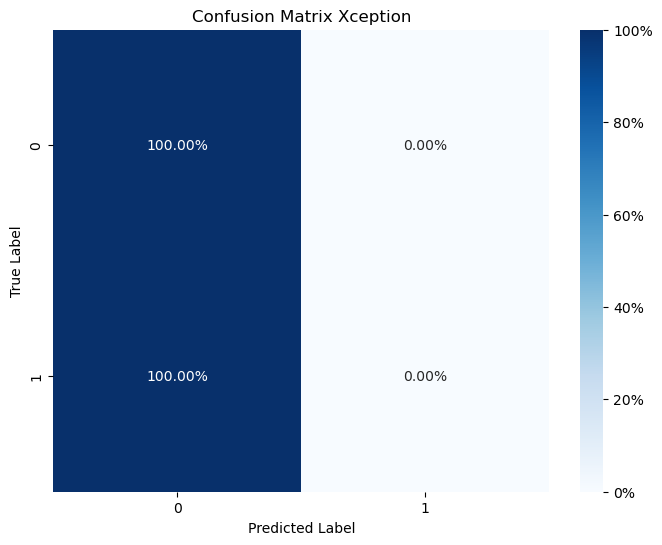

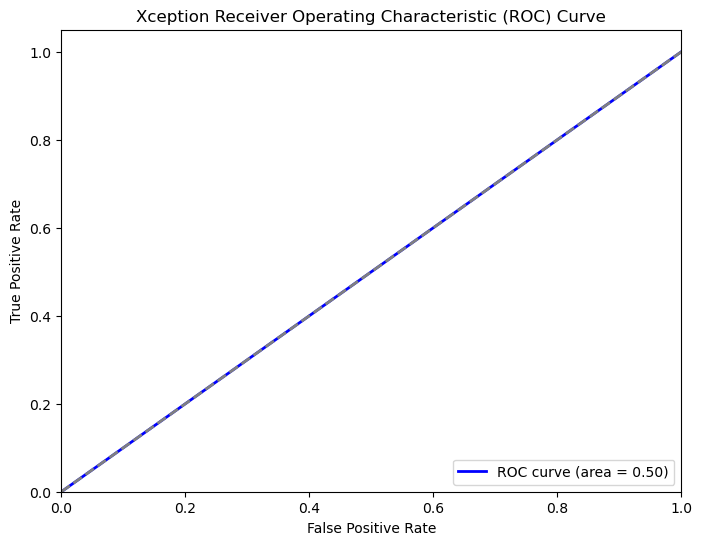

In [18]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, roc_curve

# Assuming you have your test data prepared and stored in X_test and y_test_1d

# Step 7: Evaluate the model
y_pred = Xception_model.predict(X_test)

# Convert probabilities to binary predictions (0 or 1)
y_pred_binary = np.where(y_pred > 0.5, 1, 0)

# Print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred_binary))

# Calculate ROC AUC score
roc_auc = roc_auc_score(y_test, y_pred)
print(f"ROC AUC Score: {roc_auc}")

# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred_binary)

# Normalize confusion matrix to percentages
cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

# Plot confusion matrix with percentages
plt.figure(figsize=(8, 6))
ax = sns.heatmap(cm_percentage, annot=True, fmt=".2f", cmap='Blues', cbar_kws={'format': '%.0f%%'})

# Annotate the heatmap with percentage signs
for t in ax.texts: 
    t.set_text(t.get_text() + "%")

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix Xception')
plt.show()

# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Xception Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

### Xception 10%

In [19]:
import tensorflow as tf
from tensorflow.keras.applications import Xception
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

# Step 1: Load pre-trained ResNet50 model
Xception_model = Xception(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Step 2: Freeze the base model
for layer in Xception_model.layers:
    layer.trainable = False

# Step 3: Add custom layers for binary classification
x = Xception_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)  # Add a fully connected layer with 1024 units
predictions = Dense(1, activation='sigmoid')(x)  # Binary classification layer

# Step 4: Create the new model
Xception_model = Model(inputs=Xception_model.input, outputs=predictions)

# Step 5: Compile the model
Xception_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

early_stopping = tf.keras.callbacks.EarlyStopping(monitor="loss", patience=5, restore_best_weights=True)
# Assuming train_data and validation_data are your datasets
# Step 6: Train the model
Xception_history_10_percent = Xception_model.fit(X_train_10_percent,
                            y_train_10_percent,
                            validation_split=0.2, 
                            epochs=50,
                            batch_size = 64,
                            callbacks=[early_stopping] 
          )

Epoch 1/50
3/3 [==============================] - 53s 17s/step - loss: 97.8442 - accuracy: 0.5347 - val_loss: 51.1102 - val_accuracy: 0.5000
Epoch 2/50
3/3 [==============================] - 47s 16s/step - loss: 51.2065 - accuracy: 0.5000 - val_loss: 61.4497 - val_accuracy: 0.5000
Epoch 3/50
3/3 [==============================] - 43s 14s/step - loss: 39.9647 - accuracy: 0.5000 - val_loss: 39.8697 - val_accuracy: 0.5000
Epoch 4/50
3/3 [==============================] - 43s 13s/step - loss: 38.6823 - accuracy: 0.5000 - val_loss: 13.7495 - val_accuracy: 0.5000
Epoch 5/50
3/3 [==============================] - 28s 10s/step - loss: 19.3994 - accuracy: 0.5000 - val_loss: 12.1699 - val_accuracy: 0.5000
Epoch 6/50
3/3 [==============================] - 27s 9s/step - loss: 10.1139 - accuracy: 0.5625 - val_loss: 14.0372 - val_accuracy: 0.5000
Epoch 7/50
3/3 [==============================] - 28s 9s/step - loss: 9.0282 - accuracy: 0.5694 - val_loss: 19.0964 - val_accuracy: 0.5000
Epoch 8/50
3/3 [

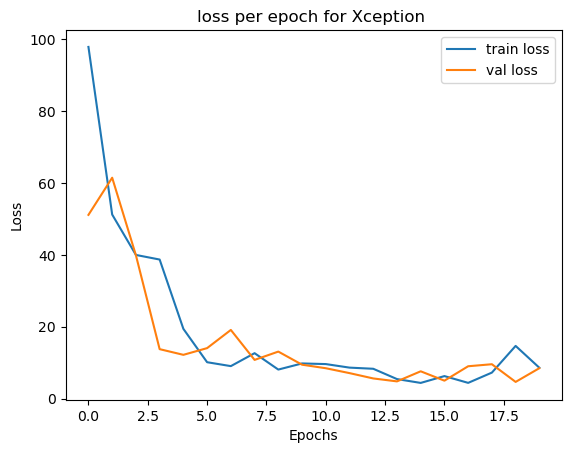

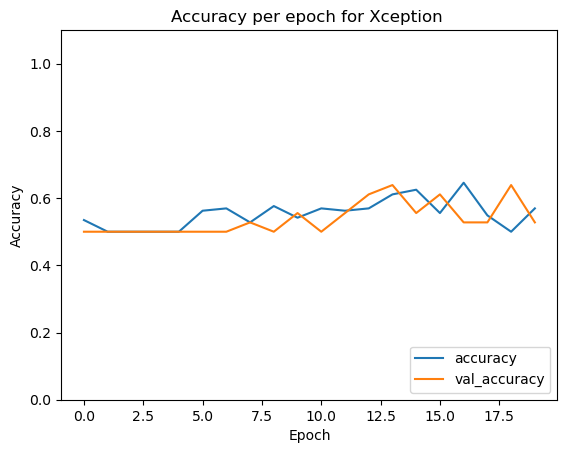

In [20]:
plt.plot(Xception_history_10_percent.history['loss'], label='train loss')
plt.plot(Xception_history_10_percent.history['val_loss'], label='val loss')
plt.title('loss per epoch for Xception ')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
plt.savefig('loss per epoch for Xception' , dpi=100)


plt.plot(Xception_history_10_percent.history['accuracy'], label='accuracy')
plt.plot(Xception_history_10_percent.history['val_accuracy'], label = 'val_accuracy')
plt.title('Accuracy per epoch for Xception ')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.0, 1.1])
plt.legend(loc='lower right')
plt.savefig('accuracy per epoch for Xception' , dpi=100)

7/7 [==============================] - 37s 5s/step
Classification Report:
              precision    recall  f1-score   support

           0       0.59      0.16      0.25        99
           1       0.52      0.89      0.66       101

    accuracy                           0.53       200
   macro avg       0.56      0.53      0.46       200
weighted avg       0.56      0.53      0.46       200

ROC AUC Score: 0.6483148314831484


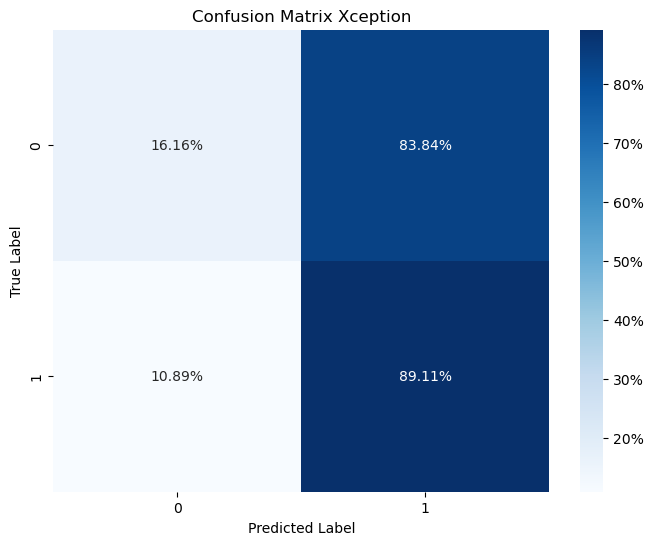

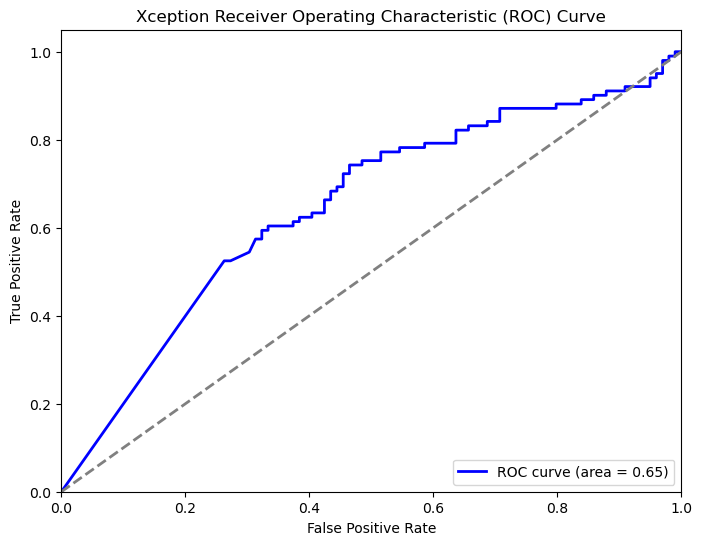

In [21]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, roc_curve

# Assuming you have your test data prepared and stored in X_test and y_test_1d

# Step 7: Evaluate the model
y_pred = Xception_model.predict(X_test)

# Convert probabilities to binary predictions (0 or 1)
y_pred_binary = np.where(y_pred > 0.5, 1, 0)

# Print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred_binary))

# Calculate ROC AUC score
roc_auc = roc_auc_score(y_test, y_pred)
print(f"ROC AUC Score: {roc_auc}")

# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred_binary)

# Normalize confusion matrix to percentages
cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

# Plot confusion matrix with percentages
plt.figure(figsize=(8, 6))
ax = sns.heatmap(cm_percentage, annot=True, fmt=".2f", cmap='Blues', cbar_kws={'format': '%.0f%%'})

# Annotate the heatmap with percentage signs
for t in ax.texts: 
    t.set_text(t.get_text() + "%")

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix Xception')
plt.show()

# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Xception Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

### Xception 20%

In [22]:
import tensorflow as tf
from tensorflow.keras.applications import Xception
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

# Step 1: Load pre-trained ResNet50 model
Xception_model = Xception(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Step 2: Freeze the base model
for layer in Xception_model.layers:
    layer.trainable = False

# Step 3: Add custom layers for binary classification
x = Xception_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)  # Add a fully connected layer with 1024 units
predictions = Dense(1, activation='sigmoid')(x)  # Binary classification layer

# Step 4: Create the new model
Xception_model = Model(inputs=Xception_model.input, outputs=predictions)

# Step 5: Compile the model
Xception_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

early_stopping = tf.keras.callbacks.EarlyStopping(monitor="loss", patience=5, restore_best_weights=True)
# Assuming train_data and validation_data are your datasets
# Step 6: Train the model
Xception_history_20_percent = Xception_model.fit(X_train_20_percent,
                            y_train_20_percent,
                            validation_split=0.2, 
                            epochs=50,
                            batch_size = 64,
                            callbacks=[early_stopping] 
          )

Epoch 1/50
5/5 [==============================] - 74s 13s/step - loss: 73.9182 - accuracy: 0.4757 - val_loss: 7.8603 - val_accuracy: 0.5278
Epoch 2/50
5/5 [==============================] - 56s 12s/step - loss: 18.1183 - accuracy: 0.5347 - val_loss: 17.5541 - val_accuracy: 0.4722
Epoch 3/50
5/5 [==============================] - 56s 12s/step - loss: 10.6154 - accuracy: 0.5694 - val_loss: 17.5283 - val_accuracy: 0.4861
Epoch 4/50
5/5 [==============================] - 56s 11s/step - loss: 10.1686 - accuracy: 0.5833 - val_loss: 13.6146 - val_accuracy: 0.5417
Epoch 5/50
5/5 [==============================] - 57s 12s/step - loss: 9.7467 - accuracy: 0.5486 - val_loss: 8.2964 - val_accuracy: 0.6111
Epoch 6/50
5/5 [==============================] - 56s 12s/step - loss: 8.3128 - accuracy: 0.5625 - val_loss: 4.6367 - val_accuracy: 0.5556
Epoch 7/50
5/5 [==============================] - 56s 12s/step - loss: 9.1388 - accuracy: 0.5451 - val_loss: 13.9936 - val_accuracy: 0.5139
Epoch 8/50
5/5 [===

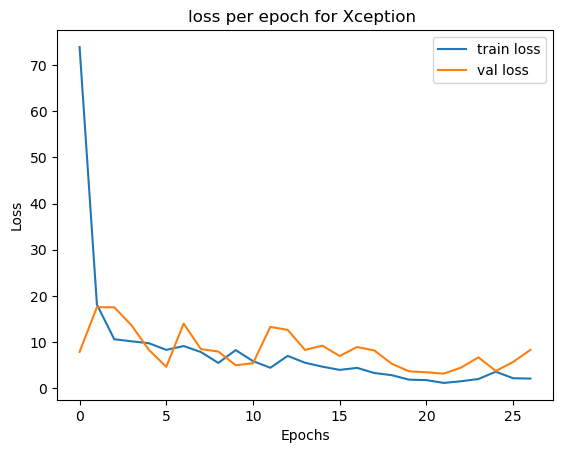

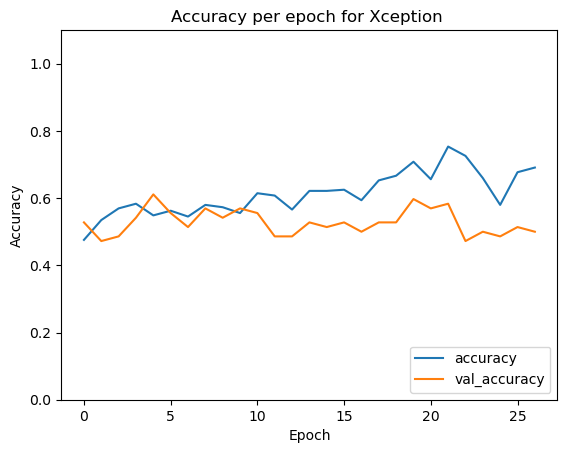

In [23]:
plt.plot(Xception_history_20_percent.history['loss'], label='train loss')
plt.plot(Xception_history_20_percent.history['val_loss'], label='val loss')
plt.title('loss per epoch for Xception ')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
plt.savefig('loss per epoch for Xception' , dpi=100)


plt.plot(Xception_history_20_percent.history['accuracy'], label='accuracy')
plt.plot(Xception_history_20_percent.history['val_accuracy'], label = 'val_accuracy')
plt.title('Accuracy per epoch for Xception ')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.0, 1.1])
plt.legend(loc='lower right')
plt.savefig('accuracy per epoch for Xception' , dpi=100)

7/7 [==============================] - 37s 5s/step
Classification Report:
              precision    recall  f1-score   support

           0       0.65      0.60      0.62        99
           1       0.63      0.68      0.66       101

    accuracy                           0.64       200
   macro avg       0.64      0.64      0.64       200
weighted avg       0.64      0.64      0.64       200

ROC AUC Score: 0.6466146614661468


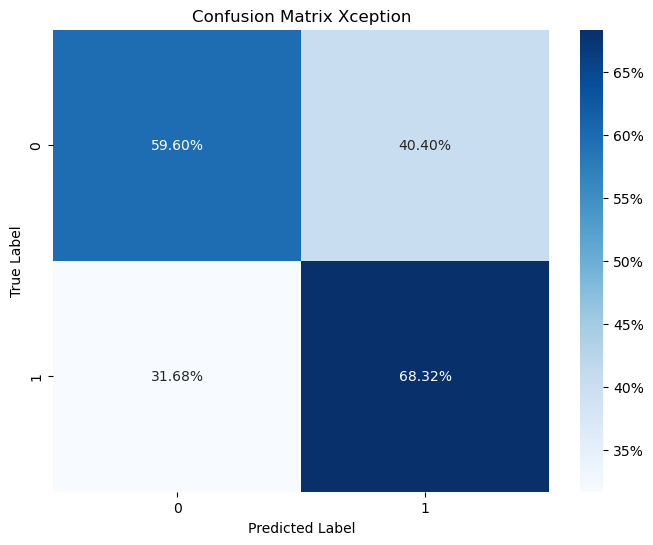

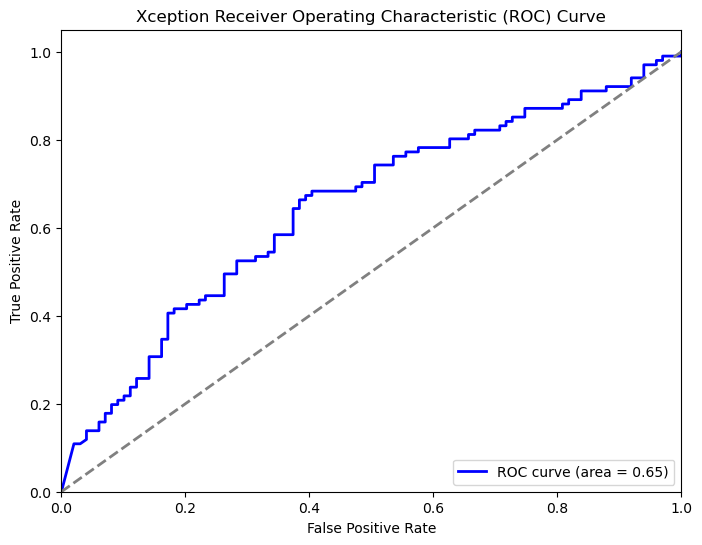

In [24]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, roc_curve

# Assuming you have your test data prepared and stored in X_test and y_test_1d

# Step 7: Evaluate the model
y_pred = Xception_model.predict(X_test)

# Convert probabilities to binary predictions (0 or 1)
y_pred_binary = np.where(y_pred > 0.5, 1, 0)

# Print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred_binary))

# Calculate ROC AUC score
roc_auc = roc_auc_score(y_test, y_pred)
print(f"ROC AUC Score: {roc_auc}")

# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred_binary)

# Normalize confusion matrix to percentages
cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

# Plot confusion matrix with percentages
plt.figure(figsize=(8, 6))
ax = sns.heatmap(cm_percentage, annot=True, fmt=".2f", cmap='Blues', cbar_kws={'format': '%.0f%%'})

# Annotate the heatmap with percentage signs
for t in ax.texts: 
    t.set_text(t.get_text() + "%")

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix Xception')
plt.show()

# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Xception Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# MobileNet linear evaluation

In [12]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

# Step 1: Load pre-trained ResNet50 model
MobileNet_model = MobileNet(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Step 2: Freeze the base model
for layer in MobileNet_model.layers:
    layer.trainable = False

# Step 3: Add custom layers for binary classification
x = MobileNet_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)  # Add a fully connected layer with 1024 units
predictions = Dense(1, activation='sigmoid')(x)  # Binary classification layer

# Step 4: Create the new model
MobileNet_model = Model(inputs=MobileNet_model.input, outputs=predictions)

# Step 5: Compile the model
MobileNet_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

early_stopping = tf.keras.callbacks.EarlyStopping(monitor="loss", patience=5, restore_best_weights=True)
# Assuming train_data and validation_data are your datasets
# Step 6: Train the model
MobileNet_history = MobileNet_model.fit(X_train,
                            y_train,
                            validation_split=0.2, 
                            epochs=50,
                            batch_size = 32,
                            callbacks=[early_stopping] 
          )

Epoch 1/50
180/180 [==============================] - 284s 2s/step - loss: 0.4843 - accuracy: 0.7703 - val_loss: 0.3148 - val_accuracy: 0.9028
Epoch 2/50
180/180 [==============================] - 280s 2s/step - loss: 0.3131 - accuracy: 0.8670 - val_loss: 0.3153 - val_accuracy: 0.8514
Epoch 3/50
180/180 [==============================] - 283s 2s/step - loss: 0.2124 - accuracy: 0.9189 - val_loss: 0.1883 - val_accuracy: 0.9312
Epoch 4/50
180/180 [==============================] - 277s 2s/step - loss: 0.1785 - accuracy: 0.9326 - val_loss: 0.1795 - val_accuracy: 0.9333
Epoch 5/50
180/180 [==============================] - 284s 2s/step - loss: 0.1462 - accuracy: 0.9448 - val_loss: 0.1559 - val_accuracy: 0.9389
Epoch 6/50
180/180 [==============================] - 279s 2s/step - loss: 0.1358 - accuracy: 0.9462 - val_loss: 0.1607 - val_accuracy: 0.9389
Epoch 7/50
180/180 [==============================] - 301s 2s/step - loss: 0.1231 - accuracy: 0.9514 - val_loss: 0.1462 - val_accuracy: 0.9458

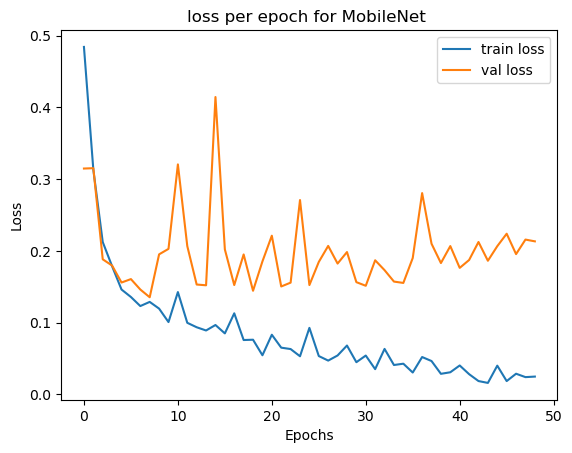

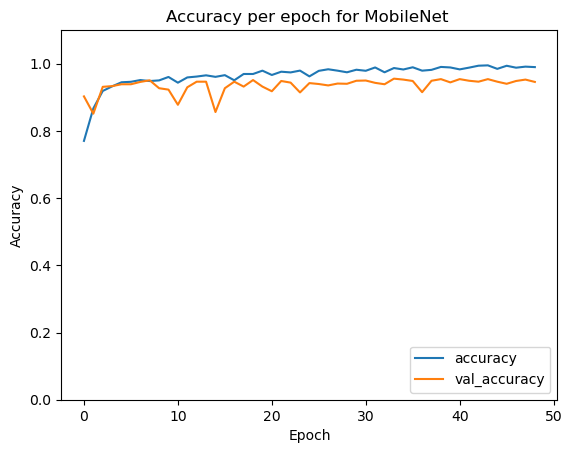

In [13]:
plt.plot(MobileNet_history.history['loss'], label='train loss')
plt.plot(MobileNet_history.history['val_loss'], label='val loss')
plt.title('loss per epoch for MobileNet ')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
plt.savefig('loss per epoch for MobileNet' , dpi=100)


plt.plot(MobileNet_history.history['accuracy'], label='accuracy')
plt.plot(MobileNet_history.history['val_accuracy'], label = 'val_accuracy')
plt.title('Accuracy per epoch for MobileNet ')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.0, 1.1])
plt.legend(loc='lower right')
plt.savefig('accuracy per epoch for MobileNet' , dpi=100)

In [14]:
MobileNet_result = MobileNet_model.evaluate(
    X_test, 
    y_test, 
    batch_size = 64, 
    verbose = 0
    )
print('The MobileNet error is: %.2f%%'%(100 - MobileNet_result[1]*100))

The MobileNet error is: 3.75%


In [15]:
test_loss_MobileNet, test_accuracy_MobileNet = MobileNet_model.evaluate(
    X_test, 
    y_test, 
    batch_size = 64, 
    verbose = 0
    )
print(f'Test Loss : {test_loss_MobileNet:.4f}')
print(f'Test Accuracy: {test_accuracy_MobileNet:.4f}')

Test Loss : 0.1158
Test Accuracy: 0.9625


25/25 [==============================] - 28s 1s/step
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.96      0.96       412
           1       0.96      0.96      0.96       388

    accuracy                           0.96       800
   macro avg       0.96      0.96      0.96       800
weighted avg       0.96      0.96      0.96       800

ROC AUC Score: 0.9945513462115905


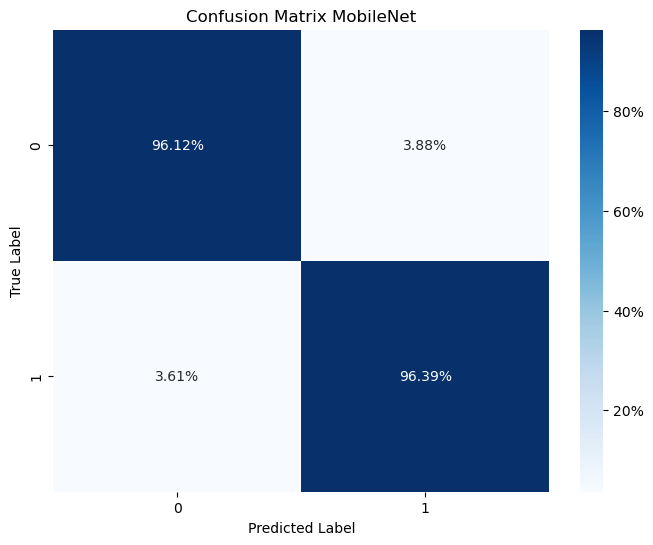

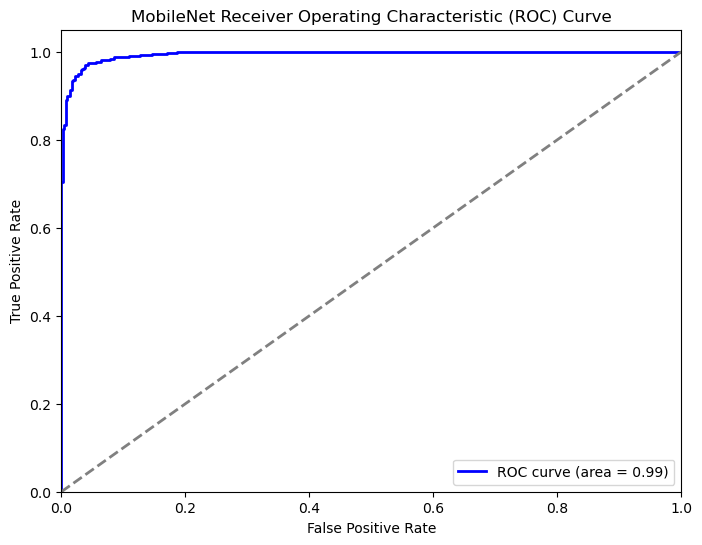

In [16]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, roc_curve

# Assuming you have your test data prepared and stored in X_test and y_test_1d

# Step 7: Evaluate the model
y_pred = MobileNet_model.predict(X_test)

# Convert probabilities to binary predictions (0 or 1)
y_pred_binary = np.where(y_pred > 0.5, 1, 0)

# Print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred_binary))

# Calculate ROC AUC score
roc_auc = roc_auc_score(y_test, y_pred)
print(f"ROC AUC Score: {roc_auc}")

# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred_binary)

# Normalize confusion matrix to percentages
cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

# Plot confusion matrix with percentages
plt.figure(figsize=(8, 6))
ax = sns.heatmap(cm_percentage, annot=True, fmt=".2f", cmap='Blues', cbar_kws={'format': '%.0f%%'})

# Annotate the heatmap with percentage signs
for t in ax.texts: 
    t.set_text(t.get_text() + "%")

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix MobileNet')
plt.show()

# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('MobileNet Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

### Mobilenet 1%

In [18]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

# Step 1: Load pre-trained ResNet50 model
MobileNet_model = MobileNet(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Step 2: Freeze the base model
for layer in MobileNet_model.layers:
    layer.trainable = False

# Step 3: Add custom layers for binary classification
x = MobileNet_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)  # Add a fully connected layer with 1024 units
predictions = Dense(1, activation='sigmoid')(x)  # Binary classification layer

# Step 4: Create the new model
MobileNet_model = Model(inputs=MobileNet_model.input, outputs=predictions)

# Step 5: Compile the model
MobileNet_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

early_stopping = tf.keras.callbacks.EarlyStopping(monitor="loss", patience=5, restore_best_weights=True)
# Assuming train_data and validation_data are your datasets
# Step 6: Train the model
MobileNet_history_1_percent = MobileNet_model.fit(X_train_1_percent,
                            y_train_1_percent,
                            validation_split=0.2, 
                            epochs=50,
                            batch_size = 32,
                            callbacks=[early_stopping] 
          )

Epoch 1/50
2/2 [==============================] - 10s 4s/step - loss: 0.5545 - accuracy: 0.7544 - val_loss: 1.3066 - val_accuracy: 0.6000
Epoch 2/50
2/2 [==============================] - 3s 1s/step - loss: 0.5278 - accuracy: 0.7719 - val_loss: 0.6787 - val_accuracy: 0.8000
Epoch 3/50
2/2 [==============================] - 5s 3s/step - loss: 0.2984 - accuracy: 0.8421 - val_loss: 0.8244 - val_accuracy: 0.7333
Epoch 4/50
2/2 [==============================] - 4s 3s/step - loss: 0.2661 - accuracy: 0.8772 - val_loss: 0.6154 - val_accuracy: 0.8000
Epoch 5/50
2/2 [==============================] - 3s 2s/step - loss: 0.2193 - accuracy: 0.9298 - val_loss: 0.6895 - val_accuracy: 0.7333
Epoch 6/50
2/2 [==============================] - 3s 2s/step - loss: 0.1617 - accuracy: 0.9123 - val_loss: 0.5742 - val_accuracy: 0.8000
Epoch 7/50
2/2 [==============================] - 4s 2s/step - loss: 0.1240 - accuracy: 0.9825 - val_loss: 0.5764 - val_accuracy: 0.8000
Epoch 8/50
2/2 [========================

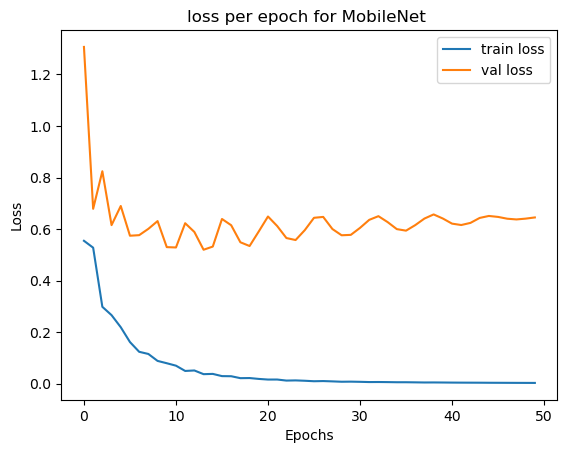

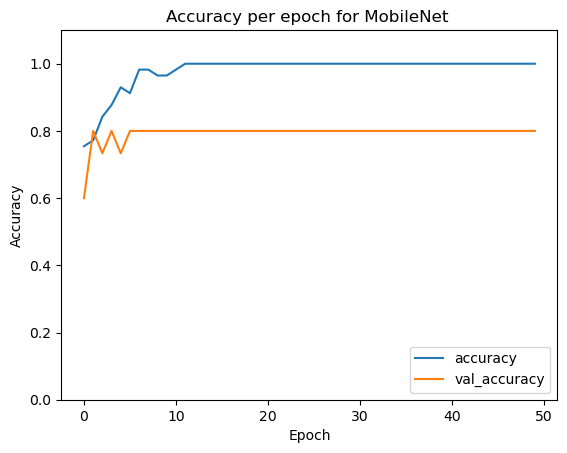

In [19]:
plt.plot(MobileNet_history_1_percent.history['loss'], label='train loss')
plt.plot(MobileNet_history_1_percent.history['val_loss'], label='val loss')
plt.title('loss per epoch for MobileNet ')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
plt.savefig('loss per epoch for MobileNet' , dpi=100)


plt.plot(MobileNet_history_1_percent.history['accuracy'], label='accuracy')
plt.plot(MobileNet_history_1_percent.history['val_accuracy'], label = 'val_accuracy')
plt.title('Accuracy per epoch for MobileNet ')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.0, 1.1])
plt.legend(loc='lower right')
plt.savefig('accuracy per epoch for MobileNet' , dpi=100)

25/25 [==============================] - 57s 1s/step
Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.79      0.73       412
           1       0.73      0.62      0.67       388

    accuracy                           0.71       800
   macro avg       0.71      0.70      0.70       800
weighted avg       0.71      0.71      0.70       800

ROC AUC Score: 0.7615041036933241


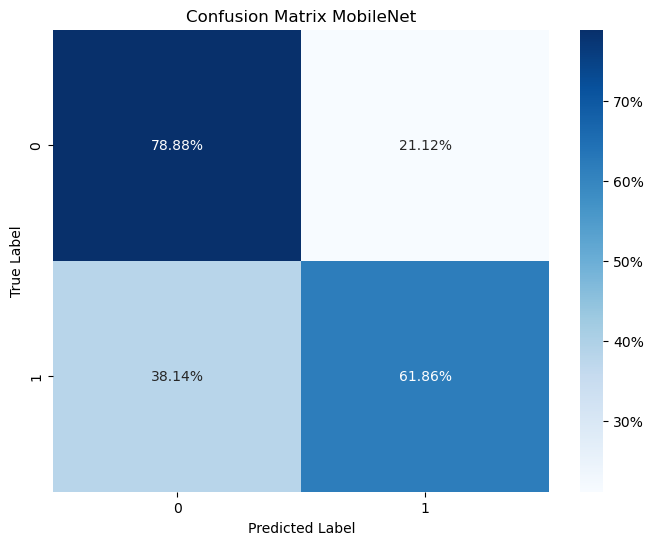

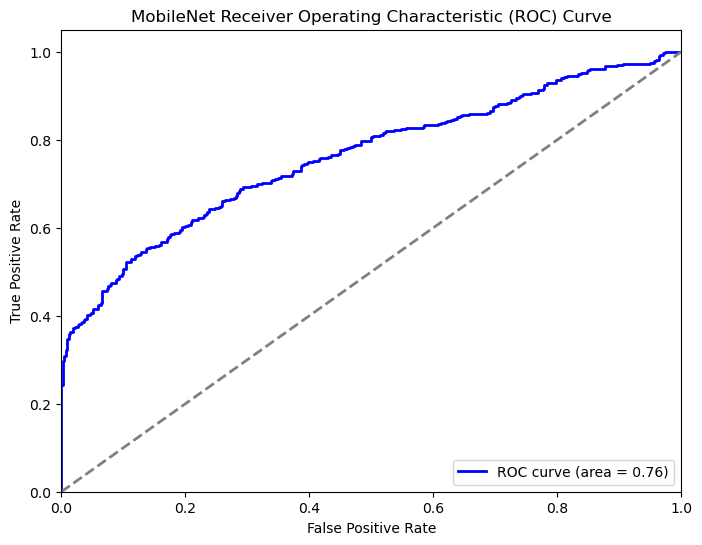

In [20]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, roc_curve

# Assuming you have your test data prepared and stored in X_test and y_test_1d

# Step 7: Evaluate the model
y_pred = MobileNet_model.predict(X_test)

# Convert probabilities to binary predictions (0 or 1)
y_pred_binary = np.where(y_pred > 0.5, 1, 0)

# Print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred_binary))

# Calculate ROC AUC score
roc_auc = roc_auc_score(y_test, y_pred)
print(f"ROC AUC Score: {roc_auc}")

# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred_binary)

# Normalize confusion matrix to percentages
cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

# Plot confusion matrix with percentages
plt.figure(figsize=(8, 6))
ax = sns.heatmap(cm_percentage, annot=True, fmt=".2f", cmap='Blues', cbar_kws={'format': '%.0f%%'})

# Annotate the heatmap with percentage signs
for t in ax.texts: 
    t.set_text(t.get_text() + "%")

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix MobileNet')
plt.show()

# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('MobileNet Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

### Mobilenet 10%

In [21]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

# Step 1: Load pre-trained ResNet50 model
MobileNet_model = MobileNet(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Step 2: Freeze the base model
for layer in MobileNet_model.layers:
    layer.trainable = False

# Step 3: Add custom layers for binary classification
x = MobileNet_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)  # Add a fully connected layer with 1024 units
predictions = Dense(1, activation='sigmoid')(x)  # Binary classification layer

# Step 4: Create the new model
MobileNet_model = Model(inputs=MobileNet_model.input, outputs=predictions)

# Step 5: Compile the model
MobileNet_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

early_stopping = tf.keras.callbacks.EarlyStopping(monitor="loss", patience=5, restore_best_weights=True)
# Assuming train_data and validation_data are your datasets
# Step 6: Train the model
MobileNet_history_10_percent = MobileNet_model.fit(X_train_10_percent,
                            y_train_10_percent,
                            validation_split=0.2, 
                            epochs=50,
                            batch_size = 32,
                            callbacks=[early_stopping] 
          )

Epoch 1/50
18/18 [==============================] - 40s 2s/step - loss: 0.6836 - accuracy: 0.6736 - val_loss: 0.5414 - val_accuracy: 0.6528
Epoch 2/50
18/18 [==============================] - 28s 2s/step - loss: 0.4340 - accuracy: 0.7969 - val_loss: 0.4456 - val_accuracy: 0.7917
Epoch 3/50
18/18 [==============================] - 27s 2s/step - loss: 0.4052 - accuracy: 0.8247 - val_loss: 0.4205 - val_accuracy: 0.7778
Epoch 4/50
18/18 [==============================] - 28s 2s/step - loss: 0.3289 - accuracy: 0.8594 - val_loss: 0.4208 - val_accuracy: 0.8056
Epoch 5/50
18/18 [==============================] - 28s 2s/step - loss: 0.3148 - accuracy: 0.8733 - val_loss: 0.4107 - val_accuracy: 0.7778
Epoch 6/50
18/18 [==============================] - 28s 2s/step - loss: 0.2810 - accuracy: 0.8802 - val_loss: 0.4098 - val_accuracy: 0.8125
Epoch 7/50
18/18 [==============================] - 28s 2s/step - loss: 0.2774 - accuracy: 0.8819 - val_loss: 0.5296 - val_accuracy: 0.7778
Epoch 8/50
18/18 [==

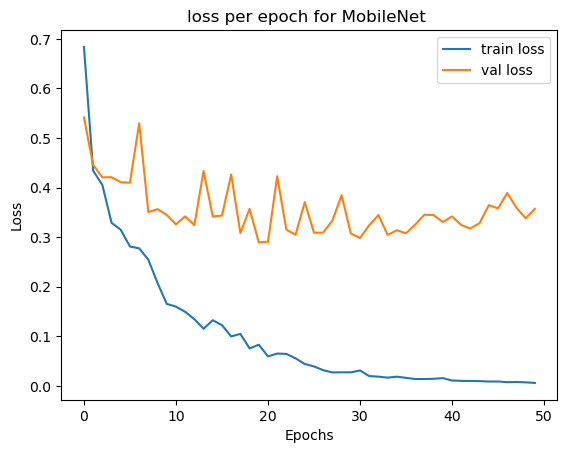

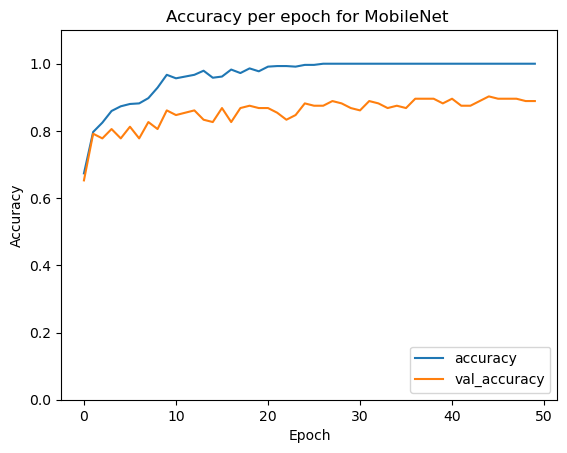

In [22]:
plt.plot(MobileNet_history_10_percent.history['loss'], label='train loss')
plt.plot(MobileNet_history_10_percent.history['val_loss'], label='val loss')
plt.title('loss per epoch for MobileNet ')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
plt.savefig('loss per epoch for MobileNet' , dpi=100)


plt.plot(MobileNet_history_10_percent.history['accuracy'], label='accuracy')
plt.plot(MobileNet_history_10_percent.history['val_accuracy'], label = 'val_accuracy')
plt.title('Accuracy per epoch for MobileNet ')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.0, 1.1])
plt.legend(loc='lower right')
plt.savefig('accuracy per epoch for MobileNet' , dpi=100)

25/25 [==============================] - 28s 1s/step
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.93      0.89       412
           1       0.92      0.85      0.88       388

    accuracy                           0.89       800
   macro avg       0.89      0.89      0.89       800
weighted avg       0.89      0.89      0.89       800

ROC AUC Score: 0.9607334100690621


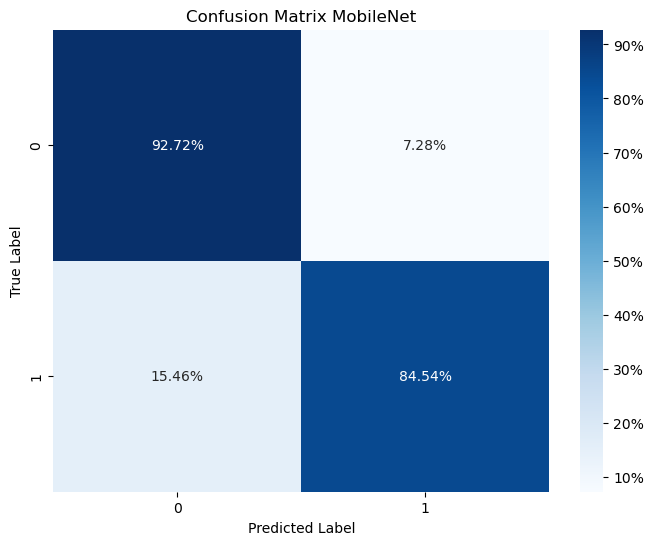

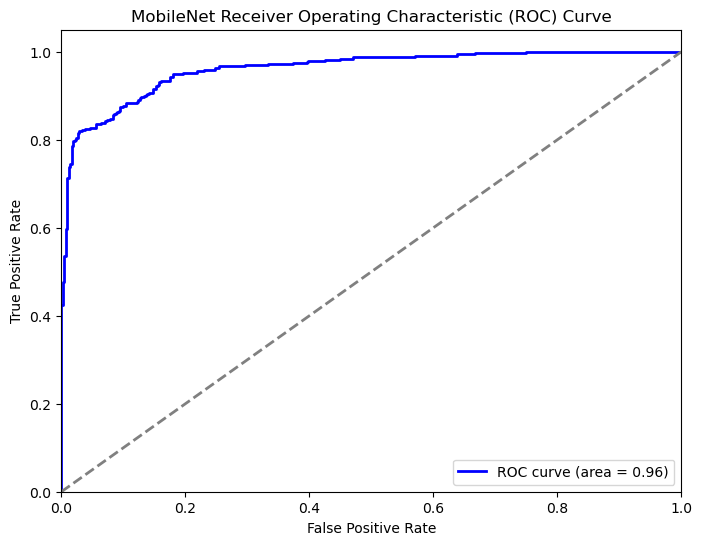

In [23]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, roc_curve

# Assuming you have your test data prepared and stored in X_test and y_test_1d

# Step 7: Evaluate the model
y_pred = MobileNet_model.predict(X_test)

# Convert probabilities to binary predictions (0 or 1)
y_pred_binary = np.where(y_pred > 0.5, 1, 0)

# Print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred_binary))

# Calculate ROC AUC score
roc_auc = roc_auc_score(y_test, y_pred)
print(f"ROC AUC Score: {roc_auc}")

# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred_binary)

# Normalize confusion matrix to percentages
cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

# Plot confusion matrix with percentages
plt.figure(figsize=(8, 6))
ax = sns.heatmap(cm_percentage, annot=True, fmt=".2f", cmap='Blues', cbar_kws={'format': '%.0f%%'})

# Annotate the heatmap with percentage signs
for t in ax.texts: 
    t.set_text(t.get_text() + "%")

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix MobileNet')
plt.show()

# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('MobileNet Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

### Mobilenet 20%

In [24]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

# Step 1: Load pre-trained ResNet50 model
MobileNet_model = MobileNet(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Step 2: Freeze the base model
for layer in MobileNet_model.layers:
    layer.trainable = False

# Step 3: Add custom layers for binary classification
x = MobileNet_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)  # Add a fully connected layer with 1024 units
predictions = Dense(1, activation='sigmoid')(x)  # Binary classification layer

# Step 4: Create the new model
MobileNet_model = Model(inputs=MobileNet_model.input, outputs=predictions)

# Step 5: Compile the model
MobileNet_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

early_stopping = tf.keras.callbacks.EarlyStopping(monitor="loss", patience=5, restore_best_weights=True)
# Assuming train_data and validation_data are your datasets
# Step 6: Train the model
MobileNet_history_20_percent = MobileNet_model.fit(X_train_20_percent,
                            y_train_20_percent,
                            validation_split=0.2, 
                            epochs=50,
                            batch_size = 32,
                            callbacks=[early_stopping] 
          )

Epoch 1/50
36/36 [==============================] - 52s 1s/step - loss: 0.7935 - accuracy: 0.6571 - val_loss: 0.5873 - val_accuracy: 0.6146
Epoch 2/50
36/36 [==============================] - 54s 2s/step - loss: 0.5073 - accuracy: 0.7396 - val_loss: 0.7609 - val_accuracy: 0.5382
Epoch 3/50
36/36 [==============================] - 56s 2s/step - loss: 0.5344 - accuracy: 0.7344 - val_loss: 0.4864 - val_accuracy: 0.7535
Epoch 4/50
36/36 [==============================] - 55s 2s/step - loss: 0.4053 - accuracy: 0.8125 - val_loss: 0.5194 - val_accuracy: 0.6840
Epoch 5/50
36/36 [==============================] - 58s 2s/step - loss: 0.3487 - accuracy: 0.8498 - val_loss: 0.3953 - val_accuracy: 0.7882
Epoch 6/50
36/36 [==============================] - 56s 2s/step - loss: 0.3265 - accuracy: 0.8594 - val_loss: 0.3666 - val_accuracy: 0.8229
Epoch 7/50
36/36 [==============================] - 63s 2s/step - loss: 0.2667 - accuracy: 0.9071 - val_loss: 0.3488 - val_accuracy: 0.8472
Epoch 8/50
36/36 [==

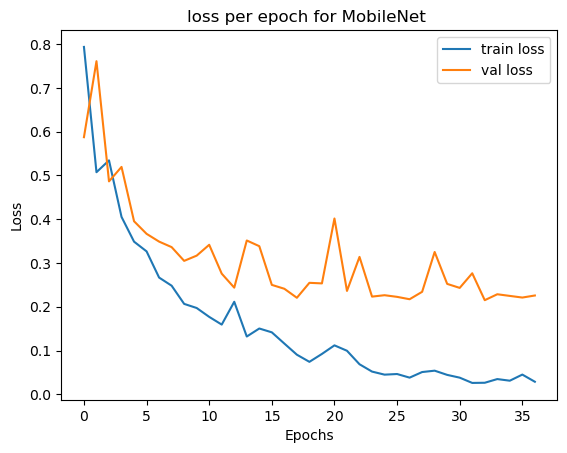

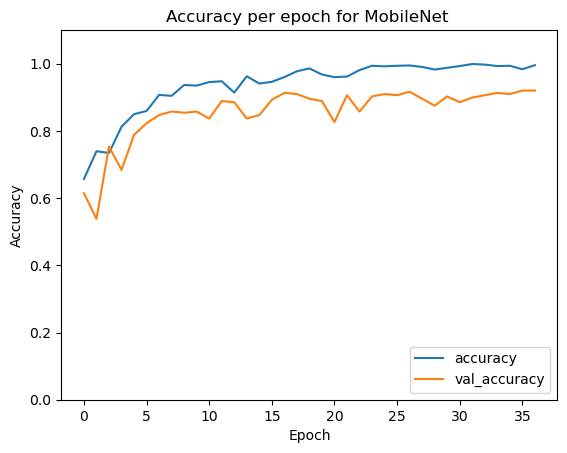

In [25]:
plt.plot(MobileNet_history_20_percent.history['loss'], label='train loss')
plt.plot(MobileNet_history_20_percent.history['val_loss'], label='val loss')
plt.title('loss per epoch for MobileNet ')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
plt.savefig('loss per epoch for MobileNet' , dpi=100)


plt.plot(MobileNet_history_20_percent.history['accuracy'], label='accuracy')
plt.plot(MobileNet_history_20_percent.history['val_accuracy'], label = 'val_accuracy')
plt.title('Accuracy per epoch for MobileNet ')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.0, 1.1])
plt.legend(loc='lower right')
plt.savefig('accuracy per epoch for MobileNet' , dpi=100)

25/25 [==============================] - 31s 1s/step
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.97      0.92       412
           1       0.96      0.86      0.91       388

    accuracy                           0.91       800
   macro avg       0.92      0.91      0.91       800
weighted avg       0.92      0.91      0.91       800

ROC AUC Score: 0.9719685216695025


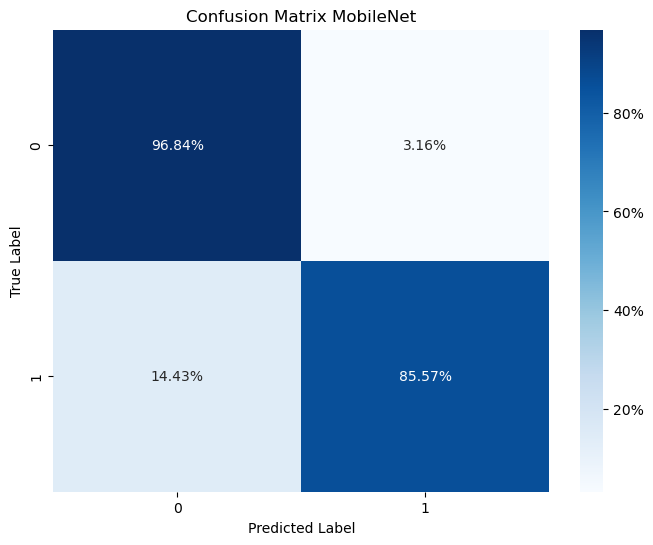

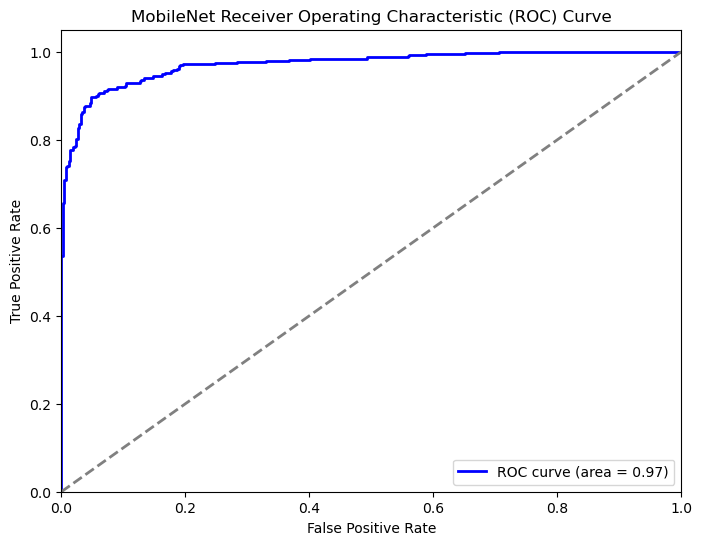

In [26]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, roc_curve

# Assuming you have your test data prepared and stored in X_test and y_test_1d

# Step 7: Evaluate the model
y_pred = MobileNet_model.predict(X_test)

# Convert probabilities to binary predictions (0 or 1)
y_pred_binary = np.where(y_pred > 0.5, 1, 0)

# Print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred_binary))

# Calculate ROC AUC score
roc_auc = roc_auc_score(y_test, y_pred)
print(f"ROC AUC Score: {roc_auc}")

# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred_binary)

# Normalize confusion matrix to percentages
cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

# Plot confusion matrix with percentages
plt.figure(figsize=(8, 6))
ax = sns.heatmap(cm_percentage, annot=True, fmt=".2f", cmap='Blues', cbar_kws={'format': '%.0f%%'})

# Annotate the heatmap with percentage signs
for t in ax.texts: 
    t.set_text(t.get_text() + "%")

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix MobileNet')
plt.show()

# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('MobileNet Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# ResNet50  linear evaluation

In [7]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

# Step 1: Load pre-trained ResNet50 model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Step 2: Freeze the base model
for layer in base_model.layers:
    layer.trainable = False

# Step 3: Add custom layers for binary classification
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)  # Add a fully connected layer with 1024 units
predictions = Dense(1, activation='sigmoid')(x)  # Binary classification layer

# Step 4: Create the new model
model = Model(inputs=base_model.input, outputs=predictions)

# Step 5: Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

early_stopping = tf.keras.callbacks.EarlyStopping(monitor="loss", patience=5, restore_best_weights=True)
# Assuming train_data and validation_data are your datasets
# Step 6: Train the model
ResNet_history = model.fit(X_train,
                            y_train,
                            validation_split=0.2, 
                            epochs=50,
                            batch_size = 32,
                            callbacks=[early_stopping] 
          )


Epoch 1/50
180/180 [==============================] - 969s 5s/step - loss: 0.6462 - accuracy: 0.6944 - val_loss: 0.5535 - val_accuracy: 0.7222
Epoch 2/50
180/180 [==============================] - 936s 5s/step - loss: 0.4994 - accuracy: 0.7510 - val_loss: 0.4993 - val_accuracy: 0.7542
Epoch 3/50
180/180 [==============================] - 943s 5s/step - loss: 0.4953 - accuracy: 0.7550 - val_loss: 0.4641 - val_accuracy: 0.7715
Epoch 4/50
180/180 [==============================] - 927s 5s/step - loss: 0.4600 - accuracy: 0.7814 - val_loss: 0.4525 - val_accuracy: 0.7778
Epoch 5/50
180/180 [==============================] - 938s 5s/step - loss: 0.4398 - accuracy: 0.7870 - val_loss: 0.4513 - val_accuracy: 0.7903
Epoch 6/50
180/180 [==============================] - 937s 5s/step - loss: 0.4558 - accuracy: 0.7753 - val_loss: 0.4373 - val_accuracy: 0.7944
Epoch 7/50
180/180 [==============================] - 931s 5s/step - loss: 0.4306 - accuracy: 0.7972 - val_loss: 0.4274 - val_accuracy: 0.7903

In [8]:
ResNet_result = model.evaluate(
    X_test, 
    y_test, 
    batch_size = 64, 
    verbose = 0
    )
print('The ResNet error is: %.2f%%'%(100 - ResNet_result[1]*100))

The ResNet error is: 16.37%


In [9]:
test_loss_ResNet, test_accuracy_ResNet = model.evaluate(
    X_test, 
    y_test, 
    batch_size = 64, 
    verbose = 0
    )
print(f'Test Loss : {test_loss_ResNet:.4f}')
print(f'Test Accuracy: {test_accuracy_ResNet:.4f}')

Test Loss : 0.5633
Test Accuracy: 0.8363


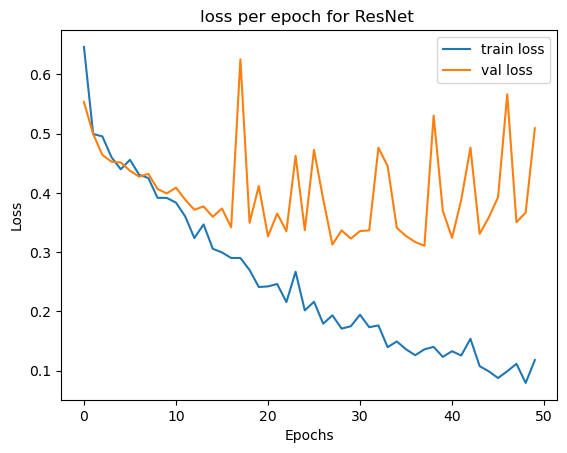

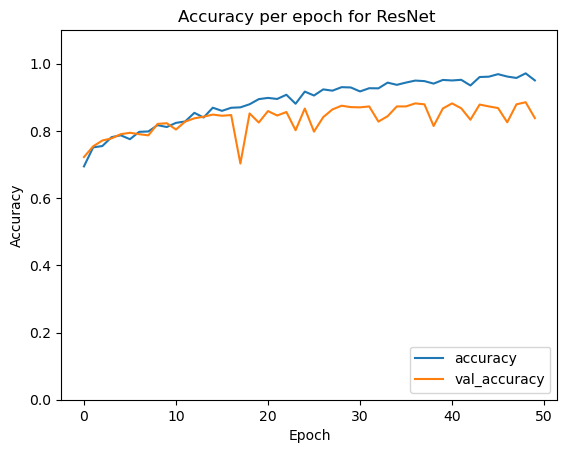

In [10]:
plt.plot(ResNet_history.history['loss'], label='train loss')
plt.plot(ResNet_history.history['val_loss'], label='val loss')
plt.title('loss per epoch for ResNet ')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
plt.savefig('loss per epoch for ResNet' , dpi=100)


plt.plot(ResNet_history.history['accuracy'], label='accuracy')
plt.plot(ResNet_history.history['val_accuracy'], label = 'val_accuracy')
plt.title('Accuracy per epoch for ResNet ')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.0, 1.1])
plt.legend(loc='lower right')
plt.savefig('accuracy per epoch for ResNet' , dpi=100)

25/25 [==============================] - 111s 4s/step
Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.98      0.86       412
           1       0.97      0.69      0.80       388

    accuracy                           0.84       800
   macro avg       0.87      0.83      0.83       800
weighted avg       0.86      0.84      0.83       800

ROC AUC Score: 0.9446689520568511


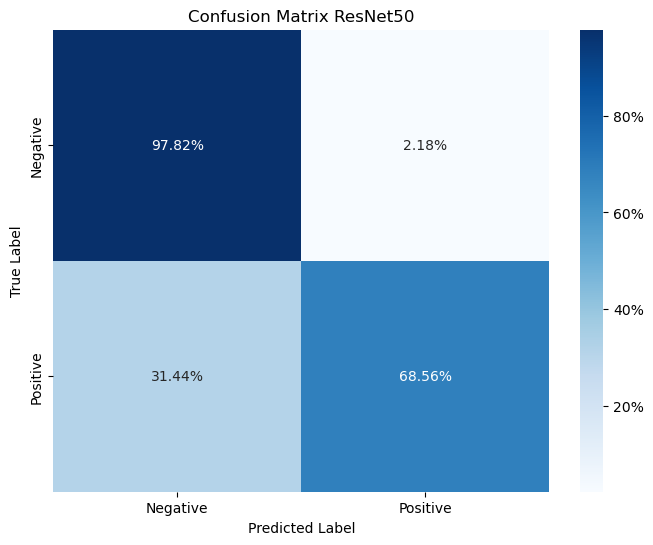

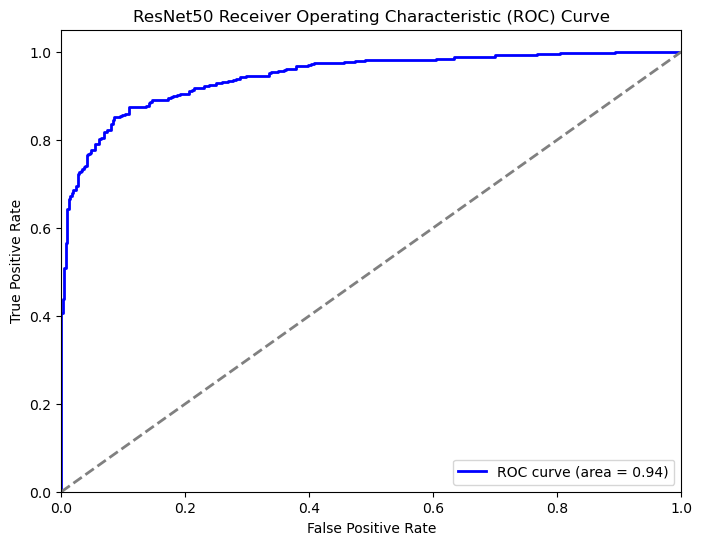

In [11]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, roc_curve

# Assuming you have your test data prepared and stored in X_test and y_test_1d

# Step 7: Evaluate the model
y_pred = model.predict(X_test)

# Convert probabilities to binary predictions (0 or 1)
y_pred_binary = np.where(y_pred > 0.5, 1, 0)

# Print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred_binary))

# Calculate ROC AUC score
roc_auc = roc_auc_score(y_test, y_pred)
print(f"ROC AUC Score: {roc_auc}")

# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred_binary)

# Normalize confusion matrix to percentages
cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

# Plot confusion matrix with percentages
plt.figure(figsize=(8, 6))
ax = sns.heatmap(cm_percentage, annot=True, fmt=".2f", cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'], cbar_kws={'format': '%.0f%%'})

# Annotate the heatmap with percentage signs
for t in ax.texts: 
    t.set_text(t.get_text() + "%")

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix ResNet50')
plt.show()

# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ResNet50 Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

### ResNet50 1%

In [27]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

# Step 1: Load pre-trained ResNet50 model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Step 2: Freeze the base model
for layer in base_model.layers:
    layer.trainable = False

# Step 3: Add custom layers for binary classification
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)  # Add a fully connected layer with 1024 units
predictions = Dense(1, activation='sigmoid')(x)  # Binary classification layer

# Step 4: Create the new model
model = Model(inputs=base_model.input, outputs=predictions)

# Step 5: Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

early_stopping = tf.keras.callbacks.EarlyStopping(monitor="loss", patience=5, restore_best_weights=True)
# Assuming train_data and validation_data are your datasets
# Step 6: Train the model
ResNet_history_1_percent = model.fit(X_train_1_percent,
                            y_train_1_percent,
                            validation_split=0.2, 
                            epochs=50,
                            batch_size = 32,
                            callbacks=[early_stopping] 
          )

Epoch 1/50
2/2 [==============================] - 29s 12s/step - loss: 1.8150 - accuracy: 0.4912 - val_loss: 3.9303 - val_accuracy: 0.2667
Epoch 2/50
2/2 [==============================] - 14s 8s/step - loss: 1.4771 - accuracy: 0.5789 - val_loss: 0.4570 - val_accuracy: 0.7333
Epoch 3/50
2/2 [==============================] - 13s 8s/step - loss: 1.0448 - accuracy: 0.4561 - val_loss: 0.6301 - val_accuracy: 0.7333
Epoch 4/50
2/2 [==============================] - 14s 8s/step - loss: 0.7830 - accuracy: 0.5965 - val_loss: 0.5664 - val_accuracy: 0.7333
Epoch 5/50
2/2 [==============================] - 11s 6s/step - loss: 0.4808 - accuracy: 0.8421 - val_loss: 1.1962 - val_accuracy: 0.6000
Epoch 6/50
2/2 [==============================] - 10s 6s/step - loss: 0.7773 - accuracy: 0.7719 - val_loss: 0.8918 - val_accuracy: 0.6667
Epoch 7/50
2/2 [==============================] - 10s 5s/step - loss: 0.5329 - accuracy: 0.8246 - val_loss: 0.3973 - val_accuracy: 0.8667
Epoch 8/50
2/2 [=================

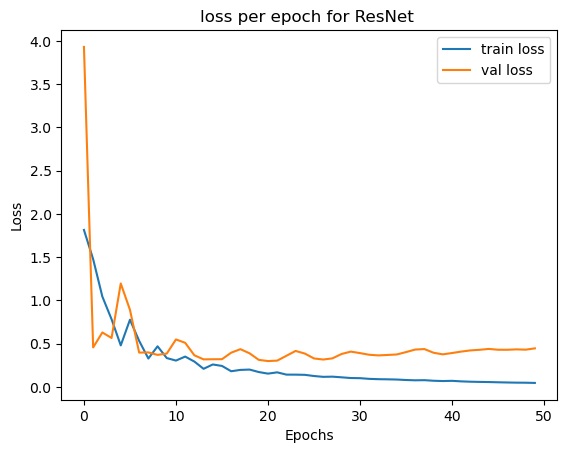

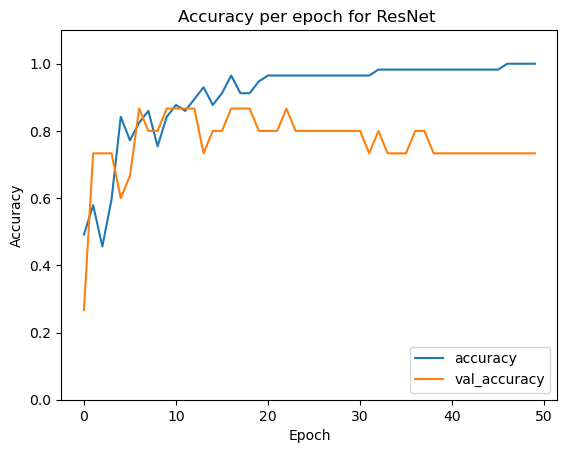

In [28]:
plt.plot(ResNet_history_1_percent.history['loss'], label='train loss')
plt.plot(ResNet_history_1_percent.history['val_loss'], label='val loss')
plt.title('loss per epoch for ResNet ')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
plt.savefig('loss per epoch for ResNet' , dpi=100)


plt.plot(ResNet_history_1_percent.history['accuracy'], label='accuracy')
plt.plot(ResNet_history_1_percent.history['val_accuracy'], label = 'val_accuracy')
plt.title('Accuracy per epoch for ResNet ')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.0, 1.1])
plt.legend(loc='lower right')
plt.savefig('accuracy per epoch for ResNet' , dpi=100)

25/25 [==============================] - 105s 4s/step
Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.85      0.76       412
           1       0.79      0.57      0.66       388

    accuracy                           0.72       800
   macro avg       0.73      0.71      0.71       800
weighted avg       0.73      0.72      0.71       800

ROC AUC Score: 0.7709125713141828


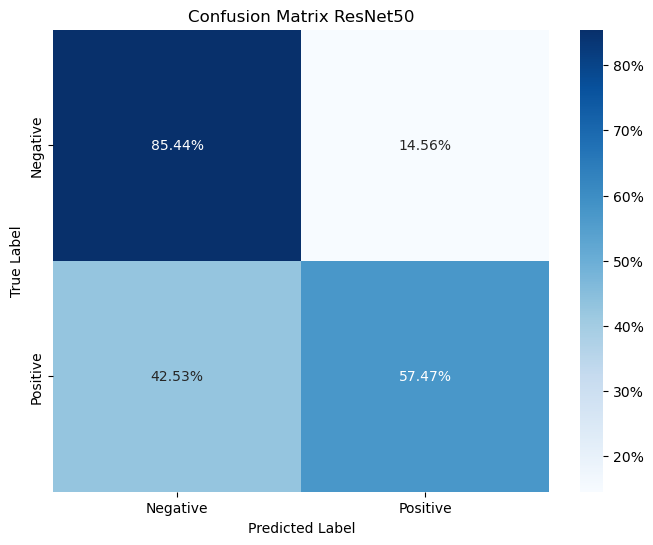

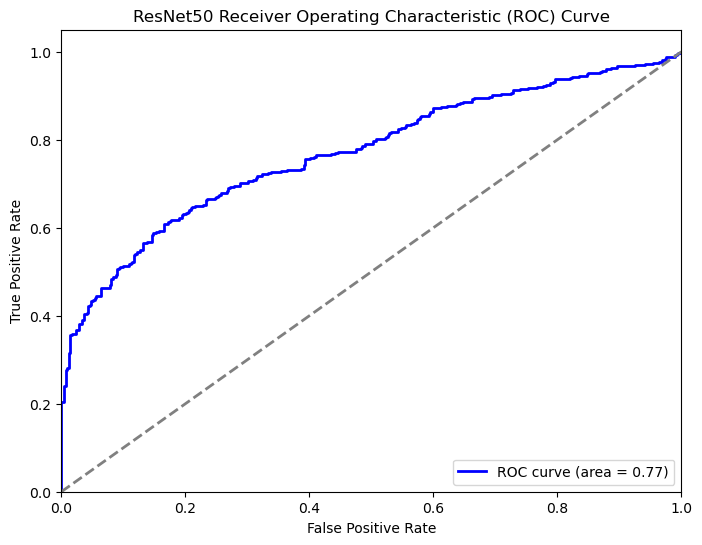

In [29]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, roc_curve

# Assuming you have your test data prepared and stored in X_test and y_test_1d

# Step 7: Evaluate the model
y_pred = model.predict(X_test)

# Convert probabilities to binary predictions (0 or 1)
y_pred_binary = np.where(y_pred > 0.5, 1, 0)

# Print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred_binary))

# Calculate ROC AUC score
roc_auc = roc_auc_score(y_test, y_pred)
print(f"ROC AUC Score: {roc_auc}")

# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred_binary)

# Normalize confusion matrix to percentages
cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

# Plot confusion matrix with percentages
plt.figure(figsize=(8, 6))
ax = sns.heatmap(cm_percentage, annot=True, fmt=".2f", cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'], cbar_kws={'format': '%.0f%%'})

# Annotate the heatmap with percentage signs
for t in ax.texts: 
    t.set_text(t.get_text() + "%")

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix ResNet50')
plt.show()

# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ResNet50 Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

### ResNet50 10%

In [30]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

# Step 1: Load pre-trained ResNet50 model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Step 2: Freeze the base model
for layer in base_model.layers:
    layer.trainable = False

# Step 3: Add custom layers for binary classification
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)  # Add a fully connected layer with 1024 units
predictions = Dense(1, activation='sigmoid')(x)  # Binary classification layer

# Step 4: Create the new model
model = Model(inputs=base_model.input, outputs=predictions)

# Step 5: Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

early_stopping = tf.keras.callbacks.EarlyStopping(monitor="loss", patience=5, restore_best_weights=True)
# Assuming train_data and validation_data are your datasets
# Step 6: Train the model
ResNet_history_10_percent = model.fit(X_train_10_percent,
                            y_train_10_percent,
                            validation_split=0.2, 
                            epochs=50,
                            batch_size = 32,
                            callbacks=[early_stopping] 
          )

Epoch 1/50
18/18 [==============================] - 102s 5s/step - loss: 1.1711 - accuracy: 0.5747 - val_loss: 0.5776 - val_accuracy: 0.7153
Epoch 2/50
18/18 [==============================] - 93s 5s/step - loss: 0.5926 - accuracy: 0.6736 - val_loss: 0.6030 - val_accuracy: 0.6736
Epoch 3/50
18/18 [==============================] - 92s 5s/step - loss: 0.5069 - accuracy: 0.7483 - val_loss: 0.5255 - val_accuracy: 0.7292
Epoch 4/50
18/18 [==============================] - 92s 5s/step - loss: 0.5070 - accuracy: 0.7274 - val_loss: 0.5160 - val_accuracy: 0.7500
Epoch 5/50
18/18 [==============================] - 92s 5s/step - loss: 0.4714 - accuracy: 0.7622 - val_loss: 0.5327 - val_accuracy: 0.7569
Epoch 6/50
18/18 [==============================] - 92s 5s/step - loss: 0.4549 - accuracy: 0.7708 - val_loss: 0.4947 - val_accuracy: 0.7778
Epoch 7/50
18/18 [==============================] - 93s 5s/step - loss: 0.4564 - accuracy: 0.7847 - val_loss: 0.4909 - val_accuracy: 0.8056
Epoch 8/50
18/18 [=

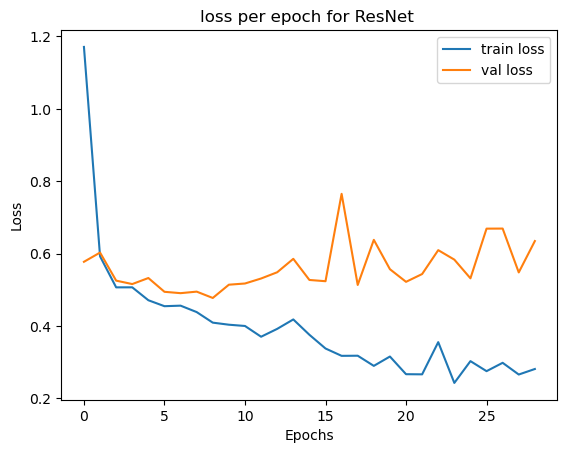

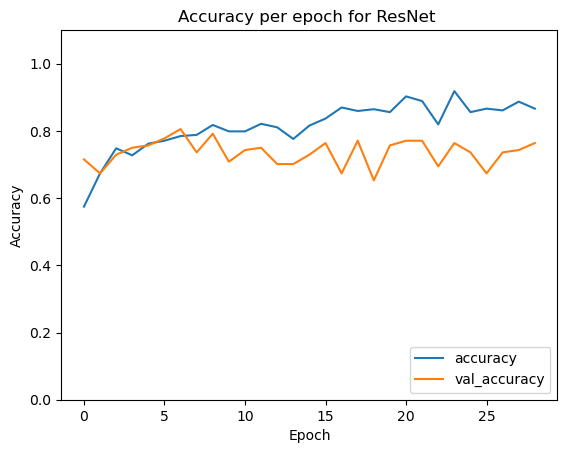

In [31]:
plt.plot(ResNet_history_10_percent.history['loss'], label='train loss')
plt.plot(ResNet_history_10_percent.history['val_loss'], label='val loss')
plt.title('loss per epoch for ResNet ')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
plt.savefig('loss per epoch for ResNet' , dpi=100)


plt.plot(ResNet_history_10_percent.history['accuracy'], label='accuracy')
plt.plot(ResNet_history_10_percent.history['val_accuracy'], label = 'val_accuracy')
plt.title('Accuracy per epoch for ResNet ')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.0, 1.1])
plt.legend(loc='lower right')
plt.savefig('accuracy per epoch for ResNet' , dpi=100)

25/25 [==============================] - 105s 4s/step
Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.92      0.81       412
           1       0.87      0.63      0.73       388

    accuracy                           0.78       800
   macro avg       0.80      0.77      0.77       800
weighted avg       0.80      0.78      0.77       800

ROC AUC Score: 0.8389550595535982


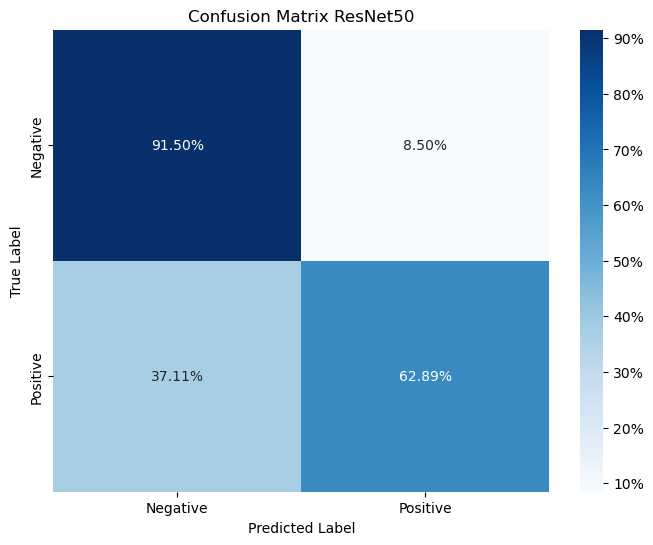

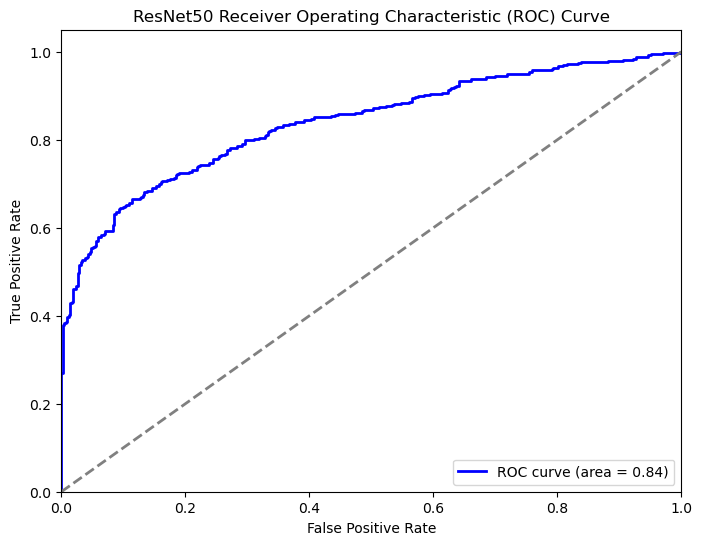

In [32]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, roc_curve

# Assuming you have your test data prepared and stored in X_test and y_test_1d

# Step 7: Evaluate the model
y_pred = model.predict(X_test)

# Convert probabilities to binary predictions (0 or 1)
y_pred_binary = np.where(y_pred > 0.5, 1, 0)

# Print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred_binary))

# Calculate ROC AUC score
roc_auc = roc_auc_score(y_test, y_pred)
print(f"ROC AUC Score: {roc_auc}")

# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred_binary)

# Normalize confusion matrix to percentages
cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

# Plot confusion matrix with percentages
plt.figure(figsize=(8, 6))
ax = sns.heatmap(cm_percentage, annot=True, fmt=".2f", cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'], cbar_kws={'format': '%.0f%%'})

# Annotate the heatmap with percentage signs
for t in ax.texts: 
    t.set_text(t.get_text() + "%")

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix ResNet50')
plt.show()

# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ResNet50 Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

### ResNet50 20%

In [33]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

# Step 1: Load pre-trained ResNet50 model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Step 2: Freeze the base model
for layer in base_model.layers:
    layer.trainable = False

# Step 3: Add custom layers for binary classification
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)  # Add a fully connected layer with 1024 units
predictions = Dense(1, activation='sigmoid')(x)  # Binary classification layer

# Step 4: Create the new model
model = Model(inputs=base_model.input, outputs=predictions)

# Step 5: Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

early_stopping = tf.keras.callbacks.EarlyStopping(monitor="loss", patience=5, restore_best_weights=True)
# Assuming train_data and validation_data are your datasets
# Step 6: Train the model
ResNet_history_20_percent = model.fit(X_train_20_percent,
                            y_train_20_percent,
                            validation_split=0.2, 
                            epochs=50,
                            batch_size = 32,
                            callbacks=[early_stopping] 
          )

Epoch 1/50
36/36 [==============================] - 199s 5s/step - loss: 0.8453 - accuracy: 0.6363 - val_loss: 0.6333 - val_accuracy: 0.6736
Epoch 2/50
36/36 [==============================] - 186s 5s/step - loss: 0.5498 - accuracy: 0.7231 - val_loss: 0.5017 - val_accuracy: 0.7431
Epoch 3/50
36/36 [==============================] - 185s 5s/step - loss: 0.5367 - accuracy: 0.7196 - val_loss: 0.4995 - val_accuracy: 0.7292
Epoch 4/50
36/36 [==============================] - 186s 5s/step - loss: 0.5556 - accuracy: 0.7205 - val_loss: 0.4968 - val_accuracy: 0.7569
Epoch 5/50
36/36 [==============================] - 183s 5s/step - loss: 0.4982 - accuracy: 0.7396 - val_loss: 0.6058 - val_accuracy: 0.6354
Epoch 6/50
36/36 [==============================] - 183s 5s/step - loss: 0.5117 - accuracy: 0.7509 - val_loss: 0.6118 - val_accuracy: 0.6424
Epoch 7/50
36/36 [==============================] - 184s 5s/step - loss: 0.5234 - accuracy: 0.7231 - val_loss: 0.4717 - val_accuracy: 0.7674
Epoch 8/50
36

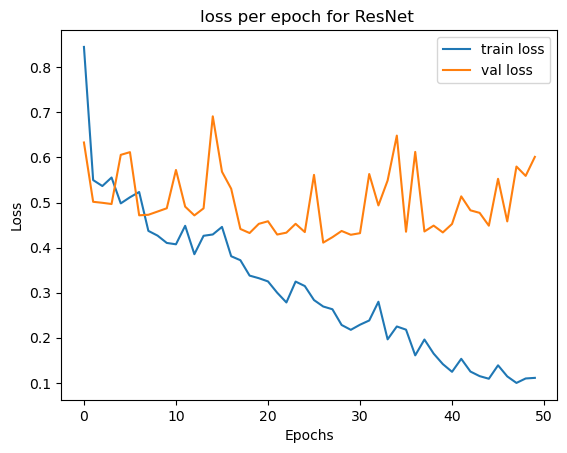

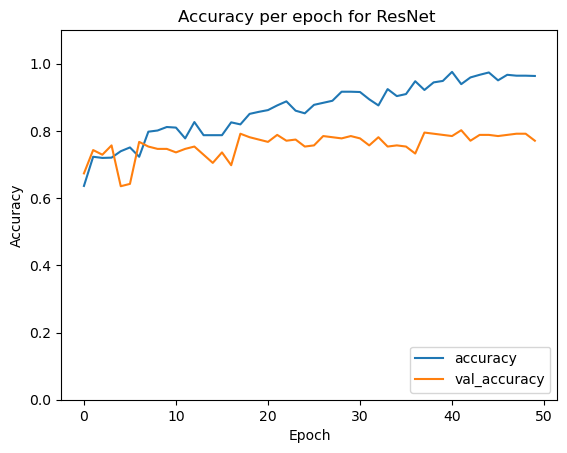

In [34]:
plt.plot(ResNet_history_20_percent.history['loss'], label='train loss')
plt.plot(ResNet_history_20_percent.history['val_loss'], label='val loss')
plt.title('loss per epoch for ResNet ')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
plt.savefig('loss per epoch for ResNet' , dpi=100)


plt.plot(ResNet_history_20_percent.history['accuracy'], label='accuracy')
plt.plot(ResNet_history_20_percent.history['val_accuracy'], label = 'val_accuracy')
plt.title('Accuracy per epoch for ResNet ')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.0, 1.1])
plt.legend(loc='lower right')
plt.savefig('accuracy per epoch for ResNet' , dpi=100)

25/25 [==============================] - 110s 4s/step
Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.60      0.71       412
           1       0.68      0.89      0.77       388

    accuracy                           0.74       800
   macro avg       0.77      0.75      0.74       800
weighted avg       0.77      0.74      0.74       800

ROC AUC Score: 0.8725102592333098


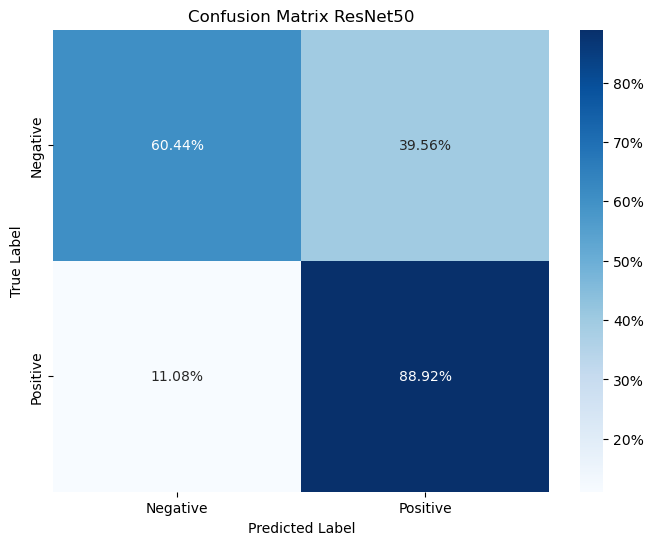

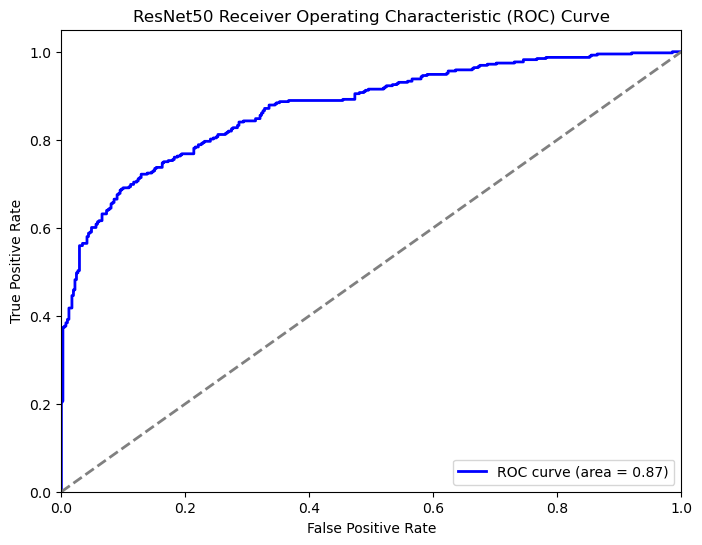

In [35]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, roc_curve

# Assuming you have your test data prepared and stored in X_test and y_test_1d

# Step 7: Evaluate the model
y_pred = model.predict(X_test)

# Convert probabilities to binary predictions (0 or 1)
y_pred_binary = np.where(y_pred > 0.5, 1, 0)

# Print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred_binary))

# Calculate ROC AUC score
roc_auc = roc_auc_score(y_test, y_pred)
print(f"ROC AUC Score: {roc_auc}")

# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred_binary)

# Normalize confusion matrix to percentages
cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

# Plot confusion matrix with percentages
plt.figure(figsize=(8, 6))
ax = sns.heatmap(cm_percentage, annot=True, fmt=".2f", cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'], cbar_kws={'format': '%.0f%%'})

# Annotate the heatmap with percentage signs
for t in ax.texts: 
    t.set_text(t.get_text() + "%")

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix ResNet50')
plt.show()

# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ResNet50 Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# CNN as a feature extractor

In [10]:
def CNN1_model():
    # input layer
    inputs = keras.Input(shape=(image_size_224, image_size_224, 3), name="input")

    #first layer
    x = layers.Conv2D(32, (3, 3), strides=(3,3), activation='relu', padding='same' )(inputs)
    x = layers.MaxPooling2D(pool_size=(2, 2), padding='same')(x)
    x = layers.Dropout(0.2)(x)
    x = layers.BatchNormalization()(x)

    #second layer
    x = layers.Conv2D(64, (3, 3), strides=(3,3), padding='same', activation='relu')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.2)(x)
    outputs = layers.BatchNormalization()(x)

    #  Dense layers
    # x = layers.Flatten()(x)
    # x = layers.Dense(64, activation='relu')(x)
    # x = layers.BatchNormalization()(x)
    # x = layers.Dense(64, activation='relu')(x)
    # x = layers.BatchNormalization()(x)
    # x = layers.Dense(64, activation='relu')(x)
    # x = layers.BatchNormalization()(x)

    # # output layer
    # outputs = layers.Dense(2, activation="sigmoid", name="output")(x)

    # model
    model = keras.Model(inputs=inputs, outputs=outputs)
    
    
    # reduce lr when validation acc start to reduce, to make results more stable
    # reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 2, min_delta = 0.001, mode='auto', verbose=0)
    
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

In [11]:
image_size = 224
CNN1_model = CNN1_model()
CNN1_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 224, 224, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 75, 75, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 38, 38, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 38, 38, 32)        0         
                                                                 
 batch_normalization (Batch  (None, 38, 38, 32)        128       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 64)        18496 

In [12]:
# Extracting features with CNN
X_train_cnn = CNN1_model.predict(X_train)
X_test_cnn = CNN1_model.predict(X_test)

231/231 [==============================] - 32s 134ms/step


In [14]:
'''
Train  random forest classifier
'''
rf = RandomForestClassifier(n_estimators=10, random_state=42)
rf.fit(X_train_cnn.reshape(X_train_cnn.shape[0],-1), y_train_1d)
# Evaluate the classifier on the test set
accuracy_train = rf.score(X_train_cnn.reshape(X_train_cnn.shape[0],-1), y_train_1d)
accuracy_test = rf.score(X_test_cnn.reshape(X_test_cnn.shape[0],-1), y_test_1d)
print('Random Forest train Accuracy:', accuracy_train)
print('Random Forest test Accuracy:', accuracy_test)

Random Forest train Accuracy: 1.0
Random Forest test Accuracy: 0.9997284084736556


In [16]:
def CNN1_model():
    # input layer
    inputs = keras.Input(shape=(image_size, image_size, 3), name="input")

    #first layer
    x = layers.Conv2D(32, (3, 3), strides=(3,3), activation='relu', padding='same' )(inputs)
    x = layers.MaxPooling2D(pool_size=(2, 2), padding='same')(x)
    x = layers.Dropout(0.2)(x)
    x = layers.BatchNormalization()(x)

    #second layer
    x = layers.Conv2D(64, (3, 3), strides=(3,3), padding='same', activation='relu')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.2)(x)
    outputs = layers.BatchNormalization()(x)

    #  Dense layers
    x = layers.Flatten()(x)
    x = layers.Dense(64, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dense(64, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dense(64, activation='relu')(x)
    x = layers.BatchNormalization()(x)

    # # output layer
    outputs = layers.Dense(1, activation="sigmoid", name="output")(x)

    # model
    model = keras.Model(inputs=inputs, outputs=outputs)
    
    
    # reduce lr when validation acc start to reduce, to make results more stable
    # reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 2, min_delta = 0.001, mode='auto', verbose=0)
    
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

image_size = 224
CNN1_model = CNN1_model()
CNN1_model.summary()

cnn1_history = CNN1_model.fit(
    X_train, 
    y_train_1d, 
    validation_split = .1,
    epochs = 50, 
    batch_size = 64, 
    shuffle = True 
    )

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_4 (Conv2D)           (None, 75, 75, 32)        896       
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 38, 38, 32)        0         
 g2D)                                                            
                                                                 
 dropout_4 (Dropout)         (None, 38, 38, 32)        0         
                                                                 
 batch_normalization_7 (Bat  (None, 38, 38, 32)        128       
 chNormalization)                                                
                                                                 
 conv2d_5 (Conv2D)           (None, 13, 13, 64)        1849

ValueError: in user code:

    File "c:\Users\Ahmad\anaconda3\Lib\site-packages\keras\src\engine\training.py", line 1377, in train_function  *
        return step_function(self, iterator)
    File "c:\Users\Ahmad\anaconda3\Lib\site-packages\keras\src\engine\training.py", line 1360, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\Ahmad\anaconda3\Lib\site-packages\keras\src\engine\training.py", line 1349, in run_step  **
        outputs = model.train_step(data)
    File "c:\Users\Ahmad\anaconda3\Lib\site-packages\keras\src\engine\training.py", line 1127, in train_step
        loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "c:\Users\Ahmad\anaconda3\Lib\site-packages\keras\src\engine\training.py", line 1185, in compute_loss
        return self.compiled_loss(
    File "c:\Users\Ahmad\anaconda3\Lib\site-packages\keras\src\engine\compile_utils.py", line 277, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "c:\Users\Ahmad\anaconda3\Lib\site-packages\keras\src\losses.py", line 143, in __call__
        losses = call_fn(y_true, y_pred)
    File "c:\Users\Ahmad\anaconda3\Lib\site-packages\keras\src\losses.py", line 270, in call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "c:\Users\Ahmad\anaconda3\Lib\site-packages\keras\src\losses.py", line 2532, in binary_crossentropy
        backend.binary_crossentropy(y_true, y_pred, from_logits=from_logits),
    File "c:\Users\Ahmad\anaconda3\Lib\site-packages\keras\src\backend.py", line 5824, in binary_crossentropy
        return tf.nn.sigmoid_cross_entropy_with_logits(

    ValueError: `logits` and `labels` must have the same shape, received ((None, 2) vs (None, 1)).


In [35]:
CNN1_result = CNN1_model.evaluate(
    X_test, 
    y_test_1d, 
    batch_size = 64, 
    verbose = 0
    )
print('The CNN1 error is: %.2f%%'%(100 - CNN1_result[1]*100))

The CNN1 error is: 17.18%


In [36]:
test_loss_CNN1, test_accuracy_CNN1 = CNN1_model.evaluate(
    X_test, 
    y_test_1d, 
    batch_size = 64, 
    verbose = 0
    )
print(f'Test Loss : {test_loss_CNN1:.4f}')
print(f'Test Accuracy: {test_accuracy_CNN1:.4f}')

Test Loss : 0.5929
Test Accuracy: 0.8282


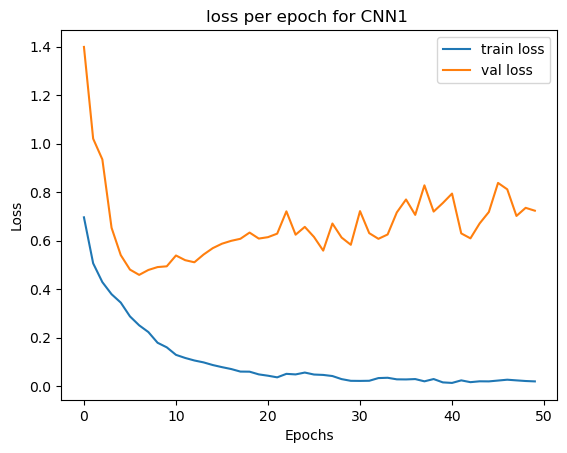

In [37]:
plt.plot(cnn1_history.history['loss'], label='train loss')
plt.plot(cnn1_history.history['val_loss'], label='val loss')
plt.title('loss per epoch for CNN1 ')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
# plt.savefig('loss per epoch for CNN 1' , dpi=100)


plt.plot(cnn1_history.history['accuracy'], label='accuracy')
plt.plot(cnn1_history.history['val_accuracy'], label = 'val_accuracy')
plt.title('Accuracy per epoch for CNN1 ')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.0, 1.1])
plt.legend(loc='lower right')
# plt.savefig('accuracy per epoch for CNN 1' , dpi=100)

# Prtrained Vit

In [4]:
import tensorflow as tf
import tensorflow_addons as tfa
import keras.layers as L
import glob, random, os, warnings
from sklearn.metrics import confusion_matrix, classification_report

c:\Users\Ahmad\anaconda3\Lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [5]:
def seed_everything(seed = 0):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'

seed_everything()

import warnings
warnings.filterwarnings("ignore")

In [6]:
image_size_224 = 224
image_size_384 = 384
batch_size = 32
n_classes = 2
EPOCHS = 30

## Vit b16 & 32 with image size 224

In [7]:
from vit_keras import vit, utils
from glob import glob

In [8]:
def load_data(folder, image_size):
    class_names = [f for f in os.listdir(folder) if not f.startswith('.')]  # Create a list of subfolders

    images_data = []
    labels = []

    print(class_names)
    for t, f in enumerate(class_names):
        images = glob(os.path.join(folder, f, "*"))
        print("Downloading: ", f)
        fig = plt.figure(figsize=(50, 50))
        for im_n, im in enumerate(images):
            plt.gray()
            rgba_image = cv2.imread(im, cv2.IMREAD_UNCHANGED)
            
            # Convert RGBA to RGB if it has an alpha channel
            if rgba_image.shape[2] == 4:
                rgb_image = cv2.cvtColor(rgba_image, cv2.COLOR_RGBA2RGB)
                #Converting image to LAB Color so CLAHE can be applied to the luminance channel
                lab_img = cv2.cvtColor(rgb_image, cv2.COLOR_BGR2LAB)

                #Splitting the LAB image to L, A and B channels, respectively
                l, a, b = cv2.split(lab_img)

                ###########Histogram Equlization#############
                #Apply histogram equalization to the L channel
                equ = cv2.equalizeHist(l)
                #Combine the Hist. equalized L-channel back with A and B channels
                updated_lab_img1 = cv2.merge((equ,a,b))

                #Convert LAB image back to color (RGB)
                hist_eq_img = cv2.cvtColor(updated_lab_img1, cv2.COLOR_LAB2BGR)
            # Resize the image
            image = cv2.resize(hist_eq_img, (image_size, image_size), interpolation=cv2.INTER_LINEAR)
            

            # Flatten the image
            image = image.flatten()

            images_data.append(image)
            labels.append(f)

    return np.array(images_data), np.array(labels)

# Example usage
dir_data = 'c:/2016/plots'
image_size_224 = 224  # Adjust the desired size as needed
loaded_images, loaded_labels = load_data(dir_data, image_size=image_size_224)



images = []
labels = []


for feature in loaded_images:
    image = vit.preprocess_inputs(feature)
    images.append(image)
    
for label in loaded_labels:
    labels.append(label)


# Normalize the data
# images = np.array(images)
images = np.array(images).astype(np.float32) / 255.0
    
images = images.reshape(-1, image_size_224, image_size_224, 3)


# Creating a dictionary of clases
lab = {}
for i, l in enumerate(set(labels)):
    lab[l] = i


labels = np.array([lab[l] for l in labels])

['Abnormal', 'Normal']
Downloading:  Abnormal
Downloading:  Normal


<Figure size 5000x5000 with 0 Axes>

<Figure size 5000x5000 with 0 Axes>

In [9]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical

encoder = LabelEncoder()
encoder.fit(labels)
encoded_Y = encoder.transform(labels)
dummy_Y = to_categorical(encoded_Y)
dummy_Y.astype(int)

array([[1, 0],
       [1, 0],
       [1, 0],
       ...,
       [0, 1],
       [0, 1],
       [0, 1]])

In [11]:
from sklearn.model_selection import train_test_split
X_train_vit_normalized, X_test_vit_normalized, y_train, y_test = train_test_split(images, encoded_Y, test_size = 0.2, random_state = 42)

np.save('X_train_vit_normalized.npy',X_train_vit_normalized)
np.save('X_test_vit_normalized.npy', X_test_vit_normalized)

In [69]:
X_train_vit_normalized = np.load('X_train_vit_normalized.npy')
X_test_vit_normalized = np.load('X_test_vit_normalized.npy')
y_train = np.load('y_train.npy')
y_test = np.load('y_test.npy')

### Vit B16 training from scratch

In [12]:
from vit_keras import vit

In [14]:
vit_b16 = vit.vit_b16(
        image_size = image_size_224,
        activation = 'sigmoid',
        pretrained = True,
        include_top = False,
        pretrained_top = False,
        classes = 2
        )
    

vit_b16_model = tf.keras.Sequential([
        vit_b16,
        tf.keras.layers.Flatten(),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(128, activation = tfa.activations.gelu),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(64, activation = tfa.activations.gelu),
        tf.keras.layers.Dense(32, activation = tfa.activations.gelu),
        tf.keras.layers.Dense(1, 'sigmoid')
    ],
    name = 'vision_transformer_b16')

vit_b16_model.summary()

Model: "vision_transformer_b16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vit-b16 (Functional)        (None, 768)               85798656  
                                                                 
 flatten_1 (Flatten)         (None, 768)               0         
                                                                 
 batch_normalization_2 (Bat  (None, 768)               3072      
 chNormalization)                                                
                                                                 
 dense_4 (Dense)             (None, 128)               98432     
                                                                 
 batch_normalization_3 (Bat  (None, 128)               512       
 chNormalization)                                                
                                                                 
 dense_5 (Dense)             (None, 64)     

In [ ]:
warnings.filterwarnings("ignore")

learning_rate = 1e-4

optimizer = tfa.optimizers.RectifiedAdam(learning_rate = learning_rate)

vit_b16_model.compile(
              optimizer = optimizer, 
              loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing = 0.2), 
              metrics = ['accuracy']
              )



early_stopping_callbacks = tf.keras.callbacks.EarlyStopping(patience = 15, restore_best_weights = True, verbose = 1)

vit_b16_history = vit_b16_model.fit(
                                    X_train,
                                    y_train,
                                    validation_split = 0.25,
                                    batch_size = 64,
                                    epochs = 30,
                                    callbacks = early_stopping_callbacks
                                    )

### vit b16 "imagenet21k+imagenet2012"

In [15]:
from vit_keras import vit, utils

image_size_224 = 224
# classes = utils.get_imagenet_classes()
vit_b16 = vit.vit_b16(
    image_size = image_size_224,
    activation = 'sigmoid',
    pretrained = True,
    include_top = False,
    pretrained_top = False,
    classes = 2,
    weights = "imagenet21k+imagenet2012"
    )

In [16]:
X_train_normalized_vit_b16 = vit_b16.predict(X_train_vit_normalized)
np.save('X_train_normalized_vit_b16.npy', X_train_normalized_vit_b16)

438/438 [==============================] - 7233s 16s/step


In [17]:
X_test_normalized_vit_b16 = vit_b16.predict(X_test_vit_normalized)
np.save('X_test_normalized_vit_b16.npy', X_test_normalized_vit_b16)

110/110 [==============================] - 1776s 16s/step


In [18]:
X_train_normalized_vit_b16 = np.load('X_train_normalized_vit_b16.npy')
print(X_train_normalized_vit_b16.shape)
X_test_normalized_vit_b16 = np.load('X_test_normalized_vit_b16.npy')
print(X_test_normalized_vit_b16.shape)

(14003, 768)
(3501, 768)


In [19]:
from sklearn.model_selection import GridSearchCV, KFold
xgb_kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# Define the parameter grid for grid search
# xgb_param_grid = {
#     'max_depth': [3, 6, 9],
#     'learning_rate': [0.1, 0.01, 0.001],
#     'n_estimators': [50, 100, 200]
# }

# Create the XGBoost classifier
xgb_vit_b16 = xgb.XGBClassifier(
    max_depth = 3,
    learning_rate = 0.1,
    n_estimators = 50
    )

xgb_vit_b16.fit(
    X_train_normalized_vit_b16, 
    y_train
    )


xgb_vit_b16_prediction = xgb_vit_b16.predict(X_test_normalized_vit_b16)

from sklearn.metrics import accuracy_score
print('train set accuracy is:', accuracy_score(y_train, xgb_vit_b16.predict(X_train_normalized_vit_b16)))
print('test set accuracy is:', accuracy_score(y_test, xgb_vit_b16_prediction))
from sklearn.metrics import classification_report
print(classification_report(y_test, xgb_vit_b16_prediction))

train set accuracy is: 0.8246090123544955
test set accuracy is: 0.7969151670951157
              precision    recall  f1-score   support

           0       0.79      0.82      0.80      1764
           1       0.81      0.77      0.79      1737

    accuracy                           0.80      3501
   macro avg       0.80      0.80      0.80      3501
weighted avg       0.80      0.80      0.80      3501



In [20]:
from sklearn.ensemble import RandomForestClassifier
rf_vit_b16 = RandomForestClassifier()
rf_vit_b16.fit(X_train_normalized_vit_b16, y_train)

#Now predict using the trained  model. 
rf_vit_b16_prediction = rf_vit_b16.predict(X_test_normalized_vit_b16)


from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
print('train set accuracy is:',accuracy_score(y_train, rf_vit_b16.predict(X_train_normalized_vit_b16)))
print('test set accuracy is:',accuracy_score(y_test, rf_vit_b16_prediction))
print(classification_report(y_test, rf_vit_b16_prediction))

train set accuracy is: 0.9999285867314147
test set accuracy is: 0.7954870037132248
              precision    recall  f1-score   support

           0       0.78      0.83      0.80      1764
           1       0.81      0.76      0.79      1737

    accuracy                           0.80      3501
   macro avg       0.80      0.80      0.80      3501
weighted avg       0.80      0.80      0.80      3501



### vit_b16_imagenet21k

In [100]:
from vit_keras import vit, utils

image_size_224 = 224
# classes = utils.get_imagenet_classes()
vit_b16_imagenet21k = vit.vit_b16(
    image_size = image_size_224,
    activation = 'sigmoid',
    pretrained = True,
    include_top = False,
    pretrained_top = False,
    weights = "imagenet21k"
)

10/10 [==============================] - 129s 13s/step


In [ ]:
X_train_normalized_vit_b16_imagenet21k = vit_b16_imagenet21k.predict(X_train_vit_normalized)
np.save('X_train_normalized_vit_b16_imagenet21k.npy', X_train_normalized_vit_b16_imagenet21k)

In [ ]:
X_test_normalized_vit_b16_imagenet21k = vit_b16_imagenet21k.predict(X_test_vit_normalized)
np.save('X_test_normalized_vit_b16_imagenet21k.npy', X_test_normalized_vit_b16_imagenet21k)

In [22]:
X_train_normalized_vit_b16_imagenet21k = np.load('X_train_normalized_vit_b16_imagenet21k.npy')
print(X_train_normalized_vit_b16_imagenet21k.shape)
X_test_normalized_vit_b16_imagenet21k = np.load('X_test_normalized_vit_b16_imagenet21k.npy')
print(X_test_normalized_vit_b16_imagenet21k.shape)

(1163, 768)
(291, 768)


In [23]:
from sklearn.model_selection import GridSearchCV, KFold
xgb_kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# Define the parameter grid for grid search
# xgb_param_grid = {
#     'max_depth': [3, 6, 9],
#     'learning_rate': [0.1, 0.01, 0.001],
#     'n_estimators': [50, 100, 200]
# }

# Create the XGBoost classifier
xgb_vit_b16_imagenet21k = xgb.XGBClassifier(
    max_depth = 3,
    learning_rate = 0.1,
    n_estimators = 50
    )

xgb_vit_b16_imagenet21k.fit(
    X_train_normalized_vit_b16_imagenet21k, 
    y_train_1d
    )


xgb_vit_b16_imagenet21k_prediction = xgb_vit_b16_imagenet21k.predict(X_test_normalized_vit_b16_imagenet21k)

from sklearn.metrics import accuracy_score
print('train set accuracy is:', accuracy_score(y_train_1d, xgb_vit_b16_imagenet21k.predict(X_train_normalized_vit_b16_imagenet21k)))
print('test set accuracy is:', accuracy_score(y_test_1d, xgb_vit_b16_imagenet21k_prediction))
from sklearn.metrics import classification_report
print(classification_report(y_test_1d, xgb_vit_b16_imagenet21k_prediction))

train set accuracy is: 0.9191745485812554
test set accuracy is: 0.8075601374570447
              precision    recall  f1-score   support

           0       0.80      0.86      0.82       154
           1       0.82      0.75      0.79       137

    accuracy                           0.81       291
   macro avg       0.81      0.80      0.81       291
weighted avg       0.81      0.81      0.81       291



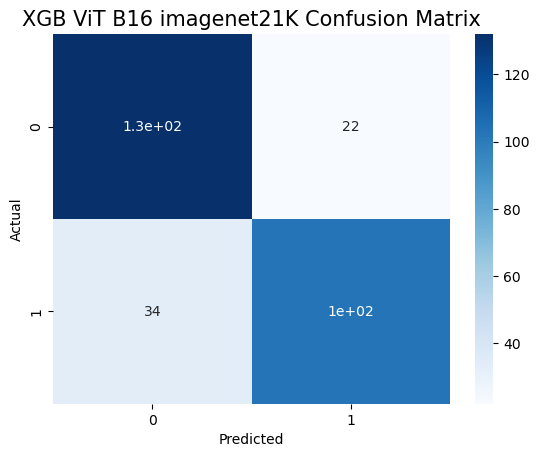

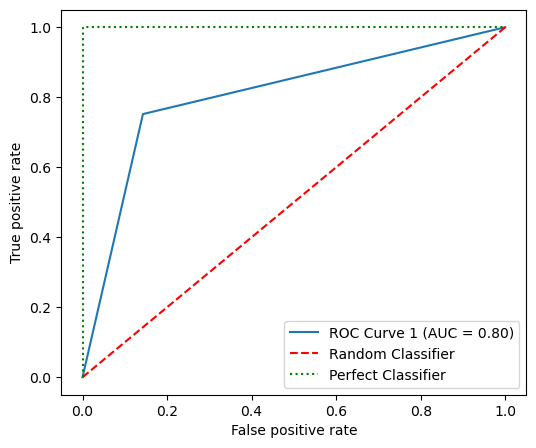

In [28]:
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(y_test_1d, xgb_vit_b16_imagenet21k_prediction)
sns.heatmap(conf_matrix,annot=True,cmap='Blues')
plt.title('XGB ViT B16 imagenet21K Confusion Matrix',size=15)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.savefig('XGB ViT B16 imagenet21K conf matrix.png')


from sklearn.metrics import roc_curve, auc, roc_auc_score
fpr , tpr , _ = roc_curve(y_test_1d, xgb_vit_b16_imagenet21k_prediction )
auc = roc_auc_score(y_test_1d, xgb_vit_b16_imagenet21k_prediction)
fig, ax = plt.subplots(figsize=(6, 5))
plt.plot(fpr, tpr, label='ROC Curve 1 (AUC = %0.2f)' % (auc))
plt.plot([0, 1], [0, 1], linestyle='--', color='red', label='Random Classifier')   
plt.plot([0, 0, 1], [0, 1, 1], linestyle=':', color='green', label='Perfect Classifier')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend(loc="lower right")
plt.savefig('XGB ViT B16 imagenet21K AUC ROC.png')

In [24]:
from sklearn.ensemble import RandomForestClassifier
rf_vit_b16_imagenet21k = RandomForestClassifier()
rf_vit_b16_imagenet21k.fit(X_train_normalized_vit_b16_imagenet21k, y_train_1d)

#Now predict using the trained  model. 
rf_vit_b16_imagenet21k_prediction = rf_vit_b16_imagenet21k.predict(X_test_normalized_vit_b16_imagenet21k)


from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
print('train set accuracy is:',accuracy_score(y_train_1d, rf_vit_b16_imagenet21k.predict(X_train_normalized_vit_b16_imagenet21k)))
print('test set accuracy is:',accuracy_score(y_test_1d, rf_vit_b16_imagenet21k_prediction))
print(classification_report(y_test_1d, rf_vit_b16_imagenet21k_prediction))

train set accuracy is: 1.0
test set accuracy is: 0.8006872852233677
              precision    recall  f1-score   support

           0       0.80      0.83      0.82       154
           1       0.80      0.77      0.78       137

    accuracy                           0.80       291
   macro avg       0.80      0.80      0.80       291
weighted avg       0.80      0.80      0.80       291



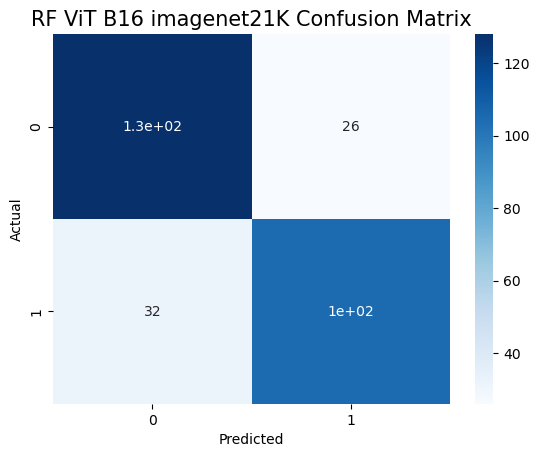

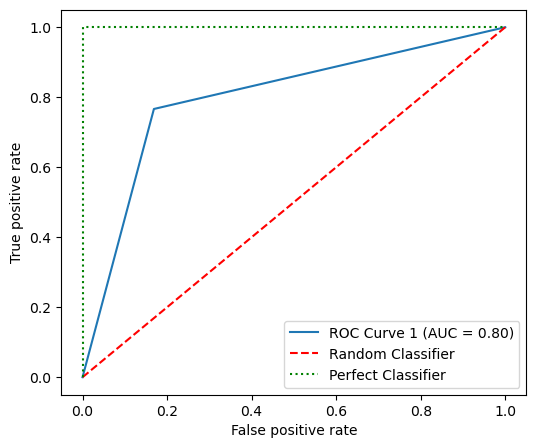

In [29]:
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(y_test_1d, rf_vit_b16_imagenet21k_prediction)
sns.heatmap(conf_matrix,annot=True,cmap='Blues')
plt.title('RF ViT B16 imagenet21K Confusion Matrix',size=15)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.savefig('RF ViT B16 imagenet21K conf matrix.png')


from sklearn.metrics import roc_curve, auc, roc_auc_score
fpr , tpr , _ = roc_curve(y_test_1d, rf_vit_b16_imagenet21k_prediction )
auc = roc_auc_score(y_test_1d, rf_vit_b16_imagenet21k_prediction)
fig, ax = plt.subplots(figsize=(6, 5))
plt.plot(fpr, tpr, label='ROC Curve 1 (AUC = %0.2f)' % (auc))
plt.plot([0, 1], [0, 1], linestyle='--', color='red', label='Random Classifier')   
plt.plot([0, 0, 1], [0, 1, 1], linestyle=':', color='green', label='Perfect Classifier')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend(loc="lower right")
plt.savefig('RF ViT B16 imagenet21K AUC ROC.png')

In [25]:
from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.model_selection import cross_val_score



bag_vit_b16_imagenet21k = BaggingClassifier()
bag_vit_b16_imagenet21k.fit(X_train_normalized_vit_b16_imagenet21k, y_train_1d)
bag_vit_b16_imagenet21k_prediction = bag_vit_b16_imagenet21k.predict(X_test_normalized_vit_b16_imagenet21k)

#Print overall accuracy

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
print('train set accuracy is:',accuracy_score(y_train_1d, bag_vit_b16_imagenet21k.predict(X_train_normalized_vit_b16_imagenet21k)))
print('test set accuracy is:',accuracy_score(y_test_1d, bag_vit_b16_imagenet21k_prediction))

print(classification_report(y_test_1d, bag_vit_b16_imagenet21k_prediction))

train set accuracy is: 0.9879621668099742
test set accuracy is: 0.7869415807560137
              precision    recall  f1-score   support

           0       0.76      0.88      0.81       154
           1       0.83      0.69      0.75       137

    accuracy                           0.79       291
   macro avg       0.80      0.78      0.78       291
weighted avg       0.79      0.79      0.78       291



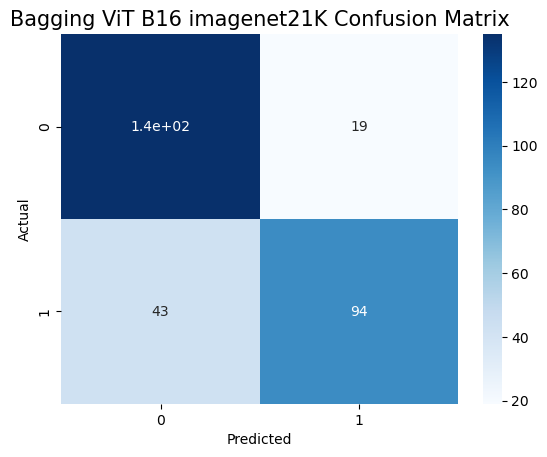

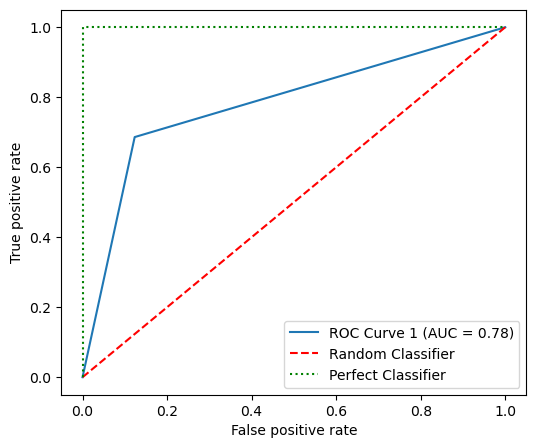

In [30]:
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(y_test_1d, bag_vit_b16_imagenet21k_prediction)
sns.heatmap(conf_matrix,annot=True,cmap='Blues')
plt.title('Bagging ViT B16 imagenet21K Confusion Matrix',size=15)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.savefig('Bagging ViT B16 imagenet21K conf matrix.png')


from sklearn.metrics import roc_curve, auc, roc_auc_score
fpr , tpr , _ = roc_curve(y_test_1d, bag_vit_b16_imagenet21k_prediction )
auc = roc_auc_score(y_test_1d, bag_vit_b16_imagenet21k_prediction)
fig, ax = plt.subplots(figsize=(6, 5))
plt.plot(fpr, tpr, label='ROC Curve 1 (AUC = %0.2f)' % (auc))
plt.plot([0, 1], [0, 1], linestyle='--', color='red', label='Random Classifier')   
plt.plot([0, 0, 1], [0, 1, 1], linestyle=':', color='green', label='Perfect Classifier')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend(loc="lower right")
plt.savefig('Bagging ViT B16 imagenet21K AUC ROC.png')

In [26]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.model_selection import cross_val_score



abc_vit_b16_imagenet21k = AdaBoostClassifier()
abc_vit_b16_imagenet21k.fit(X_train_normalized_vit_b16_imagenet21k, y_train_1d)
abc_vit_b16_imagenet21k_prediction = abc_vit_b16_imagenet21k.predict(X_test_normalized_vit_b16_imagenet21k)

#Print overall accuracy

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
print('train set accuracy is:',accuracy_score(y_train_1d, abc_vit_b16_imagenet21k.predict(X_train_normalized_vit_b16_imagenet21k)))
print('test set accuracy is:',accuracy_score(y_test_1d, abc_vit_b16_imagenet21k_prediction))

print(classification_report(y_test_1d, abc_vit_b16_imagenet21k_prediction))

train set accuracy is: 0.9045571797076526
test set accuracy is: 0.8006872852233677
              precision    recall  f1-score   support

           0       0.80      0.84      0.82       154
           1       0.81      0.76      0.78       137

    accuracy                           0.80       291
   macro avg       0.80      0.80      0.80       291
weighted avg       0.80      0.80      0.80       291



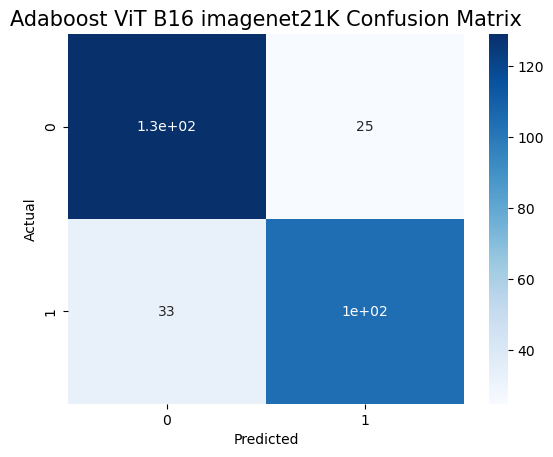

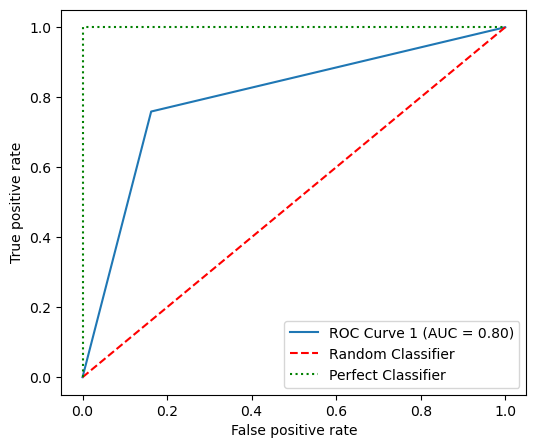

In [31]:
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(y_test_1d, abc_vit_b16_imagenet21k_prediction)
sns.heatmap(conf_matrix,annot=True,cmap='Blues')
plt.title('Adaboost ViT B16 imagenet21K Confusion Matrix',size=15)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.savefig('Adaboost ViT B16 imagenet21K conf matrix.png')


from sklearn.metrics import roc_curve, auc, roc_auc_score
fpr , tpr , _ = roc_curve(y_test_1d, abc_vit_b16_imagenet21k_prediction )
auc = roc_auc_score(y_test_1d, abc_vit_b16_imagenet21k_prediction)
fig, ax = plt.subplots(figsize=(6, 5))
plt.plot(fpr, tpr, label='ROC Curve 1 (AUC = %0.2f)' % (auc))
plt.plot([0, 1], [0, 1], linestyle='--', color='red', label='Random Classifier')   
plt.plot([0, 0, 1], [0, 1, 1], linestyle=':', color='green', label='Perfect Classifier')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend(loc="lower right")
plt.savefig('Adaboost ViT B16 imagenet21K AUC ROC.png')

### Vit-B 32(imagenet21k+imagenet2012)

In [3]:
from vit_keras import vit, utils

image_size_224 = 224


vit_b32 = vit.vit_b32(
    image_size = image_size_224,
    activation = 'sigmoid',
    pretrained = True,
    include_top = False,
    pretrained_top = False,
    weights = 'imagenet21k+imagenet2012'
    )


c:\Users\Ahmad\anaconda3\Lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


BadZipFile: File is not a zip file

In [107]:
# import tensorflow as tf
# from vit_keras import vit
# import tensorflow_addons as tfa
# import warnings

# image_size = 224
# # Load pre-trained ViT model
# vit_b32 = vit.vit_b32(
#                     image_size = image_size,
#                     activation = 'sigmoid',
#                     pretrained = True,
#                     include_top = False,
#                     pretrained_top = False,
#                     weights="imagenet21k+imagenet2012"
# )

# # Create a new model with the ViT model as a feature extractor
# # vit_b32_feature_extractor = tf.keras.Sequential([
# #                                                 vit_b32,
# #                                                 tf.keras.layers.Flatten(),  # Adjust layer based on the output shape of ViT
# #                                             ])

## ViT L 16 & 32 with image size = 384

In [19]:
from vit_keras import vit
from glob import glob

In [13]:
def load_data(folder, image_size):
    class_names = [f for f in os.listdir(folder) if not f.startswith('.')]  # Create a list of subfolders

    images_data = []
    labels = []

    print(class_names)
    for t, f in enumerate(class_names):
        images = glob(os.path.join(folder, f, "*"))
        print("Downloading: ", f)
        fig = plt.figure(figsize=(50, 50))
        for im_n, im in enumerate(images):
            plt.gray()
            rgba_image = cv2.imread(im, cv2.IMREAD_UNCHANGED)
            
            # Convert RGBA to RGB if it has an alpha channel
            if rgba_image.shape[2] == 4:
                rgb_image = cv2.cvtColor(rgba_image, cv2.COLOR_RGBA2RGB)
                #Converting image to LAB Color so CLAHE can be applied to the luminance channel
                lab_img = cv2.cvtColor(rgb_image, cv2.COLOR_BGR2LAB)

                #Splitting the LAB image to L, A and B channels, respectively
                l, a, b = cv2.split(lab_img)

                ###########Histogram Equlization#############
                #Apply histogram equalization to the L channel
                equ = cv2.equalizeHist(l)
                #Combine the Hist. equalized L-channel back with A and B channels
                updated_lab_img1 = cv2.merge((equ,a,b))

                #Convert LAB image back to color (RGB)
                hist_eq_img = cv2.cvtColor(updated_lab_img1, cv2.COLOR_LAB2BGR)
            # Resize the image
            image = cv2.resize(hist_eq_img, (image_size, image_size), interpolation=cv2.INTER_LINEAR)
            

            # Flatten the image
            image = image.flatten()

            images_data.append(image)
            labels.append(f)

    return np.array(images_data), np.array(labels)

# Example usage
dir_data = 'c:/data-hommomorphic envelope'
image_size_384 = 384  # Adjust the desired size as needed
loaded_images, loaded_labels = load_data(dir_data, image_size=image_size_384)



images = []
labels = []


for feature in loaded_images:
    image = vit.preprocess_inputs(feature)
    images.append(image)
    
for label in loaded_labels:
    labels.append(label)


# Normalize the data
# images = np.array(images)
images = np.array(images).astype(np.float32) / 255.0
    
images = images.reshape(-1, image_size_384, image_size_384, 3)


# Creating a dictionary of clases
lab = {}
for i, l in enumerate(set(labels)):
    lab[l] = i


labels = np.array([lab[l] for l in labels])

['abnormal', 'normal']
Downloading:  abnormal
Downloading:  normal


<Figure size 5000x5000 with 0 Axes>

<Figure size 5000x5000 with 0 Axes>

In [14]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical

encoder = LabelEncoder()
encoder.fit(labels)
encoded_Y = encoder.transform(labels)
dummy_Y = to_categorical(encoded_Y)
dummy_Y.astype(int)

array([[0, 1],
       [0, 1],
       [0, 1],
       ...,
       [1, 0],
       [1, 0],
       [1, 0]])

In [15]:
from sklearn.model_selection import train_test_split
X_train_384_vit_normalized, X_test_384_vit_normalized, y_train, y_test = train_test_split(images, dummy_Y, test_size = 0.2, random_state = 42)

np.save('X_train_384_vit_normalized.npy', X_train_384_vit_normalized)
np.save('X_test_384_vit_normalized.npy', X_test_384_vit_normalized)
np.save('y_train.npy', y_train)
np.save('y_test.npy', y_test)

In [75]:
X_train_384_vit_normalized = np.load('X_train_384_vit_normalized.npy')
print(X_train_384_vit_normalized.shape)
X_test_384_vit_normalized = np.load('X_test_384_vit_normalized.npy')
print(X_test_384_vit_normalized.shape)
y_train = np.load('y_train.npy')
y_test = np.load('y_test.npy')

(1163, 384, 384, 3)
(291, 384, 384, 3)


### ViT L 16 imagenet21k + imagenet2016

In [115]:
import tensorflow as tf
from vit_keras import vit
import tensorflow_addons as tfa
import warnings

image_size_384 = 384
# Load pre-trained ViT model
vit_l16 = vit.vit_l16(
                    image_size = image_size_384,
                    activation = 'sigmoid',
                    pretrained = True,
                    include_top = False,
                    pretrained_top = False,
                    weights="imagenet21k+imagenet2012"
)


X_train_normalized_vit_l16 = vit_l16.predict(X_train_384_vit_normalized)
X_test_normalized_vit_l16 = vit_l16.predict(X_test_384_vit_normalized)
np.save('X_train_normalized_vit_l16.npy', X_train_normalized_vit_l16)
np.save('X_test_normalized_vit_l16.npy', X_test_normalized_vit_l16)

10/10 [==============================] - 1260s 125s/step


In [32]:
X_train_normalized_vit_l16 =np.load('X_train_normalized_vit_l16.npy')
print(X_train_normalized_vit_l16.shape)
X_test_normalized_vit_l16 = np.load('X_test_normalized_vit_l16.npy')
print(X_test_normalized_vit_l16.shape)

(1163, 1024)
(291, 1024)


In [33]:
from sklearn.model_selection import GridSearchCV, KFold
xgb_kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# Define the parameter grid for grid search
# xgb_param_grid = {
#     'max_depth': [3, 6, 9],
#     'learning_rate': [0.1, 0.01, 0.001],
#     'n_estimators': [50, 100, 200]
# }

# Create the XGBoost classifier
xgb_vit_l16 = xgb.XGBClassifier(
    max_depth = 3,
    learning_rate = 0.1,
    n_estimators = 50
    )

xgb_vit_l16.fit(
    X_train_normalized_vit_l16, 
    y_train_1d
    )


xgb_vit_l16_prediction = xgb_vit_l16.predict(X_test_normalized_vit_l16)

from sklearn.metrics import accuracy_score
print('train set accuracy is:', accuracy_score(y_train_1d, xgb_vit_l16.predict(X_train_normalized_vit_l16)))
print('test set accuracy is:', accuracy_score(y_test_1d, xgb_vit_l16_prediction))
from sklearn.metrics import classification_report
print(classification_report(y_test_1d, xgb_vit_l16_prediction))

train set accuracy is: 0.9140154772141015
test set accuracy is: 0.7938144329896907
              precision    recall  f1-score   support

           0       0.78      0.86      0.81       154
           1       0.82      0.72      0.77       137

    accuracy                           0.79       291
   macro avg       0.80      0.79      0.79       291
weighted avg       0.80      0.79      0.79       291



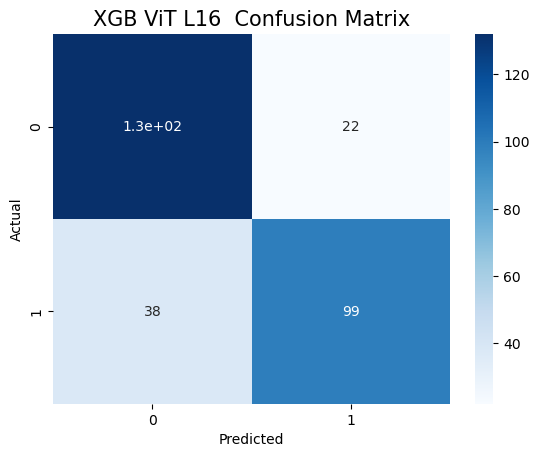

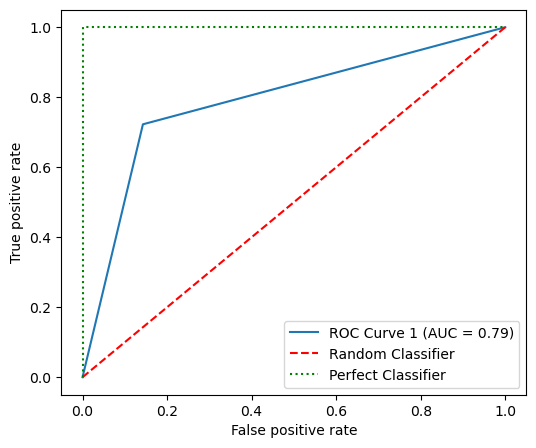

In [37]:
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(y_test_1d, xgb_vit_l16_prediction)
sns.heatmap(conf_matrix,annot=True,cmap='Blues')
plt.title('XGB ViT L16  Confusion Matrix',size=15)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.savefig('XGB ViT L16  conf matrix.png')


from sklearn.metrics import roc_curve, auc, roc_auc_score
fpr , tpr , _ = roc_curve(y_test_1d, xgb_vit_l16_prediction )
auc = roc_auc_score(y_test_1d, xgb_vit_l16_prediction)
fig, ax = plt.subplots(figsize=(6, 5))
plt.plot(fpr, tpr, label='ROC Curve 1 (AUC = %0.2f)' % (auc))
plt.plot([0, 1], [0, 1], linestyle='--', color='red', label='Random Classifier')   
plt.plot([0, 0, 1], [0, 1, 1], linestyle=':', color='green', label='Perfect Classifier')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend(loc="lower right")
plt.savefig('XGB ViT L16  AUC ROC.png')

In [34]:
from sklearn.ensemble import RandomForestClassifier
rf_vit_l16 = RandomForestClassifier()
rf_vit_l16.fit(X_train_normalized_vit_l16, y_train_1d)

#Now predict using the trained  model. 
rf_vit_l16_prediction = rf_vit_l16.predict(X_test_normalized_vit_l16)

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
print('train set accuracy is:',accuracy_score(y_train_1d, rf_vit_l16.predict(X_train_normalized_vit_l16)))
print('test set accuracy is:',accuracy_score(y_test_1d, rf_vit_l16_prediction))
print(classification_report(y_test_1d, rf_vit_l16_prediction))

train set accuracy is: 1.0
test set accuracy is: 0.8041237113402062
              precision    recall  f1-score   support

           0       0.79      0.86      0.82       154
           1       0.82      0.74      0.78       137

    accuracy                           0.80       291
   macro avg       0.81      0.80      0.80       291
weighted avg       0.81      0.80      0.80       291



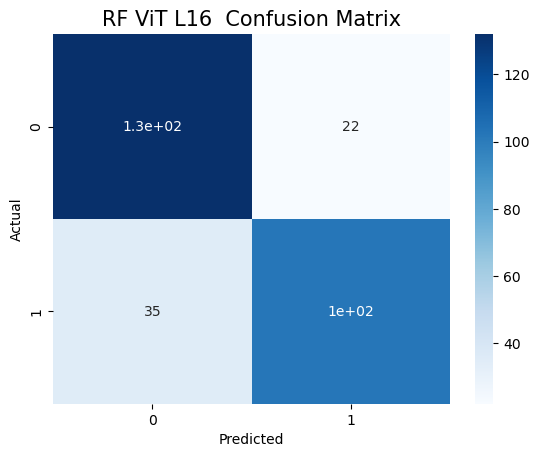

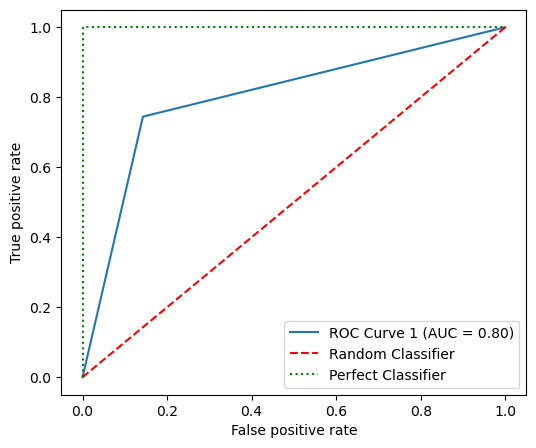

In [38]:
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(y_test_1d, rf_vit_l16_prediction)
sns.heatmap(conf_matrix,annot=True,cmap='Blues')
plt.title('RF ViT L16  Confusion Matrix',size=15)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.savefig('RF ViT L16  conf matrix.png')


from sklearn.metrics import roc_curve, auc, roc_auc_score
fpr , tpr , _ = roc_curve(y_test_1d, rf_vit_l16_prediction )
auc = roc_auc_score(y_test_1d, rf_vit_l16_prediction)
fig, ax = plt.subplots(figsize=(6, 5))
plt.plot(fpr, tpr, label='ROC Curve 1 (AUC = %0.2f)' % (auc))
plt.plot([0, 1], [0, 1], linestyle='--', color='red', label='Random Classifier')   
plt.plot([0, 0, 1], [0, 1, 1], linestyle=':', color='green', label='Perfect Classifier')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend(loc="lower right")
plt.savefig('RF ViT L16  AUC ROC.png')

In [35]:
from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.model_selection import cross_val_score



bag_vit_l16 = BaggingClassifier()
bag_vit_l16.fit(X_train_normalized_vit_l16, y_train_1d)
bag_vit_l16_prediction = bag_vit_l16.predict(X_test_normalized_vit_l16)

#Print overall accuracy

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
print('train set accuracy is:',accuracy_score(y_train_1d, bag_vit_l16.predict(X_train_normalized_vit_l16)))
print('test set accuracy is:',accuracy_score(y_test_1d, bag_vit_l16_prediction))

print(classification_report(y_test_1d, bag_vit_l16_prediction))

train set accuracy is: 0.9845227858985383
test set accuracy is: 0.7697594501718213
              precision    recall  f1-score   support

           0       0.74      0.86      0.80       154
           1       0.81      0.66      0.73       137

    accuracy                           0.77       291
   macro avg       0.78      0.76      0.76       291
weighted avg       0.78      0.77      0.77       291



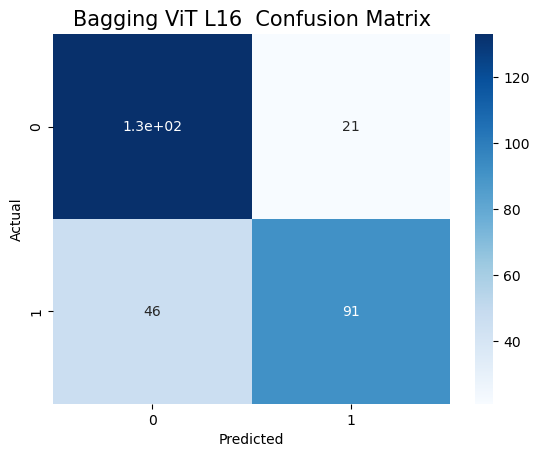

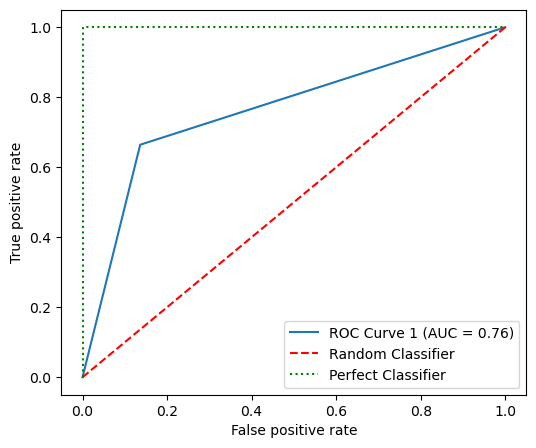

In [39]:
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(y_test_1d, bag_vit_l16_prediction)
sns.heatmap(conf_matrix,annot=True,cmap='Blues')
plt.title('Bagging ViT L16  Confusion Matrix',size=15)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.savefig('Bagging ViT L16  conf matrix.png')


from sklearn.metrics import roc_curve, auc, roc_auc_score
fpr , tpr , _ = roc_curve(y_test_1d, bag_vit_l16_prediction)
auc = roc_auc_score(y_test_1d, bag_vit_l16_prediction)
fig, ax = plt.subplots(figsize=(6, 5))
plt.plot(fpr, tpr, label='ROC Curve 1 (AUC = %0.2f)' % (auc))
plt.plot([0, 1], [0, 1], linestyle='--', color='red', label='Random Classifier')   
plt.plot([0, 0, 1], [0, 1, 1], linestyle=':', color='green', label='Perfect Classifier')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend(loc="lower right")
plt.savefig('Bagging ViT L16  AUC ROC.png')

In [36]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.model_selection import cross_val_score



abc_vit_l16 = AdaBoostClassifier()
abc_vit_l16.fit(X_train_normalized_vit_l16, y_train_1d)
abc_vit_l16_prediction = abc_vit_l16.predict(X_test_normalized_vit_l16)

#Print overall accuracy

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
print('train set accuracy is:',accuracy_score(y_train_1d, abc_vit_l16.predict(X_train_normalized_vit_l16)))
print('test set accuracy is:',accuracy_score(y_test_1d, abc_vit_l16_prediction))

print(classification_report(y_test_1d, abc_vit_l16_prediction))

train set accuracy is: 0.883061049011178
test set accuracy is: 0.7319587628865979
              precision    recall  f1-score   support

           0       0.75      0.74      0.75       154
           1       0.71      0.72      0.72       137

    accuracy                           0.73       291
   macro avg       0.73      0.73      0.73       291
weighted avg       0.73      0.73      0.73       291



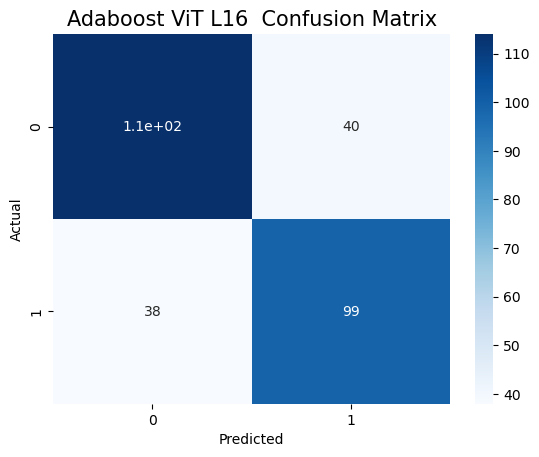

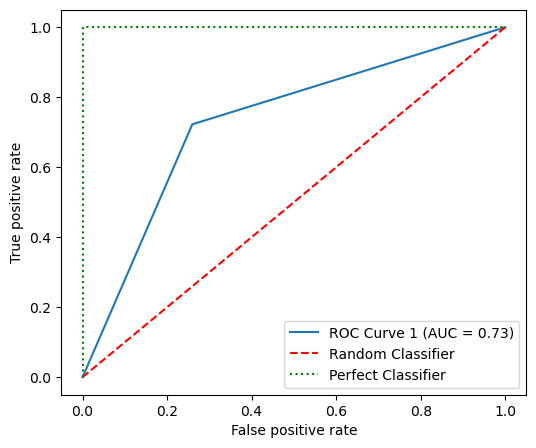

In [40]:
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(y_test_1d, abc_vit_l16_prediction)
sns.heatmap(conf_matrix,annot=True,cmap='Blues')
plt.title('Adaboost ViT L16  Confusion Matrix',size=15)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.savefig('Adaboost ViT L16  conf matrix.png')


from sklearn.metrics import roc_curve, auc, roc_auc_score
fpr , tpr , _ = roc_curve(y_test_1d, abc_vit_l16_prediction)
auc = roc_auc_score(y_test_1d, abc_vit_l16_prediction)
fig, ax = plt.subplots(figsize=(6, 5))
plt.plot(fpr, tpr, label='ROC Curve 1 (AUC = %0.2f)' % (auc))
plt.plot([0, 1], [0, 1], linestyle='--', color='red', label='Random Classifier')   
plt.plot([0, 0, 1], [0, 1, 1], linestyle=':', color='green', label='Perfect Classifier')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend(loc="lower right")
plt.savefig('Adaboost ViT L16  AUC ROC.png')

### ViT L 16 imagenet21k

In [7]:
import tensorflow as tf
from vit_keras import vit
import tensorflow_addons as tfa
import warnings

image_size_384 = 384
# Load pre-trained ViT model
vit_l16_imagenet21k = vit.vit_l16(
                    image_size = image_size_384,
                    activation = 'sigmoid',
                    pretrained = True,
                    include_top = False,
                    pretrained_top = False,
                    weights="imagenet21k"
                    )

In [8]:
X_train_normalized_vit_l16_imagenet21k = vit_l16_imagenet21k.predict(X_train_384_vit_normalized)
np.save('X_train_normalized_vit_l16_imagenet21k.npy', X_train_normalized_vit_l16_imagenet21k)
X_test_normalized_vit_l16_imagenet21k = vit_l16_imagenet21k.predict(X_test_384_vit_normalized)
np.save('X_test_normalized_vit_l16_imagenet21k.npy', X_test_normalized_vit_l16_imagenet21k)

37/37 [==============================] - 4981s 134s/step


In [25]:
X_train_normalized_vit_l16_imagenet21k = np.load('X_train_normalized_vit_l16_imagenet21k.npy')
print(X_train_normalized_vit_l16_imagenet21k.shape)
X_test_normalized_vit_l16_imagenet21k = np.load('X_test_normalized_vit_l16_imagenet21k.npy')
print(X_test_normalized_vit_l16_imagenet21k.shape)

(1163, 1024)
(291, 1024)


In [16]:
from sklearn.model_selection import GridSearchCV, KFold
xgb_kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# Define the parameter grid for grid search
# xgb_param_grid = {
#     'max_depth': [3, 6, 9],
#     'learning_rate': [0.1, 0.01, 0.001],
#     'n_estimators': [50, 100, 200]
# }

# Create the XGBoost classifier
xgb_vit_l16_imagenet21k = xgb.XGBClassifier(
    max_depth = 3,
    learning_rate = 0.1,
    n_estimators = 50
    )

xgb_vit_l16_imagenet21k.fit(
    X_train_normalized_vit_l16_imagenet21k, 
    y_train
    )


xgb_vit_l16_imagenet21k_prediction = xgb_vit_l16_imagenet21k.predict(X_test_normalized_vit_l16_imagenet21k)

from sklearn.metrics import accuracy_score
print('train set accuracy is:', accuracy_score(y_train, xgb_vit_l16_imagenet21k.predict(X_train_normalized_vit_l16_imagenet21k)))
print('test set accuracy is:', accuracy_score(y_test, xgb_vit_l16_imagenet21k_prediction))
from sklearn.metrics import classification_report
print(classification_report(y_test, xgb_vit_l16_imagenet21k_prediction))

train set accuracy is: 0.9286328460877042
test set accuracy is: 0.7731958762886598
              precision    recall  f1-score   support

           0       0.78      0.73      0.75       137
           1       0.77      0.81      0.79       154

   micro avg       0.77      0.77      0.77       291
   macro avg       0.77      0.77      0.77       291
weighted avg       0.77      0.77      0.77       291
 samples avg       0.77      0.77      0.77       291



#### XGBoost with Grid Search

In [114]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV, KFold

from sklearn.model_selection import GridSearchCV, KFold
xgb_kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# Define the parameter grid for grid search
xgb_param_grid = {
    'max_depth': [3, 6, 9],
    'learning_rate': [0.1, 0.01, 0.001],
    'n_estimators': [50, 100, 200]
}

# Create the XGBoost classifier
xgb = xgb.XGBClassifier()

# Create a GridSearchCV object
xgb_grid_search = GridSearchCV(estimator=xgb, param_grid=xgb_param_grid, cv=xgb_kfold)

# Fit the GridSearchCV object to the data
xgb_grid_search.fit(X_train, y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     int...
                                     learning_rate=None, max_bin=None,
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             param_grid={'learning_rate': [0.1, 0.01, 0.001],
                         'max_depth': [3, 6, 9],
                         'n_estimators': [50, 100, 200]})

In [115]:
# Print the best parameters and best score
print("Best Parameters:", xgb_grid_search.best_params_)
print("Best Score:", xgb_grid_search.best_score_)

Best Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200}
Best Score: 0.7635156134379162


In [116]:
xgb_best_params = {
    'max_depth': xgb_grid_search.best_params_['max_depth'],
    'learning_rate': xgb_grid_search.best_params_['learning_rate'],
    'n_estimators': xgb_grid_search.best_params_['n_estimators']
}

In [117]:
xgb_grid_search.best_estimator_

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [118]:
xgb_learning_rate = xgb_grid_search.best_params_['learning_rate']
xgb_max_depth = xgb_grid_search.best_params_['max_depth']
xgb_n_estimators = xgb_grid_search.best_params_['n_estimators']

In [119]:
from sklearn.model_selection import cross_val_score
xgb_cv_scores = cross_val_score(xgb, X_train, y_train, cv=xgb_kfold)
xgb_cv_scores.mean()

0.7609220068077549

In [120]:
import xgboost as xgb
best_xgb = xgb.XGBClassifier(**xgb_best_params)

best_xgb = best_xgb.fit(X_train, y_train)
# print(best_xgb.score(x,y))

In [121]:
xgb_y_hat = best_xgb.predict(X_test)

train set accuracy is: 1.0
test set accuracy is: 0.8316151202749141
              precision    recall  f1-score   support

           0       0.84      0.84      0.84       154
           1       0.82      0.82      0.82       137

    accuracy                           0.83       291
   macro avg       0.83      0.83      0.83       291
weighted avg       0.83      0.83      0.83       291



Text(0.5, 23.52222222222222, 'Predicted')

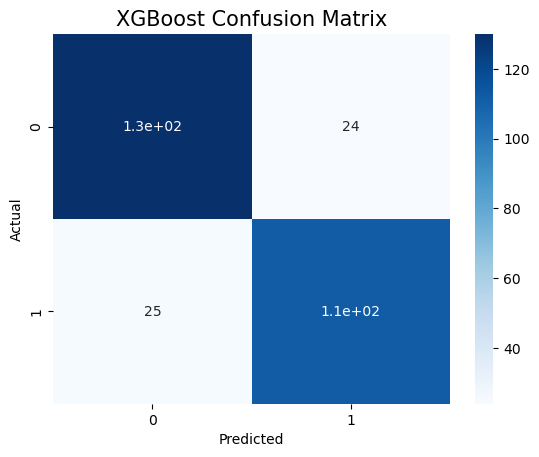

In [122]:
from sklearn.metrics import accuracy_score
print('train set accuracy is:',accuracy_score(y_train, best_xgb.predict(X_train)))
print('test set accuracy is:',accuracy_score(y_test, xgb_y_hat))
from sklearn.metrics import classification_report
print(classification_report(y_test, xgb_y_hat))
from sklearn.metrics import confusion_matrix
xgb_conf_matrix = confusion_matrix(y_test, xgb_y_hat)
sns.heatmap(xgb_conf_matrix, annot=True, cmap='Blues')
plt.title('XGBoost Confusion Matrix', size=15)
plt.ylabel('Actual')
plt.xlabel('Predicted')
# plt.savefig('KNN conf matrix.png')

### ViT L 32 imagenet21k + imagenet2016

In [17]:
import tensorflow as tf
from vit_keras import vit
import tensorflow_addons as tfa
import warnings

image_size_384 = 384
# Load pre-trained ViT model
vit_l32 = vit.vit_l32(
                    image_size = image_size_384,
                    activation = 'sigmoid',
                    pretrained = True,
                    include_top = False,
                    pretrained_top = False,
                    weights = "imagenet21k+imagenet2012"
)

In [19]:
X_train_normalized_vit_l32 = vit_l32.predict(X_train_384_vit_normalized)
np.save('X_train_normalized_vit_l32.npy', X_train_normalized_vit_l32)
X_test_normalized_vit_l32 = vit_l32.predict(X_test_384_vit_normalized)
np.save('X_test_normalized_vit_l32.npy', X_test_normalized_vit_l32)

37/37 [==============================] - 1249s 34s/step


In [41]:
X_train_normalized_vit_l32 = np.load('X_train_normalized_vit_l32.npy')
print(X_train_normalized_vit_l32.shape)
X_test_normalized_vit_l32 = np.load('X_test_normalized_vit_l32.npy')
print(X_test_normalized_vit_l32.shape)

(1163, 1024)
(291, 1024)


In [44]:
from sklearn.model_selection import GridSearchCV, KFold
xgb_kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# Define the parameter grid for grid search
# xgb_param_grid = {
#     'max_depth': [3, 6, 9],
#     'learning_rate': [0.1, 0.01, 0.001],
#     'n_estimators': [50, 100, 200]
# }

# Create the XGBoost classifier
xgb_vit_l32 = xgb.XGBClassifier(
    max_depth = 3,
    learning_rate = 0.1,
    n_estimators = 50
    )

xgb_vit_l32.fit(
    X_train_normalized_vit_l32, 
    y_train_1d
    )


xgb_vit_l32_prediction = xgb_vit_l32.predict(X_test_normalized_vit_l32)

from sklearn.metrics import accuracy_score
print('train set accuracy is:', accuracy_score(y_train_1d, xgb_vit_l32.predict(X_train_normalized_vit_l32)))
print('test set accuracy is:', accuracy_score(y_test_1d, xgb_vit_l32_prediction))
from sklearn.metrics import classification_report
print(classification_report(y_test_1d, xgb_vit_l32_prediction))

train set accuracy is: 0.9346517626827171
test set accuracy is: 0.8350515463917526
              precision    recall  f1-score   support

           0       0.80      0.91      0.85       154
           1       0.88      0.75      0.81       137

    accuracy                           0.84       291
   macro avg       0.84      0.83      0.83       291
weighted avg       0.84      0.84      0.83       291



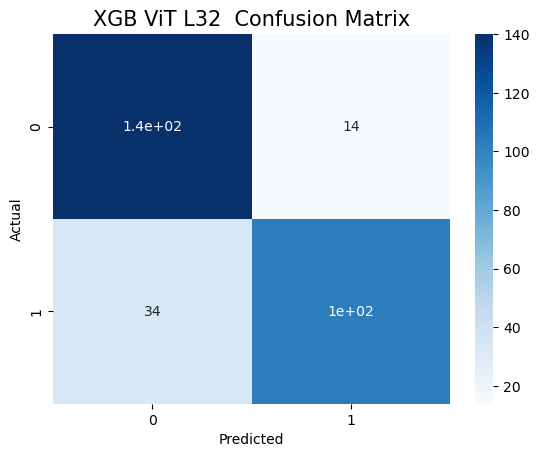

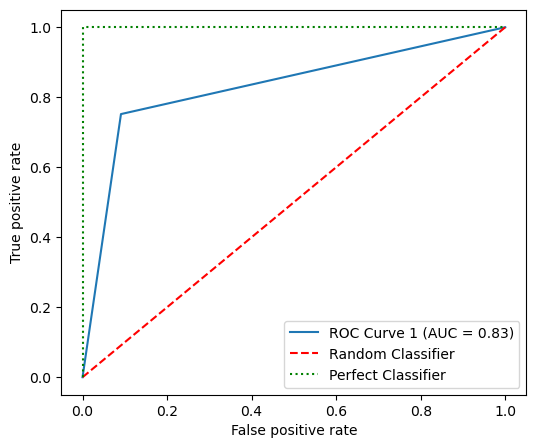

In [59]:
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(y_test_1d, xgb_vit_l32_prediction)
sns.heatmap(conf_matrix,annot=True,cmap='Blues')
plt.title('XGB ViT L32  Confusion Matrix',size=15)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.savefig('XGB ViT L32  conf matrix.png')


from sklearn.metrics import roc_curve, auc, roc_auc_score
fpr , tpr , _ = roc_curve(y_test_1d, xgb_vit_l32_prediction)
auc = roc_auc_score(y_test_1d, xgb_vit_l32_prediction)
fig, ax = plt.subplots(figsize=(6, 5))
plt.plot(fpr, tpr, label='ROC Curve 1 (AUC = %0.2f)' % (auc))
plt.plot([0, 1], [0, 1], linestyle='--', color='red', label='Random Classifier')   
plt.plot([0, 0, 1], [0, 1, 1], linestyle=':', color='green', label='Perfect Classifier')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend(loc="lower right")
plt.savefig('XGB ViT L32  AUC ROC.png')

In [46]:
from sklearn.ensemble import RandomForestClassifier
rf_vit_l32 = RandomForestClassifier()
rf_vit_l32.fit(X_train_normalized_vit_l32, y_train_1d)

#Now predict using the trained  model. 
rf_vit_l32_prediction = rf_vit_l32.predict(X_test_normalized_vit_l32)


from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
print('train set accuracy is:',accuracy_score(y_train_1d, rf_vit_l32.predict(X_train_normalized_vit_l32)))
print('test set accuracy is:',accuracy_score(y_test_1d, rf_vit_l32_prediction))
print(classification_report(y_test_1d, rf_vit_l32_prediction))

train set accuracy is: 1.0
test set accuracy is: 0.8384879725085911
              precision    recall  f1-score   support

           0       0.81      0.90      0.86       154
           1       0.88      0.77      0.82       137

    accuracy                           0.84       291
   macro avg       0.84      0.83      0.84       291
weighted avg       0.84      0.84      0.84       291



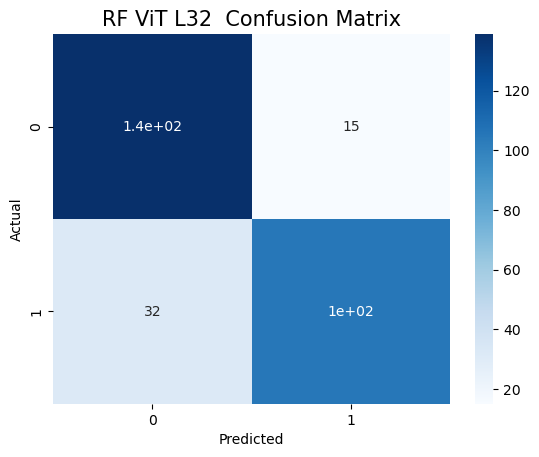

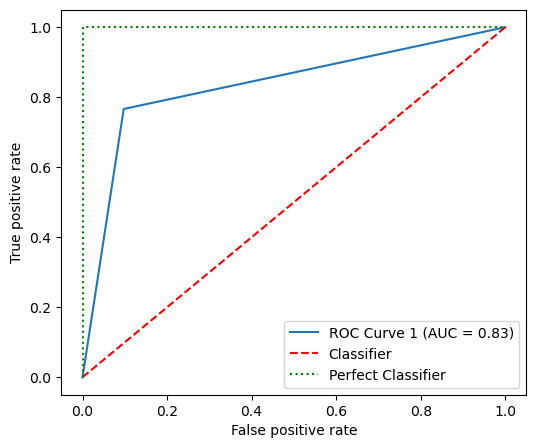

In [58]:
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(y_test_1d, rf_vit_l32_prediction)
sns.heatmap(conf_matrix,annot=True,cmap='Blues')
plt.title('RF ViT L32  Confusion Matrix',size=15)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.savefig('RF ViT L32  conf matrix.png')


from sklearn.metrics import roc_curve, auc, roc_auc_score
fpr , tpr , _ = roc_curve(y_test_1d, rf_vit_l32_prediction)
auc = roc_auc_score(y_test_1d, rf_vit_l32_prediction)
fig, ax = plt.subplots(figsize=(6, 5))
plt.plot(fpr, tpr, label='ROC Curve 1 (AUC = %0.2f)' % (auc))
plt.plot([0, 1], [0, 1], linestyle='--', color='red', label='Classifier')   
plt.plot([0, 0, 1], [0, 1, 1], linestyle=':', color='green', label='Perfect Classifier')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend(loc="lower right")
plt.savefig('RF ViT L32  AUC ROC.png')

In [96]:
from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.model_selection import cross_val_score



bag_vit_l32 = BaggingClassifier()
bag_vit_l32.fit(X_train_normalized_vit_l32, y_train_1d)
bag_vit_l32_prediction = bag_vit_l32.predict(X_test_normalized_vit_l32)

#Print overall accuracy

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
print('train set accuracy is:',accuracy_score(y_train_1d, bag_vit_l32.predict(X_train_normalized_vit_l32)))
print('test set accuracy is:',accuracy_score(y_test_1d, bag_vit_l32_prediction))

print(classification_report(y_test_1d, bag_vit_l32_prediction))

train set accuracy is: 0.9879621668099742
test set accuracy is: 0.7869415807560137
              precision    recall  f1-score   support

           0       0.76      0.86      0.81       154
           1       0.82      0.70      0.76       137

    accuracy                           0.79       291
   macro avg       0.79      0.78      0.78       291
weighted avg       0.79      0.79      0.79       291



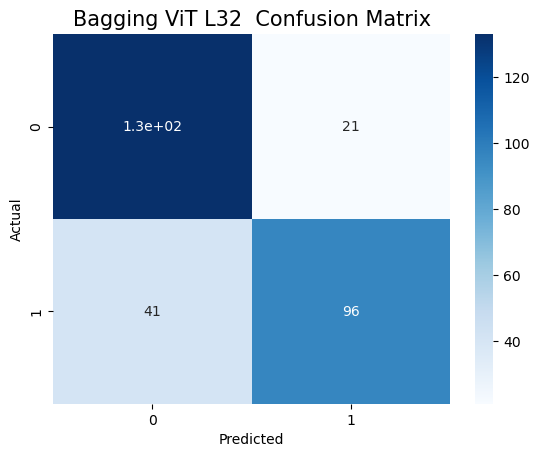

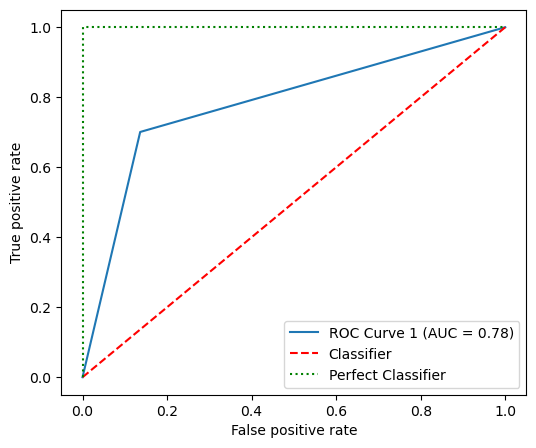

In [97]:
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(y_test_1d,bag_vit_l32_prediction)
sns.heatmap(conf_matrix,annot=True,cmap='Blues')
plt.title('Bagging ViT L32  Confusion Matrix',size=15)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.savefig('Bagging ViT L32  conf matrix.png')


from sklearn.metrics import roc_curve, auc, roc_auc_score
fpr , tpr , _ = roc_curve(y_test_1d, bag_vit_l32_prediction)
auc = roc_auc_score(y_test_1d, bag_vit_l32_prediction)
fig, ax = plt.subplots(figsize=(6, 5))
plt.plot(fpr, tpr, label='ROC Curve 1 (AUC = %0.2f)' % (auc))
plt.plot([0, 1], [0, 1], linestyle='--', color='red', label='Classifier')   
plt.plot([0, 0, 1], [0, 1, 1], linestyle=':', color='green', label='Perfect Classifier')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend(loc="lower right")
plt.savefig('Bagging ViT L32 AUC ROC.png')

In [98]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.model_selection import cross_val_score



abc_vit_l32 = AdaBoostClassifier()
abc_vit_l32.fit(X_train_normalized_vit_l32, y_train_1d)
abc_vit_l32_prediction = abc_vit_l32.predict(X_test_normalized_vit_l32)

#Print overall accuracy

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
print('train set accuracy is:',accuracy_score(y_train_1d, abc_vit_l32.predict(X_train_normalized_vit_l32)))
print('test set accuracy is:',accuracy_score(y_test_1d, abc_vit_l32_prediction))

print(classification_report(y_test_1d, abc_vit_l32_prediction))

train set accuracy is: 0.9071367153912295
test set accuracy is: 0.8109965635738832
              precision    recall  f1-score   support

           0       0.83      0.81      0.82       154
           1       0.79      0.81      0.80       137

    accuracy                           0.81       291
   macro avg       0.81      0.81      0.81       291
weighted avg       0.81      0.81      0.81       291



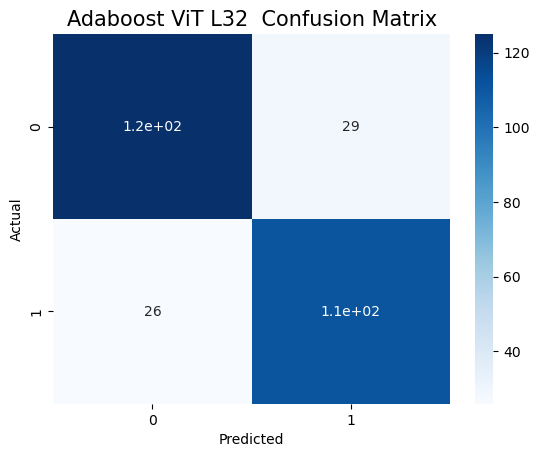

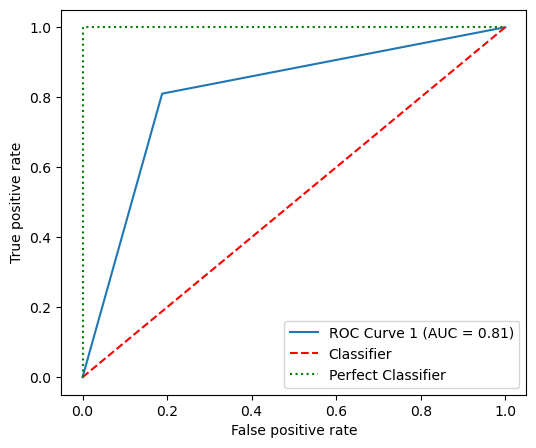

In [99]:
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(y_test_1d, abc_vit_l32_prediction)
sns.heatmap(conf_matrix,annot=True,cmap='Blues')
plt.title('Adaboost ViT L32  Confusion Matrix',size=15)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.savefig('Adaboost ViT L32  conf matrix.png')


from sklearn.metrics import roc_curve, auc, roc_auc_score
fpr , tpr , _ = roc_curve(y_test_1d, abc_vit_l32_prediction)
auc = roc_auc_score(y_test_1d, abc_vit_l32_prediction)
fig, ax = plt.subplots(figsize=(6, 5))
plt.plot(fpr, tpr, label='ROC Curve 1 (AUC = %0.2f)' % (auc))
plt.plot([0, 1], [0, 1], linestyle='--', color='red', label='Classifier')   
plt.plot([0, 0, 1], [0, 1, 1], linestyle=':', color='green', label='Perfect Classifier')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend(loc="lower right")
plt.savefig('Adaboost ViT L32  AUC ROC.png')

### ViT L 32 imagenet21k

In [22]:
import tensorflow as tf
from vit_keras import vit
import tensorflow_addons as tfa
import warnings

image_size_384 = 384
# Load pre-trained ViT model
vit_l32_imagenet21k = vit.vit_l32(
                    image_size = image_size_384,
                    activation = 'sigmoid',
                    pretrained = True,
                    include_top = False,
                    pretrained_top = False,
                    weights = "imagenet21k"
)

In [23]:
X_train_normalized_vit_l32_imagenet21k = vit_l32_imagenet21k.predict(X_train_384_vit_normalized)
np.save('X_train_normalized_vit_l32_imagenet21k.npy', X_train_normalized_vit_l32_imagenet21k)
X_test_normalized_vit_l32_imagenet21k = vit_l32_imagenet21k.predict(X_test_384_vit_normalized)
np.save('X_test_normalized_vit_l32_imagenet21k.npy', X_test_normalized_vit_l32_imagenet21k)

37/37 [==============================] - 1118s 30s/step


In [52]:
X_train_normalized_vit_l32_imagenet21k = np.load('X_train_normalized_vit_l32_imagenet21k.npy')
print(X_train_normalized_vit_l32_imagenet21k.shape)
X_test_normalized_vit_l32_imagenet21k = np.load('X_test_normalized_vit_l32_imagenet21k.npy')
print(X_test_normalized_vit_l32_imagenet21k.shape)

(1163, 1024)
(291, 1024)


In [54]:
from sklearn.model_selection import GridSearchCV, KFold
xgb_kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# Define the parameter grid for grid search
# xgb_param_grid = {
#     'max_depth': [3, 6, 9],
#     'learning_rate': [0.1, 0.01, 0.001],
#     'n_estimators': [50, 100, 200]
# }

# Create the XGBoost classifier
xgb_vit_l32_imagenet21k = xgb.XGBClassifier(
    max_depth = 3,
    learning_rate = 0.1,
    n_estimators = 50
    )

xgb_vit_l32_imagenet21k.fit(
    X_train_normalized_vit_l32_imagenet21k, 
    y_train_1d
    )


xgb_vit_l32_imagenet21k_prediction = xgb_vit_l32_imagenet21k.predict(X_test_normalized_vit_l32_imagenet21k)

from sklearn.metrics import accuracy_score
print('train set accuracy is:', accuracy_score(y_train_1d, xgb_vit_l32_imagenet21k.predict(X_train_normalized_vit_l32_imagenet21k)))
print('test set accuracy is:', accuracy_score(y_test_1d, xgb_vit_l32_imagenet21k_prediction))
from sklearn.metrics import classification_report
print(classification_report(y_test_1d, xgb_vit_l32_imagenet21k_prediction))

train set accuracy is: 0.9028374892519346
test set accuracy is: 0.8041237113402062
              precision    recall  f1-score   support

           0       0.78      0.87      0.82       154
           1       0.83      0.73      0.78       137

    accuracy                           0.80       291
   macro avg       0.81      0.80      0.80       291
weighted avg       0.81      0.80      0.80       291



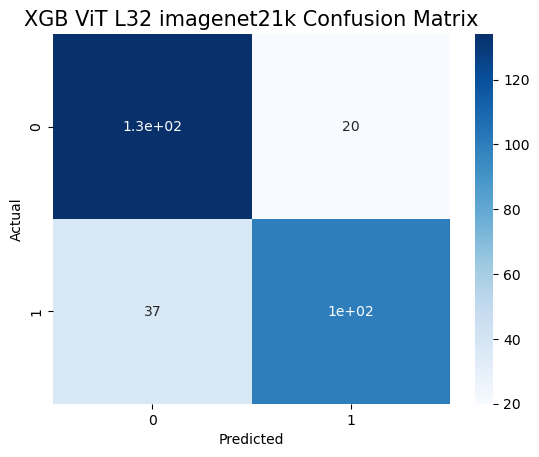

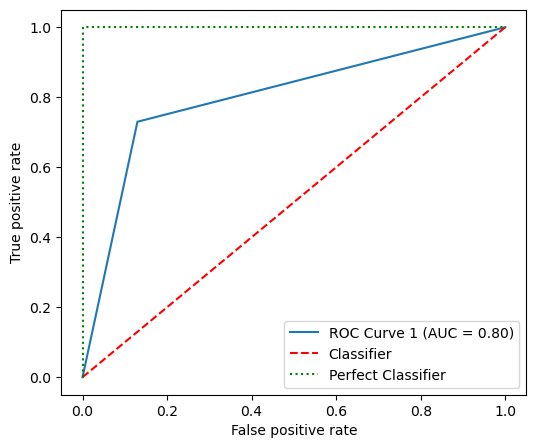

In [55]:
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(y_test_1d, xgb_vit_l32_imagenet21k_prediction)
sns.heatmap(conf_matrix,annot=True,cmap='Blues')
plt.title('XGB ViT L32 imagenet21k Confusion Matrix',size=15)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.savefig('XGB ViT L32 imagenet21k conf matrix.png')


from sklearn.metrics import roc_curve, auc, roc_auc_score
fpr , tpr , _ = roc_curve(y_test_1d, xgb_vit_l32_imagenet21k_prediction)
auc = roc_auc_score(y_test_1d, xgb_vit_l32_imagenet21k_prediction)
fig, ax = plt.subplots(figsize=(6, 5))
plt.plot(fpr, tpr, label='ROC Curve 1 (AUC = %0.2f)' % (auc))
plt.plot([0, 1], [0, 1], linestyle='--', color='red', label='Classifier')   
plt.plot([0, 0, 1], [0, 1, 1], linestyle=':', color='green', label='Perfect Classifier')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend(loc="lower right")
plt.savefig('XGB ViT L32 imagenet21k AUC ROC.png')

In [61]:
from sklearn.ensemble import RandomForestClassifier
rf_vit_l32_imagenet21k = RandomForestClassifier()
rf_vit_l32_imagenet21k.fit(X_train_normalized_vit_l32_imagenet21k, y_train_1d)

#Now predict using the trained  model. 
rf_vit_l32_imagenet21k_prediction = rf_vit_l32_imagenet21k.predict(X_test_normalized_vit_l32_imagenet21k)


from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
print('train set accuracy is:',accuracy_score(y_train_1d, rf_vit_l32_imagenet21k.predict(X_train_normalized_vit_l32_imagenet21k)))
print('test set accuracy is:',accuracy_score(y_test_1d, rf_vit_l32_imagenet21k_prediction))
print(classification_report(y_test_1d, rf_vit_l32_imagenet21k_prediction))

train set accuracy is: 1.0
test set accuracy is: 0.8213058419243986
              precision    recall  f1-score   support

           0       0.79      0.90      0.84       154
           1       0.86      0.74      0.80       137

    accuracy                           0.82       291
   macro avg       0.83      0.82      0.82       291
weighted avg       0.83      0.82      0.82       291



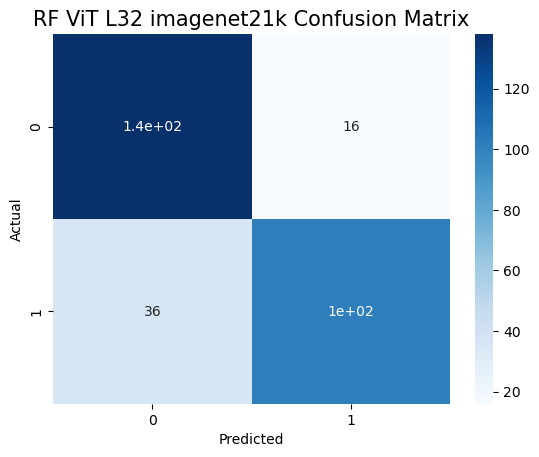

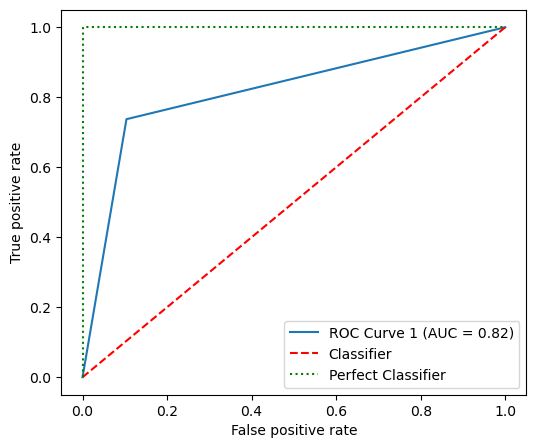

In [62]:
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(y_test_1d, rf_vit_l32_imagenet21k_prediction)
sns.heatmap(conf_matrix,annot=True,cmap='Blues')
plt.title('RF ViT L32 imagenet21k Confusion Matrix',size=15)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.savefig('RF ViT L32 imagenet21k conf matrix.png')


from sklearn.metrics import roc_curve, auc, roc_auc_score
fpr , tpr , _ = roc_curve(y_test_1d, rf_vit_l32_imagenet21k_prediction)
auc = roc_auc_score(y_test_1d, rf_vit_l32_imagenet21k_prediction)
fig, ax = plt.subplots(figsize=(6, 5))
plt.plot(fpr, tpr, label='ROC Curve 1 (AUC = %0.2f)' % (auc))
plt.plot([0, 1], [0, 1], linestyle='--', color='red', label='Classifier')   
plt.plot([0, 0, 1], [0, 1, 1], linestyle=':', color='green', label='Perfect Classifier')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend(loc="lower right")
plt.savefig('RF ViT L32 imagenet21k AUC ROC.png')

In [63]:
from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.model_selection import cross_val_score



bag_vit_l32_imagenet21k = BaggingClassifier()
bag_vit_l32_imagenet21k.fit(X_train_normalized_vit_l32_imagenet21k, y_train_1d)
bag_vit_l32_imagenet21k_prediction = bag_vit_l32_imagenet21k.predict(X_test_normalized_vit_l32_imagenet21k)

#Print overall accuracy

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
print('train set accuracy is:',accuracy_score(y_train_1d, bag_vit_l32_imagenet21k.predict(X_train_normalized_vit_l32_imagenet21k)))
print('test set accuracy is:',accuracy_score(y_test_1d, bag_vit_l32_imagenet21k_prediction))

print(classification_report(y_test_1d, bag_vit_l32_imagenet21k_prediction))

train set accuracy is: 0.9862424763542562
test set accuracy is: 0.8178694158075601
              precision    recall  f1-score   support

           0       0.79      0.90      0.84       154
           1       0.87      0.72      0.79       137

    accuracy                           0.82       291
   macro avg       0.83      0.81      0.81       291
weighted avg       0.82      0.82      0.82       291



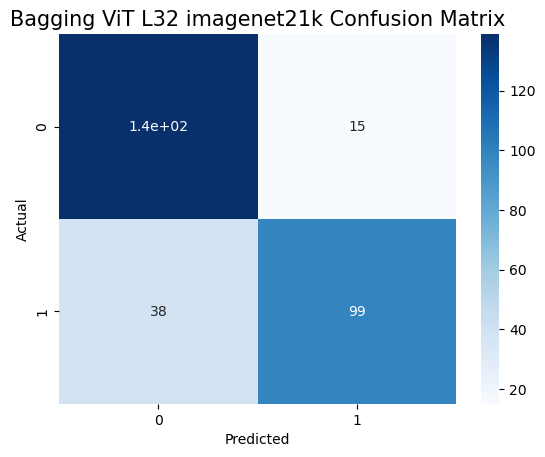

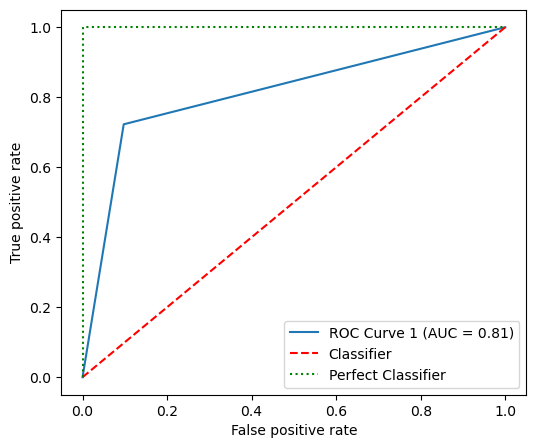

In [65]:
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(y_test_1d, bag_vit_l32_imagenet21k_prediction)
sns.heatmap(conf_matrix,annot=True,cmap='Blues')
plt.title('Bagging ViT L32 imagenet21k Confusion Matrix',size=15)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.savefig('Bagging ViT L32 imagenet21k conf matrix.png')


from sklearn.metrics import roc_curve, auc, roc_auc_score
fpr , tpr , _ = roc_curve(y_test_1d, bag_vit_l32_imagenet21k_prediction)
auc = roc_auc_score(y_test_1d, bag_vit_l32_imagenet21k_prediction)
fig, ax = plt.subplots(figsize=(6, 5))
plt.plot(fpr, tpr, label='ROC Curve 1 (AUC = %0.2f)' % (auc))
plt.plot([0, 1], [0, 1], linestyle='--', color='red', label='Classifier')   
plt.plot([0, 0, 1], [0, 1, 1], linestyle=':', color='green', label='Perfect Classifier')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend(loc="lower right")
plt.savefig('Bagging ViT L32 imagenet21k AUC ROC.png')

In [66]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.model_selection import cross_val_score



abc_vit_l32_imagenet21k = AdaBoostClassifier()
abc_vit_l32_imagenet21k.fit(X_train_normalized_vit_l32_imagenet21k, y_train_1d)
abc_vit_l32_imagenet21k_prediction = abc_vit_l32_imagenet21k.predict(X_test_normalized_vit_l32_imagenet21k)

#Print overall accuracy

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
print('train set accuracy is:',accuracy_score(y_train_1d, abc_vit_l32_imagenet21k.predict(X_train_normalized_vit_l32_imagenet21k)))
print('test set accuracy is:',accuracy_score(y_test_1d, abc_vit_l32_imagenet21k_prediction))

print(classification_report(y_test_1d, abc_vit_l32_imagenet21k_prediction))

train set accuracy is: 0.9122957867583835
test set accuracy is: 0.7697594501718213
              precision    recall  f1-score   support

           0       0.76      0.82      0.79       154
           1       0.78      0.71      0.74       137

    accuracy                           0.77       291
   macro avg       0.77      0.77      0.77       291
weighted avg       0.77      0.77      0.77       291



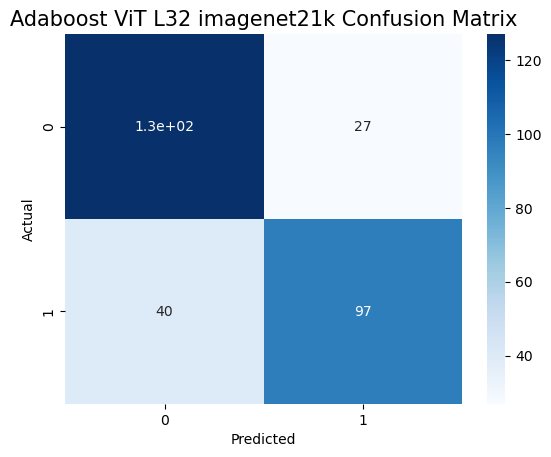

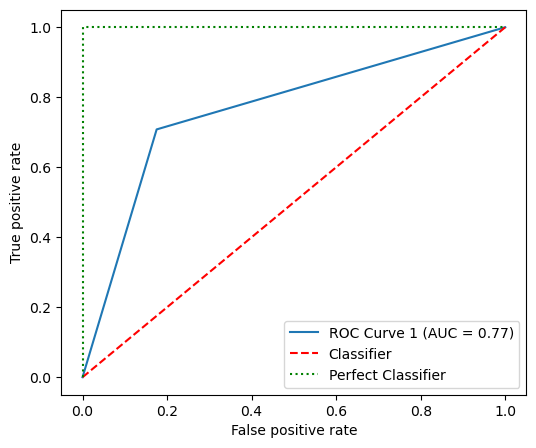

In [67]:
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(y_test_1d, abc_vit_l32_imagenet21k_prediction)
sns.heatmap(conf_matrix,annot=True,cmap='Blues')
plt.title('Adaboost ViT L32 imagenet21k Confusion Matrix',size=15)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.savefig('Adaboost ViT L32 imagenet21k conf matrix.png')


from sklearn.metrics import roc_curve, auc, roc_auc_score
fpr , tpr , _ = roc_curve(y_test_1d, abc_vit_l32_imagenet21k_prediction)
auc = roc_auc_score(y_test_1d, abc_vit_l32_imagenet21k_prediction)
fig, ax = plt.subplots(figsize=(6, 5))
plt.plot(fpr, tpr, label='ROC Curve 1 (AUC = %0.2f)' % (auc))
plt.plot([0, 1], [0, 1], linestyle='--', color='red', label='Classifier')   
plt.plot([0, 0, 1], [0, 1, 1], linestyle=':', color='green', label='Perfect Classifier')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend(loc="lower right")
plt.savefig('Adaboost ViT L32 imagenet21k AUC ROC.png')

# Pretrined Swin Transformer

In [20]:
from glob import glob
def load_data(folder, image_size):
    class_names = [f for f in os.listdir(folder) if not f.startswith('.')]  # Create a list of subfolders

    images_data = []
    labels = []

    print(class_names)
    for t, f in enumerate(class_names):
        images = glob(os.path.join(folder, f, "*"))
        print("Downloading: ", f)
        fig = plt.figure(figsize=(50, 50))
        for im_n, im in enumerate(images):
            plt.gray()
            rgba_image = cv2.imread(im, cv2.IMREAD_UNCHANGED)
            
            # Convert RGBA to RGB if it has an alpha channel
            if rgba_image.shape[2] == 4:
                rgb_image = cv2.cvtColor(rgba_image, cv2.COLOR_RGBA2RGB)
                #Converting image to LAB Color so CLAHE can be applied to the luminance channel
                lab_img = cv2.cvtColor(rgb_image, cv2.COLOR_BGR2LAB)

                #Splitting the LAB image to L, A and B channels, respectively
                l, a, b = cv2.split(lab_img)

                ###########Histogram Equlization#############
                #Apply histogram equalization to the L channel
                equ = cv2.equalizeHist(l)
                #Combine the Hist. equalized L-channel back with A and B channels
                updated_lab_img1 = cv2.merge((equ,a,b))

                #Convert LAB image back to color (RGB)
                hist_eq_img = cv2.cvtColor(updated_lab_img1, cv2.COLOR_LAB2BGR)
            # Resize the image
            image = cv2.resize(hist_eq_img, (image_size, image_size), interpolation=cv2.INTER_LINEAR)
            

            # Flatten the image
            image = image.flatten()

            images_data.append(image)
            labels.append(f)

    return np.array(images_data), np.array(labels)

# Example usage
dir_data = 'c:/data-hommomorphic envelope'
image_size_224 = 224  # Adjust the desired size as needed
loaded_images_224, loaded_labels = load_data(dir_data, image_size=image_size_224)



images_224 = []
labels = []


for feature in loaded_images_224:
    images_224.append(feature)
    
for label in loaded_labels:
    labels.append(label)


# Normalize the data
images_224 = np.array(images_224).astype(np.float32) / 255.0
# images = np.array(images).astype(np.float32) / 255.0
    
images_224 = images_224.reshape(-1, image_size_224, image_size_224, 3)


# Creating a dictionary of clases
lab = {}
for i, l in enumerate(set(labels)):
    lab[l] = i


labels = np.array([lab[l] for l in labels])

['abnormal', 'normal']
Downloading:  abnormal
Downloading:  normal


<Figure size 5000x5000 with 0 Axes>

<Figure size 5000x5000 with 0 Axes>

In [21]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical

encoder = LabelEncoder()
encoder.fit(labels)
encoded_Y = encoder.transform(labels)
dummy_Y = to_categorical(encoded_Y)
dummy_Y.astype(int)


array([[0, 1],
       [0, 1],
       [0, 1],
       ...,
       [1, 0],
       [1, 0],
       [1, 0]])

In [22]:
from sklearn.model_selection import train_test_split
X_train_224_normalized, X_test_224_normalized, y_train, y_test = train_test_split(images_224, dummy_Y, test_size = 0.2, random_state = 42)

### Swin

In [68]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, Conv2D, LayerNormalization, GlobalAveragePooling1D

CFGS = {
    'swin_tiny_224': dict(input_size=(224, 224), window_size=7, embed_dim=96, depths=[2, 2, 6, 2], num_heads=[3, 6, 12, 24]),
    'swin_small_224': dict(input_size=(224, 224), window_size=7, embed_dim=96, depths=[2, 2, 18, 2], num_heads=[3, 6, 12, 24]),
    'swin_base_224': dict(input_size=(224, 224), window_size=7, embed_dim=128, depths=[2, 2, 18, 2], num_heads=[4, 8, 16, 32]),
    'swin_base_384': dict(input_size=(384, 384), window_size=12, embed_dim=128, depths=[2, 2, 18, 2], num_heads=[4, 8, 16, 32]),
    'swin_large_224': dict(input_size=(224, 224), window_size=7, embed_dim=192, depths=[2, 2, 18, 2], num_heads=[6, 12, 24, 48]),
    'swin_large_384': dict(input_size=(384, 384), window_size=12, embed_dim=192, depths=[2, 2, 18, 2], num_heads=[6, 12, 24, 48])
}


class Mlp(tf.keras.layers.Layer):
    def __init__(self, in_features, hidden_features=None, out_features=None, drop=0., prefix=''):
        super().__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features
        self.fc1 = Dense(hidden_features, name=f'{prefix}/mlp/fc1')
        self.fc2 = Dense(out_features, name=f'{prefix}/mlp/fc2')
        self.drop = Dropout(drop)

    def call(self, x):
        x = self.fc1(x)
        x = tf.keras.activations.gelu(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        return x


def window_partition(x, window_size):
    B, H, W, C = x.get_shape().as_list()
    x = tf.reshape(x, shape=[-1, H // window_size,
                   window_size, W // window_size, window_size, C])
    x = tf.transpose(x, perm=[0, 1, 3, 2, 4, 5])
    windows = tf.reshape(x, shape=[-1, window_size, window_size, C])
    return windows


def window_reverse(windows, window_size, H, W, C):
    x = tf.reshape(windows, shape=[-1, H // window_size,
                   W // window_size, window_size, window_size, C])
    x = tf.transpose(x, perm=[0, 1, 3, 2, 4, 5])
    x = tf.reshape(x, shape=[-1, H, W, C])
    return x


class WindowAttention(tf.keras.layers.Layer):
    def __init__(self, dim, window_size, num_heads, qkv_bias=True, qk_scale=None, attn_drop=0., proj_drop=0., prefix=''):
        super().__init__()
        self.dim = dim
        self.window_size = window_size
        self.num_heads = num_heads
        head_dim = dim // num_heads
        self.scale = qk_scale or head_dim ** -0.5
        self.prefix = prefix

        self.qkv = Dense(dim * 3, use_bias=qkv_bias,
                         name=f'{self.prefix}/attn/qkv')
        self.attn_drop = Dropout(attn_drop)
        self.proj = Dense(dim, name=f'{self.prefix}/attn/proj')
        self.proj_drop = Dropout(proj_drop)

    def build(self, input_shape):
        self.relative_position_bias_table = self.add_weight(f'{self.prefix}/attn/relative_position_bias_table',
                                                            shape=(
                                                                (2 * self.window_size[0] - 1) * (2 * self.window_size[1] - 1), self.num_heads),
                                                            initializer=tf.initializers.Zeros(), trainable=True)

        coords_h = np.arange(self.window_size[0])
        coords_w = np.arange(self.window_size[1])
        coords = np.stack(np.meshgrid(coords_h, coords_w, indexing='ij'))
        coords_flatten = coords.reshape(2, -1)
        relative_coords = coords_flatten[:, :,
                                         None] - coords_flatten[:, None, :]
        relative_coords = relative_coords.transpose([1, 2, 0])
        relative_coords[:, :, 0] += self.window_size[0] - 1
        relative_coords[:, :, 1] += self.window_size[1] - 1
        relative_coords[:, :, 0] *= 2 * self.window_size[1] - 1
        relative_position_index = relative_coords.sum(-1).astype(np.int64)
        self.relative_position_index = tf.Variable(initial_value=tf.convert_to_tensor(
            relative_position_index), trainable=False, name=f'{self.prefix}/attn/relative_position_index')
        self.built = True

    def call(self, x, mask=None):
        B_, N, C = x.get_shape().as_list()
        qkv = tf.transpose(tf.reshape(self.qkv(
            x), shape=[-1, N, 3, self.num_heads, C // self.num_heads]), perm=[2, 0, 3, 1, 4])
        q, k, v = qkv[0], qkv[1], qkv[2]

        q = q * self.scale
        attn = (q @ tf.transpose(k, perm=[0, 1, 3, 2]))
        relative_position_bias = tf.gather(self.relative_position_bias_table, tf.reshape(
            self.relative_position_index, shape=[-1]))
        relative_position_bias = tf.reshape(relative_position_bias, shape=[
                                            self.window_size[0] * self.window_size[1], self.window_size[0] * self.window_size[1], -1])
        relative_position_bias = tf.transpose(
            relative_position_bias, perm=[2, 0, 1])
        attn = attn + tf.expand_dims(relative_position_bias, axis=0)

        if mask is not None:
            nW = mask.get_shape()[0]  # tf.shape(mask)[0]
            attn = tf.reshape(attn, shape=[-1, nW, self.num_heads, N, N]) + tf.cast(
                tf.expand_dims(tf.expand_dims(mask, axis=1), axis=0), attn.dtype)
            attn = tf.reshape(attn, shape=[-1, self.num_heads, N, N])
            attn = tf.nn.softmax(attn, axis=-1)
        else:
            attn = tf.nn.softmax(attn, axis=-1)

        attn = self.attn_drop(attn)

        x = tf.transpose((attn @ v), perm=[0, 2, 1, 3])
        x = tf.reshape(x, shape=[-1, N, C])
        x = self.proj(x)
        x = self.proj_drop(x)
        return x


def drop_path(inputs, drop_prob, is_training):
    if (not is_training) or (drop_prob == 0.):
        return inputs

    # Compute keep_prob
    keep_prob = 1.0 - drop_prob

    # Compute drop_connect tensor
    random_tensor = keep_prob
    shape = (tf.shape(inputs)[0],) + (1,) * \
        (len(tf.shape(inputs)) - 1)
    random_tensor += tf.random.uniform(shape, dtype=inputs.dtype)
    binary_tensor = tf.floor(random_tensor)
    output = tf.math.divide(inputs, keep_prob) * binary_tensor
    return output


class DropPath(tf.keras.layers.Layer):
    def __init__(self, drop_prob=None):
        super().__init__()
        self.drop_prob = drop_prob

    def call(self, x, training=None):
        return drop_path(x, self.drop_prob, training)


class SwinTransformerBlock(tf.keras.layers.Layer):
    def __init__(self, dim, input_resolution, num_heads, window_size=7, shift_size=0, mlp_ratio=4.,
                 qkv_bias=True, qk_scale=None, drop=0., attn_drop=0., drop_path_prob=0., norm_layer=LayerNormalization, prefix=''):
        super().__init__()
        self.dim = dim
        self.input_resolution = input_resolution
        self.num_heads = num_heads
        self.window_size = window_size
        self.shift_size = shift_size
        self.mlp_ratio = mlp_ratio
        if min(self.input_resolution) <= self.window_size:
            self.shift_size = 0
            self.window_size = min(self.input_resolution)
        assert 0 <= self.shift_size < self.window_size, "shift_size must in 0-window_size"
        self.prefix = prefix

        self.norm1 = norm_layer(epsilon=1e-5, name=f'{self.prefix}/norm1')
        self.attn = WindowAttention(dim, window_size=(self.window_size, self.window_size), num_heads=num_heads,
                                    qkv_bias=qkv_bias, qk_scale=qk_scale, attn_drop=attn_drop, proj_drop=drop, prefix=self.prefix)
        self.drop_path = DropPath(
            drop_path_prob if drop_path_prob > 0. else 0.)
        self.norm2 = norm_layer(epsilon=1e-5, name=f'{self.prefix}/norm2')
        mlp_hidden_dim = int(dim * mlp_ratio)
        self.mlp = Mlp(in_features=dim, hidden_features=mlp_hidden_dim,
                       drop=drop, prefix=self.prefix)

    def build(self, input_shape):
        if self.shift_size > 0:
            H, W = self.input_resolution
            img_mask = np.zeros([1, H, W, 1])
            h_slices = (slice(0, -self.window_size),
                        slice(-self.window_size, -self.shift_size),
                        slice(-self.shift_size, None))
            w_slices = (slice(0, -self.window_size),
                        slice(-self.window_size, -self.shift_size),
                        slice(-self.shift_size, None))
            cnt = 0
            for h in h_slices:
                for w in w_slices:
                    img_mask[:, h, w, :] = cnt
                    cnt += 1

            img_mask = tf.convert_to_tensor(img_mask)
            mask_windows = window_partition(img_mask, self.window_size)
            mask_windows = tf.reshape(
                mask_windows, shape=[-1, self.window_size * self.window_size])
            attn_mask = tf.expand_dims(
                mask_windows, axis=1) - tf.expand_dims(mask_windows, axis=2)
            attn_mask = tf.where(attn_mask != 0, -100.0, attn_mask)
            attn_mask = tf.where(attn_mask == 0, 0.0, attn_mask)
            self.attn_mask = tf.Variable(
                initial_value=attn_mask, trainable=False, name=f'{self.prefix}/attn_mask')
        else:
            self.attn_mask = None

        self.built = True

    def call(self, x):
        H, W = self.input_resolution
        B, L, C = x.get_shape().as_list()
        assert L == H * W, "input feature has wrong size"

        shortcut = x
        x = self.norm1(x)
        x = tf.reshape(x, shape=[-1, H, W, C])

        # cyclic shift
        if self.shift_size > 0:
            shifted_x = tf.roll(
                x, shift=[-self.shift_size, -self.shift_size], axis=[1, 2])
        else:
            shifted_x = x

        # partition windows
        x_windows = window_partition(shifted_x, self.window_size)
        x_windows = tf.reshape(
            x_windows, shape=[-1, self.window_size * self.window_size, C])

        # W-MSA/SW-MSA
        attn_windows = self.attn(x_windows, mask=self.attn_mask)

        # merge windows
        attn_windows = tf.reshape(
            attn_windows, shape=[-1, self.window_size, self.window_size, C])
        shifted_x = window_reverse(attn_windows, self.window_size, H, W, C)

        # reverse cyclic shift
        if self.shift_size > 0:
            x = tf.roll(shifted_x, shift=[
                        self.shift_size, self.shift_size], axis=[1, 2])
        else:
            x = shifted_x
        x = tf.reshape(x, shape=[-1, H * W, C])

        # FFN
        x = shortcut + self.drop_path(x)
        x = x + self.drop_path(self.mlp(self.norm2(x)))

        return x


class PatchMerging(tf.keras.layers.Layer):
    def __init__(self, input_resolution, dim, norm_layer=LayerNormalization, prefix=''):
        super().__init__()
        self.input_resolution = input_resolution
        self.dim = dim
        self.reduction = Dense(2 * dim, use_bias=False,
                               name=f'{prefix}/downsample/reduction')
        self.norm = norm_layer(epsilon=1e-5, name=f'{prefix}/downsample/norm')

    def call(self, x):
        H, W = self.input_resolution
        B, L, C = x.get_shape().as_list()
        assert L == H * W, "input feature has wrong size"
        assert H % 2 == 0 and W % 2 == 0, f"x size ({H}*{W}) are not even."

        x = tf.reshape(x, shape=[-1, H, W, C])

        x0 = x[:, 0::2, 0::2, :]  # B H/2 W/2 C
        x1 = x[:, 1::2, 0::2, :]  # B H/2 W/2 C
        x2 = x[:, 0::2, 1::2, :]  # B H/2 W/2 C
        x3 = x[:, 1::2, 1::2, :]  # B H/2 W/2 C
        x = tf.concat([x0, x1, x2, x3], axis=-1)
        x = tf.reshape(x, shape=[-1, (H // 2) * (W // 2), 4 * C])

        x = self.norm(x)
        x = self.reduction(x)

        return x


class BasicLayer(tf.keras.layers.Layer):
    def __init__(self, dim, input_resolution, depth, num_heads, window_size,
                 mlp_ratio=4., qkv_bias=True, qk_scale=None, drop=0., attn_drop=0.,
                 drop_path_prob=0., norm_layer=LayerNormalization, downsample=None, use_checkpoint=False, prefix=''):
        super().__init__()
        self.dim = dim
        self.input_resolution = input_resolution
        self.depth = depth
        self.use_checkpoint = use_checkpoint

        # build blocks
        self.blocks = tf.keras.Sequential([SwinTransformerBlock(dim=dim, input_resolution=input_resolution,
                                           num_heads=num_heads, window_size=window_size,
                                           shift_size=0 if (
                                               i % 2 == 0) else window_size // 2,
                                           mlp_ratio=mlp_ratio,
                                           qkv_bias=qkv_bias, qk_scale=qk_scale,
                                           drop=drop, attn_drop=attn_drop,
                                           drop_path_prob=drop_path_prob[i] if isinstance(
                                               drop_path_prob, list) else drop_path_prob,
                                           norm_layer=norm_layer,
                                           prefix=f'{prefix}/blocks{i}') for i in range(depth)])
        if downsample is not None:
            self.downsample = downsample(
                input_resolution, dim=dim, norm_layer=norm_layer, prefix=prefix)
        else:
            self.downsample = None

    def call(self, x):
        x = self.blocks(x)

        if self.downsample is not None:
            x = self.downsample(x)
        return x


class PatchEmbed(tf.keras.layers.Layer):
    def __init__(self, img_size=(224, 224), patch_size=(4, 4), in_chans=3, embed_dim=96, norm_layer=None):
        super().__init__(name='patch_embed')
        patches_resolution = [img_size[0] //
                              patch_size[0], img_size[1] // patch_size[1]]
        self.img_size = img_size
        self.patch_size = patch_size
        self.patches_resolution = patches_resolution
        self.num_patches = patches_resolution[0] * patches_resolution[1]

        self.in_chans = in_chans
        self.embed_dim = embed_dim

        self.proj = Conv2D(embed_dim, kernel_size=patch_size,
                           strides=patch_size, name='proj')
        if norm_layer is not None:
            self.norm = norm_layer(epsilon=1e-5, name='norm')
        else:
            self.norm = None

    def call(self, x):
        B, H, W, C = x.get_shape().as_list()
        assert H == self.img_size[0] and W == self.img_size[1], \
            f"Input image size ({H}*{W}) doesn't match model ({self.img_size[0]}*{self.img_size[1]})."
        x = self.proj(x)
        x = tf.reshape(
            x, shape=[-1, (H // self.patch_size[0]) * (W // self.patch_size[0]), self.embed_dim])
        if self.norm is not None:
            x = self.norm(x)
        return x


class SwinTransformerModel(tf.keras.Model):
    def __init__(self, model_name='swin_tiny_patch4_window7_224', include_top=False,
                 img_size=(224, 224), patch_size=(4, 4), in_chans=3, num_classes=1000,
                 embed_dim=96, depths=[2, 2, 6, 2], num_heads=[3, 6, 12, 24],
                 window_size=7, mlp_ratio=4., qkv_bias=True, qk_scale=None,
                 drop_rate=0., attn_drop_rate=0., drop_path_rate=0.1,
                 norm_layer=LayerNormalization, ape=False, patch_norm=True,
                 use_checkpoint=False, **kwargs):
        super().__init__(name=model_name)

        self.include_top = include_top

        self.num_classes = num_classes
        self.num_layers = len(depths)
        self.embed_dim = embed_dim
        self.ape = ape
        self.patch_norm = patch_norm
        self.num_features = int(embed_dim * 2 ** (self.num_layers - 1))
        self.mlp_ratio = mlp_ratio

        # split image into non-overlapping patches
        self.patch_embed = PatchEmbed(
            img_size=img_size, patch_size=patch_size, in_chans=in_chans, embed_dim=embed_dim,
            norm_layer=norm_layer if self.patch_norm else None)
        num_patches = self.patch_embed.num_patches
        patches_resolution = self.patch_embed.patches_resolution
        self.patches_resolution = patches_resolution

        # absolute postion embedding
        if self.ape:
            self.absolute_pos_embed = self.add_weight('absolute_pos_embed',
                                                      shape=(
                                                          1, num_patches, embed_dim),
                                                      initializer=tf.initializers.Zeros())

        self.pos_drop = Dropout(drop_rate)

        # stochastic depth
        dpr = [x for x in np.linspace(0., drop_path_rate, sum(depths))]

        # build layers
        self.basic_layers = tf.keras.Sequential([BasicLayer(dim=int(embed_dim * 2 ** i_layer),
                                                input_resolution=(patches_resolution[0] // (2 ** i_layer),
                                                                  patches_resolution[1] // (2 ** i_layer)),
                                                depth=depths[i_layer],
                                                num_heads=num_heads[i_layer],
                                                window_size=window_size,
                                                mlp_ratio=self.mlp_ratio,
                                                qkv_bias=qkv_bias, qk_scale=qk_scale,
                                                drop=drop_rate, attn_drop=attn_drop_rate,
                                                drop_path_prob=dpr[sum(depths[:i_layer]):sum(
                                                    depths[:i_layer + 1])],
                                                norm_layer=norm_layer,
                                                downsample=PatchMerging if (
                                                    i_layer < self.num_layers - 1) else None,
                                                use_checkpoint=use_checkpoint,
                                                prefix=f'layers{i_layer}') for i_layer in range(self.num_layers)])
        self.norm = norm_layer(epsilon=1e-5, name='norm')
        self.avgpool = GlobalAveragePooling1D()
        if self.include_top:
            self.head = Dense(num_classes, name='head')
        else:
            self.head = None

    def forward_features(self, x):
        x = self.patch_embed(x)
        if self.ape:
            x = x + self.absolute_pos_embed
        x = self.pos_drop(x)

        x = self.basic_layers(x)
        x = self.norm(x)
        x = self.avgpool(x)
        return x

    def call(self, x):
        x = self.forward_features(x)
        if self.include_top:
            x = self.head(x)
        return x


def SwinTransformer(model_name='swin_tiny_224', num_classes=1000, include_top=True, pretrained=True, use_tpu=False, cfgs=CFGS):
    cfg = cfgs[model_name]
    net = SwinTransformerModel(
        model_name=model_name, include_top=include_top, num_classes=num_classes, img_size=cfg['input_size'], window_size=cfg[
            'window_size'], embed_dim=cfg['embed_dim'], depths=cfg['depths'], num_heads=cfg['num_heads']
    )
    net(tf.keras.Input(shape=(cfg['input_size'][0], cfg['input_size'][1], 3)))
    if pretrained is True:
        url = f'https://github.com/rishigami/Swin-Transformer-TF/releases/download/v0.1-tf-swin-weights/{model_name}.tgz'
        pretrained_ckpt = tf.keras.utils.get_file(
            model_name, url, untar=True)
    else:
        pretrained_ckpt = pretrained

    if pretrained_ckpt:
        if tf.io.gfile.isdir(pretrained_ckpt):
            pretrained_ckpt = f'{pretrained_ckpt}/{model_name}.ckpt'

        if use_tpu:
            load_locally = tf.saved_model.LoadOptions(
                experimental_io_device='/job:localhost')
            net.load_weights(pretrained_ckpt, options=load_locally)
        else:
            net.load_weights(pretrained_ckpt)

    return net

### Swin tiny 224

In [7]:
swin_tiny_224 = SwinTransformer('swin_tiny_224', 
                                num_classes = 2, 
                                include_top = False, 
                                pretrained = True)

In [14]:
NUM_CLASSES = 2
image_size_224 = 224

swin_tiny_224 = tf.keras.Sequential([
  tf.keras.layers.Lambda(lambda data: tf.keras.applications.imagenet_utils.preprocess_input(tf.cast(data, tf.float32), 
  mode="torch"), 
  input_shape=[image_size_224, image_size_224, 3]),
  SwinTransformer('swin_tiny_224', num_classes = 2, include_top=False, pretrained=True)
  
])

In [37]:
X_train_swin_tiny_224_normalized = swin_tiny_224.predict (X_train_224_normalized)
X_test_swin_tiny_224_normalized = swin_tiny_224.predict (X_test_224_normalized)
np.save('X_train_swin_tiny_224_normalized.npy', X_train_swin_tiny_224_normalized)
np.save('X_test_swin_tiny_224_normalized.npy', X_test_swin_tiny_224_normalized)

10/10 [==============================] - 58s 6s/step


In [38]:
X_train_swin_tiny_224_normalized = np.load('X_train_swin_tiny_224_normalized.npy')
print(X_train_swin_tiny_224_normalized.shape)
X_test_swin_tiny_224_normalized = np.load('X_test_swin_tiny_224_normalized.npy')
print(X_test_swin_tiny_224_normalized.shape)

(1163, 768)
(291, 768)


In [53]:
# y_train = y_train[:, 0]
# y_test = y_test[:, 0]

In [54]:
from sklearn.model_selection import GridSearchCV, KFold
xgb_kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# Define the parameter grid for grid search
# xgb_param_grid = {
#     'max_depth': [3, 6, 9],
#     'learning_rate': [0.1, 0.01, 0.001],
#     'n_estimators': [50, 100, 200]
# }

# Create the XGBoost classifier
xgb_swin_tiny_224 = xgb.XGBClassifier(
    max_depth = 3,
    learning_rate = 0.1,
    n_estimators = 50
    )

xgb_swin_tiny_224.fit(
    X_train_swin_tiny_224_normalized, 
    y_train
    )

xgb_swin_tiny_224_prediction = xgb_swin_tiny_224.predict(X_test_swin_tiny_224_normalized)

from sklearn.metrics import accuracy_score
print('train set accuracy is:', accuracy_score(y_train, xgb_swin_tiny_224.predict(X_train_swin_tiny_224_normalized)))
print('test set accuracy is:', accuracy_score(y_test, xgb_swin_tiny_224_prediction))
from sklearn.metrics import classification_report
print(classification_report(y_test, xgb_swin_tiny_224_prediction))

train set accuracy is: 0.9484092863284609
test set accuracy is: 0.7800687285223368
              precision    recall  f1-score   support

         0.0       0.77      0.84      0.80       154
         1.0       0.80      0.72      0.75       137

    accuracy                           0.78       291
   macro avg       0.78      0.78      0.78       291
weighted avg       0.78      0.78      0.78       291



In [32]:
X_train_swin_tiny_224 = swin_tiny_224.predict (X_train_224)
X_test_swin_tiny_224 = swin_tiny_224.predict (X_test_224)
np.save('X_train_swin_tiny_224.npy', X_train_swin_tiny_224)
np.save('X_test_swin_tiny_224.npy', X_test_swin_tiny_224)

10/10 [==============================] - 53s 5s/step


In [56]:
X_train_swin_tiny_224 = np.load('X_train_swin_tiny_224.npy')
print(X_train_swin_tiny_224.shape)
X_test_swin_tiny_224 = np.load('X_test_swin_tiny_224.npy')
print(X_test_swin_tiny_224.shape)

(1163, 768)
(291, 768)


In [57]:
from sklearn.model_selection import GridSearchCV, KFold
xgb_kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# Define the parameter grid for grid search
# xgb_param_grid = {
#     'max_depth': [3, 6, 9],
#     'learning_rate': [0.1, 0.01, 0.001],
#     'n_estimators': [50, 100, 200]
# }

# Create the XGBoost classifier
xgb_swin_tiny_224 = xgb.XGBClassifier(
    max_depth = 3,
    learning_rate = 0.1,
    n_estimators = 50
    )

xgb_swin_tiny_224.fit(
    X_train_swin_tiny_224, 
    y_train
    )

xgb_swin_tiny_224_prediction = xgb_swin_tiny_224.predict(X_test_swin_tiny_224)

from sklearn.metrics import accuracy_score
print('train set accuracy is:', accuracy_score(y_train, xgb_swin_tiny_224.predict(X_train_swin_tiny_224)))
print('test set accuracy is:', accuracy_score(y_test, xgb_swin_tiny_224_prediction))
from sklearn.metrics import classification_report
print(classification_report(y_test, xgb_swin_tiny_224_prediction))

train set accuracy is: 0.9355116079105761
test set accuracy is: 0.7628865979381443
              precision    recall  f1-score   support

         0.0       0.76      0.80      0.78       154
         1.0       0.76      0.72      0.74       137

    accuracy                           0.76       291
   macro avg       0.76      0.76      0.76       291
weighted avg       0.76      0.76      0.76       291



In [21]:
'''
Train  random forest classifier on efficient net
'''
rf = RandomForestClassifier(n_estimators=10, random_state=42)
rf.fit(X_train_swin_tiny_224, y_train)
# Evaluate the classifier on the test set
accuracy_train = rf.score(X_train_swin_tiny_224, y_train)
accuracy_test = rf.score(X_test_swin_tiny_224, y_test)
print('Random Forest train Accuracy:', accuracy_train)
print('Random Forest test Accuracy:', accuracy_test)

Random Forest train Accuracy: 0.9810834049871023
Random Forest test Accuracy: 0.6494845360824743


### Swin small 224

In [12]:
swin_small_224 = SwinTransformer('swin_small_224', 
                                    num_classes=2, 
                                    include_top=False, 
                                    pretrained=True
                                    )

In [22]:
NUM_CLASSES = 2
image_size_224 = 224
swin_small_224 = tf.keras.Sequential([
  tf.keras.layers.Lambda(lambda data: tf.keras.applications.imagenet_utils.preprocess_input(tf.cast(data, tf.float32), 
  mode="torch"), 
  input_shape=[image_size_224, image_size_224, 3]),
  SwinTransformer('swin_small_224', num_classes=2,  include_top=False, pretrained=True),
])

In [42]:
X_train_swin_small_224_normalized = swin_small_224.predict(X_train_224_normalized)
X_test_swin_small_224_normalized = swin_small_224.predict(X_test_224_normalized)
np.save('X_train_swin_small_224_normalized.npy', X_train_swin_small_224_normalized)
np.save('X_test_swin_small_224_normalized.npy', X_test_swin_small_224_normalized)

10/10 [==============================] - 100s 10s/step


In [58]:
X_train_swin_small_224_normalized = np.load('X_train_swin_small_224_normalized.npy')
print(X_train_swin_small_224_normalized.shape)
X_test_swin_small_224_normalized = np.load('X_test_swin_small_224_normalized.npy')
print(X_test_swin_small_224_normalized.shape)

(1163, 768)
(291, 768)


In [59]:
from sklearn.model_selection import GridSearchCV, KFold
xgb_kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# Define the parameter grid for grid search
# xgb_param_grid = {
#     'max_depth': [3, 6, 9],
#     'learning_rate': [0.1, 0.01, 0.001],
#     'n_estimators': [50, 100, 200]
# }

# Create the XGBoost classifier
xgb_swin_small_224 = xgb.XGBClassifier(
    max_depth = 3,
    learning_rate = 0.1,
    n_estimators = 50
    )

xgb_swin_small_224.fit(
    X_train_swin_small_224_normalized, 
    y_train
    )

xgb_swin_small_224_prediction = xgb_swin_small_224.predict(X_test_swin_small_224_normalized)

from sklearn.metrics import accuracy_score
print('train set accuracy is:', accuracy_score(y_train, xgb_swin_small_224.predict(X_train_swin_small_224_normalized)))
print('test set accuracy is:', accuracy_score(y_test, xgb_swin_small_224_prediction))
from sklearn.metrics import classification_report
print(classification_report(y_test, xgb_swin_small_224_prediction))

train set accuracy is: 0.938950988822012
test set accuracy is: 0.7663230240549829
              precision    recall  f1-score   support

         0.0       0.74      0.85      0.79       154
         1.0       0.80      0.67      0.73       137

    accuracy                           0.77       291
   macro avg       0.77      0.76      0.76       291
weighted avg       0.77      0.77      0.76       291



In [29]:
X_train_swin_small_224 = swin_small_224.predict(X_train_224)
X_test_swin_small_224 = swin_small_224.predict(X_test_224)
np.save('X_train_swin_small_224.npy', X_train_swin_small_224)
np.save('X_test_swin_small_224.npy', X_test_swin_small_224)

10/10 [==============================] - 97s 10s/step


In [30]:
X_train_swin_small_224 = np.load('X_train_swin_small_224.npy')
print(X_train_swin_small_224.shape)
X_test_swin_small_224 =  np.load('X_test_swin_small_224.npy')
print(X_test_swin_small_224.shape)

(1163, 768)
(291, 768)


In [31]:
from sklearn.model_selection import GridSearchCV, KFold
xgb_kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# Define the parameter grid for grid search
# xgb_param_grid = {
#     'max_depth': [3, 6, 9],
#     'learning_rate': [0.1, 0.01, 0.001],
#     'n_estimators': [50, 100, 200]
# }

# Create the XGBoost classifier
xgb_swin_small_224 = xgb.XGBClassifier(
    max_depth = 3,
    learning_rate = 0.1,
    n_estimators = 50
    )

xgb_swin_small_224.fit(
    X_train_swin_small_224, 
    y_train
    )

xgb_swin_small_224_prediction = xgb_swin_small_224.predict(X_test_swin_small_224)

from sklearn.metrics import accuracy_score
print('train set accuracy is:', accuracy_score(y_train, xgb_swin_small_224.predict(X_train_swin_small_224)))
print('test set accuracy is:', accuracy_score(y_test, xgb_swin_small_224_prediction))
from sklearn.metrics import classification_report
print(classification_report(y_test, xgb_swin_small_224_prediction))

train set accuracy is: 0.9363714531384351
test set accuracy is: 0.7903780068728522
              precision    recall  f1-score   support

           0       0.78      0.77      0.77       137
           1       0.80      0.81      0.80       154

   micro avg       0.79      0.79      0.79       291
   macro avg       0.79      0.79      0.79       291
weighted avg       0.79      0.79      0.79       291
 samples avg       0.79      0.79      0.79       291



In [48]:
'''
Train  random forest classifier on efficient net
'''
rf = RandomForestClassifier(n_estimators=10, random_state=42)
rf.fit(X_train_swin_small_224.reshape(X_train_swin_small_224.shape[0],-1), y_train)
# Evaluate the classifier on the test set
accuracy_train = rf.score(X_train_swin_small_224.reshape(X_train_swin_small_224.shape[0],-1), y_train)
accuracy_test = rf.score(X_test_swin_small_224.reshape(X_test_swin_small_224.shape[0],-1), y_test)
print('Random Forest train Accuracy:', accuracy_train)
print('Random Forest test Accuracy:', accuracy_test)

Random Forest train Accuracy: 0.9604471195184867
Random Forest test Accuracy: 0.5498281786941581


### Swin base 224

In [12]:
swin_base_224 = SwinTransformer('swin_base_224', 
                                num_classes=2, 
                                include_top=False, 
                                pretrained=True
                                )

In [13]:
NUM_CLASSES = 2
image_size_224 = 224
swin_base_224 = tf.keras.Sequential([
  tf.keras.layers.Lambda(lambda data: tf.keras.applications.imagenet_utils.preprocess_input(tf.cast(data, tf.float32), 
  mode="torch"), 
  input_shape=[image_size_224, image_size_224, 3]),
  SwinTransformer('swin_base_224',num_classes=2, include_top=False, pretrained=True)
])

In [49]:
X_train_swin_base_224_normalized = swin_base_224.predict(X_train_224_normalized)
X_test_swin_base_224_normalized = swin_base_224.predict (X_test_224_normalized)
np.save('X_train_swin_base_224_normalized.npy', X_train_swin_base_224_normalized)
np.save('X_test_swin_base_224_normalized.npy', X_test_swin_base_224_normalized)

10/10 [==============================] - 152s 15s/step


In [50]:
X_train_swin_base_224_normalized = np.load('X_train_swin_base_224_normalized.npy')
print(X_train_swin_base_224_normalized.shape)
X_test_swin_base_224_normalized = np.load('X_test_swin_base_224_normalized.npy')
print(X_test_swin_base_224_normalized.shape)

(1163, 1024)
(291, 1024)


In [51]:
from sklearn.model_selection import GridSearchCV, KFold
xgb_kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# Define the parameter grid for grid search
# xgb_param_grid = {
#     'max_depth': [3, 6, 9],
#     'learning_rate': [0.1, 0.01, 0.001],
#     'n_estimators': [50, 100, 200]
# }

# Create the XGBoost classifier
xgb_swin_base_224 = xgb.XGBClassifier(
    max_depth = 3,
    learning_rate = 0.1,
    n_estimators = 50
    )

xgb_swin_base_224.fit(
    X_train_swin_base_224_normalized, 
    y_train
    )

xgb_swin_base_224_prediction = xgb_swin_base_224.predict(X_test_swin_base_224_normalized)

from sklearn.metrics import accuracy_score
print('train set accuracy is:', accuracy_score(y_train, xgb_swin_base_224.predict(X_train_swin_base_224_normalized)))
print('test set accuracy is:', accuracy_score(y_test, xgb_swin_base_224_prediction))
from sklearn.metrics import classification_report
print(classification_report(y_test, xgb_swin_base_224_prediction))

train set accuracy is: 0.9501289767841788
test set accuracy is: 0.7697594501718213
              precision    recall  f1-score   support

           0       0.78      0.72      0.75       137
           1       0.76      0.82      0.79       154

   micro avg       0.77      0.77      0.77       291
   macro avg       0.77      0.77      0.77       291
weighted avg       0.77      0.77      0.77       291
 samples avg       0.77      0.77      0.77       291



In [46]:
X_train_swin_base_224 = swin_base_224.predict(X_train_224)
X_test_swin_base_224 = swin_base_224.predict (X_test_224)
np.save('X_train_swin_base_224.npy', X_train_swin_base_224)
np.save('X_test_swin_base_224.npy', X_test_swin_base_224)

10/10 [==============================] - 156s 15s/step


In [47]:
X_train_swin_base_224 = np.load('X_train_swin_base_224.npy')
print(X_train_swin_base_224.shape)
X_test_swin_base_224 = np.load('X_test_swin_base_224.npy')
print(X_test_swin_base_224.shape)

(1163, 1024)
(291, 1024)


In [48]:
from sklearn.model_selection import GridSearchCV, KFold
xgb_kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# Define the parameter grid for grid search
# xgb_param_grid = {
#     'max_depth': [3, 6, 9],
#     'learning_rate': [0.1, 0.01, 0.001],
#     'n_estimators': [50, 100, 200]
# }

# Create the XGBoost classifier
xgb_swin_base_224 = xgb.XGBClassifier(
    max_depth = 3,
    learning_rate = 0.1,
    n_estimators = 50
    )

xgb_swin_base_224.fit(
    X_train_swin_base_224, 
    y_train
    )

xgb_swin_base_224_prediction = xgb_swin_base_224.predict(X_test_swin_base_224)

from sklearn.metrics import accuracy_score
print('train set accuracy is:', accuracy_score(y_train, xgb_swin_base_224.predict(X_train_swin_base_224)))
print('test set accuracy is:', accuracy_score(y_test, xgb_swin_base_224_prediction))
from sklearn.metrics import classification_report
print(classification_report(y_test, xgb_swin_base_224_prediction))

train set accuracy is: 0.9346517626827171
test set accuracy is: 0.7319587628865979
              precision    recall  f1-score   support

           0       0.72      0.72      0.72       137
           1       0.75      0.75      0.75       154

   micro avg       0.73      0.73      0.73       291
   macro avg       0.73      0.73      0.73       291
weighted avg       0.73      0.73      0.73       291
 samples avg       0.73      0.73      0.73       291



In [49]:
'''
Train  random forest classifier on efficient net
'''
rf = RandomForestClassifier(n_estimators=10, random_state=42)
rf.fit(X_train_swin_base_224.reshape(X_train_swin_base_224.shape[0],-1), y_train)
# Evaluate the classifier on the test set
accuracy_train = rf.score(X_train_swin_base_224.reshape(X_train_swin_base_224.shape[0],-1), y_train)
accuracy_test = rf.score(X_test_swin_base_224.reshape(X_test_swin_base_224.shape[0],-1), y_test)
print('Random Forest train Accuracy:', accuracy_train)
print('Random Forest test Accuracy:', accuracy_test)

Random Forest train Accuracy: 0.9690455717970765
Random Forest test Accuracy: 0.5051546391752577


In [8]:
from glob import glob
def load_data(folder, image_size):
    class_names = [f for f in os.listdir(folder) if not f.startswith('.')]  # Create a list of subfolders

    images_data = []
    labels = []

    print(class_names)
    for t, f in enumerate(class_names):
        images = glob(os.path.join(folder, f, "*"))
        print("Downloading: ", f)
        fig = plt.figure(figsize=(50, 50))
        for im_n, im in enumerate(images):
            plt.gray()
            rgba_image = cv2.imread(im, cv2.IMREAD_UNCHANGED)
            
            # Convert RGBA to RGB if it has an alpha channel
            if rgba_image.shape[2] == 4:
                rgb_image = cv2.cvtColor(rgba_image, cv2.COLOR_RGBA2RGB)
                #Converting image to LAB Color so CLAHE can be applied to the luminance channel
                lab_img = cv2.cvtColor(rgb_image, cv2.COLOR_BGR2LAB)

                #Splitting the LAB image to L, A and B channels, respectively
                l, a, b = cv2.split(lab_img)

                ###########Histogram Equlization#############
                #Apply histogram equalization to the L channel
                equ = cv2.equalizeHist(l)
                #Combine the Hist. equalized L-channel back with A and B channels
                updated_lab_img1 = cv2.merge((equ,a,b))

                #Convert LAB image back to color (RGB)
                hist_eq_img = cv2.cvtColor(updated_lab_img1, cv2.COLOR_LAB2BGR)
            # Resize the image
            image = cv2.resize(hist_eq_img, (image_size, image_size), interpolation=cv2.INTER_LINEAR)
            

            # Flatten the image
            image = image.flatten()

            images_data.append(image)
            labels.append(f)

    return np.array(images_data), np.array(labels)

# Example usage
dir_data = 'c:/data-hommomorphic envelope'
image_size_384 = 384  # Adjust the desired size as needed
loaded_images_384, loaded_labels = load_data(dir_data, image_size=image_size_384)



images_384 = []
labels = []


for feature in loaded_images_384:
    #image = vit.preprocess_inputs(feature)
    images_384.append(feature)
    
for label in loaded_labels:
    labels.append(label)


# Normalize the data
images_384 = np.array(images_384).astype(np.float32) / 255.0
# images = np.array(images)
    
images_384 = images_384.reshape(-1, image_size_384, image_size_384, 3)


# Creating a dictionary of clases
lab = {}
for i, l in enumerate(set(labels)):
    lab[l] = i


labels = np.array([lab[l] for l in labels])

['abnormal', 'normal']
Downloading:  abnormal
Downloading:  normal


<Figure size 5000x5000 with 0 Axes>

<Figure size 5000x5000 with 0 Axes>

In [9]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical

encoder = LabelEncoder()
encoder.fit(labels)
encoded_Y = encoder.transform(labels)
dummy_Y = to_categorical(encoded_Y)
dummy_Y.astype(int)


array([[0, 1],
       [0, 1],
       [0, 1],
       ...,
       [1, 0],
       [1, 0],
       [1, 0]])

In [10]:
from sklearn.model_selection import train_test_split
X_train_384_normalized, X_test_384_normalized, y_train, y_test = train_test_split(images_384, dummy_Y, test_size = 0.2, random_state = 42)

### swin base 384

In [4]:
swin_base_384 = SwinTransformer('swin_base_384', num_classes=2, include_top=False, pretrained=True)

NameError: name 'SwinTransformer' is not defined

In [62]:
import tensorflow as tf

# Define the path to the checkpoint file
pretrained_ckpt = "swin_base_384.ckpt"

# Instantiate the Swin Transformer model
swin_base_384 = SwinTransformer('swin_base_384', num_classes=2, include_top=False, pretrained=False)

# Define a TensorFlow checkpoint object
checkpoint = tf.train.Checkpoint(model=swin_base_384)

# Restore the weights from the checkpoint file
checkpoint.restore(pretrained_ckpt).expect_partial()

In [63]:
NUM_CLASSES = 2
image_size_384 = 384
swin_base_384 = tf.keras.Sequential([
  tf.keras.layers.Lambda(lambda data: tf.keras.applications.imagenet_utils.preprocess_input(tf.cast(data, tf.float32), 
  mode="torch"), 
  input_shape=[image_size_384, image_size_384, 3]),
  SwinTransformer('swin_base_384', num_classes=2, include_top=False, pretrained=True)
])

IndexError: Read fewer bytes than requested

In [64]:
X_train_swin_base_384_normalized = swin_base_384.predict(X_train_384_normalized)
np.save('X_train_swin_base_384_normalized.npy', X_train_swin_base_384_normalized)

: 

In [ ]:
X_test_swin_base_384_normalized = swin_base_384.predict(X_test_384_normalized)
np.save('X_test_swin_base_384_normalized.npy', X_test_swin_base_384_normalized)

In [9]:
X_train_swin_base_384_normalized = np.load('X_train_swin_base_384_normalized.npy')
print(X_train_swin_base_384_normalized.shape)

(1163, 2)


In [ ]:
X_train_swin_base_384_normalized = np.load('X_train_swin_base_384_normalized.npy')
print(X_train_swin_base_384_normalized.shape)
X_test_swin_base_384_normalized = np.load('X_test_swin_base_384_normalized.npy')
print(X_test_swin_base_384_normalized.shape)

In [ ]:
from sklearn.model_selection import GridSearchCV, KFold
xgb_kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# Define the parameter grid for grid search
# xgb_param_grid = {
#     'max_depth': [3, 6, 9],
#     'learning_rate': [0.1, 0.01, 0.001],
#     'n_estimators': [50, 100, 200]
# }

# Create the XGBoost classifier
xgb_swin_base_384 = xgb.XGBClassifier(
    max_depth = 3,
    learning_rate = 0.1,
    n_estimators = 50
    )

xgb_swin_base_384.fit(
    X_train_swin_base_384_normalized, 
    y_train
    )

xgb_swin_base_384_prediction = xgb_swin_base_384.predict(X_test_swin_base_384_normalized)

from sklearn.metrics import accuracy_score
print('train set accuracy is:', accuracy_score(y_train, xgb_swin_base_384.predict(X_train_swin_base_384_normalized)))
print('test set accuracy is:', accuracy_score(y_test, xgb_swin_base_384_prediction))
from sklearn.metrics import classification_report
print(classification_report(y_test, xgb_swin_base_384_prediction))

In [58]:
X_train_swin_base_384 = swin_base_384.predict(X_train_384)
np.save('X_train_swin_base_384.npy', X_train_swin_base_384)

10/10 [==============================] - 498s 49s/step


In [ ]:
X_test_swin_base_384 = swin_base_384.predict(X_test_384)
np.save('X_test_swin_base_384.npy', X_test_swin_base_384)

In [67]:
X_train_swin_base_384 = np.load('X_train_swin_base_384.npy')
print(X_train_swin_base_384.shape)
X_test_swin_base_384 = np.load('X_test_swin_base_384.npy')
print(X_test_swin_base_384.shape)

(1163, 2)
(291, 2)


In [38]:
from sklearn.model_selection import GridSearchCV, KFold
xgb_kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# Define the parameter grid for grid search
# xgb_param_grid = {
#     'max_depth': [3, 6, 9],
#     'learning_rate': [0.1, 0.01, 0.001],
#     'n_estimators': [50, 100, 200]
# }

# Create the XGBoost classifier
xgb_swin_base_384 = xgb.XGBClassifier(
    max_depth = 3,
    learning_rate = 0.1,
    n_estimators = 50
    )

xgb_swin_base_384.fit(
    X_train_swin_base_384, 
    y_train
    )

xgb_swin_base_384_prediction = xgb_swin_base_384.predict(X_test_swin_base_384)

from sklearn.metrics import accuracy_score
print('train set accuracy is:', accuracy_score(y_train, xgb_swin_base_384.predict(X_train_swin_base_384)))
print('test set accuracy is:', accuracy_score(y_test, xgb_swin_base_384_prediction))
from sklearn.metrics import classification_report
print(classification_report(y_test, xgb_swin_base_384_prediction))

train set accuracy is: 0.6302665520206363
test set accuracy is: 0.5120274914089347
              precision    recall  f1-score   support

           0       0.53      0.68      0.59       154
           1       0.47      0.33      0.39       137

   micro avg       0.51      0.51      0.51       291
   macro avg       0.50      0.50      0.49       291
weighted avg       0.50      0.51      0.50       291
 samples avg       0.51      0.51      0.51       291



In [50]:
'''
Train  random forest classifier on efficient net
'''
rf = RandomForestClassifier(n_estimators=10, random_state=42)
rf.fit(X_train_swin_base_384.reshape(X_train_swin_base_384.shape[0],-1), y_train)
# Evaluate the classifier on the test set
accuracy_train = rf.score(X_train_swin_base_384.reshape(X_train_swin_base_384.shape[0],-1), y_train)
accuracy_test = rf.score(X_test_swin_base_384.reshape(X_test_swin_base_384.shape[0],-1), y_test)
print('Random Forest train Accuracy:', accuracy_train)
print('Random Forest test Accuracy:', accuracy_test)

Random Forest train Accuracy: 0.9604471195184867
Random Forest test Accuracy: 0.46735395189003437


### swin large 224

In [26]:
swin_large_224 = SwinTransformer('swin_large_224', num_classes=2, include_top=False, pretrained=True)

In [27]:
NUM_CLASSES = 2
image_size_224 = 224
swin_large_224 = tf.keras.Sequential([
  tf.keras.layers.Lambda(lambda data: tf.keras.applications.imagenet_utils.preprocess_input(tf.cast(data, tf.float32), 
  mode="torch"), 
  input_shape=[image_size_224, image_size_224, 3]),
  SwinTransformer('swin_large_224', include_top=False, pretrained=True),
  
])

In [24]:
X_train_swin_large_224_normalized = swin_large_224.predict(X_train_224_normalized)
np.save('X_train_swin_large_224_normalized.npy', X_train_swin_large_224_normalized)

37/37 [==============================] - 1128s 30s/step


In [25]:
X_test_swin_large_224_normalized = swin_large_224.predict(X_test_224_normalized)
np.save('X_test_swin_large_224_normalized.npy', X_test_swin_large_224_normalized)

10/10 [==============================] - 272s 27s/step


In [28]:
X_train_swin_large_224_normalized = np.load('X_train_swin_large_224_normalized.npy')
print(X_train_swin_large_224_normalized.shape)
X_test_swin_large_224_normalized = np.load('X_test_swin_large_224_normalized.npy')
print(X_test_swin_large_224_normalized.shape)

(1163, 1536)
(291, 1536)


In [27]:
from sklearn.model_selection import GridSearchCV, KFold
xgb_kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# Define the parameter grid for grid search
# xgb_param_grid = {
#     'max_depth': [3, 6, 9],
#     'learning_rate': [0.1, 0.01, 0.001],
#     'n_estimators': [50, 100, 200]
# }

# Create the XGBoost classifier
xgb_swin_large_224 = xgb.XGBClassifier(
    max_depth = 3,
    learning_rate = 0.1,
    n_estimators = 50
    )

xgb_swin_large_224.fit(
    X_train_swin_large_224_normalized, 
    y_train
    )

xgb_swin_large_224_prediction = xgb_swin_large_224.predict(X_test_swin_large_224_normalized)

from sklearn.metrics import accuracy_score
print('train set accuracy is:', accuracy_score(y_train, xgb_swin_large_224.predict(X_train_swin_large_224_normalized)))
print('test set accuracy is:', accuracy_score(y_test, xgb_swin_large_224_prediction))
from sklearn.metrics import classification_report
print(classification_report(y_test, xgb_swin_large_224_prediction))

train set accuracy is: 0.938950988822012
test set accuracy is: 0.7457044673539519
              precision    recall  f1-score   support

           0       0.75      0.69      0.72       137
           1       0.74      0.80      0.77       154

   micro avg       0.75      0.75      0.75       291
   macro avg       0.75      0.74      0.74       291
weighted avg       0.75      0.75      0.74       291
 samples avg       0.75      0.75      0.75       291



In [14]:
X_train_swin_large_224 = swin_large_224.predict(X_train_224)
np.save('X_train_swin_large_224.npy', X_train_swin_large_224)

X_test_swin_large_224 = swin_large_224.predict(X_test_224)
np.save('X_test_swin_large_224.npy', X_test_swin_large_224)

37/37 [==============================] - 1100s 29s/step


In [16]:
X_train_swin_large_224 = np.load('X_train_swin_large_224.npy')
print(X_train_swin_large_224.shape)
X_test_swin_large_224 = np.load('X_test_swin_large_224.npy')
print(X_test_swin_large_224.shape)

(1163, 1536)
(291, 1536)


In [17]:
from sklearn.model_selection import GridSearchCV, KFold
xgb_kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# Define the parameter grid for grid search
# xgb_param_grid = {
#     'max_depth': [3, 6, 9],
#     'learning_rate': [0.1, 0.01, 0.001],
#     'n_estimators': [50, 100, 200]
# }

# Create the XGBoost classifier
xgb_swin_large_224 = xgb.XGBClassifier(
    max_depth = 3,
    learning_rate = 0.1,
    n_estimators = 50
    )

xgb_swin_large_224.fit(
    X_train_swin_large_224, 
    y_train
    )

xgb_swin_large_224_prediction = xgb_swin_large_224.predict(X_test_swin_large_224)

from sklearn.metrics import accuracy_score
print('train set accuracy is:', accuracy_score(y_train, xgb_swin_large_224.predict(X_train_swin_large_224)))
print('test set accuracy is:', accuracy_score(y_test, xgb_swin_large_224_prediction))
from sklearn.metrics import classification_report
print(classification_report(y_test, xgb_swin_large_224_prediction))

train set accuracy is: 0.9578675838349097
test set accuracy is: 0.7869415807560137
              precision    recall  f1-score   support

           0       0.77      0.77      0.77       137
           1       0.80      0.80      0.80       154

   micro avg       0.79      0.79      0.79       291
   macro avg       0.79      0.79      0.79       291
weighted avg       0.79      0.79      0.79       291
 samples avg       0.79      0.79      0.79       291



In [18]:
'''
Train  random forest classifier on efficient net
'''
rf = RandomForestClassifier(n_estimators=10, random_state=42)
rf.fit(X_train_swin_large_224.reshape(X_train_swin_large_224.shape[0],-1), y_train)
# Evaluate the classifier on the test set
accuracy_train = rf.score(X_train_swin_large_224.reshape(X_train_swin_large_224.shape[0],-1), y_train)
accuracy_test = rf.score(X_test_swin_large_224.reshape(X_test_swin_large_224.shape[0],-1), y_test)
print('Random Forest train Accuracy:', accuracy_train)
print('Random Forest test Accuracy:', accuracy_test)

Random Forest train Accuracy: 0.9888220120378332
Random Forest test Accuracy: 0.6769759450171822


### swin large 384

In [29]:
swin_large_384 = SwinTransformer('swin_large_384', num_classes=2, include_top=False, pretrained=True)

In [30]:
NUM_CLASSES = 2
image_size_384 = 384
swin_large_384 = tf.keras.Sequential([
  tf.keras.layers.Lambda(lambda data: tf.keras.applications.imagenet_utils.preprocess_input(tf.cast(data, tf.float32), 
  mode="torch"), 
  input_shape=[image_size_384, image_size_384, 3]),
  SwinTransformer('swin_large_384', num_classes=2, include_top=False, pretrained=True)
])

In [29]:
X_train_swin_large_384_normalized = swin_large_384.predict(X_train_384_normalized)
np.save('X_train_swin_large_384_normalized.npy', X_train_swin_large_384_normalized)

37/37 [==============================] - 3726s 100s/step


In [30]:
X_test_swin_large_384_normalized = swin_large_384.predict(X_test_384_normalized)
np.save('X_test_swin_large_384_normalized.npy', X_test_swin_large_384_normalized)

10/10 [==============================] - 911s 91s/step


In [69]:
X_train_swin_large_384_normalized = np.load('X_train_swin_large_384_normalized.npy')
print(X_train_swin_large_384_normalized.shape)
X_test_swin_large_384_normalized = np.load('X_test_swin_large_384_normalized.npy')
print(X_test_swin_large_384_normalized.shape)

(1163, 1536)
(291, 1536)


In [76]:
from sklearn.model_selection import GridSearchCV, KFold
xgb_kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# Define the parameter grid for grid search
# xgb_param_grid = {
#     'max_depth': [3, 6, 9],
#     'learning_rate': [0.1, 0.01, 0.001],
#     'n_estimators': [50, 100, 200]
# }

# Create the XGBoost classifier
xgb_swin_large_384 = xgb.XGBClassifier(
    max_depth = 3,
    learning_rate = 0.1,
    n_estimators = 50
    )

xgb_swin_large_384.fit(
    X_train_swin_large_384_normalized, 
    y_train_1d
    )

xgb_swin_large_384_prediction = xgb_swin_large_384.predict(X_test_swin_large_384_normalized)

from sklearn.metrics import accuracy_score
print('train set accuracy is:', accuracy_score(y_train_1d, xgb_swin_large_384.predict(X_train_swin_large_384_normalized)))
print('test set accuracy is:', accuracy_score(y_test_1d, xgb_swin_large_384_prediction))
from sklearn.metrics import classification_report
print(classification_report(y_test_1d, xgb_swin_large_384_prediction))

train set accuracy is: 0.937231298366294
test set accuracy is: 0.7972508591065293
              precision    recall  f1-score   support

           0       0.78      0.85      0.82       154
           1       0.81      0.74      0.77       137

    accuracy                           0.80       291
   macro avg       0.80      0.79      0.80       291
weighted avg       0.80      0.80      0.80       291



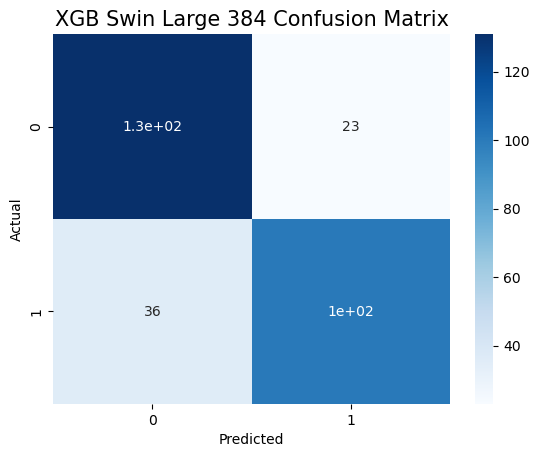

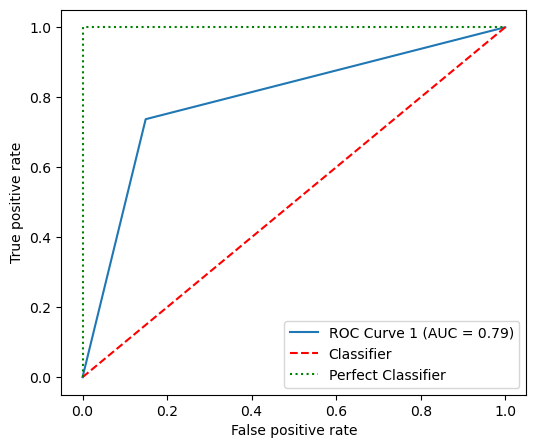

In [83]:
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(y_test_1d, xgb_swin_large_384_prediction)
sns.heatmap(conf_matrix,annot=True,cmap='Blues')
plt.title('XGB Swin Large 384 Confusion Matrix',size=15)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.savefig('XGB Swin Large 384 conf matrix.png')


from sklearn.metrics import roc_curve, auc, roc_auc_score
fpr , tpr , _ = roc_curve(y_test_1d, xgb_swin_large_384_prediction)
auc = roc_auc_score(y_test_1d, xgb_swin_large_384_prediction)
fig, ax = plt.subplots(figsize=(6, 5))
plt.plot(fpr, tpr, label='ROC Curve 1 (AUC = %0.2f)' % (auc))
plt.plot([0, 1], [0, 1], linestyle='--', color='red', label='Classifier')   
plt.plot([0, 0, 1], [0, 1, 1], linestyle=':', color='green', label='Perfect Classifier')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend(loc="lower right")
plt.savefig('XGB Swin Large 384 AUC ROC.png')

In [93]:
from sklearn.ensemble import RandomForestClassifier
rf_swin_large_384 = RandomForestClassifier()
rf_swin_large_384.fit(X_train_swin_large_384_normalized, y_train_1d)

#Now predict using the trained  model. 
rf_swin_large_384_prediction = rf_swin_large_384.predict(X_test_swin_large_384_normalized)


from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
print('train set accuracy is:',accuracy_score(y_train_1d, rf_swin_large_384.predict(X_train_swin_large_384_normalized)))
print('test set accuracy is:',accuracy_score(y_test_1d, rf_swin_large_384_prediction))
print(classification_report(y_test_1d, rf_swin_large_384_prediction))

train set accuracy is: 1.0
test set accuracy is: 0.7938144329896907
              precision    recall  f1-score   support

           0       0.79      0.84      0.81       154
           1       0.80      0.74      0.77       137

    accuracy                           0.79       291
   macro avg       0.79      0.79      0.79       291
weighted avg       0.79      0.79      0.79       291



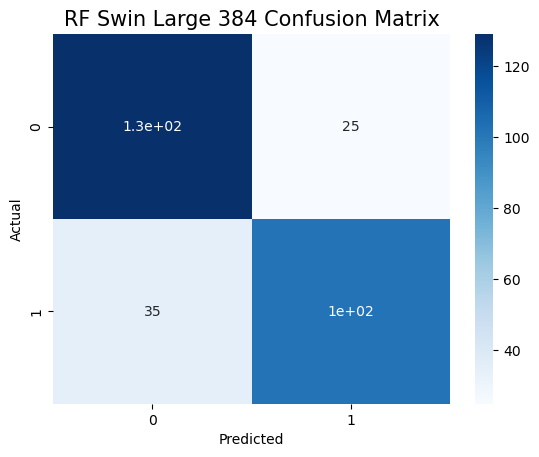

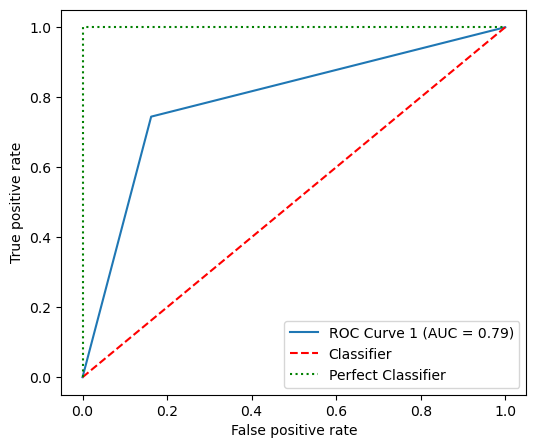

In [94]:
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(y_test_1d, rf_swin_large_384_prediction)
sns.heatmap(conf_matrix,annot=True,cmap='Blues')
plt.title('RF Swin Large 384 Confusion Matrix',size=15)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.savefig('RF Swin Large 384 conf matrix.png')


from sklearn.metrics import roc_curve, auc, roc_auc_score
fpr , tpr , _ = roc_curve(y_test_1d, rf_swin_large_384_prediction)
auc = roc_auc_score(y_test_1d, rf_swin_large_384_prediction)
fig, ax = plt.subplots(figsize=(6, 5))
plt.plot(fpr, tpr, label='ROC Curve 1 (AUC = %0.2f)' % (auc))
plt.plot([0, 1], [0, 1], linestyle='--', color='red', label='Classifier')   
plt.plot([0, 0, 1], [0, 1, 1], linestyle=':', color='green', label='Perfect Classifier')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend(loc="lower right")
plt.savefig('RF Swin Large 384 AUC ROC.png')

In [91]:
from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.model_selection import cross_val_score



bag_swin_large_384_model = BaggingClassifier()
bag_swin_large_384_model.fit(X_train_swin_large_384_normalized, y_train_1d)
bag_swin_large_384_prediction = bag_swin_large_384_model.predict(X_test_swin_large_384_normalized)

#Print overall accuracy

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
print('train set accuracy is:',accuracy_score(y_train_1d, bag_swin_large_384_model.predict(X_train_swin_large_384_normalized)))
print('test set accuracy is:',accuracy_score(y_test_1d, bag_swin_large_384_prediction))

print(classification_report(y_test_1d, bag_swin_large_384_prediction))

train set accuracy is: 0.9836629406706793
test set accuracy is: 0.7869415807560137
              precision    recall  f1-score   support

           0       0.76      0.88      0.81       154
           1       0.83      0.69      0.75       137

    accuracy                           0.79       291
   macro avg       0.80      0.78      0.78       291
weighted avg       0.79      0.79      0.78       291



In [92]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.model_selection import cross_val_score



abc_swin_large_384_model = AdaBoostClassifier()
abc_swin_large_384_model.fit(X_train_swin_large_384_normalized, y_train_1d)
abc_swin_large_384_prediction = abc_swin_large_384_model.predict(X_test_swin_large_384_normalized)

#Print overall accuracy

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
print('train set accuracy is:',accuracy_score(y_train_1d, abc_swin_large_384_model.predict(X_train_swin_large_384_normalized)))
print('test set accuracy is:',accuracy_score(y_test_1d, abc_swin_large_384_prediction))

print(classification_report(y_test_1d, abc_swin_large_384_prediction))

train set accuracy is: 0.8976784178847808
test set accuracy is: 0.7594501718213058
              precision    recall  f1-score   support

           0       0.77      0.79      0.78       154
           1       0.75      0.73      0.74       137

    accuracy                           0.76       291
   macro avg       0.76      0.76      0.76       291
weighted avg       0.76      0.76      0.76       291



In [64]:
X_train_swin_large_384 = swin_large_384.predict(X_train_384)
X_test_swin_large_384 = swin_large_384.predict(X_test_384)
np.save('X_train_swin_large_384.npy', X_train_swin_large_384)
np.save('X_test_swin_large_384.npy', X_test_swin_large_384)

10/10 [==============================] - 955s 95s/step


In [95]:
X_train_swin_large_384 = np.load('X_train_swin_large_384.npy')
print(X_train_swin_large_384.shape)
X_test_swin_large_384 = np.load('X_test_swin_large_384.npy')
print(X_test_swin_large_384.shape)

(1163, 1536)
(291, 1536)


In [84]:
from sklearn.model_selection import GridSearchCV, KFold
xgb_kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# Define the parameter grid for grid search
# xgb_param_grid = {
#     'max_depth': [3, 6, 9],
#     'learning_rate': [0.1, 0.01, 0.001],
#     'n_estimators': [50, 100, 200]
# }

# Create the XGBoost classifier
xgb_swin_large_384 = xgb.XGBClassifier(
    max_depth = 3,
    learning_rate = 0.1,
    n_estimators = 50
    )

xgb_swin_large_384.fit(
    X_train_swin_large_384, 
    y_train_1d
    )

xgb_swin_large_384_prediction = xgb_swin_large_384.predict(X_test_swin_large_384)

from sklearn.metrics import accuracy_score
print('train set accuracy is:', accuracy_score(y_train_1d, xgb_swin_large_384.predict(X_train_swin_large_384)))
print('test set accuracy is:', accuracy_score(y_test_1d, xgb_swin_large_384_prediction))
from sklearn.metrics import classification_report
print(classification_report(y_test_1d, xgb_swin_large_384_prediction))

train set accuracy is: 0.9544282029234737
test set accuracy is: 0.7903780068728522
              precision    recall  f1-score   support

           0       0.79      0.83      0.81       154
           1       0.80      0.74      0.77       137

    accuracy                           0.79       291
   macro avg       0.79      0.79      0.79       291
weighted avg       0.79      0.79      0.79       291



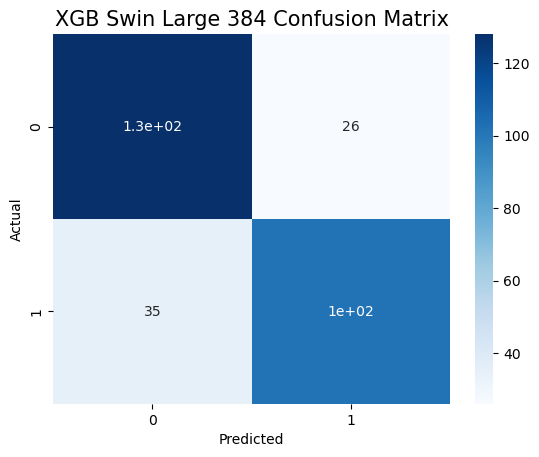

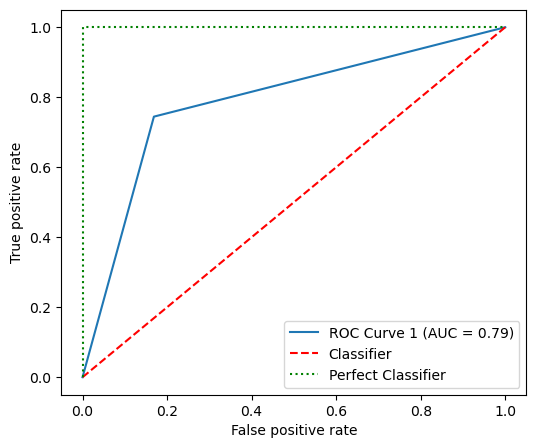

In [85]:
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(y_test_1d, xgb_swin_large_384_prediction)
sns.heatmap(conf_matrix,annot=True,cmap='Blues')
plt.title('XGB Swin Large 384 Confusion Matrix',size=15)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.savefig('XGB Swin Large 384 conf matrix.png')


from sklearn.metrics import roc_curve, auc, roc_auc_score
fpr , tpr , _ = roc_curve(y_test_1d, xgb_swin_large_384_prediction)
auc = roc_auc_score(y_test_1d, xgb_swin_large_384_prediction)
fig, ax = plt.subplots(figsize=(6, 5))
plt.plot(fpr, tpr, label='ROC Curve 1 (AUC = %0.2f)' % (auc))
plt.plot([0, 1], [0, 1], linestyle='--', color='red', label='Classifier')   
plt.plot([0, 0, 1], [0, 1, 1], linestyle=':', color='green', label='Perfect Classifier')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend(loc="lower right")
plt.savefig('XGB Swin Large 384 AUC ROC.png')

In [86]:
from sklearn.ensemble import RandomForestClassifier
rf_swin_large_384 = RandomForestClassifier()
rf_swin_large_384.fit(X_train_swin_large_384, y_train_1d)

#Now predict using the trained  model. 
rf_swin_large_384_prediction = rf_swin_large_384.predict(X_test_swin_large_384)


from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
print('train set accuracy is:',accuracy_score(y_train_1d, rf_swin_large_384.predict(X_train_swin_large_384)))
print('test set accuracy is:',accuracy_score(y_test_1d, rf_swin_large_384_prediction))
print(classification_report(y_test_1d, rf_swin_large_384_prediction))

train set accuracy is: 1.0
test set accuracy is: 0.845360824742268
              precision    recall  f1-score   support

           0       0.84      0.88      0.86       154
           1       0.85      0.81      0.83       137

    accuracy                           0.85       291
   macro avg       0.85      0.84      0.84       291
weighted avg       0.85      0.85      0.85       291



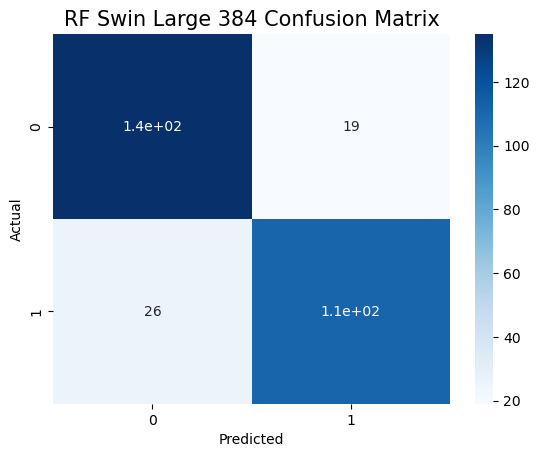

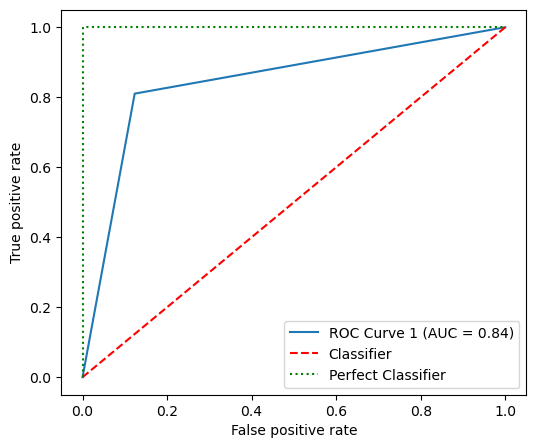

In [87]:
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(y_test_1d, rf_swin_large_384_prediction)
sns.heatmap(conf_matrix,annot=True,cmap='Blues')
plt.title('RF Swin Large 384 Confusion Matrix',size=15)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.savefig('RF Swin Large 384 conf matrix.png')


from sklearn.metrics import roc_curve, auc, roc_auc_score
fpr , tpr , _ = roc_curve(y_test_1d, rf_swin_large_384_prediction)
auc = roc_auc_score(y_test_1d, rf_swin_large_384_prediction)
fig, ax = plt.subplots(figsize=(6, 5))
plt.plot(fpr, tpr, label='ROC Curve 1 (AUC = %0.2f)' % (auc))
plt.plot([0, 1], [0, 1], linestyle='--', color='red', label='Classifier')   
plt.plot([0, 0, 1], [0, 1, 1], linestyle=':', color='green', label='Perfect Classifier')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend(loc="lower right")
plt.savefig('RF Swin Large 384 AUC ROC.png')

In [78]:
from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.model_selection import cross_val_score



bag_swin_large_384_model = BaggingClassifier()
bag_swin_large_384_model.fit(X_train_swin_large_384, y_train_1d)
bag_swin_large_384_prediction = bag_swin_large_384_model.predict(X_test_swin_large_384)

#Print overall accuracy

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
print('train set accuracy is:',accuracy_score(y_train_1d, bag_swin_large_384_model.predict(X_train_swin_large_384)))
print('test set accuracy is:',accuracy_score(y_test_1d, bag_swin_large_384_prediction))

print(classification_report(y_test_1d, bag_swin_large_384_prediction))

train set accuracy is: 0.9896818572656921
test set accuracy is: 0.7869415807560137
              precision    recall  f1-score   support

           0       0.75      0.90      0.82       154
           1       0.86      0.66      0.74       137

    accuracy                           0.79       291
   macro avg       0.80      0.78      0.78       291
weighted avg       0.80      0.79      0.78       291



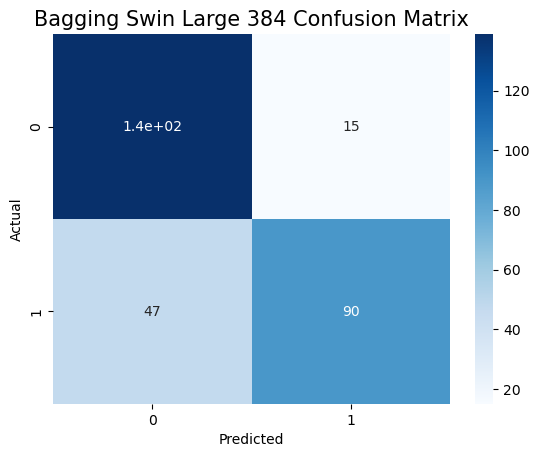

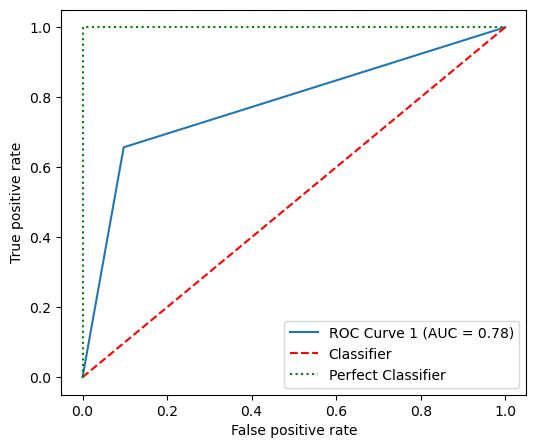

In [88]:
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(y_test_1d, bag_swin_large_384_prediction)
sns.heatmap(conf_matrix,annot=True,cmap='Blues')
plt.title('Bagging Swin Large 384 Confusion Matrix',size=15)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.savefig('RF Swin Large 384 conf matrix.png')


from sklearn.metrics import roc_curve, auc, roc_auc_score
fpr , tpr , _ = roc_curve(y_test_1d, bag_swin_large_384_prediction)
auc = roc_auc_score(y_test_1d, bag_swin_large_384_prediction)
fig, ax = plt.subplots(figsize=(6, 5))
plt.plot(fpr, tpr, label='ROC Curve 1 (AUC = %0.2f)' % (auc))
plt.plot([0, 1], [0, 1], linestyle='--', color='red', label='Classifier')   
plt.plot([0, 0, 1], [0, 1, 1], linestyle=':', color='green', label='Perfect Classifier')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend(loc="lower right")
plt.savefig('Bagging Swin Large 384 AUC ROC.png')

In [79]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.model_selection import cross_val_score



abc_swin_large_384_model = AdaBoostClassifier()
abc_swin_large_384_model.fit(X_train_swin_large_384, y_train_1d)
abc_swin_large_384_prediction = abc_swin_large_384_model.predict(X_test_swin_large_384)

#Print overall accuracy

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
print('train set accuracy is:',accuracy_score(y_train_1d, abc_swin_large_384_model.predict(X_train_swin_large_384)))
print('test set accuracy is:',accuracy_score(y_test_1d, abc_swin_large_384_prediction))

print(classification_report(y_test_1d, abc_swin_large_384_prediction))

train set accuracy is: 0.9114359415305245
test set accuracy is: 0.7731958762886598
              precision    recall  f1-score   support

           0       0.77      0.82      0.79       154
           1       0.78      0.72      0.75       137

    accuracy                           0.77       291
   macro avg       0.77      0.77      0.77       291
weighted avg       0.77      0.77      0.77       291



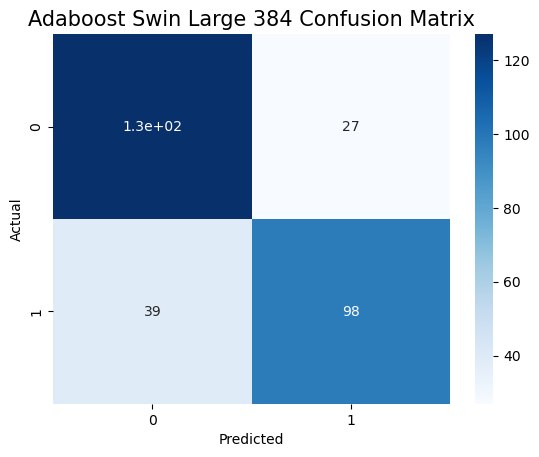

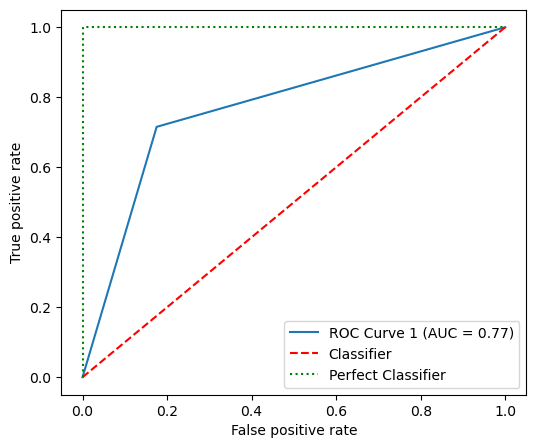

In [90]:
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(y_test_1d, abc_swin_large_384_prediction)
sns.heatmap(conf_matrix,annot=True,cmap='Blues')
plt.title('Adaboost Swin Large 384 Confusion Matrix',size=15)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.savefig('Adaboost Swin Large 384 conf matrix.png')


from sklearn.metrics import roc_curve, auc, roc_auc_score
fpr , tpr , _ = roc_curve(y_test_1d, abc_swin_large_384_prediction)
auc = roc_auc_score(y_test_1d, abc_swin_large_384_prediction)
fig, ax = plt.subplots(figsize=(6, 5))
plt.plot(fpr, tpr, label='ROC Curve 1 (AUC = %0.2f)' % (auc))
plt.plot([0, 1], [0, 1], linestyle='--', color='red', label='Classifier')   
plt.plot([0, 0, 1], [0, 1, 1], linestyle=':', color='green', label='Perfect Classifier')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend(loc="lower right")
plt.savefig('Adaboost Swin Large 384 AUC ROC.png')

# InceptionResNetV2

### Train InceptionResNetV2 from scratch, with params size about 215MB
* reduce lr when validation acc start to reduce, to make results more stable

### Extracting features

In [9]:
image_size_224 = 224

In [10]:
from tensorflow.keras.applications import InceptionResNetV2

InceptionResNetV2_model = InceptionResNetV2(weights='imagenet', include_top=False, input_shape=(image_size_224, image_size_224, 3))
#Make loaded layers as non-trainable. This is important as we want to work with pre-trained weights
for layer in InceptionResNetV2_model.layers:
	layer.trainable = False
    
InceptionResNetV2_model.summary()  #Trainable parameters will be 0

Model: "inception_resnet_v2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d_4 (Conv2D)           (None, 111, 111, 32)         864       ['input_3[0][0]']             
                                                                                                  
 batch_normalization_4 (Bat  (None, 111, 111, 32)         96        ['conv2d_4[0][0]']            
 chNormalization)                                                                                 
                                                                                                  
 activation (Activation)     (None, 111, 111, 32)         0         ['batch_norm

In [11]:
# Now, let us use features from convolutional network
X_train_InceptionResNetV2 = InceptionResNetV2_model.predict(X_train)
X_train_InceptionResNetV2 = X_train_InceptionResNetV2.reshape(X_train_InceptionResNetV2.shape[0], -1)
print (X_train_InceptionResNetV2.shape)
# Save features to a file
np.save('X_train_InceptionResNetV2_without_segmentation.npy', X_train_InceptionResNetV2)

  22/1036 [..............................] - ETA: 7:17:42

KeyboardInterrupt: 

In [ ]:
# Now, let us use features from convolutional network
X_test_InceptionResNetV2 = InceptionResNetV2_model.predict(X_test)
X_test_InceptionResNetV2 = X_test_InceptionResNetV2.reshape(X_test_InceptionResNetV2.shape[0], -1)
print (X_test_InceptionResNetV2.shape)
# Save features to a file
np.save('X_test_InceptionResNetV2_without_segmentation.npy', X_test_InceptionResNetV2)

10/10 [==============================] - 43s 4s/step
(291, 38400)


In [13]:
X_train_InceptionResNetV2 = np.load('X_train_InceptionResNetV2_without_segmentation.npy')
X_test_InceptionResNetV2 = np.load('X_test_InceptionResNetV2_without_segmentation.npy')

### XGB InceptionResNetV2

In [124]:
from sklearn.model_selection import GridSearchCV, KFold
xgb_kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# Define the parameter grid for grid search
# xgb_param_grid = {
#     'max_depth': [3, 6, 9],
#     'learning_rate': [0.1, 0.01, 0.001],
#     'n_estimators': [50, 100, 200]
# }

# Create the XGBoost classifier
xgb_InceptionResNetV2_model = xgb.XGBClassifier(
    max_depth = 3,
    learning_rate = 0.1,
    n_estimators = 50
    )

xgb_InceptionResNetV2_model.fit(
    X_train_InceptionResNetV2, 
    y_train_1d
    )

xgb_InceptionResNetV2_prediction = xgb_InceptionResNetV2_model.predict(X_test_InceptionResNetV2)

from sklearn.metrics import accuracy_score
print('train set accuracy is:', accuracy_score(y_train_1d, xgb_InceptionResNetV2_model.predict(X_train_InceptionResNetV2)))
print('test set accuracy is:', accuracy_score(y_test_1d, xgb_InceptionResNetV2_prediction))
from sklearn.metrics import classification_report
print(classification_report(y_test_1d, xgb_InceptionResNetV2_prediction))

train set accuracy is: 0.944969905417025
test set accuracy is: 0.8591065292096219
              precision    recall  f1-score   support

           0       0.83      0.92      0.87       154
           1       0.89      0.80      0.84       137

    accuracy                           0.86       291
   macro avg       0.86      0.86      0.86       291
weighted avg       0.86      0.86      0.86       291



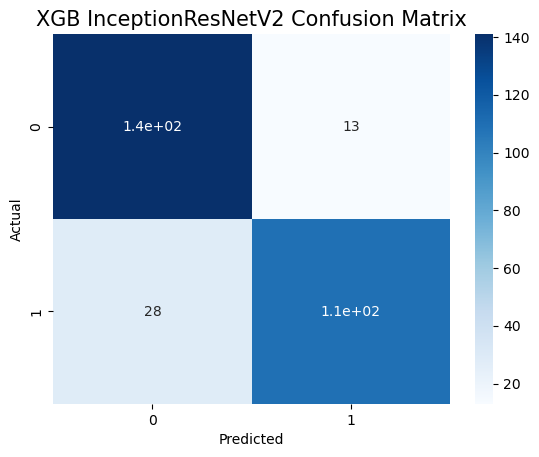

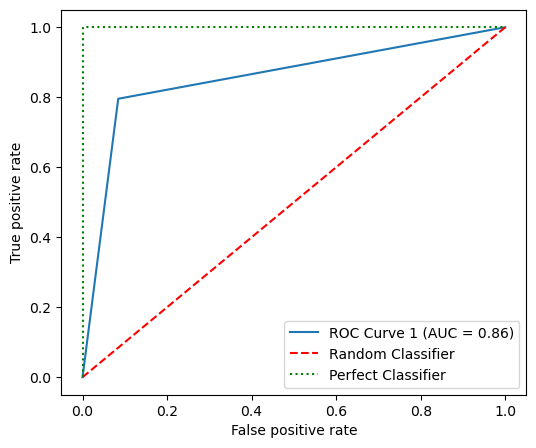

In [125]:
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(y_test_1d, xgb_InceptionResNetV2_prediction)
sns.heatmap(conf_matrix,annot=True,cmap='Blues')
plt.title('XGB InceptionResNetV2 Confusion Matrix',size=15)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.savefig('XGB InceptionResNetV2 conf matrix.png')


from sklearn.metrics import roc_curve, auc, roc_auc_score
fpr , tpr , _ = roc_curve(y_test_1d, xgb_InceptionResNetV2_prediction)
auc = roc_auc_score(y_test_1d, xgb_InceptionResNetV2_prediction)
fig, ax = plt.subplots(figsize=(6, 5))
plt.plot(fpr, tpr, label='ROC Curve 1 (AUC = %0.2f)' % (auc))
plt.plot([0, 1], [0, 1], linestyle='--', color='red', label='Random Classifier')   
plt.plot([0, 0, 1], [0, 1, 1], linestyle=':', color='green', label='Perfect Classifier')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend(loc="lower right")
plt.savefig('XGB InceptionResNetV2  AUC ROC.png')

### Random Forest

In [64]:
from sklearn.ensemble import RandomForestClassifier
rf_InceptionResNetV2_model = RandomForestClassifier()
rf_InceptionResNetV2_model.fit(X_train_InceptionResNetV2, y_train_1d)

#Now predict using the trained  model. 
rf_InceptionResNetV2_prediction = rf_InceptionResNetV2_model.predict(X_test_InceptionResNetV2)


from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
print('train set accuracy is:',accuracy_score(y_train_1d, rf_InceptionResNetV2_model.predict(X_train_InceptionResNetV2)))
print('test set accuracy is:',accuracy_score(y_test_1d, rf_InceptionResNetV2_prediction))
print(classification_report(y_test_1d, rf_InceptionResNetV2_prediction))

train set accuracy is: 1.0
test set accuracy is: 0.8797250859106529
              precision    recall  f1-score   support

           0       0.86      0.93      0.89       154
           1       0.91      0.82      0.87       137

    accuracy                           0.88       291
   macro avg       0.88      0.88      0.88       291
weighted avg       0.88      0.88      0.88       291



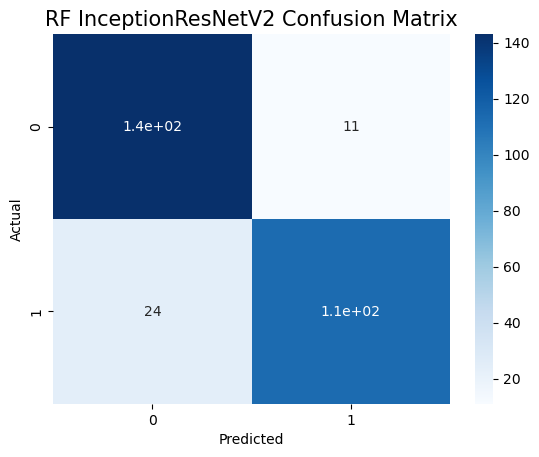

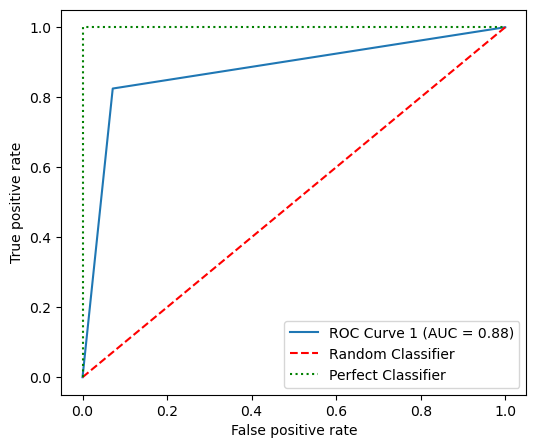

In [123]:
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(y_test_1d, rf_InceptionResNetV2_prediction)
sns.heatmap(conf_matrix,annot=True,cmap='Blues')
plt.title('RF InceptionResNetV2 Confusion Matrix',size=15)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.savefig('RF InceptionResNetV2 conf matrix.png')


from sklearn.metrics import roc_curve, auc, roc_auc_score
fpr , tpr , _ = roc_curve(y_test_1d, rf_InceptionResNetV2_prediction)
auc = roc_auc_score(y_test_1d, rf_InceptionResNetV2_prediction)
fig, ax = plt.subplots(figsize=(6, 5))
plt.plot(fpr, tpr, label='ROC Curve 1 (AUC = %0.2f)' % (auc))
plt.plot([0, 1], [0, 1], linestyle='--', color='red', label='Random Classifier')   
plt.plot([0, 0, 1], [0, 1, 1], linestyle=':', color='green', label='Perfect Classifier')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend(loc="lower right")
plt.savefig('RF InceptionResNetV2  AUC ROC.png')

### Bagging

In [65]:
from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.model_selection import cross_val_score



bag_InceptionResNetV2_model = BaggingClassifier()
bag_InceptionResNetV2_model.fit(X_train_InceptionResNetV2, y_train_1d)
bag_InceptionResNetV2_prediction = bag_InceptionResNetV2_model.predict(X_test_InceptionResNetV2)

#Print overall accuracy

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
print('train set accuracy is:',accuracy_score(y_train_1d, bag_InceptionResNetV2_model.predict(X_train_InceptionResNetV2)))
print('test set accuracy is:',accuracy_score(y_test_1d, bag_InceptionResNetV2_prediction))

print(classification_report(y_test_1d, bag_InceptionResNetV2_prediction))

train set accuracy is: 0.9896818572656921
test set accuracy is: 0.8797250859106529
              precision    recall  f1-score   support

           0       0.87      0.92      0.89       154
           1       0.90      0.84      0.87       137

    accuracy                           0.88       291
   macro avg       0.88      0.88      0.88       291
weighted avg       0.88      0.88      0.88       291



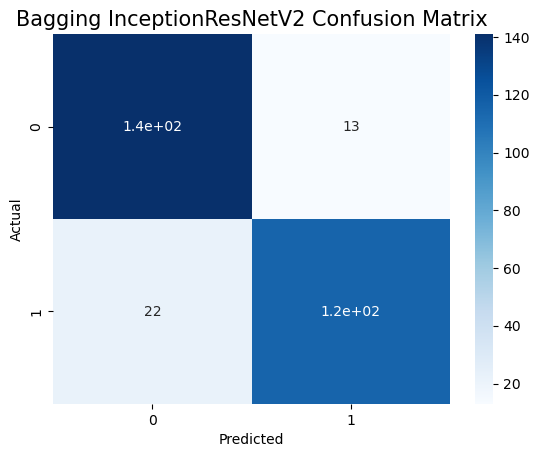

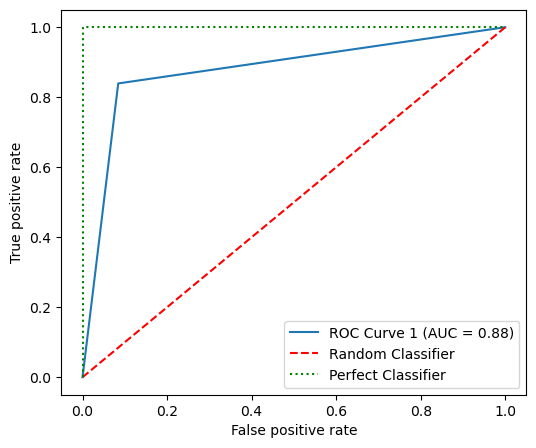

In [122]:
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(y_test_1d, bag_InceptionResNetV2_prediction)
sns.heatmap(conf_matrix,annot=True,cmap='Blues')
plt.title('Bagging InceptionResNetV2 Confusion Matrix',size=15)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.savefig('Bagging InceptionResNetV2 conf matrix.png')


from sklearn.metrics import roc_curve, auc, roc_auc_score
fpr , tpr , _ = roc_curve(y_test_1d, bag_InceptionResNetV2_prediction)
auc = roc_auc_score(y_test_1d, bag_InceptionResNetV2_prediction)
fig, ax = plt.subplots(figsize=(6, 5))
plt.plot(fpr, tpr, label='ROC Curve 1 (AUC = %0.2f)' % (auc))
plt.plot([0, 1], [0, 1], linestyle='--', color='red', label='Random Classifier')   
plt.plot([0, 0, 1], [0, 1, 1], linestyle=':', color='green', label='Perfect Classifier')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend(loc="lower right")
plt.savefig('Bagging InceptionResNetV2  AUC ROC.png')

### AdaBoost

In [66]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.model_selection import cross_val_score



abc_InceptionResNetV2_model = AdaBoostClassifier()
abc_InceptionResNetV2_model.fit(X_train_InceptionResNetV2, y_train_1d)
abc_InceptionResNetV2_prediction = abc_InceptionResNetV2_model.predict(X_test_InceptionResNetV2)

#Print overall accuracy

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
print('train set accuracy is:',accuracy_score(y_train_1d, abc_InceptionResNetV2_model.predict(X_train_InceptionResNetV2)))
print('test set accuracy is:',accuracy_score(y_test_1d, abc_InceptionResNetV2_prediction))

print(classification_report(y_test_1d, abc_InceptionResNetV2_prediction))

train set accuracy is: 0.9535683576956148
test set accuracy is: 0.8419243986254296
              precision    recall  f1-score   support

           0       0.83      0.88      0.86       154
           1       0.86      0.80      0.83       137

    accuracy                           0.84       291
   macro avg       0.84      0.84      0.84       291
weighted avg       0.84      0.84      0.84       291



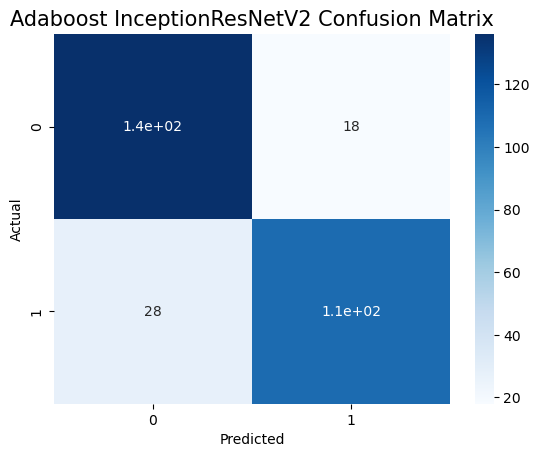

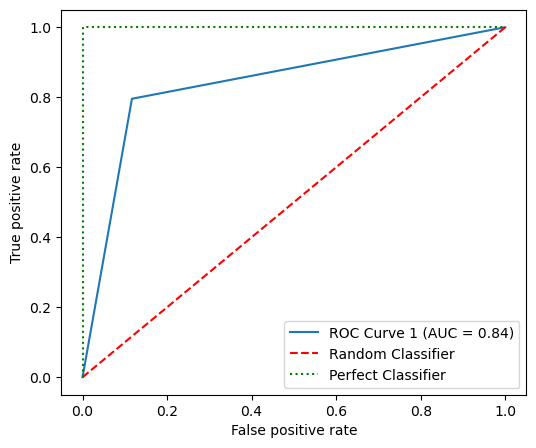

In [121]:
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(y_test_1d, abc_InceptionResNetV2_prediction)
sns.heatmap(conf_matrix,annot=True,cmap='Blues')
plt.title('Adaboost InceptionResNetV2 Confusion Matrix',size=15)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.savefig('Adaboost InceptionResNetV2 conf matrix.png')


from sklearn.metrics import roc_curve, auc, roc_auc_score
fpr , tpr , _ = roc_curve(y_test_1d, abc_InceptionResNetV2_prediction)
auc = roc_auc_score(y_test_1d, abc_InceptionResNetV2_prediction)
fig, ax = plt.subplots(figsize=(6, 5))
plt.plot(fpr, tpr, label='ROC Curve 1 (AUC = %0.2f)' % (auc))
plt.plot([0, 1], [0, 1], linestyle='--', color='red', label='Random Classifier')   
plt.plot([0, 0, 1], [0, 1, 1], linestyle=':', color='green', label='Perfect Classifier')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend(loc="lower right")
plt.savefig('Adaboost InceptionResNetV2  AUC ROC.png')

# EfficientNet B0 
* (a smaller CNN which is harder to be overfitting, EfficientNetB0 : 29MB)

### Extracting features

In [26]:
from tensorflow.keras.applications import EfficientNetB0

EfficientNetB0_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(image_size_224, image_size_224, 3))
#Make loaded layers as non-trainable. This is important as we want to work with pre-trained weights
for layer in EfficientNetB0_model.layers:
	layer.trainable = False
    
EfficientNetB0_model.summary()  #Trainable parameters will be 0

Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_6 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 rescaling_2 (Rescaling)     (None, 224, 224, 3)          0         ['input_6[0][0]']             
                                                                                                  
 normalization (Normalizati  (None, 224, 224, 3)          7         ['rescaling_2[0][0]']         
 on)                                                                                              
                                                                                                  
 rescaling_3 (Rescaling)     (None, 224, 224, 3)          0         ['normalization[0

In [30]:
# Now, let us use features from convolutional network
X_train_EfficientNetB0 = EfficientNetB0_model.predict(X_train_224)
X_train_EfficientNetB0 = X_train_EfficientNetB0.reshape(X_train_EfficientNetB0.shape[0], -1)
print (X_train_EfficientNetB0.shape)
# Save features to a file
np.save('X_train_EfficientNetB.npy', X_train_EfficientNetB0)

37/37 [==============================] - 35s 857ms/step
(1163, 62720)


In [31]:
# Now, let us use features from convolutional network
X_test_EfficientNetB0 = EfficientNetB0_model.predict(X_test_224)
X_test_EfficientNetB0 = X_test_EfficientNetB0.reshape(X_test_EfficientNetB0.shape[0], -1)
print (X_test_EfficientNetB0.shape)
# Save features to a file
np.save('X_test_EfficientNetB0.npy', X_test_EfficientNetB0)

10/10 [==============================] - 8s 797ms/step
(291, 62720)


In [27]:
X_train_EfficientNetB0 = np.load('X_train_EfficientNetB.npy')
X_test_EfficientNetB0 = np.load('X_test_EfficientNetB0.npy')

### XGB EfficientNet B0

In [42]:
import xgboost as xgb
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import accuracy_score, classification_report

# Initialize the model
xgb_EfficientNetB0_model = xgb.XGBClassifier()

# Perform 5-fold cross-validation
cv = KFold(n_splits=10, shuffle=True, random_state=42)
cv_scores = cross_val_score(xgb_EfficientNetB0_model, X_train_EfficientNetB0, y_train_1d, cv=cv, scoring='accuracy')

print(f'Cross-validation accuracy scores: {cv_scores}')
print(f'Mean cross-validation accuracy: {cv_scores.mean()}')
print(f'Standard deviation of cross-validation accuracy: {cv_scores.std()}')

# Fit the model on the entire training set
xgb_EfficientNetB0_model.fit(X_train_EfficientNetB0, y_train_1d)

# Predict on the test set
xgb_EfficientNetB0_prediction = xgb_EfficientNetB0_model.predict(X_test_EfficientNetB0)

# Print overall accuracy
print('Train set accuracy:', accuracy_score(y_train_1d, xgb_EfficientNetB0_model.predict(X_train_EfficientNetB0)))
print('Test set accuracy:', accuracy_score(y_test_1d, xgb_EfficientNetB0_prediction))

# Print classification report
print(classification_report(y_test_1d, xgb_EfficientNetB0_prediction))

Cross-validation accuracy scores: [0.91452991 0.86324786 0.82905983 0.86206897 0.88793103 0.87068966
 0.92241379 0.9137931  0.81896552 0.87068966]
Mean cross-validation accuracy: 0.8753389330975538
Standard deviation of cross-validation accuracy: 0.03327836349767608
Train set accuracy: 1.0
Test set accuracy: 0.9037800687285223
              precision    recall  f1-score   support

           0       0.88      0.95      0.91       154
           1       0.94      0.85      0.89       137

    accuracy                           0.90       291
   macro avg       0.91      0.90      0.90       291
weighted avg       0.91      0.90      0.90       291



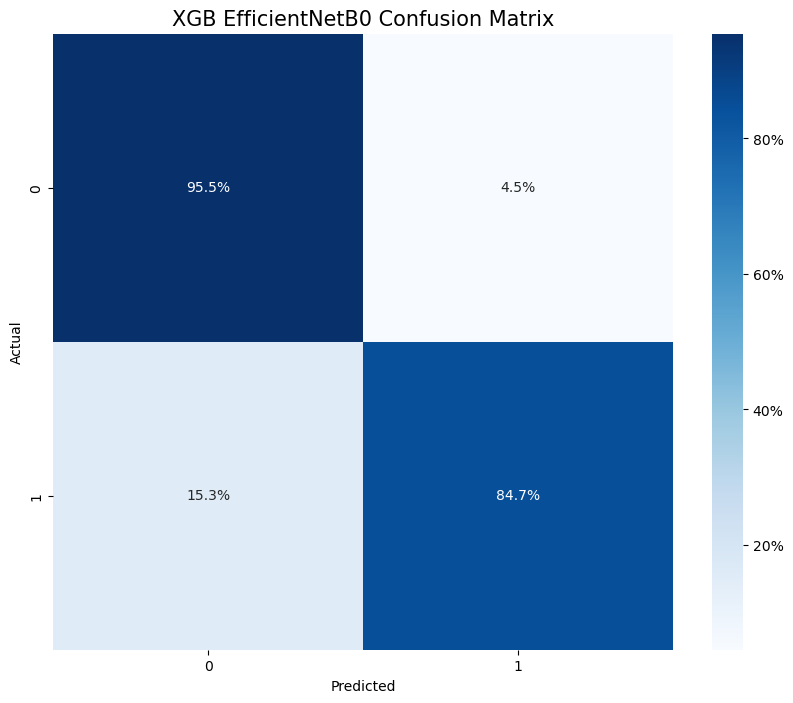

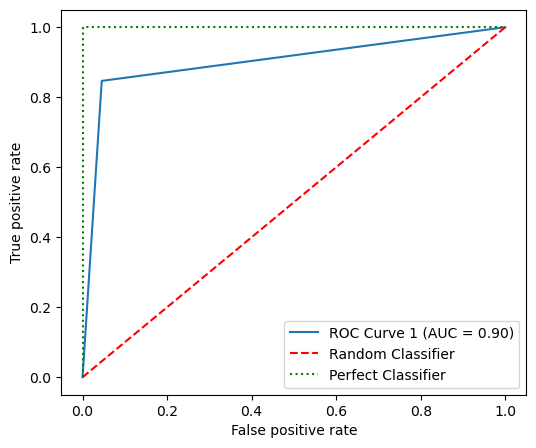

In [43]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
xgb_conf_matrix = confusion_matrix(y_test_1d, xgb_EfficientNetB0_prediction)

# Calculate percentages
xgb_conf_matrix_percent = xgb_conf_matrix.astype('float') / xgb_conf_matrix.sum(axis=1)[:, np.newaxis] * 100

# Plotting the normalized confusion matrix
plt.figure(figsize=(10, 8))
ax = sns.heatmap(xgb_conf_matrix_percent, annot=True, cmap='Blues', fmt=".1f", cbar_kws={'format': '%.0f%%'})

# Annotate the heatmap with percentage signs
for t in ax.texts: 
    t.set_text(t.get_text() + "%")

plt.title('XGB EfficientNetB0 Confusion Matrix', size=15)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.savefig('XGB_EfficientNetB0_conf_matrix_percent.png')
plt.show()




from sklearn.metrics import roc_curve, auc, roc_auc_score
fpr , tpr , _ = roc_curve(y_test_1d, xgb_EfficientNetB0_prediction )
auc = roc_auc_score(y_test_1d, xgb_EfficientNetB0_prediction)
fig, ax = plt.subplots(figsize=(6, 5))
plt.plot(fpr, tpr, label='ROC Curve 1 (AUC = %0.2f)' % (auc))
plt.plot([0, 1], [0, 1], linestyle='--', color='red', label='Random Classifier')   
plt.plot([0, 0, 1], [0, 1, 1], linestyle=':', color='green', label='Perfect Classifier')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend(loc="lower right")
plt.savefig('XGB EfficientNetB0 AUC ROC.png')

### RF

In [117]:
from sklearn.ensemble import RandomForestClassifier
rf_EfficientNetB0_model = RandomForestClassifier()
rf_EfficientNetB0_model.fit(X_train_EfficientNetB0, y_train_1d)

#Now predict using the trained  model. 
rf_EfficientNetB0_prediction = rf_EfficientNetB0_model.predict(X_test_EfficientNetB0)


from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
print('train set accuracy is:',accuracy_score(y_train_1d, rf_EfficientNetB0_model.predict(X_train_EfficientNetB0)))
print('test set accuracy is:',accuracy_score(y_test_1d, rf_EfficientNetB0_prediction))
print(classification_report(y_test_1d, rf_EfficientNetB0_prediction))

train set accuracy is: 1.0
test set accuracy is: 0.8969072164948454
              precision    recall  f1-score   support

           0       0.88      0.94      0.91       154
           1       0.92      0.85      0.89       137

    accuracy                           0.90       291
   macro avg       0.90      0.89      0.90       291
weighted avg       0.90      0.90      0.90       291



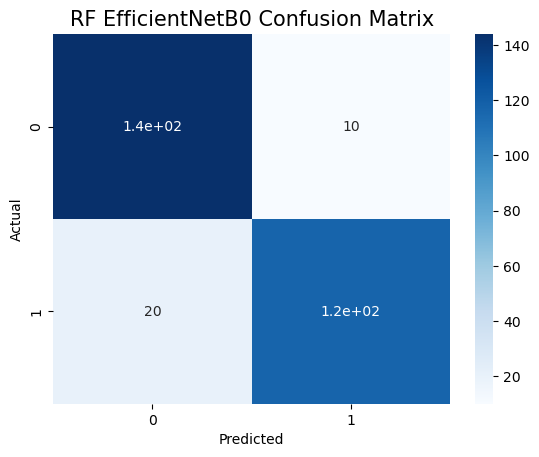

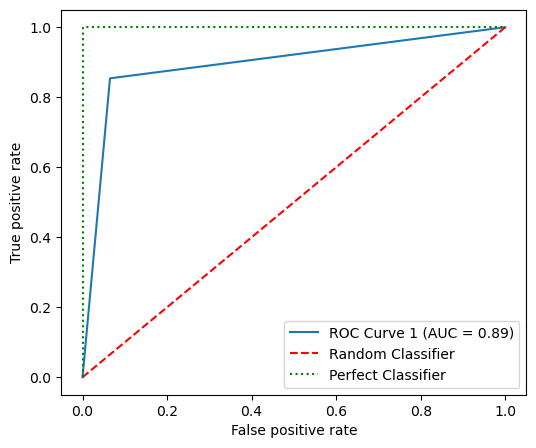

In [118]:
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(y_test_1d, rf_EfficientNetB0_prediction)
sns.heatmap(conf_matrix,annot=True,cmap='Blues')
plt.title('RF EfficientNetB0 Confusion Matrix',size=15)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.savefig('RF EfficientNetB0 conf matrix.png')


from sklearn.metrics import roc_curve, auc, roc_auc_score
fpr , tpr , _ = roc_curve(y_test_1d, rf_EfficientNetB0_prediction)
auc = roc_auc_score(y_test_1d, rf_EfficientNetB0_prediction)
fig, ax = plt.subplots(figsize=(6, 5))
plt.plot(fpr, tpr, label='ROC Curve 1 (AUC = %0.2f)' % (auc))
plt.plot([0, 1], [0, 1], linestyle='--', color='red', label='Random Classifier')   
plt.plot([0, 0, 1], [0, 1, 1], linestyle=':', color='green', label='Perfect Classifier')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend(loc="lower right")
plt.savefig('Rf EfficientNetB0  AUC ROC.png')

### Bagging

In [60]:
from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.model_selection import cross_val_score



bag_EfficientNetB0_model = BaggingClassifier()
bag_EfficientNetB0_model.fit(X_train_EfficientNetB0, y_train_1d)
bag_EfficientNetB0_prediction = bag_EfficientNetB0_model.predict(X_test_EfficientNetB0)

#Print overall accuracy

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
print('train set accuracy is:',accuracy_score(y_train_1d, bag_EfficientNetB0_model.predict(X_train_EfficientNetB0)))
print('test set accuracy is:',accuracy_score(y_test_1d, bag_EfficientNetB0_prediction))

print(classification_report(y_test_1d, bag_EfficientNetB0_prediction))

train set accuracy is: 0.9948409286328461
test set accuracy is: 0.852233676975945
              precision    recall  f1-score   support

           0       0.82      0.93      0.87       154
           1       0.91      0.77      0.83       137

    accuracy                           0.85       291
   macro avg       0.86      0.85      0.85       291
weighted avg       0.86      0.85      0.85       291



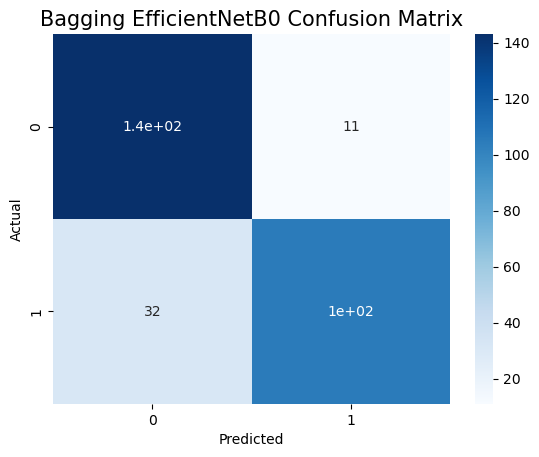

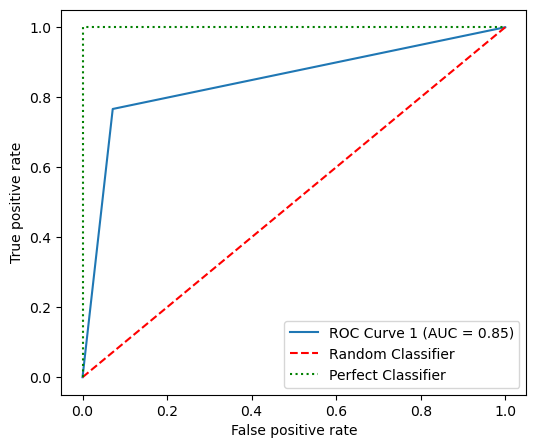

In [115]:
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(y_test_1d, bag_EfficientNetB0_prediction)
sns.heatmap(conf_matrix,annot=True,cmap='Blues')
plt.title('Bagging EfficientNetB0 Confusion Matrix',size=15)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.savefig('Bagging EfficientNetB0 conf matrix.png')


from sklearn.metrics import roc_curve, auc, roc_auc_score
fpr , tpr , _ = roc_curve(y_test_1d, bag_EfficientNetB0_prediction)
auc = roc_auc_score(y_test_1d, bag_EfficientNetB0_prediction)
fig, ax = plt.subplots(figsize=(6, 5))
plt.plot(fpr, tpr, label='ROC Curve 1 (AUC = %0.2f)' % (auc))
plt.plot([0, 1], [0, 1], linestyle='--', color='red', label='Random Classifier')   
plt.plot([0, 0, 1], [0, 1, 1], linestyle=':', color='green', label='Perfect Classifier')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend(loc="lower right")
plt.savefig('Bagging EfficientNetB0  AUC ROC.png')

### Boosting

In [61]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.model_selection import cross_val_score



abc_EfficientNetB0_model = AdaBoostClassifier()
abc_EfficientNetB0_model.fit(X_train_EfficientNetB0, y_train_1d)
abc_EfficientNetB0_prediction = abc_EfficientNetB0_model.predict(X_test_EfficientNetB0)

#Print overall accuracy

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
print('train set accuracy is:',accuracy_score(y_train_1d, abc_EfficientNetB0_model.predict(X_train_EfficientNetB0)))
print('test set accuracy is:',accuracy_score(y_test_1d, abc_EfficientNetB0_prediction))

print(classification_report(y_test_1d, abc_EfficientNetB0_prediction))

train set accuracy is: 0.9862424763542562
test set accuracy is: 0.8831615120274914
              precision    recall  f1-score   support

           0       0.88      0.90      0.89       154
           1       0.89      0.86      0.87       137

    accuracy                           0.88       291
   macro avg       0.88      0.88      0.88       291
weighted avg       0.88      0.88      0.88       291



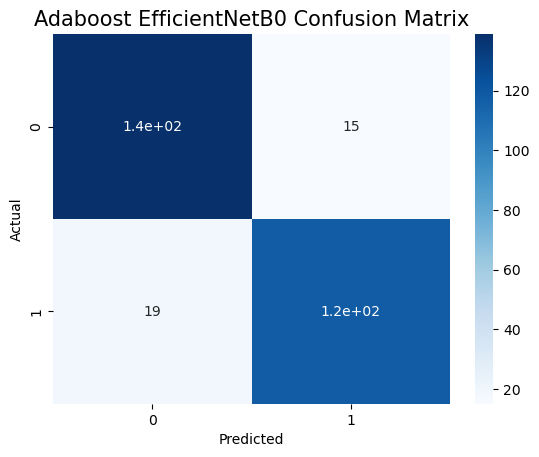

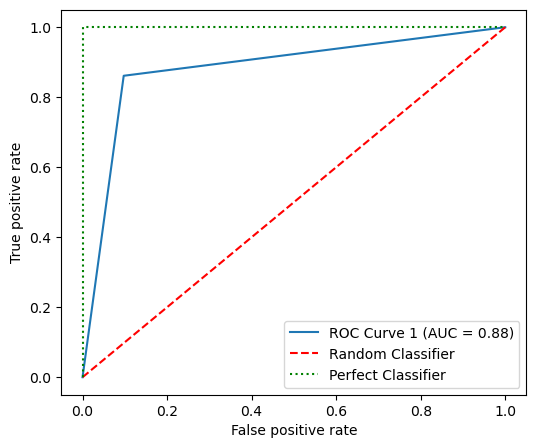

In [114]:
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(y_test_1d, abc_EfficientNetB0_prediction)
sns.heatmap(conf_matrix,annot=True,cmap='Blues')
plt.title('Adaboost EfficientNetB0 Confusion Matrix',size=15)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.savefig('Adaboost EfficientNetB0 conf matrix.png')


from sklearn.metrics import roc_curve, auc, roc_auc_score
fpr , tpr , _ = roc_curve(y_test_1d, abc_EfficientNetB0_prediction)
auc = roc_auc_score(y_test_1d, abc_EfficientNetB0_prediction)
fig, ax = plt.subplots(figsize=(6, 5))
plt.plot(fpr, tpr, label='ROC Curve 1 (AUC = %0.2f)' % (auc))
plt.plot([0, 1], [0, 1], linestyle='--', color='red', label='Random Classifier')   
plt.plot([0, 0, 1], [0, 1, 1], linestyle=':', color='green', label='Perfect Classifier')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend(loc="lower right")
plt.savefig('Adaboost EfficientNetB0  AUC ROC.png')

# VGG16

### Extracting features from VGG16

In [44]:
from tensorflow.keras.applications import VGG16

#Load model wothout classifier/fully connected layers
VGG16_model = VGG16(weights='imagenet', include_top=False, input_shape=(image_size_224, image_size_224, 3))

#Make loaded layers as non-trainable. This is important as we want to work with pre-trained weights
for layer in VGG16_model.layers:
	layer.trainable = False
    
VGG16_model.summary()  #Trainable parameters will be 0


Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [33]:
#Now, let us use features from convolutional network
X_train_vgg16 = VGG16_model.predict(X_train_224)
X_train_vgg16 = X_train_vgg16.reshape(X_train_vgg16.shape[0], -1)
print(X_train_vgg16.shape)
# Save features to a file
np.save('X_train_vgg16_hommomorphic.npy', X_train_vgg16)

37/37 [==============================] - 391s 11s/step
(1163, 25088)


In [34]:
# #Send test data through same feature extractor process
X_test_vgg16 = VGG16_model.predict(X_test_224)
X_test_vgg16 = X_test_vgg16.reshape(X_test_vgg16.shape[0], -1)
print(X_test_vgg16.shape)
# Save features to a file
np.save('X_test_vgg16_hommomorphic.npy', X_test_vgg16)

10/10 [==============================] - 87s 9s/step
(291, 25088)


In [46]:
# Load features from the saved file
X_train_VGG16 = np.load('X_train_vgg16_hommomorphic.npy')
X_test_VGG16= np.load('X_test_vgg16_hommomorphic.npy')

### XGBoost VGG 16

In [47]:
import xgboost as xgb
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import accuracy_score, classification_report

# Initialize the model
xgb_VGG16_model = xgb.XGBClassifier()

# Perform 5-fold cross-validation
cv = KFold(n_splits=10, shuffle=True, random_state=42)
cv_scores = cross_val_score(xgb_VGG16_model, X_train_VGG16, y_train_1d, cv=cv, scoring='accuracy')

print(f'Cross-validation accuracy scores: {cv_scores}')
print(f'Mean cross-validation accuracy: {cv_scores.mean()}')
print(f'Standard deviation of cross-validation accuracy: {cv_scores.std()}')

# Fit the model on the entire training set
xgb_VGG16_model.fit(X_train_VGG16, y_train_1d)

# Predict on the test set
xgb_VGG16_prediction = xgb_VGG16_model.predict(X_test_VGG16)

# Print overall accuracy
print('Train set accuracy:', accuracy_score(y_train_1d, xgb_VGG16_model.predict(X_train_VGG16)))
print('Test set accuracy:', accuracy_score(y_test_1d, xgb_VGG16_prediction))

# Print classification report
print(classification_report(y_test_1d, xgb_VGG16_prediction))

Cross-validation accuracy scores: [0.94017094 0.84615385 0.84615385 0.89655172 0.87068966 0.85344828
 0.88793103 0.90517241 0.87931034 0.88793103]
Mean cross-validation accuracy: 0.8813513115237253
Standard deviation of cross-validation accuracy: 0.027783035609654606
Train set accuracy: 1.0
Test set accuracy: 0.9140893470790378
              precision    recall  f1-score   support

           0       0.90      0.94      0.92       154
           1       0.93      0.88      0.91       137

    accuracy                           0.91       291
   macro avg       0.92      0.91      0.91       291
weighted avg       0.91      0.91      0.91       291



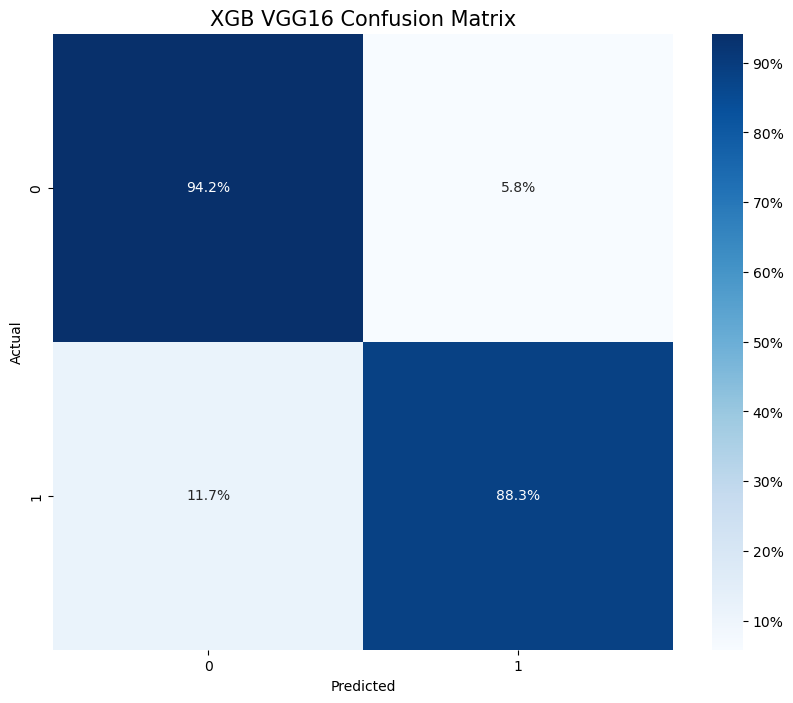

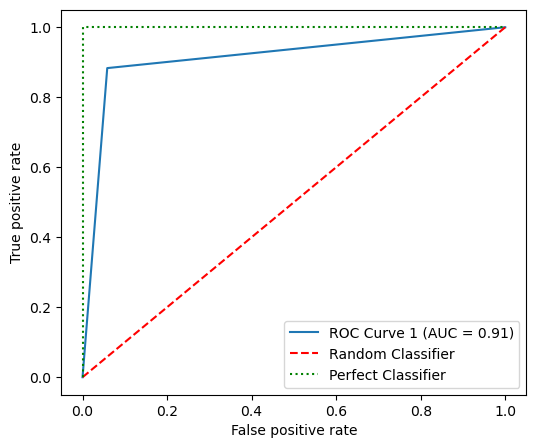

In [48]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
xgb_conf_matrix = confusion_matrix(y_test_1d, xgb_VGG16_prediction)

# Calculate percentages
xgb_conf_matrix_percent = xgb_conf_matrix.astype('float') / xgb_conf_matrix.sum(axis=1)[:, np.newaxis] * 100

# Plotting the normalized confusion matrix
plt.figure(figsize=(10, 8))
ax = sns.heatmap(xgb_conf_matrix_percent, annot=True, cmap='Blues', fmt=".1f", cbar_kws={'format': '%.0f%%'})

# Annotate the heatmap with percentage signs
for t in ax.texts: 
    t.set_text(t.get_text() + "%")

plt.title('XGB VGG16 Confusion Matrix', size=15)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.savefig('XGB_VGG16_conf_matrix_percent.png')
plt.show()




from sklearn.metrics import roc_curve, auc, roc_auc_score
fpr , tpr , _ = roc_curve(y_test_1d, xgb_VGG16_prediction )
auc = roc_auc_score(y_test_1d, xgb_VGG16_prediction)
fig, ax = plt.subplots(figsize=(6, 5))
plt.plot(fpr, tpr, label='ROC Curve 1 (AUC = %0.2f)' % (auc))
plt.plot([0, 1], [0, 1], linestyle='--', color='red', label='Random Classifier')   
plt.plot([0, 0, 1], [0, 1, 1], linestyle=':', color='green', label='Perfect Classifier')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend(loc="lower right")
plt.savefig('XGB VGG16 AUC ROC.png')

### Random forest VGG 16

In [110]:
from sklearn.ensemble import RandomForestClassifier
rf_vgg16_model = RandomForestClassifier()
rf_vgg16_model.fit(X_train_vgg16, y_train_1d)

#Now predict using the trained  model. 
rf_vgg16_prediction = rf_vgg16_model.predict(X_test_vgg16)


from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
print('train set accuracy is:',accuracy_score(y_train_1d, rf_vgg16_model.predict(X_train_vgg16)))
print('test set accuracy is:',accuracy_score(y_test_1d, rf_vgg16_prediction))
print(classification_report(y_test_1d, rf_vgg16_prediction))

train set accuracy is: 1.0
test set accuracy is: 0.9209621993127147
              precision    recall  f1-score   support

           0       0.90      0.96      0.93       154
           1       0.95      0.88      0.91       137

    accuracy                           0.92       291
   macro avg       0.92      0.92      0.92       291
weighted avg       0.92      0.92      0.92       291



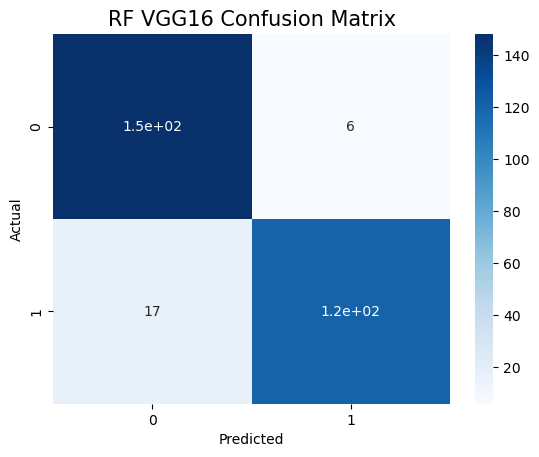

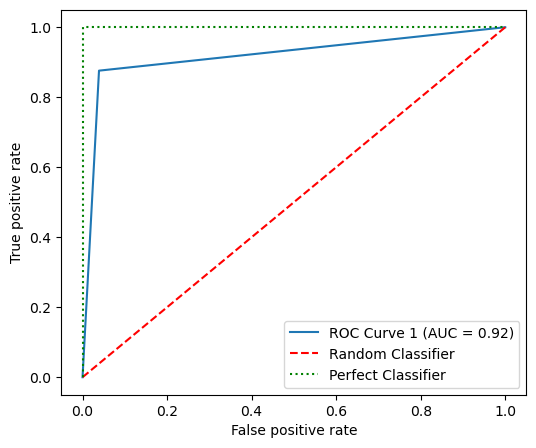

In [112]:
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(y_test_1d, rf_vgg16_prediction)
sns.heatmap(conf_matrix,annot=True,cmap='Blues')
plt.title('RF VGG16 Confusion Matrix',size=15)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.savefig('RF VGG16 conf matrix.png')


from sklearn.metrics import roc_curve, auc, roc_auc_score
fpr , tpr , _ = roc_curve(y_test_1d, rf_vgg16_prediction)
auc = roc_auc_score(y_test_1d, rf_vgg16_prediction)
fig, ax = plt.subplots(figsize=(6, 5))
plt.plot(fpr, tpr, label='ROC Curve (AUC = %0.2f)' % (auc))
plt.plot([0, 1], [0, 1], linestyle='--', color='red', label='Random Classifier')   
plt.plot([0, 0, 1], [0, 1, 1], linestyle=':', color='green', label='Perfect Classifier')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend(loc="lower right")
plt.savefig('RF VGG16 AUC ROC.png')

### Bagging

In [58]:
from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.model_selection import cross_val_score



bag_vgg16_model = BaggingClassifier()
bag_vgg16_model.fit(X_train_vgg16, y_train_1d)
bag_vgg16_prediction = bag_vgg16_model.predict(X_test_vgg16)

#Print overall accuracy

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
print('train set accuracy is:',accuracy_score(y_train_1d, bag_vgg16_model.predict(X_train_vgg16)))
print('test set accuracy is:',accuracy_score(y_test_1d, bag_vgg16_prediction))

print(classification_report(y_test_1d, bag_vgg16_prediction))

train set accuracy is: 0.9888220120378332
test set accuracy is: 0.845360824742268
              precision    recall  f1-score   support

           0       0.82      0.90      0.86       154
           1       0.88      0.78      0.83       137

    accuracy                           0.85       291
   macro avg       0.85      0.84      0.84       291
weighted avg       0.85      0.85      0.84       291



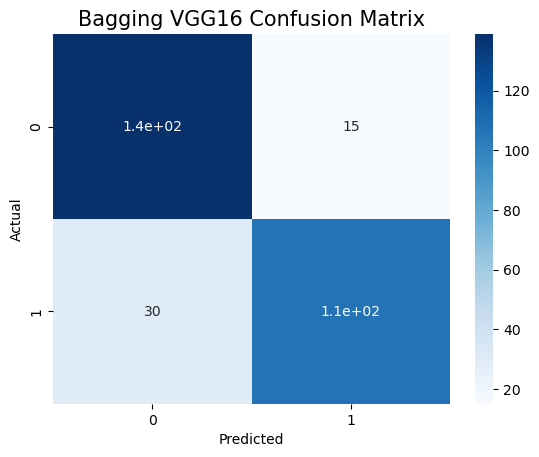

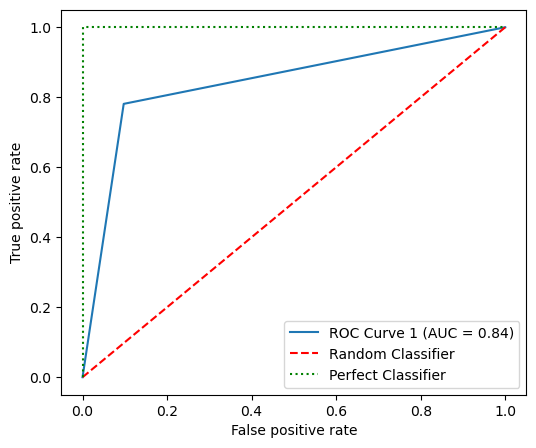

In [106]:
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(y_test_1d, bag_vgg16_prediction)
sns.heatmap(conf_matrix,annot=True,cmap='Blues')
plt.title('Bagging VGG16 Confusion Matrix',size=15)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.savefig('Bagging VGG16 conf matrix.png')


from sklearn.metrics import roc_curve, auc, roc_auc_score
fpr , tpr , _ = roc_curve(y_test_1d, bag_vgg16_prediction)
auc = roc_auc_score(y_test_1d, bag_vgg16_prediction)
fig, ax = plt.subplots(figsize=(6, 5))
plt.plot(fpr, tpr, label='ROC Curve 1 (AUC = %0.2f)' % (auc))
plt.plot([0, 1], [0, 1], linestyle='--', color='red', label='Random Classifier')   
plt.plot([0, 0, 1], [0, 1, 1], linestyle=':', color='green', label='Perfect Classifier')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend(loc="lower right")
plt.savefig('Bagging VGG16 AUC ROC.png')

### AdaBoost

In [59]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.model_selection import cross_val_score



abc_vgg16_model = AdaBoostClassifier()
abc_vgg16_model.fit(X_train_vgg16, y_train_1d)
abc_vgg16_prediction = abc_vgg16_model.predict(X_test_vgg16)

#Print overall accuracy

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
print('train set accuracy is:',accuracy_score(y_train_1d, abc_vgg16_model.predict(X_train_vgg16)))
print('test set accuracy is:',accuracy_score(y_test_1d, abc_vgg16_prediction))

print(classification_report(y_test_1d, abc_vgg16_prediction))

train set accuracy is: 0.9681857265692175
test set accuracy is: 0.8625429553264605
              precision    recall  f1-score   support

           0       0.88      0.86      0.87       154
           1       0.85      0.86      0.86       137

    accuracy                           0.86       291
   macro avg       0.86      0.86      0.86       291
weighted avg       0.86      0.86      0.86       291



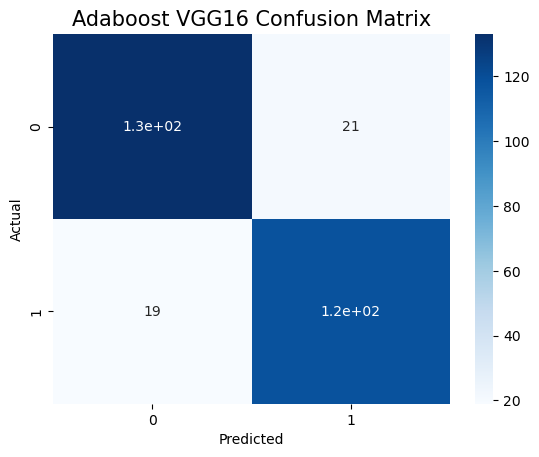

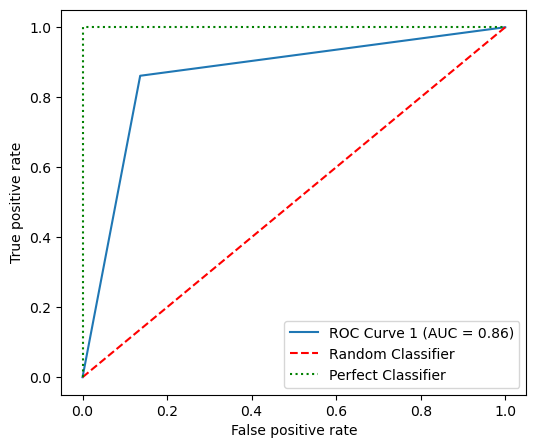

In [107]:
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(y_test_1d, abc_vgg16_prediction)
sns.heatmap(conf_matrix,annot=True,cmap='Blues')
plt.title('Adaboost VGG16 Confusion Matrix',size=15)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.savefig('Adaboost VGG16 conf matrix.png')


from sklearn.metrics import roc_curve, auc, roc_auc_score
fpr , tpr , _ = roc_curve(y_test_1d, abc_vgg16_prediction)
auc = roc_auc_score(y_test_1d, abc_vgg16_prediction)
fig, ax = plt.subplots(figsize=(6, 5))
plt.plot(fpr, tpr, label='ROC Curve 1 (AUC = %0.2f)' % (auc))
plt.plot([0, 1], [0, 1], linestyle='--', color='red', label='Random Classifier')   
plt.plot([0, 0, 1], [0, 1, 1], linestyle=':', color='green', label='Perfect Classifier')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend(loc="lower right")
plt.savefig('Adaboost VGG16 AUC ROC.png')

#  VGG19

In [49]:
from tensorflow.keras.applications import VGG19

In [50]:
#Load model wothout classifier/fully connected layers
VGG19_model = VGG19(weights='imagenet', include_top=False, input_shape=(image_size_224, image_size_224, 3))

#Make loaded layers as non-trainable. This is important as we want to work with pre-trained weights
for layer in VGG19_model.layers:
	layer.trainable = False
    
VGG19_model.summary()  #Trainable parameters will be 0

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [37]:
#Now, let us use features from convolutional network
X_train_VGG19 = VGG19_model.predict(X_train_224)
X_train_VGG19 = X_train_VGG19.reshape(X_train_VGG19.shape[0], -1)
np.save('X_train_vgg19_hommomorphic.npy', X_train_VGG19)

37/37 [==============================] - 441s 12s/step


In [38]:
#Send test data through same feature extractor process
X_test_VGG19 = VGG19_model.predict(X_test_224)
X_test_VGG19 = X_test_VGG19.reshape(X_test_VGG19.shape[0], -1)
np.save('X_test_vgg19_hommomorphic.npy', X_test_VGG19)

10/10 [==============================] - 127s 13s/step


In [51]:
# Load features from the saved file
X_train_VGG19 = np.load('X_train_vgg19_hommomorphic.npy')
X_test_VGG19 = np.load('X_test_vgg19_hommomorphic.npy')

### XGB VGG 19

In [52]:
import xgboost as xgb
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import accuracy_score, classification_report

# Initialize the model
xgb_VGG19_model = xgb.XGBClassifier()

# Perform 5-fold cross-validation
cv = KFold(n_splits=10, shuffle=True, random_state=42)
cv_scores = cross_val_score(xgb_VGG19_model, X_train_VGG19, y_train_1d, cv=cv, scoring='accuracy')

print(f'Cross-validation accuracy scores: {cv_scores}')
print(f'Mean cross-validation accuracy: {cv_scores.mean()}')
print(f'Standard deviation of cross-validation accuracy: {cv_scores.std()}')

# Fit the model on the entire training set
xgb_VGG19_model.fit(X_train_VGG19, y_train_1d)

# Predict on the test set
xgb_VGG19_prediction = xgb_VGG19_model.predict(X_test_VGG19)

# Print overall accuracy
print('Train set accuracy:', accuracy_score(y_train_1d, xgb_VGG19_model.predict(X_train_VGG19)))
print('Test set accuracy:', accuracy_score(y_test_1d, xgb_VGG19_prediction))

# Print classification report
print(classification_report(y_test_1d, xgb_VGG19_prediction))

Cross-validation accuracy scores: [0.94017094 0.82905983 0.83760684 0.93103448 0.90517241 0.87068966
 0.87931034 0.85344828 0.85344828 0.92241379]
Mean cross-validation accuracy: 0.8822354848216918
Standard deviation of cross-validation accuracy: 0.03807478732281226
Train set accuracy: 1.0
Test set accuracy: 0.9209621993127147
              precision    recall  f1-score   support

           0       0.90      0.96      0.93       154
           1       0.95      0.88      0.91       137

    accuracy                           0.92       291
   macro avg       0.92      0.92      0.92       291
weighted avg       0.92      0.92      0.92       291



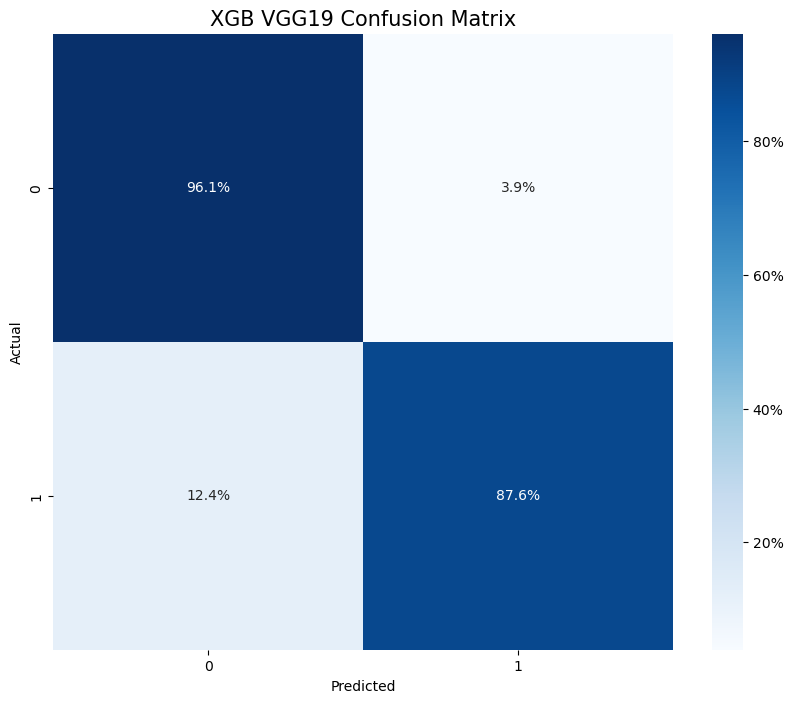

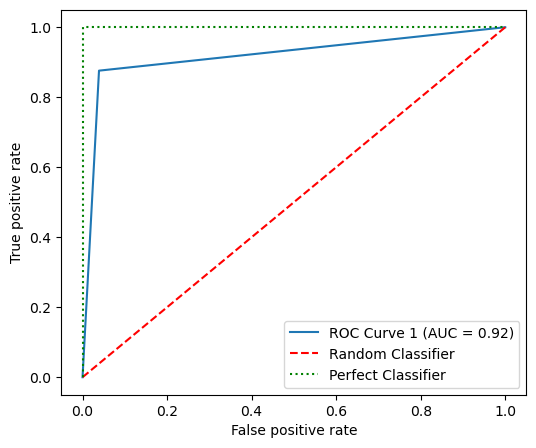

In [53]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
xgb_conf_matrix = confusion_matrix(y_test_1d, xgb_VGG19_prediction)

# Calculate percentages
xgb_conf_matrix_percent = xgb_conf_matrix.astype('float') / xgb_conf_matrix.sum(axis=1)[:, np.newaxis] * 100

# Plotting the normalized confusion matrix
plt.figure(figsize=(10, 8))
ax = sns.heatmap(xgb_conf_matrix_percent, annot=True, cmap='Blues', fmt=".1f", cbar_kws={'format': '%.0f%%'})

# Annotate the heatmap with percentage signs
for t in ax.texts: 
    t.set_text(t.get_text() + "%")

plt.title('XGB VGG19 Confusion Matrix', size=15)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.savefig('XGB_VGG19_conf_matrix_percent.png')
plt.show()




from sklearn.metrics import roc_curve, auc, roc_auc_score
fpr , tpr , _ = roc_curve(y_test_1d, xgb_VGG19_prediction )
auc = roc_auc_score(y_test_1d, xgb_VGG19_prediction)
fig, ax = plt.subplots(figsize=(6, 5))
plt.plot(fpr, tpr, label='ROC Curve 1 (AUC = %0.2f)' % (auc))
plt.plot([0, 1], [0, 1], linestyle='--', color='red', label='Random Classifier')   
plt.plot([0, 0, 1], [0, 1, 1], linestyle=':', color='green', label='Perfect Classifier')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend(loc="lower right")
plt.savefig('XGB VGG19 AUC ROC.png')

### Random Forest VGG 19

In [13]:
from sklearn.ensemble import RandomForestClassifier

In [16]:
rf_vgg19_model = RandomForestClassifier()
rf_vgg19_model.fit(X_train_vgg19, y_train_1d)

#Now predict using the trained  model. 
rf_vgg19_prediction = rf_vgg19_model.predict(X_test_vgg19)

from sklearn.metrics import accuracy_score
print('train set accuracy is:',accuracy_score(y_train_1d, rf_vgg19_model.predict(X_train_vgg19)))
print('test set accuracy is:',accuracy_score(y_test_1d, rf_vgg19_prediction))
from sklearn.metrics import classification_report
print(classification_report(y_test_1d, rf_vgg19_prediction))

train set accuracy is: 1.0
test set accuracy is: 0.9072164948453608
              precision    recall  f1-score   support

           0       0.88      0.96      0.92       154
           1       0.95      0.85      0.90       137

    accuracy                           0.91       291
   macro avg       0.91      0.90      0.91       291
weighted avg       0.91      0.91      0.91       291



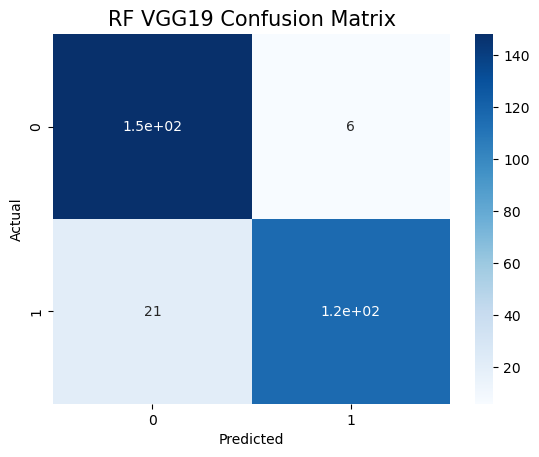

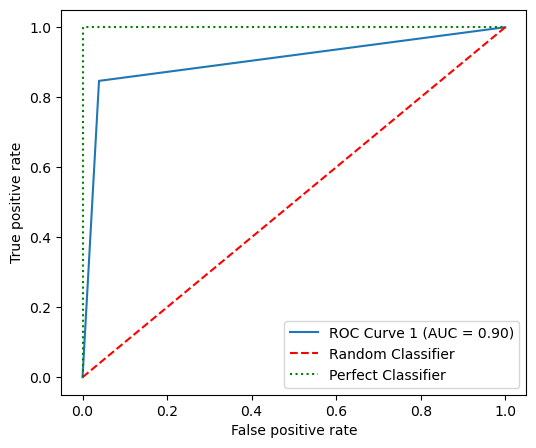

In [17]:
from sklearn.metrics import confusion_matrix
bag_conf_matrix = confusion_matrix(y_test_1d, rf_vgg19_prediction)
sns.heatmap(bag_conf_matrix,annot=True,cmap='Blues')
plt.title('RF VGG19 Confusion Matrix',size=15)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.savefig('RF VGG19 conf matrix.png')


from sklearn.metrics import roc_curve, auc, roc_auc_score
fpr , tpr , _ = roc_curve(y_test_1d, rf_vgg19_prediction)
auc = roc_auc_score(y_test_1d, rf_vgg19_prediction)
fig, ax = plt.subplots(figsize=(6, 5))
plt.plot(fpr, tpr, label='ROC Curve 1 (AUC = %0.2f)' % (auc))
plt.plot([0, 1], [0, 1], linestyle='--', color='red', label='Random Classifier')   
plt.plot([0, 0, 1], [0, 1, 1], linestyle=':', color='green', label='Perfect Classifier')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend(loc="lower right")
plt.savefig('RF VGG19 AUC ROC.png')

### Bagging

In [18]:
from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.model_selection import cross_val_score



bag_vgg19_model = BaggingClassifier()
bag_vgg19_model.fit(X_train_vgg19, y_train_1d)
bag_vgg19_prediction = bag_vgg19_model.predict(X_test_vgg19)

#Print overall accuracy

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
print('train set accuracy is:',accuracy_score(y_train_1d, bag_vgg19_model.predict(X_train_vgg19)))
print('test set accuracy is:',accuracy_score(y_test_1d, bag_vgg19_prediction))

print(classification_report(y_test_1d, bag_vgg19_prediction))

train set accuracy is: 0.9879621668099742
test set accuracy is: 0.8831615120274914
              precision    recall  f1-score   support

           0       0.84      0.96      0.90       154
           1       0.95      0.80      0.87       137

    accuracy                           0.88       291
   macro avg       0.89      0.88      0.88       291
weighted avg       0.89      0.88      0.88       291



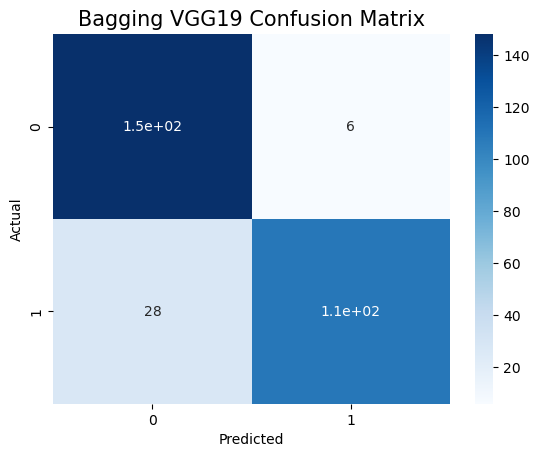

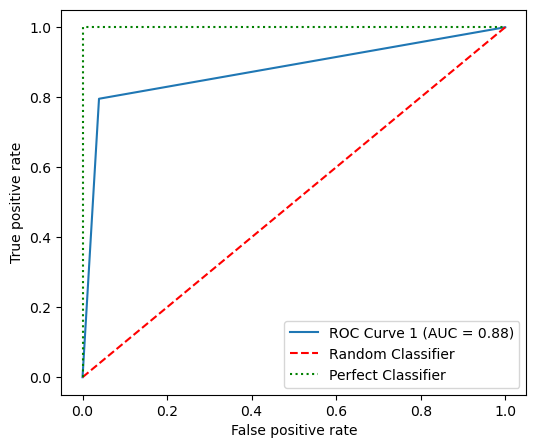

In [19]:
from sklearn.metrics import confusion_matrix
bag_conf_matrix = confusion_matrix(y_test_1d, bag_vgg19_prediction)
sns.heatmap(bag_conf_matrix,annot=True,cmap='Blues')
plt.title('Bagging VGG19 Confusion Matrix',size=15)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.savefig('Bagging VGG19 conf matrix.png')


from sklearn.metrics import roc_curve, auc, roc_auc_score
fpr , tpr , _ = roc_curve(y_test_1d, bag_vgg19_prediction)
auc = roc_auc_score(y_test_1d, bag_vgg19_prediction)
fig, ax = plt.subplots(figsize=(6, 5))
plt.plot(fpr, tpr, label='ROC Curve 1 (AUC = %0.2f)' % (auc))
plt.plot([0, 1], [0, 1], linestyle='--', color='red', label='Random Classifier')   
plt.plot([0, 0, 1], [0, 1, 1], linestyle=':', color='green', label='Perfect Classifier')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend(loc="lower right")
plt.savefig('Bagging VGG19 AUC ROC.png')

### Adaboost

In [20]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.model_selection import cross_val_score



abc_vgg19_model = AdaBoostClassifier()
abc_vgg19_model.fit(X_train_vgg19, y_train_1d)
abc_vgg19_prediction = abc_vgg19_model.predict(X_test_vgg19)

#Print overall accuracy

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
print('train set accuracy is:',accuracy_score(y_train_1d, abc_vgg19_model.predict(X_train_vgg19)))
print('test set accuracy is:',accuracy_score(y_test_1d, abc_vgg19_prediction))

print(classification_report(y_test_1d, abc_vgg19_prediction))

train set accuracy is: 0.9595872742906277
test set accuracy is: 0.852233676975945
              precision    recall  f1-score   support

           0       0.86      0.86      0.86       154
           1       0.85      0.84      0.84       137

    accuracy                           0.85       291
   macro avg       0.85      0.85      0.85       291
weighted avg       0.85      0.85      0.85       291



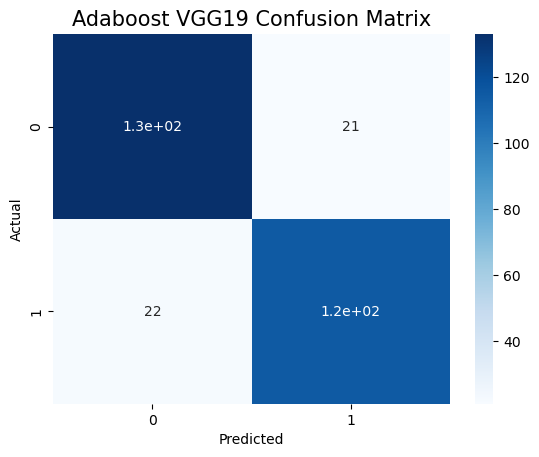

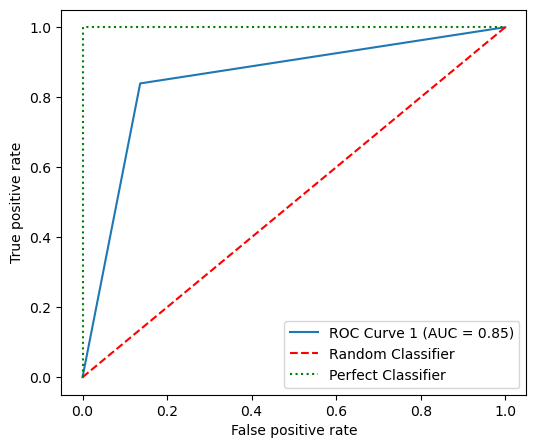

In [21]:
from sklearn.metrics import confusion_matrix
bag_conf_matrix = confusion_matrix(y_test_1d, abc_vgg19_prediction)
sns.heatmap(bag_conf_matrix,annot=True,cmap='Blues')
plt.title('Adaboost VGG19 Confusion Matrix',size=15)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.savefig('Adaboost VGG19 conf matrix.png')


from sklearn.metrics import roc_curve, auc, roc_auc_score
fpr , tpr , _ = roc_curve(y_test_1d, abc_vgg19_prediction)
auc = roc_auc_score(y_test_1d, abc_vgg19_prediction)
fig, ax = plt.subplots(figsize=(6, 5))
plt.plot(fpr, tpr, label='ROC Curve 1 (AUC = %0.2f)' % (auc))
plt.plot([0, 1], [0, 1], linestyle='--', color='red', label='Random Classifier')   
plt.plot([0, 0, 1], [0, 1, 1], linestyle=':', color='green', label='Perfect Classifier')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend(loc="lower right")
plt.savefig('Adaboost VGG19 AUC ROC.png')

# ResNet 50

In [6]:
from keras.applications import ResNet50

In [7]:
image_size_224 = 224

In [8]:
X_train.shape

(7200, 224, 224, 3)

In [9]:
y_train.shape

(7200,)

In [10]:
#Load model wothout classifier/fully connected layers
ResNet50_model = ResNet50(weights='imagenet', include_top=False, input_shape=(image_size_224, image_size_224, 3))

#Make loaded layers as non-trainable. This is important as we want to work with pre-trained weights
for layer in ResNet50_model.layers:
	layer.trainable = False
    
ResNet50_model.summary()  #Trainable parameters will be 0

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                       

In [11]:
#Now, let us use features from convolutional network
X_train_ResNet50 = ResNet50_model.predict(X_train)
X_train_ResNet50 = X_train_ResNet50.reshape(X_train_ResNet50.shape[0], -1)
np.save('X_train_ResNet50_hommomorphic.npy', X_train_ResNet50)

225/225 [==============================] - 964s 4s/step


In [12]:
# # Extract features for test data
X_test_ResNet50 = ResNet50_model.predict(X_test)
X_test_ResNet50 = X_test_ResNet50.reshape(X_test_ResNet50.shape[0], -1)
np.save('X_test_ResNet50_hommomorphic.npy', X_test_ResNet50)

25/25 [==============================] - 110s 4s/step


In [37]:
X_train_ResNet50 = np.load('X_train_ResNet50_hommomorphic.npy')
X_test_ResNet50 = np.load('X_test_ResNet50_hommomorphic.npy')

In [31]:
print(X_train_ResNet50.shape)
print(X_test_ResNet50.shape)

(7200, 100352)
(800, 100352)


### XGBoost ResNet 50

In [39]:
# X_train_ResNet50 = X_train_ResNet50.astype(np.float32)
# X_test_ResNet50 = X_test_ResNet50.astype(np.float32)

In [40]:
# Import libraries
import pandas as pd
import numpy as np 
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score
import matplotlib.pyplot as plt

In [32]:
import xgboost as xgb
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import accuracy_score, classification_report


xgb_ResNet50_model = xgb.XGBClassifier()

# # Perform 5-fold cross-validation
# cv = KFold(n_splits=5, shuffle=True, random_state=42)
# cv_scores = cross_val_score(xgb_ResNet50_model, X_train_ResNet50, y_train, cv=cv, scoring='accuracy')

# print(f'Cross-validation accuracy scores: {cv_scores}')
# print(f'Mean cross-validation accuracy: {cv_scores.mean()}')
# print(f'Standard deviation of cross-validation accuracy: {cv_scores.std()}')

xgb_ResNet50_model.fit(X_train_ResNet50 , y_train) #For sklearn no one hot encoding
#Now predict using the trained  model. 
xgb_ResNet50_prediction = xgb_ResNet50_model.predict(X_test_ResNet50)
#Print overall accuracy
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
print('train set accuracy is:',accuracy_score(y_train, xgb_ResNet50_model.predict(X_train_ResNet50)))
print('test set accuracy is:',accuracy_score(y_test, xgb_ResNet50_prediction))
print(classification_report(y_test,  xgb_ResNet50_prediction))

train set accuracy is: 1.0
test set accuracy is: 0.99875
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       412
           1       1.00      1.00      1.00       388

    accuracy                           1.00       800
   macro avg       1.00      1.00      1.00       800
weighted avg       1.00      1.00      1.00       800



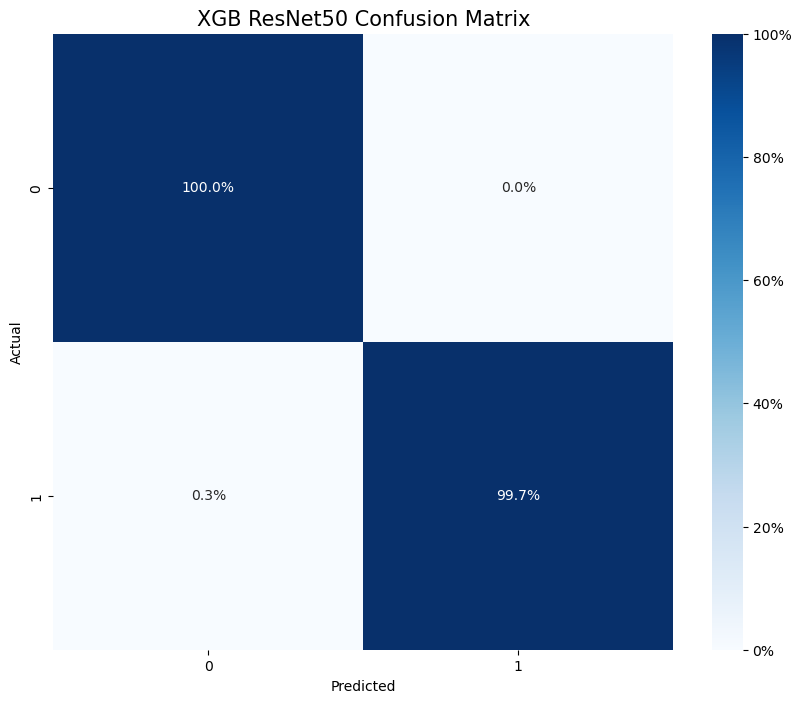

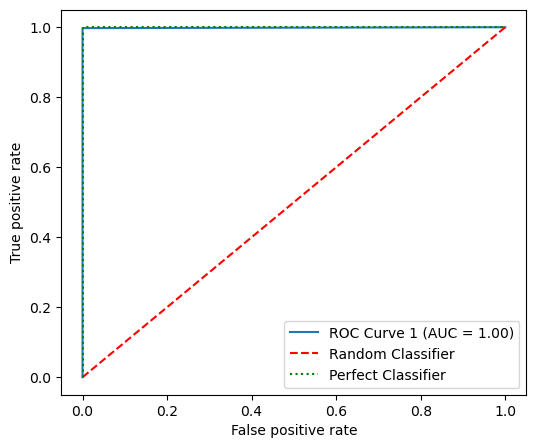

In [33]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
xgb_conf_matrix = confusion_matrix(y_test, xgb_ResNet50_prediction)

# Calculate percentages
xgb_conf_matrix_percent = xgb_conf_matrix.astype('float') / xgb_conf_matrix.sum(axis=1)[:, np.newaxis] * 100

# Plotting the normalized confusion matrix
plt.figure(figsize=(10, 8))
ax = sns.heatmap(xgb_conf_matrix_percent, annot=True, cmap='Blues', fmt=".1f", cbar_kws={'format': '%.0f%%'})

# Annotate the heatmap with percentage signs
for t in ax.texts: 
    t.set_text(t.get_text() + "%")

plt.title('XGB ResNet50 Confusion Matrix', size=15)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.savefig('XGB_ResNet50_conf_matrix_percent.png')
plt.show()




from sklearn.metrics import roc_curve, auc, roc_auc_score
fpr , tpr , _ = roc_curve(y_test, xgb_ResNet50_prediction )
auc = roc_auc_score(y_test, xgb_ResNet50_prediction)
fig, ax = plt.subplots(figsize=(6, 5))
plt.plot(fpr, tpr, label='ROC Curve 1 (AUC = %0.2f)' % (auc))
plt.plot([0, 1], [0, 1], linestyle='--', color='red', label='Random Classifier')   
plt.plot([0, 0, 1], [0, 1, 1], linestyle=':', color='green', label='Perfect Classifier')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend(loc="lower right")
plt.savefig('XGB ResNet50 AUC ROC.png')

### Random Forest ResNet50

In [34]:
from sklearn.ensemble import RandomForestClassifier

In [35]:
rf_ResNet50_model = RandomForestClassifier()
rf_ResNet50_model.fit(X_train_ResNet50, y_train)
#Now predict using the trained  model. 
rf_ResNet50_prediction = rf_ResNet50_model.predict(X_test_ResNet50)
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
print('train set accuracy is:',accuracy_score(y_train, rf_ResNet50_model.predict(X_train_ResNet50)))
print('test set accuracy is:',accuracy_score(y_test, rf_ResNet50_prediction))
print(classification_report(y_test, rf_ResNet50_prediction))

train set accuracy is: 1.0
test set accuracy is: 0.985
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       412
           1       0.99      0.98      0.98       388

    accuracy                           0.98       800
   macro avg       0.99      0.98      0.98       800
weighted avg       0.99      0.98      0.98       800



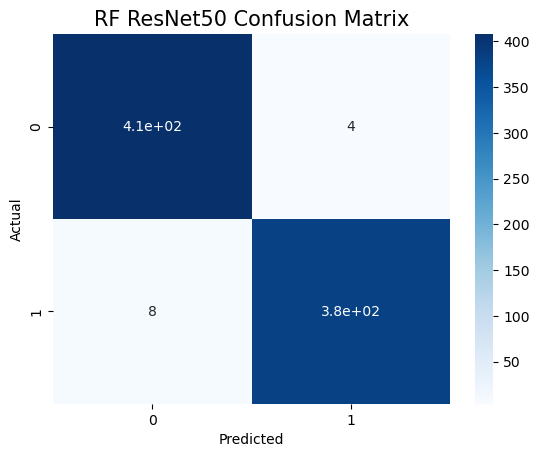

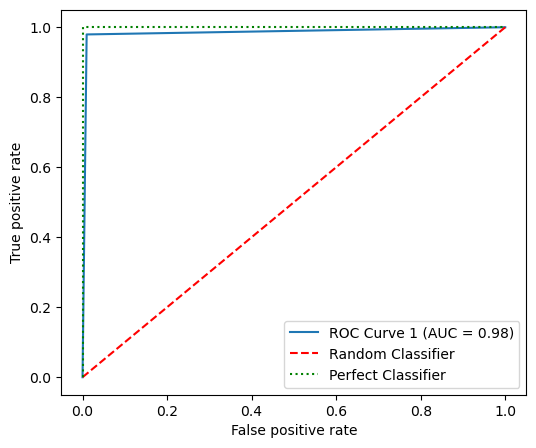

In [36]:
from sklearn.metrics import confusion_matrix
bag_conf_matrix = confusion_matrix(y_test, rf_ResNet50_prediction)
sns.heatmap(bag_conf_matrix,annot=True,cmap='Blues')
plt.title('RF ResNet50 Confusion Matrix',size=15)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.savefig('RF ResNet50 conf matrix.png')


from sklearn.metrics import roc_curve, auc, roc_auc_score
fpr , tpr , _ = roc_curve(y_test, rf_ResNet50_prediction)
auc = roc_auc_score(y_test, rf_ResNet50_prediction)
fig, ax = plt.subplots(figsize=(6, 5))
plt.plot(fpr, tpr, label='ROC Curve 1 (AUC = %0.2f)' % (auc))
plt.plot([0, 1], [0, 1], linestyle='--', color='red', label='Random Classifier')   
plt.plot([0, 0, 1], [0, 1, 1], linestyle=':', color='green', label='Perfect Classifier')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend(loc="lower right")
plt.savefig('Rf ResNet50 AUC ROC.png')

### Bagging

In [37]:
from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.model_selection import cross_val_score



bag_ResNet50_model = BaggingClassifier()
bag_ResNet50_model.fit(X_train_ResNet50, y_train)
bag_ResNet50_prediction = bag_ResNet50_model.predict(X_test_ResNet50)

#Print overall accuracy

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
print('train set accuracy is:',accuracy_score(y_train, bag_ResNet50_model.predict(X_train_ResNet50)))
print('test set accuracy is:',accuracy_score(y_test, bag_ResNet50_prediction))

print(classification_report(y_test, bag_ResNet50_prediction))

train set accuracy is: 0.9998611111111111
test set accuracy is: 0.9875
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       412
           1       1.00      0.98      0.99       388

    accuracy                           0.99       800
   macro avg       0.99      0.99      0.99       800
weighted avg       0.99      0.99      0.99       800



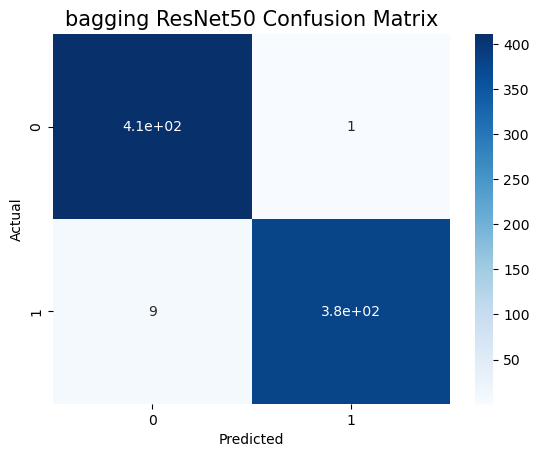

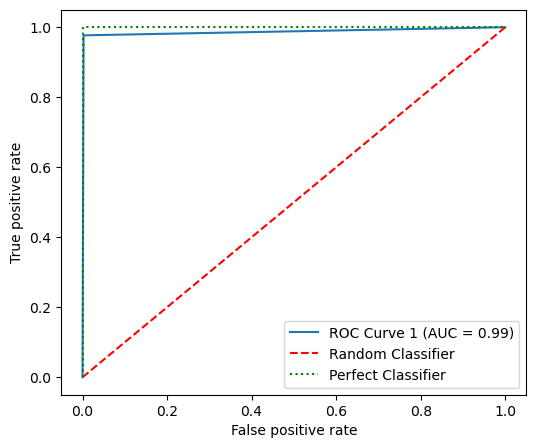

In [38]:
from sklearn.metrics import confusion_matrix
bag_conf_matrix = confusion_matrix(y_test, bag_ResNet50_prediction)
sns.heatmap(bag_conf_matrix,annot=True,cmap='Blues')
plt.title('bagging ResNet50 Confusion Matrix',size=15)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.savefig('bagging ResNet50 conf matrix.png')


from sklearn.metrics import roc_curve, auc, roc_auc_score
fpr , tpr , _ = roc_curve(y_test, bag_ResNet50_prediction)
auc = roc_auc_score(y_test, bag_ResNet50_prediction)
fig, ax = plt.subplots(figsize=(6, 5))
plt.plot(fpr, tpr, label='ROC Curve 1 (AUC = %0.2f)' % (auc))
plt.plot([0, 1], [0, 1], linestyle='--', color='red', label='Random Classifier')   
plt.plot([0, 0, 1], [0, 1, 1], linestyle=':', color='green', label='Perfect Classifier')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend(loc="lower right")
plt.savefig('bagging ResNet50 AUC ROC.png')

### Adaboost

In [39]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.model_selection import cross_val_score



abc_ResNet50_model = AdaBoostClassifier()
abc_ResNet50_model.fit(X_train_ResNet50, y_train)
abc_ResNet50_prediction = abc_ResNet50_model.predict(X_test_ResNet50)

#Print overall accuracy

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
print('train set accuracy is:',accuracy_score(y_train, abc_ResNet50_model.predict(X_train_ResNet50)))
print('test set accuracy is:',accuracy_score(y_test, abc_ResNet50_prediction))

print(classification_report(y_test, abc_ResNet50_prediction))

train set accuracy is: 1.0
test set accuracy is: 0.99875
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       412
           1       1.00      1.00      1.00       388

    accuracy                           1.00       800
   macro avg       1.00      1.00      1.00       800
weighted avg       1.00      1.00      1.00       800



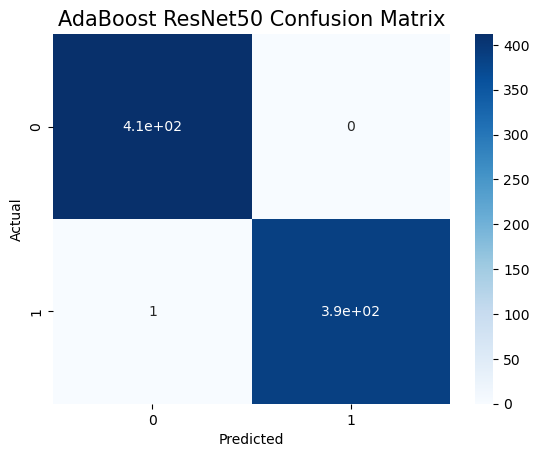

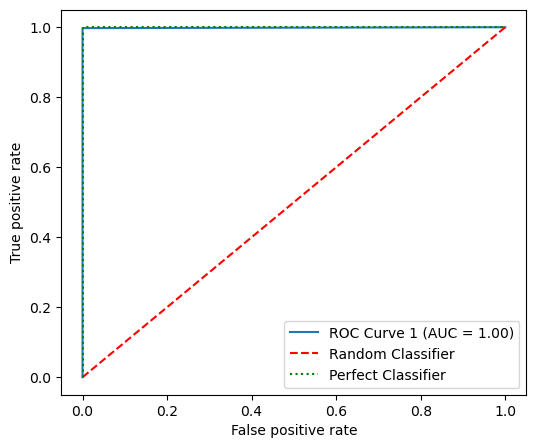

In [43]:
from sklearn.metrics import confusion_matrix
bag_conf_matrix = confusion_matrix(y_test, abc_ResNet50_prediction)
sns.heatmap(bag_conf_matrix,annot=True,cmap='Blues')
plt.title('AdaBoost ResNet50 Confusion Matrix',size=15)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.savefig('AdaBoost ResNet50 conf matrix.png')


from sklearn.metrics import roc_curve, auc, roc_auc_score
fpr , tpr , _ = roc_curve(y_test, abc_ResNet50_prediction )
auc = roc_auc_score(y_test, abc_ResNet50_prediction)
fig, ax = plt.subplots(figsize=(6, 5))
plt.plot(fpr, tpr, label='ROC Curve 1 (AUC = %0.2f)' % (auc))
plt.plot([0, 1], [0, 1], linestyle='--', color='red', label='Random Classifier')   
plt.plot([0, 0, 1], [0, 1, 1], linestyle=':', color='green', label='Perfect Classifier')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend(loc="lower right")
plt.savefig('AdaBoost ResNet50 AUC ROC.png')

# ResNet50 v2

In [10]:
from keras.applications import ResNet50V2

In [24]:
#Load model wothout classifier/fully connected layers
ResNet50V2_model = ResNet50V2(weights='imagenet', include_top=False, input_shape=(image_size_224, image_size_224, 3))

#Make loaded layers as non-trainable. This is important as we want to work with pre-trained weights
for layer in ResNet50V2_model.layers:
	layer.trainable = False
    
ResNet50V2_model.summary()  #Trainable parameters will be 0

Model: "resnet50v2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_2[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 pool1_pad (ZeroPadding2D)   (None, 114, 114, 64)         0         ['conv1_conv[0][0]']          
                                                                                         

In [26]:
# #Now, let us use features from convolutional network
X_train_ResNet50V2 = ResNet50V2_model.predict(X_train)
X_train_ResNet50V2 = X_train_ResNet50V2.reshape(X_train_ResNet50V2.shape[0], -1)
# # Save features to a file
np.save('X_train_ResNet50V2_hommomorphic_without_segmentation.npy', X_train_ResNet50V2)

921/921 [==============================] - 5518s 6s/step


MemoryError: Unable to allocate 11.0 GiB for an array with shape (29454, 7, 7, 2048) and data type float32

In [28]:
# Extract features for test data
X_test_ResNet50V2 = ResNet50V2_model.predict(X_test)
X_test_ResNet50V2 = X_test_ResNet50V2.reshape(X_test_ResNet50V2.shape[0], -1)
# Save features to a file
np.save('X_test_ResNet50V2_hommomorphic_without_segmentation.npy', X_test_ResNet50V2)

231/231 [==============================] - 1796s 8s/step


MemoryError: Unable to allocate 2.75 GiB for an array with shape (7364, 7, 7, 2048) and data type float32

In [38]:
# Load features from the saved file
X_train_ResNet50V2 = np.load('X_train_ResNet50V2_hommomorphic_without_segmentation.npy')
X_test_ResNet50V2 = np.load('X_test_ResNet50V2_hommomorphic_without_segmentation.npy')

### XGB ResNet50 V2

In [39]:
import xgboost as xgb
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import accuracy_score, classification_report


xgb_ResNet50V2_model = xgb.XGBClassifier()

# Perform 5-fold cross-validation
cv = KFold(n_splits=10, shuffle=True, random_state=42)
cv_scores = cross_val_score(xgb_ResNet50V2_model, X_train_ResNet50V2, y_train_1d, cv=cv, scoring='accuracy')

print(f'Cross-validation accuracy scores: {cv_scores}')
print(f'Mean cross-validation accuracy: {cv_scores.mean()}')
print(f'Standard deviation of cross-validation accuracy: {cv_scores.std()}')

xgb_ResNet50V2_model.fit(X_train_ResNet50V2 , y_train_1d) #For sklearn no one hot encoding
#Now predict using the trained  model. 
xgb_ResNet50V2_prediction = xgb_ResNet50V2_model.predict(X_test_ResNet50V2)
#Print overall accuracy
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
print('train set accuracy is:',accuracy_score(y_train_1d, xgb_ResNet50V2_model.predict(X_train_ResNet50V2)))
print('test set accuracy is:',accuracy_score(y_test_1d, xgb_ResNet50V2_prediction))
print(classification_report(y_test_1d,  xgb_ResNet50V2_prediction))

Cross-validation accuracy scores: [0.90598291 0.91452991 0.87179487 0.90517241 0.87068966 0.86206897
 0.87068966 0.89655172 0.8362069  0.88793103]
Mean cross-validation accuracy: 0.8821618037135279
Standard deviation of cross-validation accuracy: 0.022959204737121434
train set accuracy is: 1.0
test set accuracy is: 0.9003436426116839
              precision    recall  f1-score   support

           0       0.89      0.92      0.91       154
           1       0.91      0.88      0.89       137

    accuracy                           0.90       291
   macro avg       0.90      0.90      0.90       291
weighted avg       0.90      0.90      0.90       291



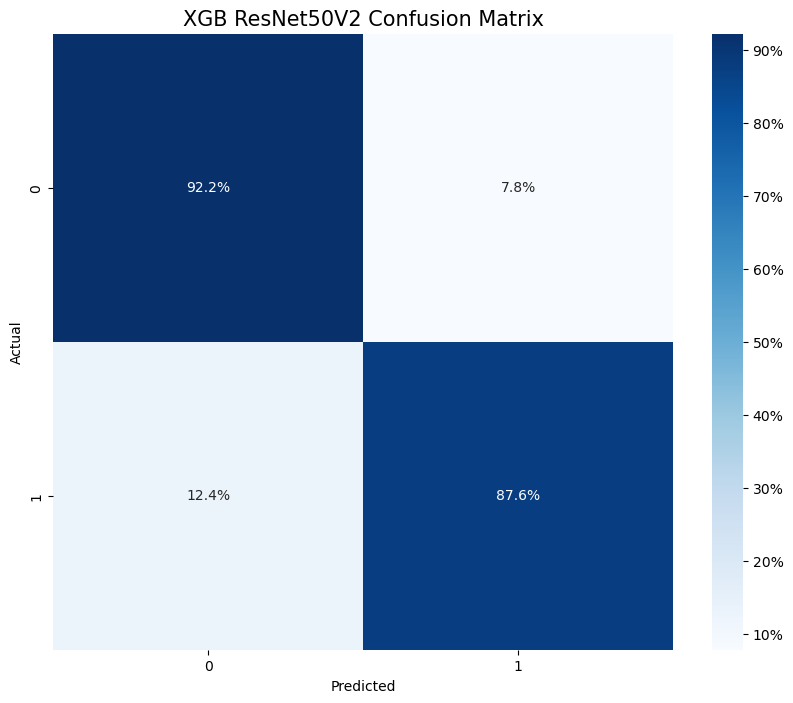

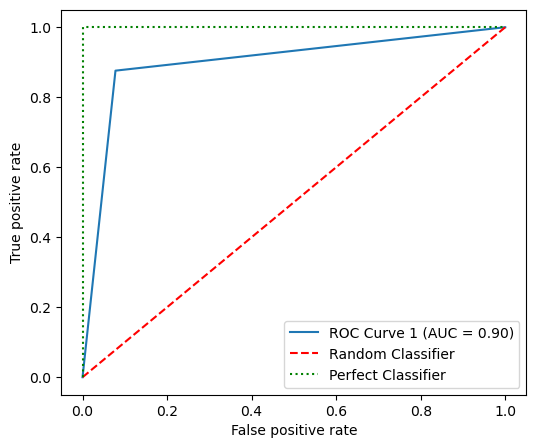

In [40]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
xgb_conf_matrix = confusion_matrix(y_test_1d, xgb_ResNet50V2_prediction)

# Calculate percentages
xgb_conf_matrix_percent = xgb_conf_matrix.astype('float') / xgb_conf_matrix.sum(axis=1)[:, np.newaxis] * 100

# Plotting the normalized confusion matrix
plt.figure(figsize=(10, 8))
ax = sns.heatmap(xgb_conf_matrix_percent, annot=True, cmap='Blues', fmt=".1f", cbar_kws={'format': '%.0f%%'})

# Annotate the heatmap with percentage signs
for t in ax.texts: 
    t.set_text(t.get_text() + "%")

plt.title('XGB ResNet50V2 Confusion Matrix', size=15)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.savefig('XGB_ResNet50V2_conf_matrix_percent.png')
plt.show()




from sklearn.metrics import roc_curve, auc, roc_auc_score
fpr , tpr , _ = roc_curve(y_test_1d, xgb_ResNet50V2_prediction )
auc = roc_auc_score(y_test_1d, xgb_ResNet50V2_prediction)
fig, ax = plt.subplots(figsize=(6, 5))
plt.plot(fpr, tpr, label='ROC Curve 1 (AUC = %0.2f)' % (auc))
plt.plot([0, 1], [0, 1], linestyle='--', color='red', label='Random Classifier')   
plt.plot([0, 0, 1], [0, 1, 1], linestyle=':', color='green', label='Perfect Classifier')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend(loc="lower right")
plt.savefig('XGB ResNet50V2 AUC ROC.png')

### Random Forest ResNet50 V2

In [94]:
from sklearn.ensemble import RandomForestClassifier
rf_ResNet50V2_model = RandomForestClassifier()
rf_ResNet50V2_model.fit(X_train_ResNet50V2, y_train_1d)

#Now predict using the trained  model. 
rf_ResNet50V2_prediction = rf_ResNet50V2_model.predict(X_test_ResNet50V2)

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
print('train set accuracy is:',accuracy_score(y_train_1d, rf_ResNet50V2_model.predict(X_train_ResNet50V2)))
print('test set accuracy is:',accuracy_score(y_test_1d, rf_ResNet50V2_prediction))
print(classification_report(y_test_1d, rf_ResNet50V2_prediction))

train set accuracy is: 1.0
test set accuracy is: 0.8900343642611683
              precision    recall  f1-score   support

           0       0.86      0.95      0.90       154
           1       0.93      0.82      0.88       137

    accuracy                           0.89       291
   macro avg       0.90      0.89      0.89       291
weighted avg       0.89      0.89      0.89       291



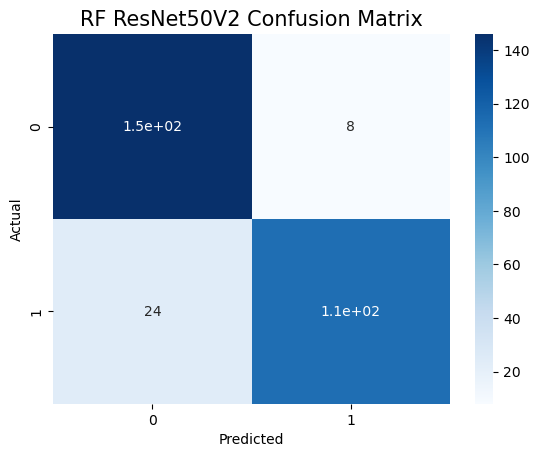

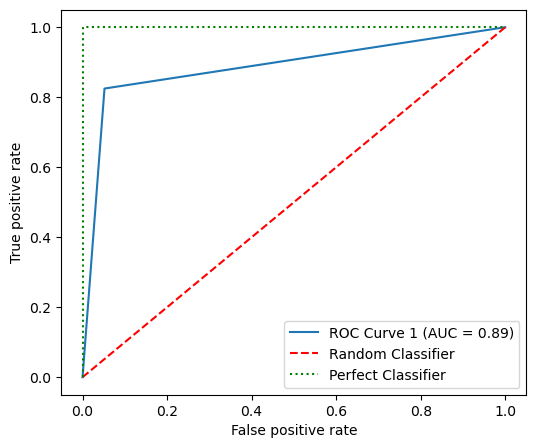

In [95]:
from sklearn.metrics import confusion_matrix
bag_conf_matrix = confusion_matrix(y_test_1d, rf_ResNet50V2_prediction)
sns.heatmap(bag_conf_matrix,annot=True,cmap='Blues')
plt.title('RF ResNet50V2 Confusion Matrix',size=15)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.savefig('RF ResNet50V2 conf matrix.png')


from sklearn.metrics import roc_curve, auc, roc_auc_score
fpr , tpr , _ = roc_curve(y_test_1d, rf_ResNet50V2_prediction )
auc = roc_auc_score(y_test_1d, rf_ResNet50V2_prediction)
fig, ax = plt.subplots(figsize=(6, 5))
plt.plot(fpr, tpr, label='ROC Curve 1 (AUC = %0.2f)' % (auc))
plt.plot([0, 1], [0, 1], linestyle='--', color='red', label='Random Classifier')   
plt.plot([0, 0, 1], [0, 1, 1], linestyle=':', color='green', label='Perfect Classifier')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend(loc="lower right")
plt.savefig('RF ResNet50V2 AUC ROC.png')

### Bagging

In [48]:
from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.model_selection import cross_val_score



bag_ResNet50V2_model = BaggingClassifier()
bag_ResNet50V2_model.fit(X_train_ResNet50V2, y_train_1d)
bag_ResNet50V2_prediction = bag_ResNet50V2_model.predict(X_test_ResNet50V2)

#Print overall accuracy

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
print('train set accuracy is:',accuracy_score(y_train_1d, bag_ResNet50V2_model.predict(X_train_ResNet50V2)))
print('test set accuracy is:',accuracy_score(y_test_1d, bag_ResNet50V2_prediction))

print(classification_report(y_test_1d, bag_ResNet50V2_prediction))

train set accuracy is: 0.9862424763542562
test set accuracy is: 0.865979381443299
              precision    recall  f1-score   support

           0       0.86      0.90      0.88       154
           1       0.88      0.83      0.85       137

    accuracy                           0.87       291
   macro avg       0.87      0.86      0.87       291
weighted avg       0.87      0.87      0.87       291



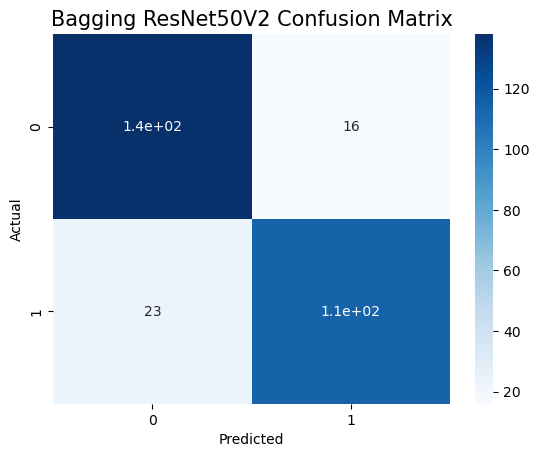

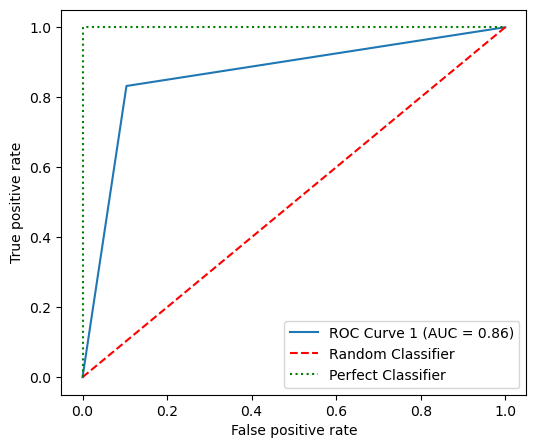

In [88]:
from sklearn.metrics import confusion_matrix
bag_conf_matrix = confusion_matrix(y_test_1d, bag_ResNet50V2_prediction)
sns.heatmap(bag_conf_matrix,annot=True,cmap='Blues')
plt.title('Bagging ResNet50V2 Confusion Matrix',size=15)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.savefig('Bagging ResNet50V2 conf matrix.png')


from sklearn.metrics import roc_curve, auc, roc_auc_score
fpr , tpr , _ = roc_curve(y_test_1d, bag_ResNet50V2_prediction )
auc = roc_auc_score(y_test_1d, bag_ResNet50V2_prediction)
fig, ax = plt.subplots(figsize=(6, 5))
plt.plot(fpr, tpr, label='ROC Curve 1 (AUC = %0.2f)' % (auc))
plt.plot([0, 1], [0, 1], linestyle='--', color='red', label='Random Classifier')   
plt.plot([0, 0, 1], [0, 1, 1], linestyle=':', color='green', label='Perfect Classifier')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend(loc="lower right")
plt.savefig('Bagging ResNet50V2 AUC ROC.png')

### Adaboost

In [49]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.model_selection import cross_val_score



abc_ResNet50V2_model = AdaBoostClassifier()
abc_ResNet50V2_model.fit(X_train_ResNet50V2, y_train_1d)
abc_ResNet50V2_prediction = abc_ResNet50V2_model.predict(X_test_ResNet50V2)

#Print overall accuracy

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
print('train set accuracy is:',accuracy_score(y_train_1d, abc_ResNet50V2_model.predict(X_train_ResNet50V2)))
print('test set accuracy is:',accuracy_score(y_test_1d, abc_ResNet50V2_prediction))

print(classification_report(y_test_1d, abc_ResNet50V2_prediction))

train set accuracy is: 0.9707652622527945
test set accuracy is: 0.8625429553264605
              precision    recall  f1-score   support

           0       0.88      0.86      0.87       154
           1       0.84      0.87      0.86       137

    accuracy                           0.86       291
   macro avg       0.86      0.86      0.86       291
weighted avg       0.86      0.86      0.86       291



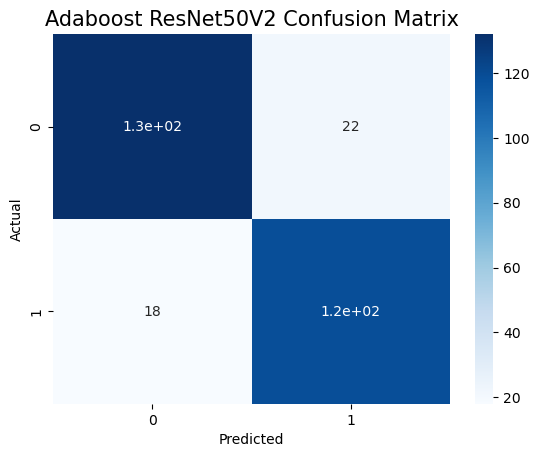

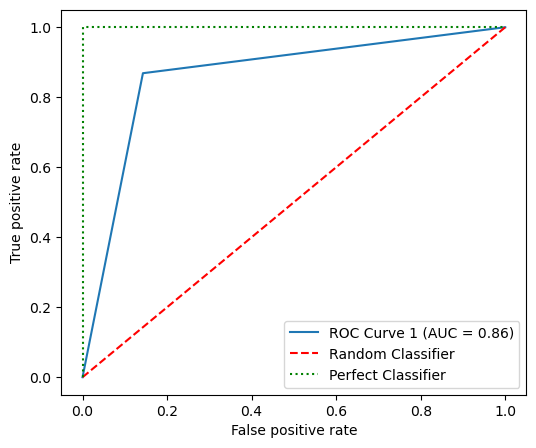

In [87]:
from sklearn.metrics import confusion_matrix
bag_conf_matrix = confusion_matrix(y_test_1d, abc_ResNet50V2_prediction)
sns.heatmap(bag_conf_matrix,annot=True,cmap='Blues')
plt.title('Adaboost ResNet50V2 Confusion Matrix',size=15)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.savefig('Adaboost ResNet50V2 conf matrix.png')


from sklearn.metrics import roc_curve, auc, roc_auc_score
fpr , tpr , _ = roc_curve(y_test_1d, abc_ResNet50V2_prediction )
auc = roc_auc_score(y_test_1d, abc_ResNet50V2_prediction)
fig, ax = plt.subplots(figsize=(6, 5))
plt.plot(fpr, tpr, label='ROC Curve 1 (AUC = %0.2f)' % (auc))
plt.plot([0, 1], [0, 1], linestyle='--', color='red', label='Random Classifier')   
plt.plot([0, 0, 1], [0, 1, 1], linestyle=':', color='green', label='Perfect Classifier')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend(loc="lower right")
plt.savefig('Adaboost ResNet50V2 AUC ROC.png')

In [85]:
### Grid Search
from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.model_selection import cross_val_score

kfold = KFold(n_splits=5, random_state=7,shuffle=True)
# Initialize the bagging classifier with decision Tree base
bag = BaggingClassifier()

bag_param_grid = {
    'n_estimators': range(1,50)
}

bag_gs = GridSearchCV(bag,
                      bag_param_grid,
                      cv=kfold)

bag_gs_result = bag_gs.fit(X_train_ResNet50V2, y_train_1d)
print(bag_gs_result)

n_estimators = bag_gs_result.best_params_['n_estimators']

bag_gs_result.best_estimator_
bag_gs_result.best_params_

bag_cv_scores = cross_val_score(bag_gs, X_train_ResNet50V2, y_train_1d, cv=kfold)
bag_cv_scores.mean()

best_bag = BaggingClassifier(n_estimators=n_estimators)
best_bag.fit(X_train_ResNet50V2, y_train_1d)

bag_y_hat = best_bag.predict(X_test_ResNet50V2)

from sklearn.metrics import accuracy_score

print("Train set Accuracy:",accuracy_score(y_train_1d, best_bag.predict(X_train_ResNet50V2)))
print("Test set Accuracy:",accuracy_score(y_test_1d, bag_y_hat))

from sklearn.metrics import classification_report
print(classification_report(y_test_1d,bag_y_hat))

from sklearn.metrics import confusion_matrix
bag_conf_matrix = confusion_matrix(y_test_1d, bag_y_hat)
sns.heatmap(bag_conf_matrix,annot=True,cmap='Blues')
plt.title('Bagging Confusion Matrix',size=15)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.savefig('Bagging conf matrix.png')


from sklearn.metrics import roc_curve, auc, roc_auc_score
fpr , tpr , _ = roc_curve(y_test_1d, bag_y_hat )
auc = roc_auc_score(y_test_1d, bag_y_hat)
fig, ax = plt.subplots(figsize=(6, 5))
plt.plot(fpr, tpr, label='ROC Curve 1 (AUC = %0.2f)' % (auc))
plt.plot([0, 1], [0, 1], linestyle='--', color='red', label='Random Classifier')   
plt.plot([0, 0, 1], [0, 1, 1], linestyle=':', color='green', label='Perfect Classifier')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend(loc="lower right")
plt.savefig('Bagging AUC ROC.png')

KeyboardInterrupt: 

# Xception

In [18]:
from keras.applications import Xception
#Load model wothout classifier/fully connected layers
Xception_model = Xception(weights='imagenet', include_top=False, input_shape=(image_size_224, image_size_224, 3))

#Make loaded layers as non-trainable. This is important as we want to work with pre-trained weights
for layer in Xception_model.layers:
	layer.trainable = False
    
Xception_model.summary()  #Trainable parameters will be 0


Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, 111, 111, 32)         864       ['input_3[0][0]']             
                                                                                                  
 block1_conv1_bn (BatchNorm  (None, 111, 111, 32)         128       ['block1_conv1[0][0]']        
 alization)                                                                                       
                                                                                                  
 block1_conv1_act (Activati  (None, 111, 111, 32)         0         ['block1_conv1_bn[0][0]

In [19]:
# #Now, let us use features from convolutional network
X_train_Xception = Xception_model.predict(X_train)
X_train_Xception = X_train_Xception.reshape(X_train_Xception.shape[0], -1)
# # Save features to a file
np.save('X_train_Xception_hommomorphic.npy', X_train_Xception)

  6/225 [..............................] - ETA: 19:18

KeyboardInterrupt: 

In [31]:
from keras.applications import Xception
from keras.preprocessing.image import ImageDataGenerator
import numpy as np

# Parameters
image_size = (224, 224)
batch_size = 32  # Adjust based on your available memory

# Load model without classifier/fully connected layers
Xception_model = Xception(weights='imagenet', include_top=False, input_shape=(image_size[0], image_size[1], 3))

# Make loaded layers as non-trainable
for layer in Xception_model.layers:
    layer.trainable = False

Xception_model.summary()  # Trainable parameters will be 0

# Assuming X_train is a NumPy array of images
# Create a custom generator to yield batches of images
def custom_generator(X, batch_size):
    num_samples = X.shape[0]
    while True:  # Loop indefinitely so the generator never terminates
        for offset in range(0, num_samples, batch_size):
            batch_samples = X[offset:offset+batch_size]
            yield batch_samples

# Initialize the custom generator
train_generator = custom_generator(X_train, batch_size)

# Calculate the number of steps per epoch
steps_per_epoch = len(X_train) // batch_size

# Initialize an empty list to store features
features = []

# Extract features in batches and store them
for i in range(steps_per_epoch):
    inputs_batch = next(train_generator)
    features_batch = Xception_model.predict(inputs_batch)
    features.append(features_batch)

# If there are remaining samples that don't fit into the last batch
if len(X_train) % batch_size != 0:
    inputs_batch = next(train_generator)
    features_batch = Xception_model.predict(inputs_batch)
    features.append(features_batch)

# Convert the list of features into a numpy array
features = np.concatenate(features)

# Reshape the features to the desired shape
features = features.reshape(features.shape[0], -1)

# Save features to a file
np.save('X_train_Xception_homomorphic.npy', features)

print("Features extracted and saved successfully.")


Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, 111, 111, 32)         864       ['input_5[0][0]']             
                                                                                                  
 block1_conv1_bn (BatchNorm  (None, 111, 111, 32)         128       ['block1_conv1[0][0]']        
 alization)                                                                                       
                                                                                                  
 block1_conv1_act (Activati  (None, 111, 111, 32)         0         ['block1_conv1_bn[0][0]

In [20]:
# Extract features for test data
X_test_Xception = Xception_model.predict(X_test)
X_test_Xception = X_test_Xception.reshape(X_test_Xception.shape[0], -1)
# Save features to a file
np.save('X_test_Xception_hommomorphic.npy', X_test_Xception)

25/25 [==============================] - 122s 5s/step


In [21]:
# Load features from the saved file
X_train_Xception = np.load('X_train_Xception_homomorphic.npy')
X_test_Xception = np.load('X_test_Xception_hommomorphic.npy')

In [21]:
X_train_Xception.shape

(7200, 100352)

### XGB Xception

In [22]:
import xgboost as xgb
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import accuracy_score, classification_report

# Initialize the model
xgb_Xception_model = xgb.XGBClassifier()

# # Perform 5-fold cross-validation
# cv = KFold(n_splits=5, shuffle=True, random_state=42)
# cv_scores = cross_val_score(xgb_Xception_model, X_train_Xception, y_train, cv=cv, scoring='accuracy')

# print(f'Cross-validation accuracy scores: {cv_scores}')
# print(f'Mean cross-validation accuracy: {cv_scores.mean()}')
# print(f'Standard deviation of cross-validation accuracy: {cv_scores.std()}')

# Fit the model on the entire training set
xgb_Xception_model.fit(X_train_Xception, y_train)

# Predict on the test set
xgb_Xception_prediction = xgb_Xception_model.predict(X_test_Xception)

# Print overall accuracy
print('Train set accuracy:', accuracy_score(y_train, xgb_Xception_model.predict(X_train_Xception)))
print('Test set accuracy:', accuracy_score(y_test, xgb_Xception_prediction))

# Print classification report
print(classification_report(y_test, xgb_Xception_prediction))

Train set accuracy: 1.0
Test set accuracy: 0.78
              precision    recall  f1-score   support

           0       0.76      0.84      0.80       412
           1       0.81      0.72      0.76       388

    accuracy                           0.78       800
   macro avg       0.78      0.78      0.78       800
weighted avg       0.78      0.78      0.78       800



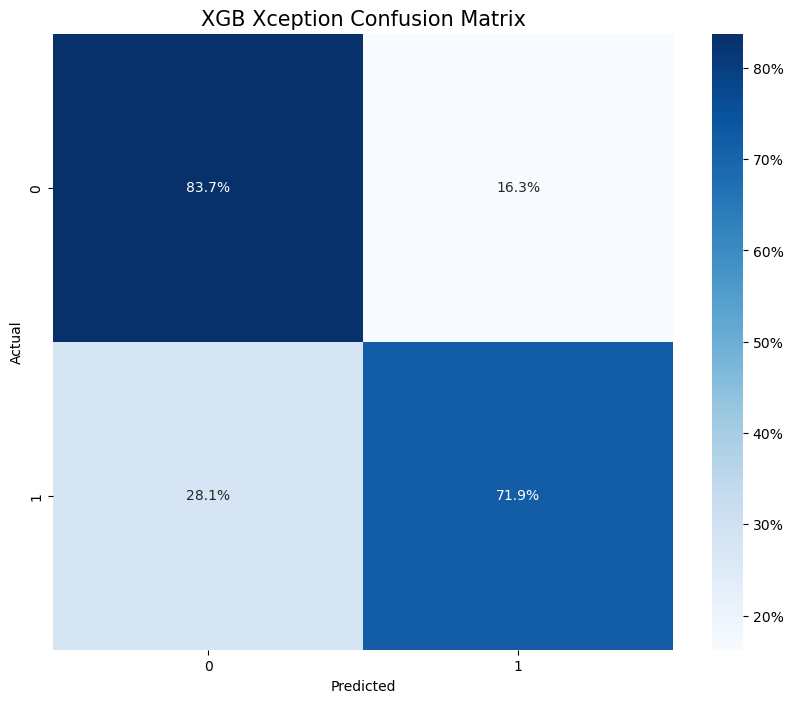

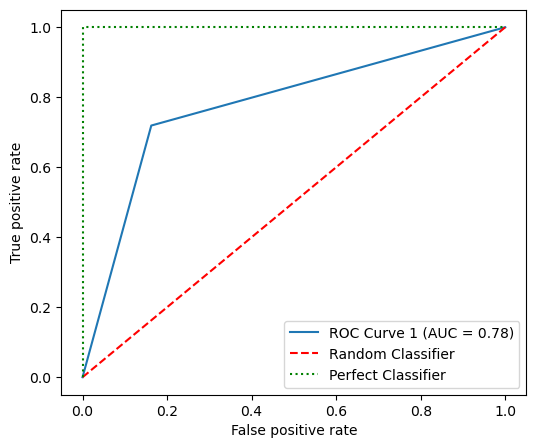

In [24]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
xgb_conf_matrix = confusion_matrix(y_test, xgb_Xception_prediction)

# Calculate percentages
xgb_conf_matrix_percent = xgb_conf_matrix.astype('float') / xgb_conf_matrix.sum(axis=1)[:, np.newaxis] * 100

# Plotting the normalized confusion matrix
plt.figure(figsize=(10, 8))
ax = sns.heatmap(xgb_conf_matrix_percent, annot=True, cmap='Blues', fmt=".1f", cbar_kws={'format': '%.0f%%'})

# Annotate the heatmap with percentage signs
for t in ax.texts: 
    t.set_text(t.get_text() + "%")

plt.title('XGB Xception Confusion Matrix', size=15)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.savefig('XGB_Xception_conf_matrix_percent.png')
plt.show()




from sklearn.metrics import roc_curve, auc, roc_auc_score
fpr , tpr , _ = roc_curve(y_test, xgb_Xception_prediction )
auc = roc_auc_score(y_test, xgb_Xception_prediction)
fig, ax = plt.subplots(figsize=(6, 5))
plt.plot(fpr, tpr, label='ROC Curve 1 (AUC = %0.2f)' % (auc))
plt.plot([0, 1], [0, 1], linestyle='--', color='red', label='Random Classifier')   
plt.plot([0, 0, 1], [0, 1, 1], linestyle=':', color='green', label='Perfect Classifier')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend(loc="lower right")
plt.savefig('XGB Xception AUC ROC.png')

# MobileNet

In [14]:
from keras.applications import MobileNet
#Load model wothout classifier/fully connected layers
MobileNet_model = MobileNet(weights='imagenet', include_top=False, input_shape=(image_size_224, image_size_224, 3))

#Make loaded layers as non-trainable. This is important as we want to work with pre-trained weights
for layer in MobileNet_model.layers:
	layer.trainable = False
    
MobileNet_model.summary()  #Trainable parameters will be 0

Model: "mobilenet_1.00_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizati  (None, 112, 112, 32)      128       
 on)                                                             
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D  (None, 112, 112, 32)      288       
 )                                                               
                                                                 
 conv_dw_1_bn (BatchNormali  (None, 112, 112, 32

In [15]:
# #Now, let us use features from convolutional network
X_train_MobileNet = MobileNet_model.predict(X_train)
X_train_MobileNet = X_train_MobileNet.reshape(X_train_MobileNet.shape[0], -1)
# # Save features to a file
np.save('X_train_MobileNet_hommomorphic_without_segmentation.npy', X_train_MobileNet)

225/225 [==============================] - 264s 1s/step


In [16]:
# Extract features for test data
X_test_MobileNet = MobileNet_model.predict(X_test)
X_test_MobileNet = X_test_MobileNet.reshape(X_test_MobileNet.shape[0], -1)
# Save features to a file
np.save('X_test_MobileNet_hommomorphic_without_segmentation.npy', X_test_MobileNet)

25/25 [==============================] - 33s 1s/step


In [20]:
# Load features from the saved file
X_train_MobileNet = np.load('X_train_MobileNet_hommomorphic_without_segmentation.npy')
X_test_MobileNet = np.load('X_test_MobileNet_hommomorphic_without_segmentation.npy')

In [28]:
print(X_train_MobileNet.shape)
print(X_test_MobileNet.shape)

(7200, 50176)
(800, 50176)


### XGB MobileNet

In [29]:
import xgboost as xgb
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import accuracy_score, classification_report

# Initialize the model
xgb_MobileNet_model = xgb.XGBClassifier()

# Perform 5-fold cross-validation
# cv = KFold(n_splits=5, shuffle=True, random_state=42)
# cv_scores = cross_val_score(xgb_MobileNet_model, X_train_MobileNet, y_train, cv=cv, scoring='accuracy')

# print(f'Cross-validation accuracy scores: {cv_scores}')
# print(f'Mean cross-validation accuracy: {cv_scores.mean()}')
# print(f'Standard deviation of cross-validation accuracy: {cv_scores.std()}')

# Fit the model on the entire training set
xgb_MobileNet_model.fit(X_train_MobileNet, y_train)

# Predict on the test set
xgb_MobileNet_prediction = xgb_MobileNet_model.predict(X_test_MobileNet)

# Print overall accuracy
print('Train set accuracy:', accuracy_score(y_train, xgb_MobileNet_model.predict(X_train_MobileNet)))
print('Test set accuracy:', accuracy_score(y_test, xgb_MobileNet_prediction))

# Print classification report
print(classification_report(y_test, xgb_MobileNet_prediction))

Train set accuracy: 1.0
Test set accuracy: 0.99125
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       412
           1       1.00      0.98      0.99       388

    accuracy                           0.99       800
   macro avg       0.99      0.99      0.99       800
weighted avg       0.99      0.99      0.99       800



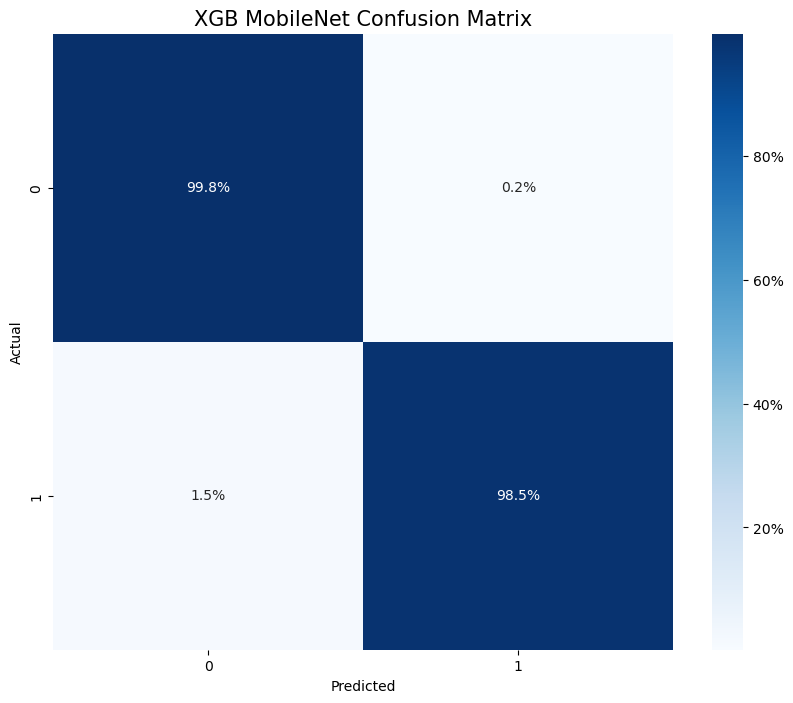

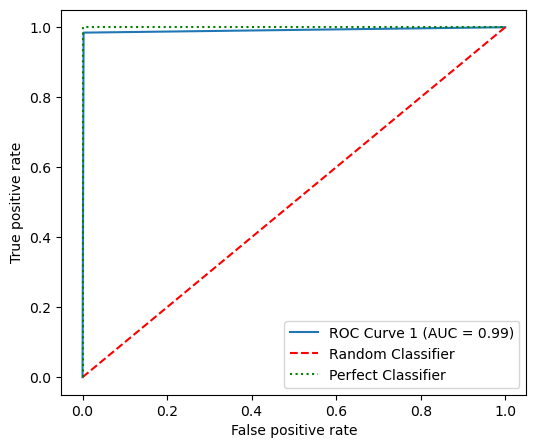

In [30]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
xgb_conf_matrix = confusion_matrix(y_test, xgb_MobileNet_prediction)

# Calculate percentages
xgb_conf_matrix_percent = xgb_conf_matrix.astype('float') / xgb_conf_matrix.sum(axis=1)[:, np.newaxis] * 100

# Plotting the normalized confusion matrix
plt.figure(figsize=(10, 8))
ax = sns.heatmap(xgb_conf_matrix_percent, annot=True, cmap='Blues', fmt=".1f", cbar_kws={'format': '%.0f%%'})

# Annotate the heatmap with percentage signs
for t in ax.texts: 
    t.set_text(t.get_text() + "%")

plt.title('XGB MobileNet Confusion Matrix', size=15)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.savefig('XGB_MobileNet_conf_matrix_percent.png')
plt.show()




from sklearn.metrics import roc_curve, auc, roc_auc_score
fpr , tpr , _ = roc_curve(y_test, xgb_MobileNet_prediction )
auc = roc_auc_score(y_test, xgb_MobileNet_prediction)
fig, ax = plt.subplots(figsize=(6, 5))
plt.plot(fpr, tpr, label='ROC Curve 1 (AUC = %0.2f)' % (auc))
plt.plot([0, 1], [0, 1], linestyle='--', color='red', label='Random Classifier')   
plt.plot([0, 0, 1], [0, 1, 1], linestyle=':', color='green', label='Perfect Classifier')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend(loc="lower right")
plt.savefig('XGB MobileNet AUC ROC.png')

### Random Forest MobileNet

In [41]:
from sklearn.ensemble import RandomForestClassifier

In [44]:
rf_MobileNet_model = RandomForestClassifier()
rf_MobileNet_model.fit(X_train_MobileNet, y_train)
#Now predict using the trained  model. 
rf_MobileNet_prediction = rf_MobileNet_model.predict(X_test_MobileNet)
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
print('train set accuracy is:',accuracy_score(y_train, rf_MobileNet_model.predict(X_train_MobileNet)))
print('test set accuracy is:',accuracy_score(y_test, rf_MobileNet_prediction))
print(classification_report(y_test, rf_MobileNet_prediction))

train set accuracy is: 1.0
test set accuracy is: 0.9625
              precision    recall  f1-score   support

           0       0.95      0.98      0.96       412
           1       0.98      0.94      0.96       388

    accuracy                           0.96       800
   macro avg       0.96      0.96      0.96       800
weighted avg       0.96      0.96      0.96       800



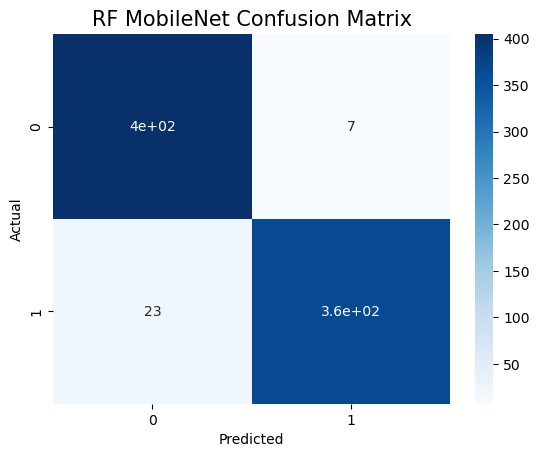

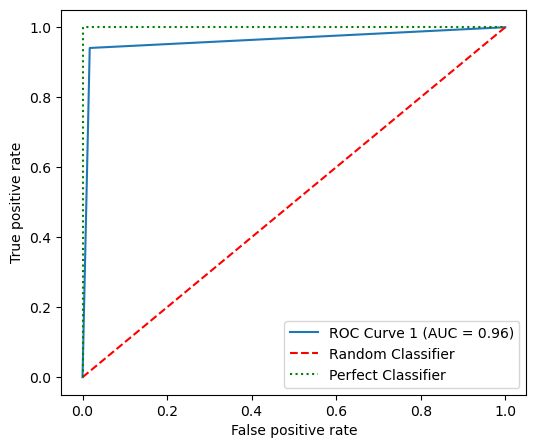

In [45]:
from sklearn.metrics import confusion_matrix
bag_conf_matrix = confusion_matrix(y_test, rf_MobileNet_prediction)
sns.heatmap(bag_conf_matrix,annot=True,cmap='Blues')
plt.title('RF MobileNet Confusion Matrix',size=15)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.savefig('RF MobileNet conf matrix.png')


from sklearn.metrics import roc_curve, auc, roc_auc_score
fpr , tpr , _ = roc_curve(y_test, rf_MobileNet_prediction)
auc = roc_auc_score(y_test, rf_MobileNet_prediction)
fig, ax = plt.subplots(figsize=(6, 5))
plt.plot(fpr, tpr, label='ROC Curve 1 (AUC = %0.2f)' % (auc))
plt.plot([0, 1], [0, 1], linestyle='--', color='red', label='Random Classifier')   
plt.plot([0, 0, 1], [0, 1, 1], linestyle=':', color='green', label='Perfect Classifier')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend(loc="lower right")
plt.savefig('Rf MobileNet AUC ROC.png')

### Bagging MobileNet

In [46]:
from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.model_selection import cross_val_score



bag_MobileNet_model = BaggingClassifier()
bag_MobileNet_model.fit(X_train_MobileNet, y_train)
bag_MobileNet_prediction = bag_MobileNet_model.predict(X_test_MobileNet)

#Print overall accuracy

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
print('train set accuracy is:',accuracy_score(y_train, bag_MobileNet_model.predict(X_train_MobileNet)))
print('test set accuracy is:',accuracy_score(y_test, bag_MobileNet_prediction))

print(classification_report(y_test, bag_MobileNet_prediction))

train set accuracy is: 0.9977777777777778
test set accuracy is: 0.94375
              precision    recall  f1-score   support

           0       0.93      0.96      0.95       412
           1       0.95      0.93      0.94       388

    accuracy                           0.94       800
   macro avg       0.94      0.94      0.94       800
weighted avg       0.94      0.94      0.94       800



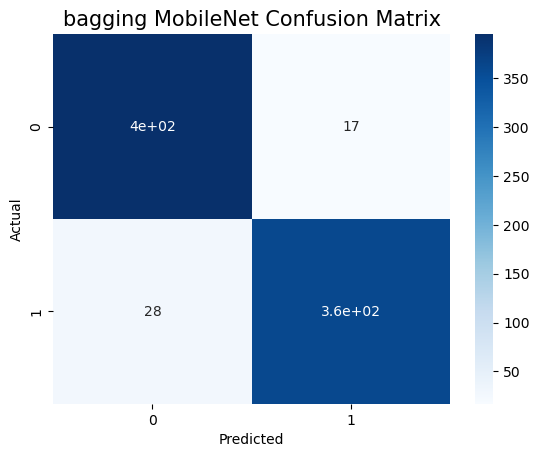

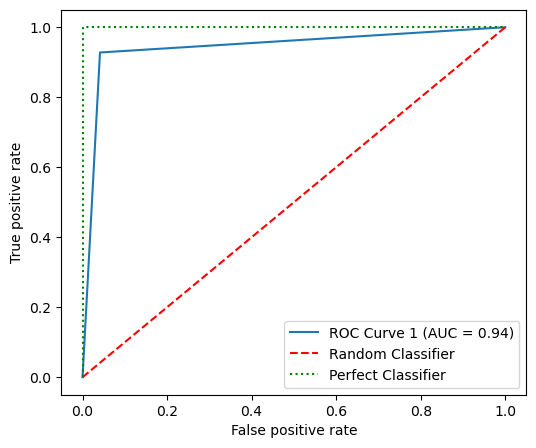

In [47]:
from sklearn.metrics import confusion_matrix
bag_conf_matrix = confusion_matrix(y_test, bag_MobileNet_prediction)
sns.heatmap(bag_conf_matrix,annot=True,cmap='Blues')
plt.title('bagging MobileNet Confusion Matrix',size=15)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.savefig('bagging MobileNet conf matrix.png')


from sklearn.metrics import roc_curve, auc, roc_auc_score
fpr , tpr , _ = roc_curve(y_test, bag_MobileNet_prediction)
auc = roc_auc_score(y_test, bag_MobileNet_prediction)
fig, ax = plt.subplots(figsize=(6, 5))
plt.plot(fpr, tpr, label='ROC Curve 1 (AUC = %0.2f)' % (auc))
plt.plot([0, 1], [0, 1], linestyle='--', color='red', label='Random Classifier')   
plt.plot([0, 0, 1], [0, 1, 1], linestyle=':', color='green', label='Perfect Classifier')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend(loc="lower right")
plt.savefig('bagging MobileNet AUC ROC.png')

### Adaboost MobileNet

In [48]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.model_selection import cross_val_score



abc_MobileNet_model = AdaBoostClassifier()
abc_MobileNet_model.fit(X_train_MobileNet, y_train)
abc_MobileNet_prediction = abc_MobileNet_model.predict(X_test_MobileNet)

#Print overall accuracy

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
print('train set accuracy is:',accuracy_score(y_train, abc_MobileNet_model.predict(X_train_MobileNet)))
print('test set accuracy is:',accuracy_score(y_test, abc_MobileNet_prediction))

print(classification_report(y_test, abc_MobileNet_prediction))

train set accuracy is: 0.9956944444444444
test set accuracy is: 0.9775
              precision    recall  f1-score   support

           0       0.98      0.97      0.98       412
           1       0.97      0.98      0.98       388

    accuracy                           0.98       800
   macro avg       0.98      0.98      0.98       800
weighted avg       0.98      0.98      0.98       800



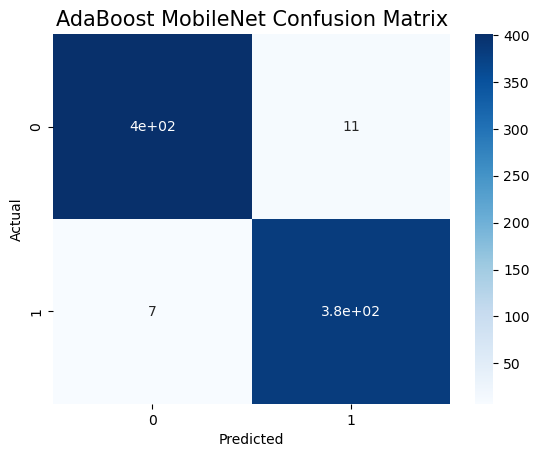

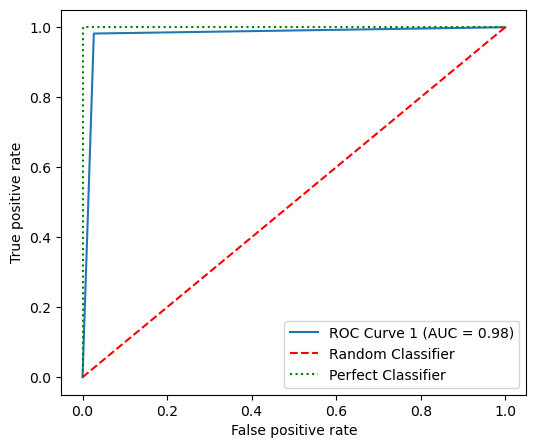

In [49]:
from sklearn.metrics import confusion_matrix
bag_conf_matrix = confusion_matrix(y_test, abc_MobileNet_prediction)
sns.heatmap(bag_conf_matrix, annot=True, cmap='Blues')
plt.title('AdaBoost MobileNet Confusion Matrix',size=15)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.savefig('AdaBoost MobileNet conf matrix.png')


from sklearn.metrics import roc_curve, auc, roc_auc_score
fpr , tpr , _ = roc_curve(y_test, abc_MobileNet_prediction )
auc = roc_auc_score(y_test, abc_MobileNet_prediction)
fig, ax = plt.subplots(figsize=(6, 5))
plt.plot(fpr, tpr, label='ROC Curve 1 (AUC = %0.2f)' % (auc))
plt.plot([0, 1], [0, 1], linestyle='--', color='red', label='Random Classifier')   
plt.plot([0, 0, 1], [0, 1, 1], linestyle=':', color='green', label='Perfect Classifier')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend(loc="lower right")
plt.savefig('AdaBoost MobileNet AUC ROC.png')

# MobileNetV2

In [25]:
from keras.applications import MobileNetV2
#Load model wothout classifier/fully connected layers
MobileNetV2_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(image_size_224, image_size_224, 3))

#Make loaded layers as non-trainable. This is important as we want to work with pre-trained weights
for layer in MobileNetV2_model.layers:
	layer.trainable = False
    
MobileNetV2_model.summary()  #Trainable parameters will be 0

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_4[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 112, 112, 32)         0         ['bn_Conv1[

In [35]:
# #Now, let us use features from convolutional network
X_train_MobileNetV2 = MobileNetV2_model.predict(X_train)
X_train_MobileNetV2 = X_train_MobileNetV2.reshape(X_train_MobileNetV2.shape[0], -1)
# # Save features to a file
np.save('X_train_MobileNetV2_hommomorphic.npy', X_train_MobileNetV2)

37/37 [==============================] - 67s 2s/step


In [36]:
# Extract features for test data
X_test_MobileNetV2 = MobileNetV2_model.predict(X_test)
X_test_MobileNetV2 = X_test_MobileNetV2.reshape(X_test_MobileNetV2.shape[0], -1)
# Save features to a file
np.save('X_test_MobileNetV2_hommomorphic.npy', X_test_MobileNetV2)

10/10 [==============================] - 14s 1s/step


In [27]:
# Load features from the saved file
X_train_MobileNetV2 = np.load('X_train_MobileNetV2_hommomorphic.npy')
X_test_MobileNetV2 = np.load('X_test_MobileNetV2_hommomorphic.npy')

FileNotFoundError: [Errno 2] No such file or directory: 'X_train_MobileNetV2_hommomorphic.npy'

### XGB MobileNetV2

In [30]:
import xgboost as xgb
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import accuracy_score, classification_report

# Initialize the model
xgb_MobileNetV2_model = xgb.XGBClassifier()

# Perform 5-fold cross-validation
cv = KFold(n_splits=10, shuffle=True, random_state=42)
cv_scores = cross_val_score(xgb_MobileNetV2_model, X_train_MobileNetV2, y_train_1d, cv=cv, scoring='accuracy')

print(f'Cross-validation accuracy scores: {cv_scores}')
print(f'Mean cross-validation accuracy: {cv_scores.mean()}')
print(f'Standard deviation of cross-validation accuracy: {cv_scores.std()}')

# Fit the model on the entire training set
xgb_MobileNetV2_model.fit(X_train_MobileNetV2, y_train_1d)

# Predict on the test set
xgb_MobileNetV2_prediction = xgb_MobileNetV2_model.predict(X_test_MobileNetV2)

# Print overall accuracy
print('Train set accuracy:', accuracy_score(y_train_1d, xgb_MobileNetV2_model.predict(X_train_MobileNetV2)))
print('Test set accuracy:', accuracy_score(y_test_1d, xgb_MobileNetV2_prediction))

# Print classification report
print(classification_report(y_test_1d, xgb_MobileNetV2_prediction))

Cross-validation accuracy scores: [0.88034188 0.86324786 0.84615385 0.88793103 0.82758621 0.8362069
 0.87068966 0.87931034 0.82758621 0.87931034]
Mean cross-validation accuracy: 0.8598364279398762
Standard deviation of cross-validation accuracy: 0.022188733893064805
Train set accuracy: 1.0
Test set accuracy: 0.9003436426116839
              precision    recall  f1-score   support

           0       0.89      0.93      0.91       154
           1       0.92      0.87      0.89       137

    accuracy                           0.90       291
   macro avg       0.90      0.90      0.90       291
weighted avg       0.90      0.90      0.90       291



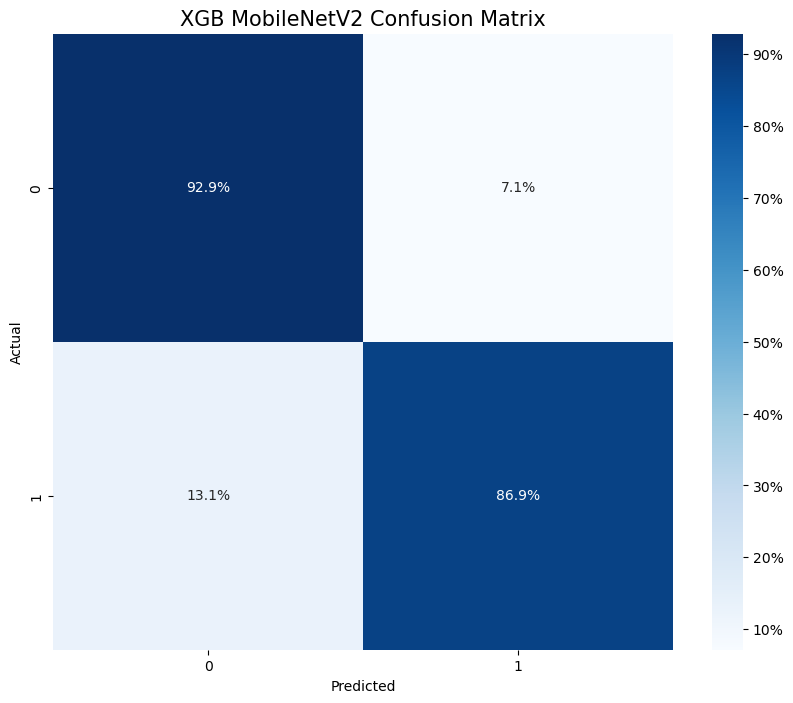

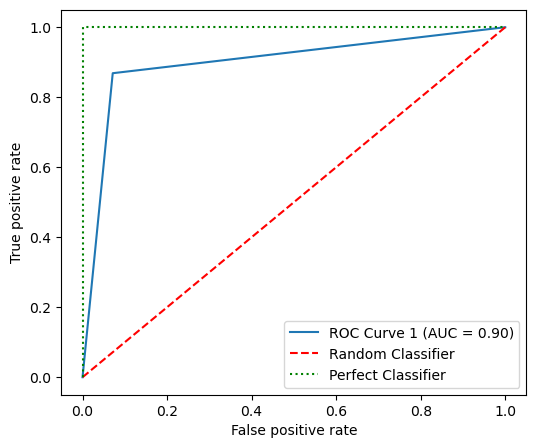

In [31]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
xgb_conf_matrix = confusion_matrix(y_test_1d, xgb_MobileNetV2_prediction)

# Calculate percentages
xgb_conf_matrix_percent = xgb_conf_matrix.astype('float') / xgb_conf_matrix.sum(axis=1)[:, np.newaxis] * 100

# Plotting the normalized confusion matrix
plt.figure(figsize=(10, 8))
ax = sns.heatmap(xgb_conf_matrix_percent, annot=True, cmap='Blues', fmt=".1f", cbar_kws={'format': '%.0f%%'})

# Annotate the heatmap with percentage signs
for t in ax.texts: 
    t.set_text(t.get_text() + "%")

plt.title('XGB MobileNetV2 Confusion Matrix', size=15)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.savefig('XGB_MobileNetV2_conf_matrix_percent.png')
plt.show()




from sklearn.metrics import roc_curve, auc, roc_auc_score
fpr , tpr , _ = roc_curve(y_test_1d, xgb_MobileNetV2_prediction )
auc = roc_auc_score(y_test_1d, xgb_MobileNetV2_prediction)
fig, ax = plt.subplots(figsize=(6, 5))
plt.plot(fpr, tpr, label='ROC Curve 1 (AUC = %0.2f)' % (auc))
plt.plot([0, 1], [0, 1], linestyle='--', color='red', label='Random Classifier')   
plt.plot([0, 0, 1], [0, 1, 1], linestyle=':', color='green', label='Perfect Classifier')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend(loc="lower right")
plt.savefig('XGB MobileNetV2 AUC ROC.png')

# MobileNetV3Small

In [16]:
from keras.applications import MobileNetV3Small
#Load model wothout classifier/fully connected layers
MobileNetV3Small_model = MobileNetV3Small(weights='imagenet', include_top=False, input_shape=(image_size_224, image_size_224, 3))

#Make loaded layers as non-trainable. This is important as we want to work with pre-trained weights
for layer in MobileNetV3Small_model.layers:
	layer.trainable = False
    
MobileNetV3Small_model.summary()  #Trainable parameters will be 0

Model: "MobilenetV3small"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 rescaling_1 (Rescaling)     (None, 224, 224, 3)          0         ['input_2[0][0]']             
                                                                                                  
 Conv (Conv2D)               (None, 112, 112, 16)         432       ['rescaling_1[0][0]']         
                                                                                                  
 Conv/BatchNorm (BatchNorma  (None, 112, 112, 16)         64        ['Conv[0][0]']                
 lization)                                                                         

In [41]:
# #Now, let us use features from convolutional network
X_train_MobileNetV3Small = MobileNetV3Small_model.predict(X_train)
X_train_MobileNetV3Small = X_train_MobileNetV3Small.reshape(X_train_MobileNetV3Small.shape[0], -1)
# # Save features to a file
np.save('X_train_MobileNetV3Small_hommomorphic.npy', X_train_MobileNetV3Small)

37/37 [==============================] - 28s 684ms/step


In [42]:
# Extract features for test data
X_test_MobileNetV3Small = MobileNetV3Small_model.predict(X_test)
X_test_MobileNetV3Small = X_test_MobileNetV3Small.reshape(X_test_MobileNetV3Small.shape[0], -1)
# Save features to a file
np.save('X_test_MobileNetV3Small_hommomorphic.npy', X_test_MobileNetV3Small)

10/10 [==============================] - 6s 588ms/step


In [12]:
# Load features from the saved file
X_train_MobileNetV3Small= np.load('X_train_MobileNetV3Small_hommomorphic.npy')
X_test_MobileNetV3Small = np.load('X_test_MobileNetV3Small_hommomorphic.npy')

In [13]:
import xgboost as xgb
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import accuracy_score, classification_report

# Initialize the model
xgb_MobileNetV3Small_model = xgb.XGBClassifier()

# Perform 5-fold cross-validation
cv = KFold(n_splits=10, shuffle=True, random_state=42)
cv_scores = cross_val_score(xgb_MobileNetV3Small_model, X_train_MobileNetV3Small, y_train_1d, cv=cv, scoring='accuracy')

print(f'Cross-validation accuracy scores: {cv_scores}')
print(f'Mean cross-validation accuracy: {cv_scores.mean()}')
print(f'Standard deviation of cross-validation accuracy: {cv_scores.std()}')

# Fit the model on the entire training set
xgb_MobileNetV3Small_model.fit(X_train_MobileNetV3Small, y_train_1d)

# Predict on the test set
xgb_MobileNetV3Small_prediction = xgb_MobileNetV3Small_model.predict(X_test_MobileNetV3Small)

# Print overall accuracy
print('Train set accuracy:', accuracy_score(y_train_1d, xgb_MobileNetV3Small_model.predict(X_train_MobileNetV3Small)))
print('Test set accuracy:', accuracy_score(y_test_1d, xgb_MobileNetV3Small_prediction))

# Print classification report
print(classification_report(y_test_1d, xgb_MobileNetV3Small_prediction))

Cross-validation accuracy scores: [0.86324786 0.82905983 0.83760684 0.88793103 0.89655172 0.8362069
 0.87931034 0.9137931  0.80172414 0.87931034]
Mean cross-validation accuracy: 0.8624742116121427
Standard deviation of cross-validation accuracy: 0.03335553206600839
Train set accuracy: 1.0
Test set accuracy: 0.9140893470790378
              precision    recall  f1-score   support

           0       0.91      0.93      0.92       154
           1       0.92      0.90      0.91       137

    accuracy                           0.91       291
   macro avg       0.91      0.91      0.91       291
weighted avg       0.91      0.91      0.91       291



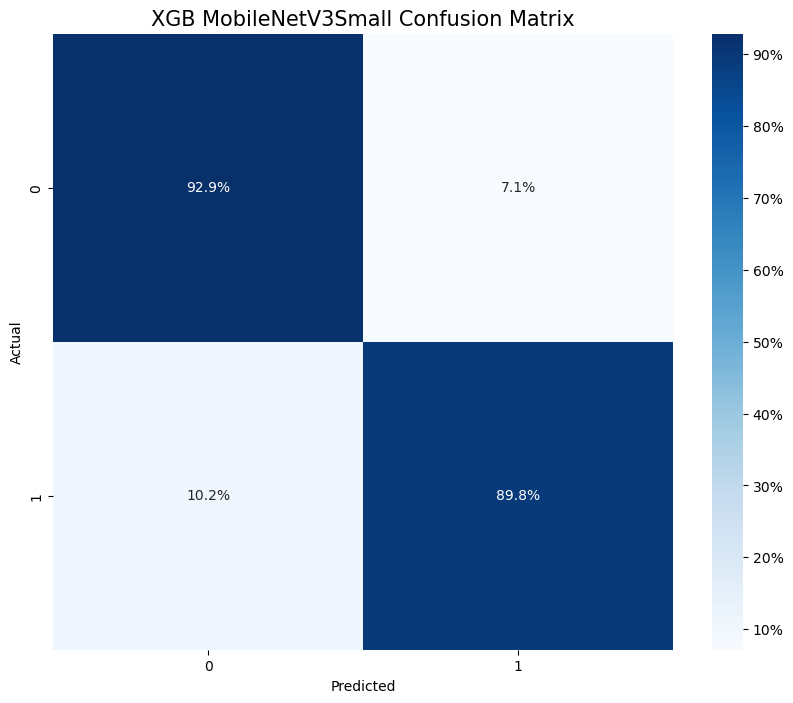

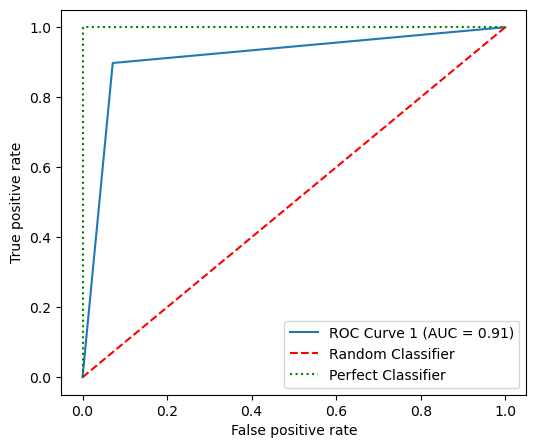

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
xgb_conf_matrix = confusion_matrix(y_test_1d, xgb_MobileNetV3Small_prediction)

# Calculate percentages
xgb_conf_matrix_percent = xgb_conf_matrix.astype('float') / xgb_conf_matrix.sum(axis=1)[:, np.newaxis] * 100

# Plotting the normalized confusion matrix
plt.figure(figsize=(10, 8))
ax = sns.heatmap(xgb_conf_matrix_percent, annot=True, cmap='Blues', fmt=".1f", cbar_kws={'format': '%.0f%%'})

# Annotate the heatmap with percentage signs
for t in ax.texts: 
    t.set_text(t.get_text() + "%")

plt.title('XGB MobileNetV3Small Confusion Matrix', size=15)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.savefig('XGB_MobileNetV3Small_conf_matrix_percent.png')
plt.show()




from sklearn.metrics import roc_curve, auc, roc_auc_score
fpr , tpr , _ = roc_curve(y_test_1d, xgb_MobileNetV3Small_prediction )
auc = roc_auc_score(y_test_1d, xgb_MobileNetV3Small_prediction)
fig, ax = plt.subplots(figsize=(6, 5))
plt.plot(fpr, tpr, label='ROC Curve 1 (AUC = %0.2f)' % (auc))
plt.plot([0, 1], [0, 1], linestyle='--', color='red', label='Random Classifier')   
plt.plot([0, 0, 1], [0, 1, 1], linestyle=':', color='green', label='Perfect Classifier')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend(loc="lower right")
plt.savefig('XGB MobileNetV3Small AUC ROC.png')

# MobileNetV3Large

In [7]:
from keras.applications import MobileNetV3Large
#Load model wothout classifier/fully connected layers
MobileNetV3Large_model = MobileNetV3Large(weights='imagenet', include_top=False, input_shape=(image_size_224, image_size_224, 3))

#Make loaded layers as non-trainable. This is important as we want to work with pre-trained weights
for layer in MobileNetV3Large_model.layers:
	layer.trainable = False
    
MobileNetV3Large_model.summary()  #Trainable parameters will be 0

Model: "MobilenetV3large"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, 224, 224, 3)          0         ['input_1[0][0]']             
                                                                                                  
 Conv (Conv2D)               (None, 112, 112, 16)         432       ['rescaling[0][0]']           
                                                                                                  
 Conv/BatchNorm (BatchNorma  (None, 112, 112, 16)         64        ['Conv[0][0]']                
 lization)                                                                         

In [46]:
# #Now, let us use features from convolutional network
X_train_MobileNetV3Large = MobileNetV3Large_model.predict(X_train)
X_train_MobileNetV3Large = X_train_MobileNetV3Large.reshape(X_train_MobileNetV3Large.shape[0], -1)
# # Save features to a file
np.save('X_train_MobileNetV3Large_hommomorphic.npy', X_train_MobileNetV3Large)

37/37 [==============================] - 69s 2s/step


In [47]:
# Extract features for test data
X_test_MobileNetV3Large = MobileNetV3Large_model.predict(X_test)
X_test_MobileNetV3Large = X_test_MobileNetV3Large.reshape(X_test_MobileNetV3Small.shape[0], -1)
# Save features to a file
np.save('X_test_MobileNetV3Large_hommomorphic.npy', X_test_MobileNetV3Large)

10/10 [==============================] - 14s 1s/step


In [8]:
# Load features from the saved file
X_train_MobileNetV3Large= np.load('X_train_MobileNetV3Large_hommomorphic.npy')
X_test_MobileNetV3Large = np.load('X_test_MobileNetV3Large_hommomorphic.npy')

In [10]:
import xgboost as xgb
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import accuracy_score, classification_report

# Initialize the model
xgb_MobileNetV3Large_model = xgb.XGBClassifier()

# Perform 5-fold cross-validation
cv = KFold(n_splits=10, shuffle=True, random_state=42)
cv_scores = cross_val_score(xgb_MobileNetV3Large_model, X_train_MobileNetV3Large, y_train_1d, cv=cv, scoring='accuracy')

print(f'Cross-validation accuracy scores: {cv_scores}')
print(f'Mean cross-validation accuracy: {cv_scores.mean()}')
print(f'Standard deviation of cross-validation accuracy: {cv_scores.std()}')

# Fit the model on the entire training set
xgb_MobileNetV3Large_model.fit(X_train_MobileNetV3Large, y_train_1d)

# Predict on the test set
xgb_MobileNetV3Large_prediction = xgb_MobileNetV3Large_model.predict(X_test_MobileNetV3Large)

# Print overall accuracy
print('Train set accuracy:', accuracy_score(y_train_1d, xgb_MobileNetV3Large_model.predict(X_train_MobileNetV3Large)))
print('Test set accuracy:', accuracy_score(y_test_1d, xgb_MobileNetV3Large_prediction))

# Print classification report
print(classification_report(y_test_1d, xgb_MobileNetV3Large_prediction))


Cross-validation accuracy scores: [0.88888889 0.85470085 0.82051282 0.90517241 0.88793103 0.84482759
 0.89655172 0.86206897 0.82758621 0.90517241]
Mean cross-validation accuracy: 0.8693412908930149
Standard deviation of cross-validation accuracy: 0.030052771807283475
Train set accuracy: 1.0
Test set accuracy: 0.9072164948453608
              precision    recall  f1-score   support

           0       0.89      0.94      0.91       154
           1       0.93      0.87      0.90       137

    accuracy                           0.91       291
   macro avg       0.91      0.91      0.91       291
weighted avg       0.91      0.91      0.91       291



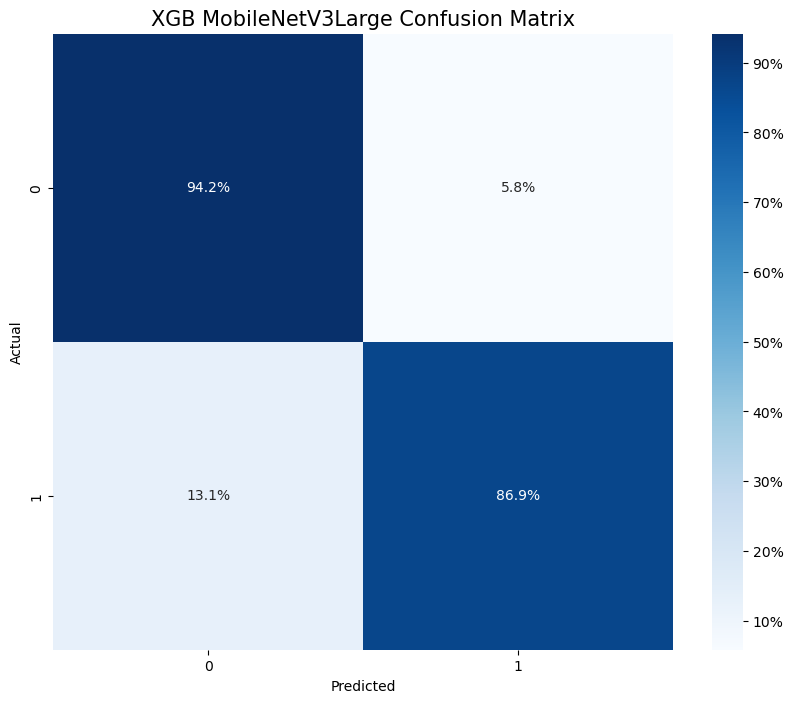

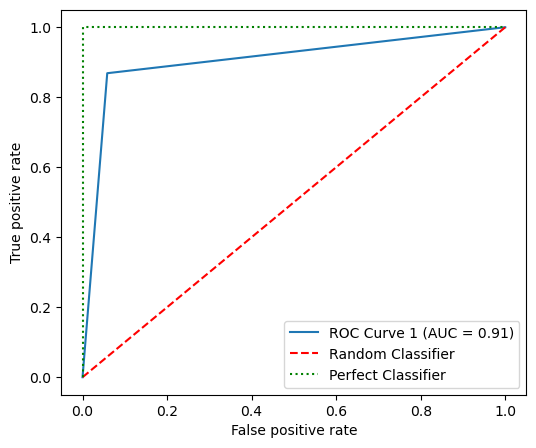

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
xgb_conf_matrix = confusion_matrix(y_test_1d, xgb_MobileNetV3Large_prediction)

# Calculate percentages
xgb_conf_matrix_percent = xgb_conf_matrix.astype('float') / xgb_conf_matrix.sum(axis=1)[:, np.newaxis] * 100

# Plotting the normalized confusion matrix
plt.figure(figsize=(10, 8))
ax = sns.heatmap(xgb_conf_matrix_percent, annot=True, cmap='Blues', fmt=".1f", cbar_kws={'format': '%.0f%%'})

# Annotate the heatmap with percentage signs
for t in ax.texts: 
    t.set_text(t.get_text() + "%")

plt.title('XGB MobileNetV3Large Confusion Matrix', size=15)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.savefig('XGB_MobileNetV3Large_conf_matrix_percent.png')
plt.show()




from sklearn.metrics import roc_curve, auc, roc_auc_score
fpr , tpr , _ = roc_curve(y_test_1d, xgb_MobileNetV3Large_prediction )
auc = roc_auc_score(y_test_1d, xgb_MobileNetV3Large_prediction)
fig, ax = plt.subplots(figsize=(6, 5))
plt.plot(fpr, tpr, label='ROC Curve 1 (AUC = %0.2f)' % (auc))
plt.plot([0, 1], [0, 1], linestyle='--', color='red', label='Random Classifier')   
plt.plot([0, 0, 1], [0, 1, 1], linestyle=':', color='green', label='Perfect Classifier')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend(loc="lower right")
plt.savefig('XGB MobileNetV3Large AUC ROC.png')